The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [19],
                 'channel': [0],
                 'frequency_per_week': [12.080827476611315],
                 'phaseshift': [117]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [0],
           'index': ['2023-06-23T06:00:00'],
           'slope': [0.00012030454772098308]}}


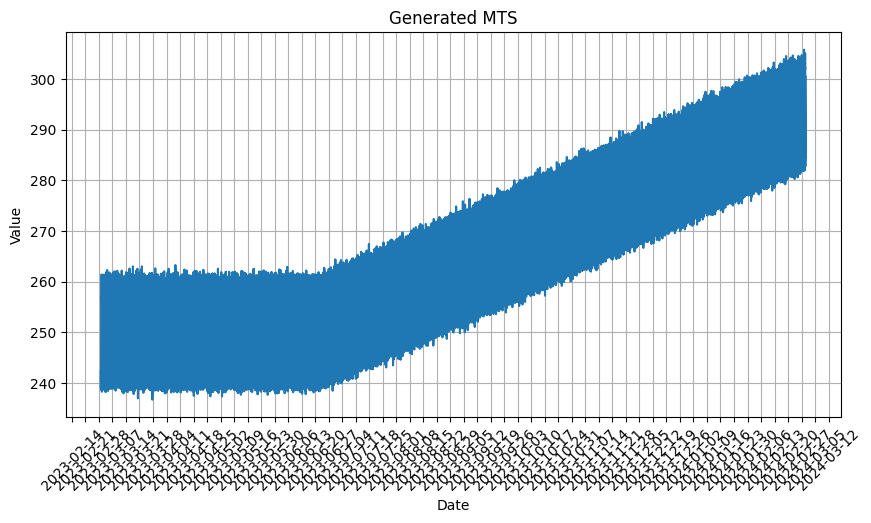

In [165]:
%load_ext autoreload
%autoreload 2
import torch; torch.manual_seed(955)
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

from dataGen import Gen
from Encoders import LongShort_TCVAE_Encoder#, RnnEncoder, MST_VAE_Encoder, MST_VAE_Encoder_dist
from Decoders import LongShort_TCVAE_Decoder#, RnnDecoder, MST_VAE_Decoder, MST_VAE_Decoder_dist
from vae import Variational_Autoencoder, VQ_MST_VAE, VQ_Quantizer
from utils import train_on_effect, generate_data, extract_parameters, suppress_prints, add_mu_std
from train import train, train_MCMC, stridedWindow, slidingWindow, criterion

import numpy as np
import matplotlib.pyplot as plt
import pprint
# all parameters for generating the time series should be configured in this cell
periode = 365 #days
step = 5 # mess interval in minutes
val = 500
n_channels = 1
effects = {
    "Pulse": {
        "occurances":0,
        "max_amplitude":1.5,   
        "interval":40
        },
    "Trend": {
        "occurances":1,
        "max_slope":0.0002,
        "type":"linear"
        },
    "Seasonality": {
        "occurances":1,
        "frequency_per_week":(7, 14), # min and max occurances per week
        "amplitude_range":(5, 20),
        },
    "std_variation": {
        "occurances":0,
        "max_value":10,
        "interval":1000,
        },
    "channels_coupling":{
        "occurances":0,
        "coupling_strengh":20
        },
    "Noise": {
        "occurances":0,
        "max_slope":0.005,
        "type":"linear"
        }
    }

X = Gen(periode, step, val, n_channels, effects)
x, params, e_params = X.parameters()
# pprint.pprint(params)
pprint.pprint(e_params)
X.show()



In [188]:
### Init Model
latent_dims = 30 # 6 # 17
L= 2016# 39 #32
device = 'cuda' if torch.cuda.is_available() else 'cpu'


# v = Variational_Autoencoder(n_channels = n_channels,
#                             num_layers =  3,#4, #3
#                             latent_dims= latent_dims,
#                             v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
#                             v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
#                             L=L,
#                             slope = 0,
#                             first_kernel = 20, #11, #20
#                             ß = 1.5,
#                             modified=True,
#                             reduction = True)
v = VQ_MST_VAE(n_channels = n_channels,
                            num_layers =  4,#4, #3
                            latent_dims= latent_dims,
                            v_encoder = LongShort_TCVAE_Encoder, #MST_VAE_Encoder,
                            v_decoder = LongShort_TCVAE_Decoder, #MST_VAE_Decoder,
                            v_quantizer = VQ_Quantizer,
                            L=L,
                            slope = 0,
                            first_kernel = 1008, #11, #20
                            commit_loss = 1.5,
                            modified=True,
                            reduction = True) #10 5


v = v.to(device)

opt = optim.Adam(v.parameters(), lr = 0.005043529186448577) # 0.005043529186448577 0.006819850049647945
print(v)

1
8
1
8
VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(6, 8, kernel_size=(2,), stride=(2,))
        (10): LeakyReLU(negative_slope=0, inplace=True)
        (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Linear(in_features=1

In [189]:
x = torch.FloatTensor(x)
n = x.shape[1]

train_ = x[:, :int(0.8*n)]
val_   = x[:, int(0.8*n):int(0.9*n)]
test_  = x[:, int(0.9*n):]

train_data = DataLoader(stridedWindow(train_, L),# slidingWindow, stridedWindow
                        batch_size= 50,# 59, # 22
                        shuffle = False
                        )
val_data = DataLoader(slidingWindow(val_, L),
                        batch_size=500,
                        shuffle = False
                        )
test_data = DataLoader(slidingWindow(test_, L),
                        batch_size=500,
                        shuffle = False
                        )

In [190]:
# v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='no_effect', n_samples=5, epochs_per_sample=1000)
# v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='trend', n_samples=5, epochs_per_sample=1000)
# v, X, train_data = train_on_effect(v, opt, device, n_channels=n_channels, effect='seasonality', n_samples=5, epochs_per_sample=1000)

In [191]:
for epoch in range(1, 10000):
    train(v, train_data, criterion, opt, device, epoch, VQ = True)

Train Epoch: 1 [0/41 (0%)]	Loss: 6374.251143
====> Epoch: 1 Average loss: 6374.2511
Train Epoch: 2 [0/41 (0%)]	Loss: 3909.649771
====> Epoch: 2 Average loss: 3909.6498
Train Epoch: 3 [0/41 (0%)]	Loss: 575.967035
====> Epoch: 3 Average loss: 575.9670
Train Epoch: 4 [0/41 (0%)]	Loss: 1032.746856
====> Epoch: 4 Average loss: 1032.7469
Train Epoch: 5 [0/41 (0%)]	Loss: 1873.623285
====> Epoch: 5 Average loss: 1873.6233
Train Epoch: 6 [0/41 (0%)]	Loss: 174.845108
====> Epoch: 6 Average loss: 174.8451
Train Epoch: 7 [0/41 (0%)]	Loss: 1553.592511
====> Epoch: 7 Average loss: 1553.5925
Train Epoch: 8 [0/41 (0%)]	Loss: 272.607017
====> Epoch: 8 Average loss: 272.6070
Train Epoch: 9 [0/41 (0%)]	Loss: 924.897866
====> Epoch: 9 Average loss: 924.8979
Train Epoch: 10 [0/41 (0%)]	Loss: 406.112329
====> Epoch: 10 Average loss: 406.1123
Train Epoch: 11 [0/41 (0%)]	Loss: 262.888100
====> Epoch: 11 Average loss: 262.8881
Train Epoch: 12 [0/41 (0%)]	Loss: 510.976467
====> Epoch: 12 Average loss: 510.9765


Train Epoch: 108 [0/41 (0%)]	Loss: 3.333457
====> Epoch: 108 Average loss: 3.3335
Train Epoch: 109 [0/41 (0%)]	Loss: 4.168060
====> Epoch: 109 Average loss: 4.1681
Train Epoch: 110 [0/41 (0%)]	Loss: 3.727564
====> Epoch: 110 Average loss: 3.7276
Train Epoch: 111 [0/41 (0%)]	Loss: 3.956727
====> Epoch: 111 Average loss: 3.9567
Train Epoch: 112 [0/41 (0%)]	Loss: 3.849400
====> Epoch: 112 Average loss: 3.8494
Train Epoch: 113 [0/41 (0%)]	Loss: 2.860410
====> Epoch: 113 Average loss: 2.8604
Train Epoch: 114 [0/41 (0%)]	Loss: 4.282387
====> Epoch: 114 Average loss: 4.2824
Train Epoch: 115 [0/41 (0%)]	Loss: 2.942828
====> Epoch: 115 Average loss: 2.9428
Train Epoch: 116 [0/41 (0%)]	Loss: 3.200892
====> Epoch: 116 Average loss: 3.2009
Train Epoch: 117 [0/41 (0%)]	Loss: 4.027566
====> Epoch: 117 Average loss: 4.0276
Train Epoch: 118 [0/41 (0%)]	Loss: 2.703886
====> Epoch: 118 Average loss: 2.7039
Train Epoch: 119 [0/41 (0%)]	Loss: 3.009817
====> Epoch: 119 Average loss: 3.0098
Train Epoch: 120

Train Epoch: 214 [0/41 (0%)]	Loss: 2.206416
====> Epoch: 214 Average loss: 2.2064
Train Epoch: 215 [0/41 (0%)]	Loss: 2.511248
====> Epoch: 215 Average loss: 2.5112
Train Epoch: 216 [0/41 (0%)]	Loss: 3.141269
====> Epoch: 216 Average loss: 3.1413
Train Epoch: 217 [0/41 (0%)]	Loss: 2.217751
====> Epoch: 217 Average loss: 2.2178
Train Epoch: 218 [0/41 (0%)]	Loss: 2.663813
====> Epoch: 218 Average loss: 2.6638
Train Epoch: 219 [0/41 (0%)]	Loss: 2.697657
====> Epoch: 219 Average loss: 2.6977
Train Epoch: 220 [0/41 (0%)]	Loss: 2.402846
====> Epoch: 220 Average loss: 2.4028
Train Epoch: 221 [0/41 (0%)]	Loss: 3.032731
====> Epoch: 221 Average loss: 3.0327
Train Epoch: 222 [0/41 (0%)]	Loss: 2.300763
====> Epoch: 222 Average loss: 2.3008
Train Epoch: 223 [0/41 (0%)]	Loss: 2.595565
====> Epoch: 223 Average loss: 2.5956
Train Epoch: 224 [0/41 (0%)]	Loss: 2.228916
====> Epoch: 224 Average loss: 2.2289
Train Epoch: 225 [0/41 (0%)]	Loss: 2.675892
====> Epoch: 225 Average loss: 2.6759
Train Epoch: 226

====> Epoch: 313 Average loss: 12.2490
Train Epoch: 314 [0/41 (0%)]	Loss: 15.705811
====> Epoch: 314 Average loss: 15.7058
Train Epoch: 315 [0/41 (0%)]	Loss: 19.663955
====> Epoch: 315 Average loss: 19.6640
Train Epoch: 316 [0/41 (0%)]	Loss: 16.023353
====> Epoch: 316 Average loss: 16.0234
Train Epoch: 317 [0/41 (0%)]	Loss: 12.758283
====> Epoch: 317 Average loss: 12.7583
Train Epoch: 318 [0/41 (0%)]	Loss: 18.382801
====> Epoch: 318 Average loss: 18.3828
Train Epoch: 319 [0/41 (0%)]	Loss: 9.850590
====> Epoch: 319 Average loss: 9.8506
Train Epoch: 320 [0/41 (0%)]	Loss: 11.566194
====> Epoch: 320 Average loss: 11.5662
Train Epoch: 321 [0/41 (0%)]	Loss: 14.043551
====> Epoch: 321 Average loss: 14.0436
Train Epoch: 322 [0/41 (0%)]	Loss: 10.252467
====> Epoch: 322 Average loss: 10.2525
Train Epoch: 323 [0/41 (0%)]	Loss: 10.886749
====> Epoch: 323 Average loss: 10.8867
Train Epoch: 324 [0/41 (0%)]	Loss: 13.403578
====> Epoch: 324 Average loss: 13.4036
Train Epoch: 325 [0/41 (0%)]	Loss: 10.3

Train Epoch: 414 [0/41 (0%)]	Loss: 2.800429
====> Epoch: 414 Average loss: 2.8004
Train Epoch: 415 [0/41 (0%)]	Loss: 5.204276
====> Epoch: 415 Average loss: 5.2043
Train Epoch: 416 [0/41 (0%)]	Loss: 2.786992
====> Epoch: 416 Average loss: 2.7870
Train Epoch: 417 [0/41 (0%)]	Loss: 2.215353
====> Epoch: 417 Average loss: 2.2154
Train Epoch: 418 [0/41 (0%)]	Loss: 3.987652
====> Epoch: 418 Average loss: 3.9877
Train Epoch: 419 [0/41 (0%)]	Loss: 3.653300
====> Epoch: 419 Average loss: 3.6533
Train Epoch: 420 [0/41 (0%)]	Loss: 4.253130
====> Epoch: 420 Average loss: 4.2531
Train Epoch: 421 [0/41 (0%)]	Loss: 5.036393
====> Epoch: 421 Average loss: 5.0364
Train Epoch: 422 [0/41 (0%)]	Loss: 6.669056
====> Epoch: 422 Average loss: 6.6691
Train Epoch: 423 [0/41 (0%)]	Loss: 1.840105
====> Epoch: 423 Average loss: 1.8401
Train Epoch: 424 [0/41 (0%)]	Loss: 2.328917
====> Epoch: 424 Average loss: 2.3289
Train Epoch: 425 [0/41 (0%)]	Loss: 2.119984
====> Epoch: 425 Average loss: 2.1200
Train Epoch: 426

Train Epoch: 518 [0/41 (0%)]	Loss: 1.711901
====> Epoch: 518 Average loss: 1.7119
Train Epoch: 519 [0/41 (0%)]	Loss: 2.556332
====> Epoch: 519 Average loss: 2.5563
Train Epoch: 520 [0/41 (0%)]	Loss: 1.725273
====> Epoch: 520 Average loss: 1.7253
Train Epoch: 521 [0/41 (0%)]	Loss: 1.802420
====> Epoch: 521 Average loss: 1.8024
Train Epoch: 522 [0/41 (0%)]	Loss: 2.530717
====> Epoch: 522 Average loss: 2.5307
Train Epoch: 523 [0/41 (0%)]	Loss: 2.235762
====> Epoch: 523 Average loss: 2.2358
Train Epoch: 524 [0/41 (0%)]	Loss: 2.082822
====> Epoch: 524 Average loss: 2.0828
Train Epoch: 525 [0/41 (0%)]	Loss: 2.266975
====> Epoch: 525 Average loss: 2.2670
Train Epoch: 526 [0/41 (0%)]	Loss: 1.884573
====> Epoch: 526 Average loss: 1.8846
Train Epoch: 527 [0/41 (0%)]	Loss: 1.547822
====> Epoch: 527 Average loss: 1.5478
Train Epoch: 528 [0/41 (0%)]	Loss: 2.693509
====> Epoch: 528 Average loss: 2.6935
Train Epoch: 529 [0/41 (0%)]	Loss: 1.456914
====> Epoch: 529 Average loss: 1.4569
Train Epoch: 530

Train Epoch: 623 [0/41 (0%)]	Loss: 2.037214
====> Epoch: 623 Average loss: 2.0372
Train Epoch: 624 [0/41 (0%)]	Loss: 2.449695
====> Epoch: 624 Average loss: 2.4497
Train Epoch: 625 [0/41 (0%)]	Loss: 1.715878
====> Epoch: 625 Average loss: 1.7159
Train Epoch: 626 [0/41 (0%)]	Loss: 1.630051
====> Epoch: 626 Average loss: 1.6301
Train Epoch: 627 [0/41 (0%)]	Loss: 1.638946
====> Epoch: 627 Average loss: 1.6389
Train Epoch: 628 [0/41 (0%)]	Loss: 6.736478
====> Epoch: 628 Average loss: 6.7365
Train Epoch: 629 [0/41 (0%)]	Loss: 1.562910
====> Epoch: 629 Average loss: 1.5629
Train Epoch: 630 [0/41 (0%)]	Loss: 3.056323
====> Epoch: 630 Average loss: 3.0563
Train Epoch: 631 [0/41 (0%)]	Loss: 1.406468
====> Epoch: 631 Average loss: 1.4065
Train Epoch: 632 [0/41 (0%)]	Loss: 1.388984
====> Epoch: 632 Average loss: 1.3890
Train Epoch: 633 [0/41 (0%)]	Loss: 1.693921
====> Epoch: 633 Average loss: 1.6939
Train Epoch: 634 [0/41 (0%)]	Loss: 1.814265
====> Epoch: 634 Average loss: 1.8143
Train Epoch: 635

Train Epoch: 730 [0/41 (0%)]	Loss: 1.203189
====> Epoch: 730 Average loss: 1.2032
Train Epoch: 731 [0/41 (0%)]	Loss: 1.896738
====> Epoch: 731 Average loss: 1.8967
Train Epoch: 732 [0/41 (0%)]	Loss: 1.661840
====> Epoch: 732 Average loss: 1.6618
Train Epoch: 733 [0/41 (0%)]	Loss: 1.274156
====> Epoch: 733 Average loss: 1.2742
Train Epoch: 734 [0/41 (0%)]	Loss: 1.734241
====> Epoch: 734 Average loss: 1.7342
Train Epoch: 735 [0/41 (0%)]	Loss: 1.659565
====> Epoch: 735 Average loss: 1.6596
Train Epoch: 736 [0/41 (0%)]	Loss: 1.458401
====> Epoch: 736 Average loss: 1.4584
Train Epoch: 737 [0/41 (0%)]	Loss: 1.466874
====> Epoch: 737 Average loss: 1.4669
Train Epoch: 738 [0/41 (0%)]	Loss: 1.450945
====> Epoch: 738 Average loss: 1.4509
Train Epoch: 739 [0/41 (0%)]	Loss: 4.461562
====> Epoch: 739 Average loss: 4.4616
Train Epoch: 740 [0/41 (0%)]	Loss: 2.032505
====> Epoch: 740 Average loss: 2.0325
Train Epoch: 741 [0/41 (0%)]	Loss: 4.999288
====> Epoch: 741 Average loss: 4.9993
Train Epoch: 742

Train Epoch: 834 [0/41 (0%)]	Loss: 1.144514
====> Epoch: 834 Average loss: 1.1445
Train Epoch: 835 [0/41 (0%)]	Loss: 1.525571
====> Epoch: 835 Average loss: 1.5256
Train Epoch: 836 [0/41 (0%)]	Loss: 1.515300
====> Epoch: 836 Average loss: 1.5153
Train Epoch: 837 [0/41 (0%)]	Loss: 1.067591
====> Epoch: 837 Average loss: 1.0676
Train Epoch: 838 [0/41 (0%)]	Loss: 2.348114
====> Epoch: 838 Average loss: 2.3481
Train Epoch: 839 [0/41 (0%)]	Loss: 1.472628
====> Epoch: 839 Average loss: 1.4726
Train Epoch: 840 [0/41 (0%)]	Loss: 1.870637
====> Epoch: 840 Average loss: 1.8706
Train Epoch: 841 [0/41 (0%)]	Loss: 2.425082
====> Epoch: 841 Average loss: 2.4251
Train Epoch: 842 [0/41 (0%)]	Loss: 1.941965
====> Epoch: 842 Average loss: 1.9420
Train Epoch: 843 [0/41 (0%)]	Loss: 2.338044
====> Epoch: 843 Average loss: 2.3380
Train Epoch: 844 [0/41 (0%)]	Loss: 1.844268
====> Epoch: 844 Average loss: 1.8443
Train Epoch: 845 [0/41 (0%)]	Loss: 1.487819
====> Epoch: 845 Average loss: 1.4878
Train Epoch: 846

====> Epoch: 938 Average loss: 1.0273
Train Epoch: 939 [0/41 (0%)]	Loss: 2.609676
====> Epoch: 939 Average loss: 2.6097
Train Epoch: 940 [0/41 (0%)]	Loss: 1.061902
====> Epoch: 940 Average loss: 1.0619
Train Epoch: 941 [0/41 (0%)]	Loss: 1.204291
====> Epoch: 941 Average loss: 1.2043
Train Epoch: 942 [0/41 (0%)]	Loss: 1.334702
====> Epoch: 942 Average loss: 1.3347
Train Epoch: 943 [0/41 (0%)]	Loss: 1.591391
====> Epoch: 943 Average loss: 1.5914
Train Epoch: 944 [0/41 (0%)]	Loss: 1.854525
====> Epoch: 944 Average loss: 1.8545
Train Epoch: 945 [0/41 (0%)]	Loss: 3.220093
====> Epoch: 945 Average loss: 3.2201
Train Epoch: 946 [0/41 (0%)]	Loss: 1.405935
====> Epoch: 946 Average loss: 1.4059
Train Epoch: 947 [0/41 (0%)]	Loss: 4.336123
====> Epoch: 947 Average loss: 4.3361
Train Epoch: 948 [0/41 (0%)]	Loss: 1.068234
====> Epoch: 948 Average loss: 1.0682
Train Epoch: 949 [0/41 (0%)]	Loss: 4.334268
====> Epoch: 949 Average loss: 4.3343
Train Epoch: 950 [0/41 (0%)]	Loss: 2.066117
====> Epoch: 950

Train Epoch: 1043 [0/41 (0%)]	Loss: 1.082251
====> Epoch: 1043 Average loss: 1.0823
Train Epoch: 1044 [0/41 (0%)]	Loss: 3.505485
====> Epoch: 1044 Average loss: 3.5055
Train Epoch: 1045 [0/41 (0%)]	Loss: 2.583201
====> Epoch: 1045 Average loss: 2.5832
Train Epoch: 1046 [0/41 (0%)]	Loss: 5.375220
====> Epoch: 1046 Average loss: 5.3752
Train Epoch: 1047 [0/41 (0%)]	Loss: 2.398693
====> Epoch: 1047 Average loss: 2.3987
Train Epoch: 1048 [0/41 (0%)]	Loss: 1.114421
====> Epoch: 1048 Average loss: 1.1144
Train Epoch: 1049 [0/41 (0%)]	Loss: 4.612799
====> Epoch: 1049 Average loss: 4.6128
Train Epoch: 1050 [0/41 (0%)]	Loss: 1.618701
====> Epoch: 1050 Average loss: 1.6187
Train Epoch: 1051 [0/41 (0%)]	Loss: 3.146122
====> Epoch: 1051 Average loss: 3.1461
Train Epoch: 1052 [0/41 (0%)]	Loss: 1.387519
====> Epoch: 1052 Average loss: 1.3875
Train Epoch: 1053 [0/41 (0%)]	Loss: 0.907691
====> Epoch: 1053 Average loss: 0.9077
Train Epoch: 1054 [0/41 (0%)]	Loss: 0.966184
====> Epoch: 1054 Average loss:

Train Epoch: 1143 [0/41 (0%)]	Loss: 0.911286
====> Epoch: 1143 Average loss: 0.9113
Train Epoch: 1144 [0/41 (0%)]	Loss: 1.384367
====> Epoch: 1144 Average loss: 1.3844
Train Epoch: 1145 [0/41 (0%)]	Loss: 1.914488
====> Epoch: 1145 Average loss: 1.9145
Train Epoch: 1146 [0/41 (0%)]	Loss: 1.627082
====> Epoch: 1146 Average loss: 1.6271
Train Epoch: 1147 [0/41 (0%)]	Loss: 4.311876
====> Epoch: 1147 Average loss: 4.3119
Train Epoch: 1148 [0/41 (0%)]	Loss: 0.999465
====> Epoch: 1148 Average loss: 0.9995
Train Epoch: 1149 [0/41 (0%)]	Loss: 4.634114
====> Epoch: 1149 Average loss: 4.6341
Train Epoch: 1150 [0/41 (0%)]	Loss: 1.032557
====> Epoch: 1150 Average loss: 1.0326
Train Epoch: 1151 [0/41 (0%)]	Loss: 3.603409
====> Epoch: 1151 Average loss: 3.6034
Train Epoch: 1152 [0/41 (0%)]	Loss: 1.393754
====> Epoch: 1152 Average loss: 1.3938
Train Epoch: 1153 [0/41 (0%)]	Loss: 1.540463
====> Epoch: 1153 Average loss: 1.5405
Train Epoch: 1154 [0/41 (0%)]	Loss: 1.779613
====> Epoch: 1154 Average loss:

Train Epoch: 1247 [0/41 (0%)]	Loss: 2.201690
====> Epoch: 1247 Average loss: 2.2017
Train Epoch: 1248 [0/41 (0%)]	Loss: 0.856570
====> Epoch: 1248 Average loss: 0.8566
Train Epoch: 1249 [0/41 (0%)]	Loss: 1.028206
====> Epoch: 1249 Average loss: 1.0282
Train Epoch: 1250 [0/41 (0%)]	Loss: 0.797516
====> Epoch: 1250 Average loss: 0.7975
Train Epoch: 1251 [0/41 (0%)]	Loss: 0.807017
====> Epoch: 1251 Average loss: 0.8070
Train Epoch: 1252 [0/41 (0%)]	Loss: 1.627604
====> Epoch: 1252 Average loss: 1.6276
Train Epoch: 1253 [0/41 (0%)]	Loss: 1.115821
====> Epoch: 1253 Average loss: 1.1158
Train Epoch: 1254 [0/41 (0%)]	Loss: 2.158337
====> Epoch: 1254 Average loss: 2.1583
Train Epoch: 1255 [0/41 (0%)]	Loss: 1.010982
====> Epoch: 1255 Average loss: 1.0110
Train Epoch: 1256 [0/41 (0%)]	Loss: 1.857599
====> Epoch: 1256 Average loss: 1.8576
Train Epoch: 1257 [0/41 (0%)]	Loss: 1.007865
====> Epoch: 1257 Average loss: 1.0079
Train Epoch: 1258 [0/41 (0%)]	Loss: 0.848176
====> Epoch: 1258 Average loss:

Train Epoch: 1351 [0/41 (0%)]	Loss: 0.785850
====> Epoch: 1351 Average loss: 0.7858
Train Epoch: 1352 [0/41 (0%)]	Loss: 0.798155
====> Epoch: 1352 Average loss: 0.7982
Train Epoch: 1353 [0/41 (0%)]	Loss: 0.820265
====> Epoch: 1353 Average loss: 0.8203
Train Epoch: 1354 [0/41 (0%)]	Loss: 1.119808
====> Epoch: 1354 Average loss: 1.1198
Train Epoch: 1355 [0/41 (0%)]	Loss: 2.111678
====> Epoch: 1355 Average loss: 2.1117
Train Epoch: 1356 [0/41 (0%)]	Loss: 0.812265
====> Epoch: 1356 Average loss: 0.8123
Train Epoch: 1357 [0/41 (0%)]	Loss: 0.869222
====> Epoch: 1357 Average loss: 0.8692
Train Epoch: 1358 [0/41 (0%)]	Loss: 1.435324
====> Epoch: 1358 Average loss: 1.4353
Train Epoch: 1359 [0/41 (0%)]	Loss: 0.849931
====> Epoch: 1359 Average loss: 0.8499
Train Epoch: 1360 [0/41 (0%)]	Loss: 1.425309
====> Epoch: 1360 Average loss: 1.4253
Train Epoch: 1361 [0/41 (0%)]	Loss: 1.189088
====> Epoch: 1361 Average loss: 1.1891
Train Epoch: 1362 [0/41 (0%)]	Loss: 1.947299
====> Epoch: 1362 Average loss:

Train Epoch: 1455 [0/41 (0%)]	Loss: 2.069319
====> Epoch: 1455 Average loss: 2.0693
Train Epoch: 1456 [0/41 (0%)]	Loss: 1.999111
====> Epoch: 1456 Average loss: 1.9991
Train Epoch: 1457 [0/41 (0%)]	Loss: 1.110346
====> Epoch: 1457 Average loss: 1.1103
Train Epoch: 1458 [0/41 (0%)]	Loss: 2.287434
====> Epoch: 1458 Average loss: 2.2874
Train Epoch: 1459 [0/41 (0%)]	Loss: 1.027464
====> Epoch: 1459 Average loss: 1.0275
Train Epoch: 1460 [0/41 (0%)]	Loss: 0.869282
====> Epoch: 1460 Average loss: 0.8693
Train Epoch: 1461 [0/41 (0%)]	Loss: 1.421104
====> Epoch: 1461 Average loss: 1.4211
Train Epoch: 1462 [0/41 (0%)]	Loss: 0.893906
====> Epoch: 1462 Average loss: 0.8939
Train Epoch: 1463 [0/41 (0%)]	Loss: 0.943799
====> Epoch: 1463 Average loss: 0.9438
Train Epoch: 1464 [0/41 (0%)]	Loss: 0.898538
====> Epoch: 1464 Average loss: 0.8985
Train Epoch: 1465 [0/41 (0%)]	Loss: 1.283189
====> Epoch: 1465 Average loss: 1.2832
Train Epoch: 1466 [0/41 (0%)]	Loss: 0.779979
====> Epoch: 1466 Average loss:

Train Epoch: 1560 [0/41 (0%)]	Loss: 4.571283
====> Epoch: 1560 Average loss: 4.5713
Train Epoch: 1561 [0/41 (0%)]	Loss: 2.552588
====> Epoch: 1561 Average loss: 2.5526
Train Epoch: 1562 [0/41 (0%)]	Loss: 2.253904
====> Epoch: 1562 Average loss: 2.2539
Train Epoch: 1563 [0/41 (0%)]	Loss: 3.198966
====> Epoch: 1563 Average loss: 3.1990
Train Epoch: 1564 [0/41 (0%)]	Loss: 0.769896
====> Epoch: 1564 Average loss: 0.7699
Train Epoch: 1565 [0/41 (0%)]	Loss: 3.777859
====> Epoch: 1565 Average loss: 3.7779
Train Epoch: 1566 [0/41 (0%)]	Loss: 1.269201
====> Epoch: 1566 Average loss: 1.2692
Train Epoch: 1567 [0/41 (0%)]	Loss: 3.021108
====> Epoch: 1567 Average loss: 3.0211
Train Epoch: 1568 [0/41 (0%)]	Loss: 1.816030
====> Epoch: 1568 Average loss: 1.8160
Train Epoch: 1569 [0/41 (0%)]	Loss: 1.170677
====> Epoch: 1569 Average loss: 1.1707
Train Epoch: 1570 [0/41 (0%)]	Loss: 2.254624
====> Epoch: 1570 Average loss: 2.2546
Train Epoch: 1571 [0/41 (0%)]	Loss: 0.844473
====> Epoch: 1571 Average loss:

Train Epoch: 1665 [0/41 (0%)]	Loss: 2.035159
====> Epoch: 1665 Average loss: 2.0352
Train Epoch: 1666 [0/41 (0%)]	Loss: 2.013591
====> Epoch: 1666 Average loss: 2.0136
Train Epoch: 1667 [0/41 (0%)]	Loss: 1.483172
====> Epoch: 1667 Average loss: 1.4832
Train Epoch: 1668 [0/41 (0%)]	Loss: 2.012771
====> Epoch: 1668 Average loss: 2.0128
Train Epoch: 1669 [0/41 (0%)]	Loss: 0.818390
====> Epoch: 1669 Average loss: 0.8184
Train Epoch: 1670 [0/41 (0%)]	Loss: 0.758095
====> Epoch: 1670 Average loss: 0.7581
Train Epoch: 1671 [0/41 (0%)]	Loss: 1.423308
====> Epoch: 1671 Average loss: 1.4233
Train Epoch: 1672 [0/41 (0%)]	Loss: 0.835279
====> Epoch: 1672 Average loss: 0.8353
Train Epoch: 1673 [0/41 (0%)]	Loss: 1.538794
====> Epoch: 1673 Average loss: 1.5388
Train Epoch: 1674 [0/41 (0%)]	Loss: 0.896825
====> Epoch: 1674 Average loss: 0.8968
Train Epoch: 1675 [0/41 (0%)]	Loss: 1.612941
====> Epoch: 1675 Average loss: 1.6129
Train Epoch: 1676 [0/41 (0%)]	Loss: 0.829839
====> Epoch: 1676 Average loss:

Train Epoch: 1769 [0/41 (0%)]	Loss: 0.819910
====> Epoch: 1769 Average loss: 0.8199
Train Epoch: 1770 [0/41 (0%)]	Loss: 2.717398
====> Epoch: 1770 Average loss: 2.7174
Train Epoch: 1771 [0/41 (0%)]	Loss: 0.732781
====> Epoch: 1771 Average loss: 0.7328
Train Epoch: 1772 [0/41 (0%)]	Loss: 2.352111
====> Epoch: 1772 Average loss: 2.3521
Train Epoch: 1773 [0/41 (0%)]	Loss: 1.817780
====> Epoch: 1773 Average loss: 1.8178
Train Epoch: 1774 [0/41 (0%)]	Loss: 3.491417
====> Epoch: 1774 Average loss: 3.4914
Train Epoch: 1775 [0/41 (0%)]	Loss: 1.759263
====> Epoch: 1775 Average loss: 1.7593
Train Epoch: 1776 [0/41 (0%)]	Loss: 2.320829
====> Epoch: 1776 Average loss: 2.3208
Train Epoch: 1777 [0/41 (0%)]	Loss: 0.786474
====> Epoch: 1777 Average loss: 0.7865
Train Epoch: 1778 [0/41 (0%)]	Loss: 1.543905
====> Epoch: 1778 Average loss: 1.5439
Train Epoch: 1779 [0/41 (0%)]	Loss: 3.160986
====> Epoch: 1779 Average loss: 3.1610
Train Epoch: 1780 [0/41 (0%)]	Loss: 1.294386
====> Epoch: 1780 Average loss:

====> Epoch: 1874 Average loss: 0.8052
Train Epoch: 1875 [0/41 (0%)]	Loss: 1.370942
====> Epoch: 1875 Average loss: 1.3709
Train Epoch: 1876 [0/41 (0%)]	Loss: 1.328535
====> Epoch: 1876 Average loss: 1.3285
Train Epoch: 1877 [0/41 (0%)]	Loss: 0.968094
====> Epoch: 1877 Average loss: 0.9681
Train Epoch: 1878 [0/41 (0%)]	Loss: 1.739265
====> Epoch: 1878 Average loss: 1.7393
Train Epoch: 1879 [0/41 (0%)]	Loss: 0.823910
====> Epoch: 1879 Average loss: 0.8239
Train Epoch: 1880 [0/41 (0%)]	Loss: 0.789964
====> Epoch: 1880 Average loss: 0.7900
Train Epoch: 1881 [0/41 (0%)]	Loss: 0.701030
====> Epoch: 1881 Average loss: 0.7010
Train Epoch: 1882 [0/41 (0%)]	Loss: 0.904558
====> Epoch: 1882 Average loss: 0.9046
Train Epoch: 1883 [0/41 (0%)]	Loss: 1.063477
====> Epoch: 1883 Average loss: 1.0635
Train Epoch: 1884 [0/41 (0%)]	Loss: 1.064857
====> Epoch: 1884 Average loss: 1.0649
Train Epoch: 1885 [0/41 (0%)]	Loss: 1.414828
====> Epoch: 1885 Average loss: 1.4148
Train Epoch: 1886 [0/41 (0%)]	Loss: 1

Train Epoch: 1979 [0/41 (0%)]	Loss: 2.070472
====> Epoch: 1979 Average loss: 2.0705
Train Epoch: 1980 [0/41 (0%)]	Loss: 0.667173
====> Epoch: 1980 Average loss: 0.6672
Train Epoch: 1981 [0/41 (0%)]	Loss: 1.684478
====> Epoch: 1981 Average loss: 1.6845
Train Epoch: 1982 [0/41 (0%)]	Loss: 0.969995
====> Epoch: 1982 Average loss: 0.9700
Train Epoch: 1983 [0/41 (0%)]	Loss: 3.604826
====> Epoch: 1983 Average loss: 3.6048
Train Epoch: 1984 [0/41 (0%)]	Loss: 0.860720
====> Epoch: 1984 Average loss: 0.8607
Train Epoch: 1985 [0/41 (0%)]	Loss: 3.971662
====> Epoch: 1985 Average loss: 3.9717
Train Epoch: 1986 [0/41 (0%)]	Loss: 1.115533
====> Epoch: 1986 Average loss: 1.1155
Train Epoch: 1987 [0/41 (0%)]	Loss: 4.630724
====> Epoch: 1987 Average loss: 4.6307
Train Epoch: 1988 [0/41 (0%)]	Loss: 0.755317
====> Epoch: 1988 Average loss: 0.7553
Train Epoch: 1989 [0/41 (0%)]	Loss: 2.744382
====> Epoch: 1989 Average loss: 2.7444
Train Epoch: 1990 [0/41 (0%)]	Loss: 1.553229
====> Epoch: 1990 Average loss:

Train Epoch: 2077 [0/41 (0%)]	Loss: 1.439630
====> Epoch: 2077 Average loss: 1.4396
Train Epoch: 2078 [0/41 (0%)]	Loss: 1.136710
====> Epoch: 2078 Average loss: 1.1367
Train Epoch: 2079 [0/41 (0%)]	Loss: 2.266839
====> Epoch: 2079 Average loss: 2.2668
Train Epoch: 2080 [0/41 (0%)]	Loss: 0.985255
====> Epoch: 2080 Average loss: 0.9853
Train Epoch: 2081 [0/41 (0%)]	Loss: 0.777866
====> Epoch: 2081 Average loss: 0.7779
Train Epoch: 2082 [0/41 (0%)]	Loss: 4.899727
====> Epoch: 2082 Average loss: 4.8997
Train Epoch: 2083 [0/41 (0%)]	Loss: 1.147277
====> Epoch: 2083 Average loss: 1.1473
Train Epoch: 2084 [0/41 (0%)]	Loss: 3.227446
====> Epoch: 2084 Average loss: 3.2274
Train Epoch: 2085 [0/41 (0%)]	Loss: 0.747499
====> Epoch: 2085 Average loss: 0.7475
Train Epoch: 2086 [0/41 (0%)]	Loss: 5.161930
====> Epoch: 2086 Average loss: 5.1619
Train Epoch: 2087 [0/41 (0%)]	Loss: 0.727423
====> Epoch: 2087 Average loss: 0.7274
Train Epoch: 2088 [0/41 (0%)]	Loss: 3.419342
====> Epoch: 2088 Average loss:

Train Epoch: 2182 [0/41 (0%)]	Loss: 0.640204
====> Epoch: 2182 Average loss: 0.6402
Train Epoch: 2183 [0/41 (0%)]	Loss: 0.661902
====> Epoch: 2183 Average loss: 0.6619
Train Epoch: 2184 [0/41 (0%)]	Loss: 1.401884
====> Epoch: 2184 Average loss: 1.4019
Train Epoch: 2185 [0/41 (0%)]	Loss: 0.797425
====> Epoch: 2185 Average loss: 0.7974
Train Epoch: 2186 [0/41 (0%)]	Loss: 0.692338
====> Epoch: 2186 Average loss: 0.6923
Train Epoch: 2187 [0/41 (0%)]	Loss: 0.679720
====> Epoch: 2187 Average loss: 0.6797
Train Epoch: 2188 [0/41 (0%)]	Loss: 0.643224
====> Epoch: 2188 Average loss: 0.6432
Train Epoch: 2189 [0/41 (0%)]	Loss: 0.814565
====> Epoch: 2189 Average loss: 0.8146
Train Epoch: 2190 [0/41 (0%)]	Loss: 0.825478
====> Epoch: 2190 Average loss: 0.8255
Train Epoch: 2191 [0/41 (0%)]	Loss: 0.598625
====> Epoch: 2191 Average loss: 0.5986
Train Epoch: 2192 [0/41 (0%)]	Loss: 0.653925
====> Epoch: 2192 Average loss: 0.6539
Train Epoch: 2193 [0/41 (0%)]	Loss: 1.648106
====> Epoch: 2193 Average loss:

Train Epoch: 2286 [0/41 (0%)]	Loss: 2.392207
====> Epoch: 2286 Average loss: 2.3922
Train Epoch: 2287 [0/41 (0%)]	Loss: 1.908786
====> Epoch: 2287 Average loss: 1.9088
Train Epoch: 2288 [0/41 (0%)]	Loss: 2.739562
====> Epoch: 2288 Average loss: 2.7396
Train Epoch: 2289 [0/41 (0%)]	Loss: 1.451266
====> Epoch: 2289 Average loss: 1.4513
Train Epoch: 2290 [0/41 (0%)]	Loss: 1.602322
====> Epoch: 2290 Average loss: 1.6023
Train Epoch: 2291 [0/41 (0%)]	Loss: 2.046713
====> Epoch: 2291 Average loss: 2.0467
Train Epoch: 2292 [0/41 (0%)]	Loss: 1.197829
====> Epoch: 2292 Average loss: 1.1978
Train Epoch: 2293 [0/41 (0%)]	Loss: 2.881707
====> Epoch: 2293 Average loss: 2.8817
Train Epoch: 2294 [0/41 (0%)]	Loss: 2.154496
====> Epoch: 2294 Average loss: 2.1545
Train Epoch: 2295 [0/41 (0%)]	Loss: 1.967560
====> Epoch: 2295 Average loss: 1.9676
Train Epoch: 2296 [0/41 (0%)]	Loss: 2.814777
====> Epoch: 2296 Average loss: 2.8148
Train Epoch: 2297 [0/41 (0%)]	Loss: 0.730771
====> Epoch: 2297 Average loss:

Train Epoch: 2384 [0/41 (0%)]	Loss: 0.815761
====> Epoch: 2384 Average loss: 0.8158
Train Epoch: 2385 [0/41 (0%)]	Loss: 0.739779
====> Epoch: 2385 Average loss: 0.7398
Train Epoch: 2386 [0/41 (0%)]	Loss: 0.637301
====> Epoch: 2386 Average loss: 0.6373
Train Epoch: 2387 [0/41 (0%)]	Loss: 0.694180
====> Epoch: 2387 Average loss: 0.6942
Train Epoch: 2388 [0/41 (0%)]	Loss: 0.588330
====> Epoch: 2388 Average loss: 0.5883
Train Epoch: 2389 [0/41 (0%)]	Loss: 0.733733
====> Epoch: 2389 Average loss: 0.7337
Train Epoch: 2390 [0/41 (0%)]	Loss: 0.593077
====> Epoch: 2390 Average loss: 0.5931
Train Epoch: 2391 [0/41 (0%)]	Loss: 0.625446
====> Epoch: 2391 Average loss: 0.6254
Train Epoch: 2392 [0/41 (0%)]	Loss: 0.677298
====> Epoch: 2392 Average loss: 0.6773
Train Epoch: 2393 [0/41 (0%)]	Loss: 0.631682
====> Epoch: 2393 Average loss: 0.6317
Train Epoch: 2394 [0/41 (0%)]	Loss: 0.668259
====> Epoch: 2394 Average loss: 0.6683
Train Epoch: 2395 [0/41 (0%)]	Loss: 1.879995
====> Epoch: 2395 Average loss:

Train Epoch: 2488 [0/41 (0%)]	Loss: 0.586725
====> Epoch: 2488 Average loss: 0.5867
Train Epoch: 2489 [0/41 (0%)]	Loss: 0.715169
====> Epoch: 2489 Average loss: 0.7152
Train Epoch: 2490 [0/41 (0%)]	Loss: 0.828001
====> Epoch: 2490 Average loss: 0.8280
Train Epoch: 2491 [0/41 (0%)]	Loss: 0.760772
====> Epoch: 2491 Average loss: 0.7608
Train Epoch: 2492 [0/41 (0%)]	Loss: 0.587997
====> Epoch: 2492 Average loss: 0.5880
Train Epoch: 2493 [0/41 (0%)]	Loss: 0.657231
====> Epoch: 2493 Average loss: 0.6572
Train Epoch: 2494 [0/41 (0%)]	Loss: 0.752409
====> Epoch: 2494 Average loss: 0.7524
Train Epoch: 2495 [0/41 (0%)]	Loss: 0.816691
====> Epoch: 2495 Average loss: 0.8167
Train Epoch: 2496 [0/41 (0%)]	Loss: 1.533744
====> Epoch: 2496 Average loss: 1.5337
Train Epoch: 2497 [0/41 (0%)]	Loss: 0.720255
====> Epoch: 2497 Average loss: 0.7203
Train Epoch: 2498 [0/41 (0%)]	Loss: 1.466469
====> Epoch: 2498 Average loss: 1.4665
Train Epoch: 2499 [0/41 (0%)]	Loss: 1.290586
====> Epoch: 2499 Average loss:

Train Epoch: 2593 [0/41 (0%)]	Loss: 0.632911
====> Epoch: 2593 Average loss: 0.6329
Train Epoch: 2594 [0/41 (0%)]	Loss: 1.253818
====> Epoch: 2594 Average loss: 1.2538
Train Epoch: 2595 [0/41 (0%)]	Loss: 0.570084
====> Epoch: 2595 Average loss: 0.5701
Train Epoch: 2596 [0/41 (0%)]	Loss: 1.127087
====> Epoch: 2596 Average loss: 1.1271
Train Epoch: 2597 [0/41 (0%)]	Loss: 0.597354
====> Epoch: 2597 Average loss: 0.5974
Train Epoch: 2598 [0/41 (0%)]	Loss: 1.181857
====> Epoch: 2598 Average loss: 1.1819
Train Epoch: 2599 [0/41 (0%)]	Loss: 0.748500
====> Epoch: 2599 Average loss: 0.7485
Train Epoch: 2600 [0/41 (0%)]	Loss: 1.892536
====> Epoch: 2600 Average loss: 1.8925
Train Epoch: 2601 [0/41 (0%)]	Loss: 1.216004
====> Epoch: 2601 Average loss: 1.2160
Train Epoch: 2602 [0/41 (0%)]	Loss: 1.114061
====> Epoch: 2602 Average loss: 1.1141
Train Epoch: 2603 [0/41 (0%)]	Loss: 0.915979
====> Epoch: 2603 Average loss: 0.9160
Train Epoch: 2604 [0/41 (0%)]	Loss: 0.810549
====> Epoch: 2604 Average loss:

Train Epoch: 2697 [0/41 (0%)]	Loss: 2.069207
====> Epoch: 2697 Average loss: 2.0692
Train Epoch: 2698 [0/41 (0%)]	Loss: 0.650718
====> Epoch: 2698 Average loss: 0.6507
Train Epoch: 2699 [0/41 (0%)]	Loss: 2.492797
====> Epoch: 2699 Average loss: 2.4928
Train Epoch: 2700 [0/41 (0%)]	Loss: 0.712939
====> Epoch: 2700 Average loss: 0.7129
Train Epoch: 2701 [0/41 (0%)]	Loss: 2.850305
====> Epoch: 2701 Average loss: 2.8503
Train Epoch: 2702 [0/41 (0%)]	Loss: 1.280440
====> Epoch: 2702 Average loss: 1.2804
Train Epoch: 2703 [0/41 (0%)]	Loss: 0.821614
====> Epoch: 2703 Average loss: 0.8216
Train Epoch: 2704 [0/41 (0%)]	Loss: 0.570529
====> Epoch: 2704 Average loss: 0.5705
Train Epoch: 2705 [0/41 (0%)]	Loss: 1.300203
====> Epoch: 2705 Average loss: 1.3002
Train Epoch: 2706 [0/41 (0%)]	Loss: 0.633278
====> Epoch: 2706 Average loss: 0.6333
Train Epoch: 2707 [0/41 (0%)]	Loss: 1.116963
====> Epoch: 2707 Average loss: 1.1170
Train Epoch: 2708 [0/41 (0%)]	Loss: 1.011539
====> Epoch: 2708 Average loss:

Train Epoch: 2802 [0/41 (0%)]	Loss: 1.328302
====> Epoch: 2802 Average loss: 1.3283
Train Epoch: 2803 [0/41 (0%)]	Loss: 0.645029
====> Epoch: 2803 Average loss: 0.6450
Train Epoch: 2804 [0/41 (0%)]	Loss: 0.865792
====> Epoch: 2804 Average loss: 0.8658
Train Epoch: 2805 [0/41 (0%)]	Loss: 0.764712
====> Epoch: 2805 Average loss: 0.7647
Train Epoch: 2806 [0/41 (0%)]	Loss: 0.735119
====> Epoch: 2806 Average loss: 0.7351
Train Epoch: 2807 [0/41 (0%)]	Loss: 0.740480
====> Epoch: 2807 Average loss: 0.7405
Train Epoch: 2808 [0/41 (0%)]	Loss: 0.657123
====> Epoch: 2808 Average loss: 0.6571
Train Epoch: 2809 [0/41 (0%)]	Loss: 0.893737
====> Epoch: 2809 Average loss: 0.8937
Train Epoch: 2810 [0/41 (0%)]	Loss: 0.780502
====> Epoch: 2810 Average loss: 0.7805
Train Epoch: 2811 [0/41 (0%)]	Loss: 2.084789
====> Epoch: 2811 Average loss: 2.0848
Train Epoch: 2812 [0/41 (0%)]	Loss: 0.623839
====> Epoch: 2812 Average loss: 0.6238
Train Epoch: 2813 [0/41 (0%)]	Loss: 1.627916
====> Epoch: 2813 Average loss:

Train Epoch: 2906 [0/41 (0%)]	Loss: 1.501810
====> Epoch: 2906 Average loss: 1.5018
Train Epoch: 2907 [0/41 (0%)]	Loss: 2.706971
====> Epoch: 2907 Average loss: 2.7070
Train Epoch: 2908 [0/41 (0%)]	Loss: 0.512907
====> Epoch: 2908 Average loss: 0.5129
Train Epoch: 2909 [0/41 (0%)]	Loss: 2.535742
====> Epoch: 2909 Average loss: 2.5357
Train Epoch: 2910 [0/41 (0%)]	Loss: 1.238134
====> Epoch: 2910 Average loss: 1.2381
Train Epoch: 2911 [0/41 (0%)]	Loss: 0.785998
====> Epoch: 2911 Average loss: 0.7860
Train Epoch: 2912 [0/41 (0%)]	Loss: 0.581516
====> Epoch: 2912 Average loss: 0.5815
Train Epoch: 2913 [0/41 (0%)]	Loss: 1.380133
====> Epoch: 2913 Average loss: 1.3801
Train Epoch: 2914 [0/41 (0%)]	Loss: 0.726694
====> Epoch: 2914 Average loss: 0.7267
Train Epoch: 2915 [0/41 (0%)]	Loss: 0.972597
====> Epoch: 2915 Average loss: 0.9726
Train Epoch: 2916 [0/41 (0%)]	Loss: 0.652657
====> Epoch: 2916 Average loss: 0.6527
Train Epoch: 2917 [0/41 (0%)]	Loss: 0.592146
====> Epoch: 2917 Average loss:

====> Epoch: 3010 Average loss: 1.1960
Train Epoch: 3011 [0/41 (0%)]	Loss: 0.581389
====> Epoch: 3011 Average loss: 0.5814
Train Epoch: 3012 [0/41 (0%)]	Loss: 0.687220
====> Epoch: 3012 Average loss: 0.6872
Train Epoch: 3013 [0/41 (0%)]	Loss: 0.456456
====> Epoch: 3013 Average loss: 0.4565
Train Epoch: 3014 [0/41 (0%)]	Loss: 0.504232
====> Epoch: 3014 Average loss: 0.5042
Train Epoch: 3015 [0/41 (0%)]	Loss: 0.534634
====> Epoch: 3015 Average loss: 0.5346
Train Epoch: 3016 [0/41 (0%)]	Loss: 0.670282
====> Epoch: 3016 Average loss: 0.6703
Train Epoch: 3017 [0/41 (0%)]	Loss: 0.709102
====> Epoch: 3017 Average loss: 0.7091
Train Epoch: 3018 [0/41 (0%)]	Loss: 0.597984
====> Epoch: 3018 Average loss: 0.5980
Train Epoch: 3019 [0/41 (0%)]	Loss: 0.716734
====> Epoch: 3019 Average loss: 0.7167
Train Epoch: 3020 [0/41 (0%)]	Loss: 0.588524
====> Epoch: 3020 Average loss: 0.5885
Train Epoch: 3021 [0/41 (0%)]	Loss: 0.555082
====> Epoch: 3021 Average loss: 0.5551
Train Epoch: 3022 [0/41 (0%)]	Loss: 0

Train Epoch: 3112 [0/41 (0%)]	Loss: 0.731404
====> Epoch: 3112 Average loss: 0.7314
Train Epoch: 3113 [0/41 (0%)]	Loss: 3.561384
====> Epoch: 3113 Average loss: 3.5614
Train Epoch: 3114 [0/41 (0%)]	Loss: 0.530716
====> Epoch: 3114 Average loss: 0.5307
Train Epoch: 3115 [0/41 (0%)]	Loss: 3.894816
====> Epoch: 3115 Average loss: 3.8948
Train Epoch: 3116 [0/41 (0%)]	Loss: 0.551022
====> Epoch: 3116 Average loss: 0.5510
Train Epoch: 3117 [0/41 (0%)]	Loss: 6.320662
====> Epoch: 3117 Average loss: 6.3207
Train Epoch: 3118 [0/41 (0%)]	Loss: 2.537293
====> Epoch: 3118 Average loss: 2.5373
Train Epoch: 3119 [0/41 (0%)]	Loss: 3.904009
====> Epoch: 3119 Average loss: 3.9040
Train Epoch: 3120 [0/41 (0%)]	Loss: 4.171836
====> Epoch: 3120 Average loss: 4.1718
Train Epoch: 3121 [0/41 (0%)]	Loss: 1.723536
====> Epoch: 3121 Average loss: 1.7235
Train Epoch: 3122 [0/41 (0%)]	Loss: 3.844996
====> Epoch: 3122 Average loss: 3.8450
Train Epoch: 3123 [0/41 (0%)]	Loss: 1.038028
====> Epoch: 3123 Average loss:

Train Epoch: 3214 [0/41 (0%)]	Loss: 0.526267
====> Epoch: 3214 Average loss: 0.5263
Train Epoch: 3215 [0/41 (0%)]	Loss: 2.043364
====> Epoch: 3215 Average loss: 2.0434
Train Epoch: 3216 [0/41 (0%)]	Loss: 0.638205
====> Epoch: 3216 Average loss: 0.6382
Train Epoch: 3217 [0/41 (0%)]	Loss: 1.802321
====> Epoch: 3217 Average loss: 1.8023
Train Epoch: 3218 [0/41 (0%)]	Loss: 0.785793
====> Epoch: 3218 Average loss: 0.7858
Train Epoch: 3219 [0/41 (0%)]	Loss: 1.563835
====> Epoch: 3219 Average loss: 1.5638
Train Epoch: 3220 [0/41 (0%)]	Loss: 0.930639
====> Epoch: 3220 Average loss: 0.9306
Train Epoch: 3221 [0/41 (0%)]	Loss: 1.086966
====> Epoch: 3221 Average loss: 1.0870
Train Epoch: 3222 [0/41 (0%)]	Loss: 1.568733
====> Epoch: 3222 Average loss: 1.5687
Train Epoch: 3223 [0/41 (0%)]	Loss: 0.517324
====> Epoch: 3223 Average loss: 0.5173
Train Epoch: 3224 [0/41 (0%)]	Loss: 1.371488
====> Epoch: 3224 Average loss: 1.3715
Train Epoch: 3225 [0/41 (0%)]	Loss: 0.521583
====> Epoch: 3225 Average loss:

====> Epoch: 3319 Average loss: 0.7234
Train Epoch: 3320 [0/41 (0%)]	Loss: 0.852595
====> Epoch: 3320 Average loss: 0.8526
Train Epoch: 3321 [0/41 (0%)]	Loss: 0.568236
====> Epoch: 3321 Average loss: 0.5682
Train Epoch: 3322 [0/41 (0%)]	Loss: 1.139407
====> Epoch: 3322 Average loss: 1.1394
Train Epoch: 3323 [0/41 (0%)]	Loss: 1.004614
====> Epoch: 3323 Average loss: 1.0046
Train Epoch: 3324 [0/41 (0%)]	Loss: 0.670183
====> Epoch: 3324 Average loss: 0.6702
Train Epoch: 3325 [0/41 (0%)]	Loss: 0.848359
====> Epoch: 3325 Average loss: 0.8484
Train Epoch: 3326 [0/41 (0%)]	Loss: 0.518748
====> Epoch: 3326 Average loss: 0.5187
Train Epoch: 3327 [0/41 (0%)]	Loss: 0.856826
====> Epoch: 3327 Average loss: 0.8568
Train Epoch: 3328 [0/41 (0%)]	Loss: 0.551170
====> Epoch: 3328 Average loss: 0.5512
Train Epoch: 3329 [0/41 (0%)]	Loss: 0.678224
====> Epoch: 3329 Average loss: 0.6782
Train Epoch: 3330 [0/41 (0%)]	Loss: 0.591636
====> Epoch: 3330 Average loss: 0.5916
Train Epoch: 3331 [0/41 (0%)]	Loss: 0

Train Epoch: 3425 [0/41 (0%)]	Loss: 0.528356
====> Epoch: 3425 Average loss: 0.5284
Train Epoch: 3426 [0/41 (0%)]	Loss: 1.200749
====> Epoch: 3426 Average loss: 1.2007
Train Epoch: 3427 [0/41 (0%)]	Loss: 0.837118
====> Epoch: 3427 Average loss: 0.8371
Train Epoch: 3428 [0/41 (0%)]	Loss: 0.684452
====> Epoch: 3428 Average loss: 0.6845
Train Epoch: 3429 [0/41 (0%)]	Loss: 0.800158
====> Epoch: 3429 Average loss: 0.8002
Train Epoch: 3430 [0/41 (0%)]	Loss: 0.776414
====> Epoch: 3430 Average loss: 0.7764
Train Epoch: 3431 [0/41 (0%)]	Loss: 1.572830
====> Epoch: 3431 Average loss: 1.5728
Train Epoch: 3432 [0/41 (0%)]	Loss: 0.618536
====> Epoch: 3432 Average loss: 0.6185
Train Epoch: 3433 [0/41 (0%)]	Loss: 1.358676
====> Epoch: 3433 Average loss: 1.3587
Train Epoch: 3434 [0/41 (0%)]	Loss: 0.896952
====> Epoch: 3434 Average loss: 0.8970
Train Epoch: 3435 [0/41 (0%)]	Loss: 1.262168
====> Epoch: 3435 Average loss: 1.2622
Train Epoch: 3436 [0/41 (0%)]	Loss: 2.152321
====> Epoch: 3436 Average loss:

Train Epoch: 3530 [0/41 (0%)]	Loss: 1.090401
====> Epoch: 3530 Average loss: 1.0904
Train Epoch: 3531 [0/41 (0%)]	Loss: 1.466100
====> Epoch: 3531 Average loss: 1.4661
Train Epoch: 3532 [0/41 (0%)]	Loss: 0.552462
====> Epoch: 3532 Average loss: 0.5525
Train Epoch: 3533 [0/41 (0%)]	Loss: 1.125758
====> Epoch: 3533 Average loss: 1.1258
Train Epoch: 3534 [0/41 (0%)]	Loss: 1.147896
====> Epoch: 3534 Average loss: 1.1479
Train Epoch: 3535 [0/41 (0%)]	Loss: 1.027387
====> Epoch: 3535 Average loss: 1.0274
Train Epoch: 3536 [0/41 (0%)]	Loss: 3.136705
====> Epoch: 3536 Average loss: 3.1367
Train Epoch: 3537 [0/41 (0%)]	Loss: 0.612264
====> Epoch: 3537 Average loss: 0.6123
Train Epoch: 3538 [0/41 (0%)]	Loss: 2.342051
====> Epoch: 3538 Average loss: 2.3421
Train Epoch: 3539 [0/41 (0%)]	Loss: 1.562893
====> Epoch: 3539 Average loss: 1.5629
Train Epoch: 3540 [0/41 (0%)]	Loss: 0.667520
====> Epoch: 3540 Average loss: 0.6675
Train Epoch: 3541 [0/41 (0%)]	Loss: 1.068477
====> Epoch: 3541 Average loss:

====> Epoch: 3635 Average loss: 4.0408
Train Epoch: 3636 [0/41 (0%)]	Loss: 4.454556
====> Epoch: 3636 Average loss: 4.4546
Train Epoch: 3637 [0/41 (0%)]	Loss: 0.954084
====> Epoch: 3637 Average loss: 0.9541
Train Epoch: 3638 [0/41 (0%)]	Loss: 5.681323
====> Epoch: 3638 Average loss: 5.6813
Train Epoch: 3639 [0/41 (0%)]	Loss: 1.474373
====> Epoch: 3639 Average loss: 1.4744
Train Epoch: 3640 [0/41 (0%)]	Loss: 2.122894
====> Epoch: 3640 Average loss: 2.1229
Train Epoch: 3641 [0/41 (0%)]	Loss: 2.263781
====> Epoch: 3641 Average loss: 2.2638
Train Epoch: 3642 [0/41 (0%)]	Loss: 0.555334
====> Epoch: 3642 Average loss: 0.5553
Train Epoch: 3643 [0/41 (0%)]	Loss: 1.738806
====> Epoch: 3643 Average loss: 1.7388
Train Epoch: 3644 [0/41 (0%)]	Loss: 0.478272
====> Epoch: 3644 Average loss: 0.4783
Train Epoch: 3645 [0/41 (0%)]	Loss: 1.324227
====> Epoch: 3645 Average loss: 1.3242
Train Epoch: 3646 [0/41 (0%)]	Loss: 0.569809
====> Epoch: 3646 Average loss: 0.5698
Train Epoch: 3647 [0/41 (0%)]	Loss: 1

Train Epoch: 3740 [0/41 (0%)]	Loss: 0.871484
====> Epoch: 3740 Average loss: 0.8715
Train Epoch: 3741 [0/41 (0%)]	Loss: 0.652885
====> Epoch: 3741 Average loss: 0.6529
Train Epoch: 3742 [0/41 (0%)]	Loss: 0.942795
====> Epoch: 3742 Average loss: 0.9428
Train Epoch: 3743 [0/41 (0%)]	Loss: 0.838606
====> Epoch: 3743 Average loss: 0.8386
Train Epoch: 3744 [0/41 (0%)]	Loss: 0.527846
====> Epoch: 3744 Average loss: 0.5278
Train Epoch: 3745 [0/41 (0%)]	Loss: 0.492109
====> Epoch: 3745 Average loss: 0.4921
Train Epoch: 3746 [0/41 (0%)]	Loss: 0.536876
====> Epoch: 3746 Average loss: 0.5369
Train Epoch: 3747 [0/41 (0%)]	Loss: 0.514404
====> Epoch: 3747 Average loss: 0.5144
Train Epoch: 3748 [0/41 (0%)]	Loss: 0.514128
====> Epoch: 3748 Average loss: 0.5141
Train Epoch: 3749 [0/41 (0%)]	Loss: 0.522770
====> Epoch: 3749 Average loss: 0.5228
Train Epoch: 3750 [0/41 (0%)]	Loss: 0.562094
====> Epoch: 3750 Average loss: 0.5621
Train Epoch: 3751 [0/41 (0%)]	Loss: 0.529532
====> Epoch: 3751 Average loss:

Train Epoch: 3845 [0/41 (0%)]	Loss: 0.410991
====> Epoch: 3845 Average loss: 0.4110
Train Epoch: 3846 [0/41 (0%)]	Loss: 0.586155
====> Epoch: 3846 Average loss: 0.5862
Train Epoch: 3847 [0/41 (0%)]	Loss: 0.719414
====> Epoch: 3847 Average loss: 0.7194
Train Epoch: 3848 [0/41 (0%)]	Loss: 0.480514
====> Epoch: 3848 Average loss: 0.4805
Train Epoch: 3849 [0/41 (0%)]	Loss: 0.556726
====> Epoch: 3849 Average loss: 0.5567
Train Epoch: 3850 [0/41 (0%)]	Loss: 0.543103
====> Epoch: 3850 Average loss: 0.5431
Train Epoch: 3851 [0/41 (0%)]	Loss: 0.447190
====> Epoch: 3851 Average loss: 0.4472
Train Epoch: 3852 [0/41 (0%)]	Loss: 0.458953
====> Epoch: 3852 Average loss: 0.4590
Train Epoch: 3853 [0/41 (0%)]	Loss: 0.453411
====> Epoch: 3853 Average loss: 0.4534
Train Epoch: 3854 [0/41 (0%)]	Loss: 0.458758
====> Epoch: 3854 Average loss: 0.4588
Train Epoch: 3855 [0/41 (0%)]	Loss: 0.495079
====> Epoch: 3855 Average loss: 0.4951
Train Epoch: 3856 [0/41 (0%)]	Loss: 0.519571
====> Epoch: 3856 Average loss:

Train Epoch: 3944 [0/41 (0%)]	Loss: 0.835986
====> Epoch: 3944 Average loss: 0.8360
Train Epoch: 3945 [0/41 (0%)]	Loss: 3.221147
====> Epoch: 3945 Average loss: 3.2211
Train Epoch: 3946 [0/41 (0%)]	Loss: 0.757227
====> Epoch: 3946 Average loss: 0.7572
Train Epoch: 3947 [0/41 (0%)]	Loss: 2.267222
====> Epoch: 3947 Average loss: 2.2672
Train Epoch: 3948 [0/41 (0%)]	Loss: 2.222092
====> Epoch: 3948 Average loss: 2.2221
Train Epoch: 3949 [0/41 (0%)]	Loss: 0.521370
====> Epoch: 3949 Average loss: 0.5214
Train Epoch: 3950 [0/41 (0%)]	Loss: 1.585719
====> Epoch: 3950 Average loss: 1.5857
Train Epoch: 3951 [0/41 (0%)]	Loss: 0.544204
====> Epoch: 3951 Average loss: 0.5442
Train Epoch: 3952 [0/41 (0%)]	Loss: 1.967887
====> Epoch: 3952 Average loss: 1.9679
Train Epoch: 3953 [0/41 (0%)]	Loss: 1.603067
====> Epoch: 3953 Average loss: 1.6031
Train Epoch: 3954 [0/41 (0%)]	Loss: 0.640195
====> Epoch: 3954 Average loss: 0.6402
Train Epoch: 3955 [0/41 (0%)]	Loss: 1.195226
====> Epoch: 3955 Average loss:

====> Epoch: 4043 Average loss: 1.4347
Train Epoch: 4044 [0/41 (0%)]	Loss: 0.911700
====> Epoch: 4044 Average loss: 0.9117
Train Epoch: 4045 [0/41 (0%)]	Loss: 3.391518
====> Epoch: 4045 Average loss: 3.3915
Train Epoch: 4046 [0/41 (0%)]	Loss: 0.984244
====> Epoch: 4046 Average loss: 0.9842
Train Epoch: 4047 [0/41 (0%)]	Loss: 1.650653
====> Epoch: 4047 Average loss: 1.6507
Train Epoch: 4048 [0/41 (0%)]	Loss: 1.571747
====> Epoch: 4048 Average loss: 1.5717
Train Epoch: 4049 [0/41 (0%)]	Loss: 1.304768
====> Epoch: 4049 Average loss: 1.3048
Train Epoch: 4050 [0/41 (0%)]	Loss: 3.076500
====> Epoch: 4050 Average loss: 3.0765
Train Epoch: 4051 [0/41 (0%)]	Loss: 0.477054
====> Epoch: 4051 Average loss: 0.4771
Train Epoch: 4052 [0/41 (0%)]	Loss: 2.727428
====> Epoch: 4052 Average loss: 2.7274
Train Epoch: 4053 [0/41 (0%)]	Loss: 1.211976
====> Epoch: 4053 Average loss: 1.2120
Train Epoch: 4054 [0/41 (0%)]	Loss: 0.592659
====> Epoch: 4054 Average loss: 0.5927
Train Epoch: 4055 [0/41 (0%)]	Loss: 1

Train Epoch: 4148 [0/41 (0%)]	Loss: 0.571245
====> Epoch: 4148 Average loss: 0.5712
Train Epoch: 4149 [0/41 (0%)]	Loss: 0.525002
====> Epoch: 4149 Average loss: 0.5250
Train Epoch: 4150 [0/41 (0%)]	Loss: 1.024326
====> Epoch: 4150 Average loss: 1.0243
Train Epoch: 4151 [0/41 (0%)]	Loss: 0.575242
====> Epoch: 4151 Average loss: 0.5752
Train Epoch: 4152 [0/41 (0%)]	Loss: 0.608336
====> Epoch: 4152 Average loss: 0.6083
Train Epoch: 4153 [0/41 (0%)]	Loss: 0.657926
====> Epoch: 4153 Average loss: 0.6579
Train Epoch: 4154 [0/41 (0%)]	Loss: 0.475561
====> Epoch: 4154 Average loss: 0.4756
Train Epoch: 4155 [0/41 (0%)]	Loss: 0.864725
====> Epoch: 4155 Average loss: 0.8647
Train Epoch: 4156 [0/41 (0%)]	Loss: 0.584142
====> Epoch: 4156 Average loss: 0.5841
Train Epoch: 4157 [0/41 (0%)]	Loss: 0.833905
====> Epoch: 4157 Average loss: 0.8339
Train Epoch: 4158 [0/41 (0%)]	Loss: 1.782232
====> Epoch: 4158 Average loss: 1.7822
Train Epoch: 4159 [0/41 (0%)]	Loss: 0.562414
====> Epoch: 4159 Average loss:

Train Epoch: 4246 [0/41 (0%)]	Loss: 0.574937
====> Epoch: 4246 Average loss: 0.5749
Train Epoch: 4247 [0/41 (0%)]	Loss: 0.553179
====> Epoch: 4247 Average loss: 0.5532
Train Epoch: 4248 [0/41 (0%)]	Loss: 0.573590
====> Epoch: 4248 Average loss: 0.5736
Train Epoch: 4249 [0/41 (0%)]	Loss: 0.517473
====> Epoch: 4249 Average loss: 0.5175
Train Epoch: 4250 [0/41 (0%)]	Loss: 0.877411
====> Epoch: 4250 Average loss: 0.8774
Train Epoch: 4251 [0/41 (0%)]	Loss: 1.049110
====> Epoch: 4251 Average loss: 1.0491
Train Epoch: 4252 [0/41 (0%)]	Loss: 0.663968
====> Epoch: 4252 Average loss: 0.6640
Train Epoch: 4253 [0/41 (0%)]	Loss: 0.521293
====> Epoch: 4253 Average loss: 0.5213
Train Epoch: 4254 [0/41 (0%)]	Loss: 0.597296
====> Epoch: 4254 Average loss: 0.5973
Train Epoch: 4255 [0/41 (0%)]	Loss: 0.598029
====> Epoch: 4255 Average loss: 0.5980
Train Epoch: 4256 [0/41 (0%)]	Loss: 1.436354
====> Epoch: 4256 Average loss: 1.4364
Train Epoch: 4257 [0/41 (0%)]	Loss: 0.788667
====> Epoch: 4257 Average loss:

Train Epoch: 4350 [0/41 (0%)]	Loss: 1.005393
====> Epoch: 4350 Average loss: 1.0054
Train Epoch: 4351 [0/41 (0%)]	Loss: 1.608810
====> Epoch: 4351 Average loss: 1.6088
Train Epoch: 4352 [0/41 (0%)]	Loss: 0.446646
====> Epoch: 4352 Average loss: 0.4466
Train Epoch: 4353 [0/41 (0%)]	Loss: 1.564376
====> Epoch: 4353 Average loss: 1.5644
Train Epoch: 4354 [0/41 (0%)]	Loss: 0.917463
====> Epoch: 4354 Average loss: 0.9175
Train Epoch: 4355 [0/41 (0%)]	Loss: 0.736979
====> Epoch: 4355 Average loss: 0.7370
Train Epoch: 4356 [0/41 (0%)]	Loss: 1.075519
====> Epoch: 4356 Average loss: 1.0755
Train Epoch: 4357 [0/41 (0%)]	Loss: 0.434915
====> Epoch: 4357 Average loss: 0.4349
Train Epoch: 4358 [0/41 (0%)]	Loss: 0.692862
====> Epoch: 4358 Average loss: 0.6929
Train Epoch: 4359 [0/41 (0%)]	Loss: 0.431301
====> Epoch: 4359 Average loss: 0.4313
Train Epoch: 4360 [0/41 (0%)]	Loss: 0.475982
====> Epoch: 4360 Average loss: 0.4760
Train Epoch: 4361 [0/41 (0%)]	Loss: 0.525257
====> Epoch: 4361 Average loss:

Train Epoch: 4448 [0/41 (0%)]	Loss: 0.452768
====> Epoch: 4448 Average loss: 0.4528
Train Epoch: 4449 [0/41 (0%)]	Loss: 0.548398
====> Epoch: 4449 Average loss: 0.5484
Train Epoch: 4450 [0/41 (0%)]	Loss: 1.211175
====> Epoch: 4450 Average loss: 1.2112
Train Epoch: 4451 [0/41 (0%)]	Loss: 0.731326
====> Epoch: 4451 Average loss: 0.7313
Train Epoch: 4452 [0/41 (0%)]	Loss: 0.491873
====> Epoch: 4452 Average loss: 0.4919
Train Epoch: 4453 [0/41 (0%)]	Loss: 0.587363
====> Epoch: 4453 Average loss: 0.5874
Train Epoch: 4454 [0/41 (0%)]	Loss: 0.558322
====> Epoch: 4454 Average loss: 0.5583
Train Epoch: 4455 [0/41 (0%)]	Loss: 1.298693
====> Epoch: 4455 Average loss: 1.2987
Train Epoch: 4456 [0/41 (0%)]	Loss: 0.485198
====> Epoch: 4456 Average loss: 0.4852
Train Epoch: 4457 [0/41 (0%)]	Loss: 1.268135
====> Epoch: 4457 Average loss: 1.2681
Train Epoch: 4458 [0/41 (0%)]	Loss: 1.514484
====> Epoch: 4458 Average loss: 1.5145
Train Epoch: 4459 [0/41 (0%)]	Loss: 0.397223
====> Epoch: 4459 Average loss:

Train Epoch: 4552 [0/41 (0%)]	Loss: 0.410281
====> Epoch: 4552 Average loss: 0.4103
Train Epoch: 4553 [0/41 (0%)]	Loss: 0.921540
====> Epoch: 4553 Average loss: 0.9215
Train Epoch: 4554 [0/41 (0%)]	Loss: 1.216150
====> Epoch: 4554 Average loss: 1.2162
Train Epoch: 4555 [0/41 (0%)]	Loss: 0.681748
====> Epoch: 4555 Average loss: 0.6817
Train Epoch: 4556 [0/41 (0%)]	Loss: 0.461435
====> Epoch: 4556 Average loss: 0.4614
Train Epoch: 4557 [0/41 (0%)]	Loss: 0.844591
====> Epoch: 4557 Average loss: 0.8446
Train Epoch: 4558 [0/41 (0%)]	Loss: 0.431152
====> Epoch: 4558 Average loss: 0.4312
Train Epoch: 4559 [0/41 (0%)]	Loss: 0.801207
====> Epoch: 4559 Average loss: 0.8012
Train Epoch: 4560 [0/41 (0%)]	Loss: 1.505253
====> Epoch: 4560 Average loss: 1.5053
Train Epoch: 4561 [0/41 (0%)]	Loss: 1.019033
====> Epoch: 4561 Average loss: 1.0190
Train Epoch: 4562 [0/41 (0%)]	Loss: 0.477004
====> Epoch: 4562 Average loss: 0.4770
Train Epoch: 4563 [0/41 (0%)]	Loss: 0.494566
====> Epoch: 4563 Average loss:

Train Epoch: 4657 [0/41 (0%)]	Loss: 1.535046
====> Epoch: 4657 Average loss: 1.5350
Train Epoch: 4658 [0/41 (0%)]	Loss: 1.715353
====> Epoch: 4658 Average loss: 1.7154
Train Epoch: 4659 [0/41 (0%)]	Loss: 0.505940
====> Epoch: 4659 Average loss: 0.5059
Train Epoch: 4660 [0/41 (0%)]	Loss: 1.010424
====> Epoch: 4660 Average loss: 1.0104
Train Epoch: 4661 [0/41 (0%)]	Loss: 0.542462
====> Epoch: 4661 Average loss: 0.5425
Train Epoch: 4662 [0/41 (0%)]	Loss: 1.056751
====> Epoch: 4662 Average loss: 1.0568
Train Epoch: 4663 [0/41 (0%)]	Loss: 0.600959
====> Epoch: 4663 Average loss: 0.6010
Train Epoch: 4664 [0/41 (0%)]	Loss: 0.923904
====> Epoch: 4664 Average loss: 0.9239
Train Epoch: 4665 [0/41 (0%)]	Loss: 0.699221
====> Epoch: 4665 Average loss: 0.6992
Train Epoch: 4666 [0/41 (0%)]	Loss: 0.757156
====> Epoch: 4666 Average loss: 0.7572
Train Epoch: 4667 [0/41 (0%)]	Loss: 1.149911
====> Epoch: 4667 Average loss: 1.1499
Train Epoch: 4668 [0/41 (0%)]	Loss: 0.439208
====> Epoch: 4668 Average loss:

Train Epoch: 4756 [0/41 (0%)]	Loss: 0.909273
====> Epoch: 4756 Average loss: 0.9093
Train Epoch: 4757 [0/41 (0%)]	Loss: 0.455467
====> Epoch: 4757 Average loss: 0.4555
Train Epoch: 4758 [0/41 (0%)]	Loss: 0.515964
====> Epoch: 4758 Average loss: 0.5160
Train Epoch: 4759 [0/41 (0%)]	Loss: 0.408098
====> Epoch: 4759 Average loss: 0.4081
Train Epoch: 4760 [0/41 (0%)]	Loss: 0.402632
====> Epoch: 4760 Average loss: 0.4026
Train Epoch: 4761 [0/41 (0%)]	Loss: 0.401889
====> Epoch: 4761 Average loss: 0.4019
Train Epoch: 4762 [0/41 (0%)]	Loss: 0.387629
====> Epoch: 4762 Average loss: 0.3876
Train Epoch: 4763 [0/41 (0%)]	Loss: 0.766955
====> Epoch: 4763 Average loss: 0.7670
Train Epoch: 4764 [0/41 (0%)]	Loss: 1.021660
====> Epoch: 4764 Average loss: 1.0217
Train Epoch: 4765 [0/41 (0%)]	Loss: 0.447728
====> Epoch: 4765 Average loss: 0.4477
Train Epoch: 4766 [0/41 (0%)]	Loss: 1.320274
====> Epoch: 4766 Average loss: 1.3203
Train Epoch: 4767 [0/41 (0%)]	Loss: 1.413968
====> Epoch: 4767 Average loss:

Train Epoch: 4860 [0/41 (0%)]	Loss: 0.462004
====> Epoch: 4860 Average loss: 0.4620
Train Epoch: 4861 [0/41 (0%)]	Loss: 2.194251
====> Epoch: 4861 Average loss: 2.1943
Train Epoch: 4862 [0/41 (0%)]	Loss: 0.491242
====> Epoch: 4862 Average loss: 0.4912
Train Epoch: 4863 [0/41 (0%)]	Loss: 2.805369
====> Epoch: 4863 Average loss: 2.8054
Train Epoch: 4864 [0/41 (0%)]	Loss: 3.359042
====> Epoch: 4864 Average loss: 3.3590
Train Epoch: 4865 [0/41 (0%)]	Loss: 0.419058
====> Epoch: 4865 Average loss: 0.4191
Train Epoch: 4866 [0/41 (0%)]	Loss: 2.382289
====> Epoch: 4866 Average loss: 2.3823
Train Epoch: 4867 [0/41 (0%)]	Loss: 1.521068
====> Epoch: 4867 Average loss: 1.5211
Train Epoch: 4868 [0/41 (0%)]	Loss: 0.629428
====> Epoch: 4868 Average loss: 0.6294
Train Epoch: 4869 [0/41 (0%)]	Loss: 2.038667
====> Epoch: 4869 Average loss: 2.0387
Train Epoch: 4870 [0/41 (0%)]	Loss: 0.814329
====> Epoch: 4870 Average loss: 0.8143
Train Epoch: 4871 [0/41 (0%)]	Loss: 0.944410
====> Epoch: 4871 Average loss:

Train Epoch: 4959 [0/41 (0%)]	Loss: 1.428345
====> Epoch: 4959 Average loss: 1.4283
Train Epoch: 4960 [0/41 (0%)]	Loss: 0.598234
====> Epoch: 4960 Average loss: 0.5982
Train Epoch: 4961 [0/41 (0%)]	Loss: 0.916215
====> Epoch: 4961 Average loss: 0.9162
Train Epoch: 4962 [0/41 (0%)]	Loss: 0.616328
====> Epoch: 4962 Average loss: 0.6163
Train Epoch: 4963 [0/41 (0%)]	Loss: 0.970574
====> Epoch: 4963 Average loss: 0.9706
Train Epoch: 4964 [0/41 (0%)]	Loss: 0.681651
====> Epoch: 4964 Average loss: 0.6817
Train Epoch: 4965 [0/41 (0%)]	Loss: 1.463528
====> Epoch: 4965 Average loss: 1.4635
Train Epoch: 4966 [0/41 (0%)]	Loss: 0.494370
====> Epoch: 4966 Average loss: 0.4944
Train Epoch: 4967 [0/41 (0%)]	Loss: 1.687099
====> Epoch: 4967 Average loss: 1.6871
Train Epoch: 4968 [0/41 (0%)]	Loss: 1.340691
====> Epoch: 4968 Average loss: 1.3407
Train Epoch: 4969 [0/41 (0%)]	Loss: 0.604435
====> Epoch: 4969 Average loss: 0.6044
Train Epoch: 4970 [0/41 (0%)]	Loss: 1.775599
====> Epoch: 4970 Average loss:

Train Epoch: 5058 [0/41 (0%)]	Loss: 0.447006
====> Epoch: 5058 Average loss: 0.4470
Train Epoch: 5059 [0/41 (0%)]	Loss: 1.180061
====> Epoch: 5059 Average loss: 1.1801
Train Epoch: 5060 [0/41 (0%)]	Loss: 0.641012
====> Epoch: 5060 Average loss: 0.6410
Train Epoch: 5061 [0/41 (0%)]	Loss: 0.422487
====> Epoch: 5061 Average loss: 0.4225
Train Epoch: 5062 [0/41 (0%)]	Loss: 0.515969
====> Epoch: 5062 Average loss: 0.5160
Train Epoch: 5063 [0/41 (0%)]	Loss: 0.392076
====> Epoch: 5063 Average loss: 0.3921
Train Epoch: 5064 [0/41 (0%)]	Loss: 0.382916
====> Epoch: 5064 Average loss: 0.3829
Train Epoch: 5065 [0/41 (0%)]	Loss: 0.665152
====> Epoch: 5065 Average loss: 0.6652
Train Epoch: 5066 [0/41 (0%)]	Loss: 0.608249
====> Epoch: 5066 Average loss: 0.6082
Train Epoch: 5067 [0/41 (0%)]	Loss: 0.398638
====> Epoch: 5067 Average loss: 0.3986
Train Epoch: 5068 [0/41 (0%)]	Loss: 0.409641
====> Epoch: 5068 Average loss: 0.4096
Train Epoch: 5069 [0/41 (0%)]	Loss: 0.409438
====> Epoch: 5069 Average loss:

Train Epoch: 5157 [0/41 (0%)]	Loss: 1.447455
====> Epoch: 5157 Average loss: 1.4475
Train Epoch: 5158 [0/41 (0%)]	Loss: 2.902067
====> Epoch: 5158 Average loss: 2.9021
Train Epoch: 5159 [0/41 (0%)]	Loss: 0.508975
====> Epoch: 5159 Average loss: 0.5090
Train Epoch: 5160 [0/41 (0%)]	Loss: 2.132282
====> Epoch: 5160 Average loss: 2.1323
Train Epoch: 5161 [0/41 (0%)]	Loss: 1.370411
====> Epoch: 5161 Average loss: 1.3704
Train Epoch: 5162 [0/41 (0%)]	Loss: 0.752265
====> Epoch: 5162 Average loss: 0.7523
Train Epoch: 5163 [0/41 (0%)]	Loss: 2.141496
====> Epoch: 5163 Average loss: 2.1415
Train Epoch: 5164 [0/41 (0%)]	Loss: 0.977675
====> Epoch: 5164 Average loss: 0.9777
Train Epoch: 5165 [0/41 (0%)]	Loss: 1.535718
====> Epoch: 5165 Average loss: 1.5357
Train Epoch: 5166 [0/41 (0%)]	Loss: 1.091427
====> Epoch: 5166 Average loss: 1.0914
Train Epoch: 5167 [0/41 (0%)]	Loss: 0.869174
====> Epoch: 5167 Average loss: 0.8692
Train Epoch: 5168 [0/41 (0%)]	Loss: 1.957628
====> Epoch: 5168 Average loss:

Train Epoch: 5256 [0/41 (0%)]	Loss: 0.772870
====> Epoch: 5256 Average loss: 0.7729
Train Epoch: 5257 [0/41 (0%)]	Loss: 0.787453
====> Epoch: 5257 Average loss: 0.7875
Train Epoch: 5258 [0/41 (0%)]	Loss: 0.451974
====> Epoch: 5258 Average loss: 0.4520
Train Epoch: 5259 [0/41 (0%)]	Loss: 0.693390
====> Epoch: 5259 Average loss: 0.6934
Train Epoch: 5260 [0/41 (0%)]	Loss: 0.505915
====> Epoch: 5260 Average loss: 0.5059
Train Epoch: 5261 [0/41 (0%)]	Loss: 0.698312
====> Epoch: 5261 Average loss: 0.6983
Train Epoch: 5262 [0/41 (0%)]	Loss: 0.587740
====> Epoch: 5262 Average loss: 0.5877
Train Epoch: 5263 [0/41 (0%)]	Loss: 0.539906
====> Epoch: 5263 Average loss: 0.5399
Train Epoch: 5264 [0/41 (0%)]	Loss: 0.559177
====> Epoch: 5264 Average loss: 0.5592
Train Epoch: 5265 [0/41 (0%)]	Loss: 0.446623
====> Epoch: 5265 Average loss: 0.4466
Train Epoch: 5266 [0/41 (0%)]	Loss: 0.538250
====> Epoch: 5266 Average loss: 0.5383
Train Epoch: 5267 [0/41 (0%)]	Loss: 0.474520
====> Epoch: 5267 Average loss:

Train Epoch: 5355 [0/41 (0%)]	Loss: 0.543452
====> Epoch: 5355 Average loss: 0.5435
Train Epoch: 5356 [0/41 (0%)]	Loss: 0.592795
====> Epoch: 5356 Average loss: 0.5928
Train Epoch: 5357 [0/41 (0%)]	Loss: 0.505295
====> Epoch: 5357 Average loss: 0.5053
Train Epoch: 5358 [0/41 (0%)]	Loss: 0.481573
====> Epoch: 5358 Average loss: 0.4816
Train Epoch: 5359 [0/41 (0%)]	Loss: 0.610557
====> Epoch: 5359 Average loss: 0.6106
Train Epoch: 5360 [0/41 (0%)]	Loss: 0.681011
====> Epoch: 5360 Average loss: 0.6810
Train Epoch: 5361 [0/41 (0%)]	Loss: 0.500881
====> Epoch: 5361 Average loss: 0.5009
Train Epoch: 5362 [0/41 (0%)]	Loss: 0.948542
====> Epoch: 5362 Average loss: 0.9485
Train Epoch: 5363 [0/41 (0%)]	Loss: 0.721050
====> Epoch: 5363 Average loss: 0.7211
Train Epoch: 5364 [0/41 (0%)]	Loss: 0.679797
====> Epoch: 5364 Average loss: 0.6798
Train Epoch: 5365 [0/41 (0%)]	Loss: 1.341579
====> Epoch: 5365 Average loss: 1.3416
Train Epoch: 5366 [0/41 (0%)]	Loss: 0.693609
====> Epoch: 5366 Average loss:

Train Epoch: 5459 [0/41 (0%)]	Loss: 0.682295
====> Epoch: 5459 Average loss: 0.6823
Train Epoch: 5460 [0/41 (0%)]	Loss: 0.595027
====> Epoch: 5460 Average loss: 0.5950
Train Epoch: 5461 [0/41 (0%)]	Loss: 0.751424
====> Epoch: 5461 Average loss: 0.7514
Train Epoch: 5462 [0/41 (0%)]	Loss: 0.538781
====> Epoch: 5462 Average loss: 0.5388
Train Epoch: 5463 [0/41 (0%)]	Loss: 0.542587
====> Epoch: 5463 Average loss: 0.5426
Train Epoch: 5464 [0/41 (0%)]	Loss: 0.505134
====> Epoch: 5464 Average loss: 0.5051
Train Epoch: 5465 [0/41 (0%)]	Loss: 0.540360
====> Epoch: 5465 Average loss: 0.5404
Train Epoch: 5466 [0/41 (0%)]	Loss: 0.516190
====> Epoch: 5466 Average loss: 0.5162
Train Epoch: 5467 [0/41 (0%)]	Loss: 0.525751
====> Epoch: 5467 Average loss: 0.5258
Train Epoch: 5468 [0/41 (0%)]	Loss: 0.626963
====> Epoch: 5468 Average loss: 0.6270
Train Epoch: 5469 [0/41 (0%)]	Loss: 0.570258
====> Epoch: 5469 Average loss: 0.5703
Train Epoch: 5470 [0/41 (0%)]	Loss: 0.656464
====> Epoch: 5470 Average loss:

Train Epoch: 5564 [0/41 (0%)]	Loss: 0.660758
====> Epoch: 5564 Average loss: 0.6608
Train Epoch: 5565 [0/41 (0%)]	Loss: 0.641285
====> Epoch: 5565 Average loss: 0.6413
Train Epoch: 5566 [0/41 (0%)]	Loss: 0.565059
====> Epoch: 5566 Average loss: 0.5651
Train Epoch: 5567 [0/41 (0%)]	Loss: 0.746568
====> Epoch: 5567 Average loss: 0.7466
Train Epoch: 5568 [0/41 (0%)]	Loss: 1.190212
====> Epoch: 5568 Average loss: 1.1902
Train Epoch: 5569 [0/41 (0%)]	Loss: 0.681169
====> Epoch: 5569 Average loss: 0.6812
Train Epoch: 5570 [0/41 (0%)]	Loss: 1.101860
====> Epoch: 5570 Average loss: 1.1019
Train Epoch: 5571 [0/41 (0%)]	Loss: 1.810210
====> Epoch: 5571 Average loss: 1.8102
Train Epoch: 5572 [0/41 (0%)]	Loss: 0.693861
====> Epoch: 5572 Average loss: 0.6939
Train Epoch: 5573 [0/41 (0%)]	Loss: 0.924865
====> Epoch: 5573 Average loss: 0.9249
Train Epoch: 5574 [0/41 (0%)]	Loss: 1.095442
====> Epoch: 5574 Average loss: 1.0954
Train Epoch: 5575 [0/41 (0%)]	Loss: 0.520485
====> Epoch: 5575 Average loss:

Train Epoch: 5668 [0/41 (0%)]	Loss: 2.668400
====> Epoch: 5668 Average loss: 2.6684
Train Epoch: 5669 [0/41 (0%)]	Loss: 2.163971
====> Epoch: 5669 Average loss: 2.1640
Train Epoch: 5670 [0/41 (0%)]	Loss: 0.608092
====> Epoch: 5670 Average loss: 0.6081
Train Epoch: 5671 [0/41 (0%)]	Loss: 2.341157
====> Epoch: 5671 Average loss: 2.3412
Train Epoch: 5672 [0/41 (0%)]	Loss: 1.209876
====> Epoch: 5672 Average loss: 1.2099
Train Epoch: 5673 [0/41 (0%)]	Loss: 1.375718
====> Epoch: 5673 Average loss: 1.3757
Train Epoch: 5674 [0/41 (0%)]	Loss: 2.543537
====> Epoch: 5674 Average loss: 2.5435
Train Epoch: 5675 [0/41 (0%)]	Loss: 0.664332
====> Epoch: 5675 Average loss: 0.6643
Train Epoch: 5676 [0/41 (0%)]	Loss: 1.251643
====> Epoch: 5676 Average loss: 1.2516
Train Epoch: 5677 [0/41 (0%)]	Loss: 0.681707
====> Epoch: 5677 Average loss: 0.6817
Train Epoch: 5678 [0/41 (0%)]	Loss: 0.923135
====> Epoch: 5678 Average loss: 0.9231
Train Epoch: 5679 [0/41 (0%)]	Loss: 0.768607
====> Epoch: 5679 Average loss:

Train Epoch: 5766 [0/41 (0%)]	Loss: 0.978567
====> Epoch: 5766 Average loss: 0.9786
Train Epoch: 5767 [0/41 (0%)]	Loss: 0.943348
====> Epoch: 5767 Average loss: 0.9433
Train Epoch: 5768 [0/41 (0%)]	Loss: 0.705493
====> Epoch: 5768 Average loss: 0.7055
Train Epoch: 5769 [0/41 (0%)]	Loss: 0.565491
====> Epoch: 5769 Average loss: 0.5655
Train Epoch: 5770 [0/41 (0%)]	Loss: 0.820478
====> Epoch: 5770 Average loss: 0.8205
Train Epoch: 5771 [0/41 (0%)]	Loss: 0.755687
====> Epoch: 5771 Average loss: 0.7557
Train Epoch: 5772 [0/41 (0%)]	Loss: 0.633823
====> Epoch: 5772 Average loss: 0.6338
Train Epoch: 5773 [0/41 (0%)]	Loss: 1.176851
====> Epoch: 5773 Average loss: 1.1769
Train Epoch: 5774 [0/41 (0%)]	Loss: 1.188535
====> Epoch: 5774 Average loss: 1.1885
Train Epoch: 5775 [0/41 (0%)]	Loss: 0.686987
====> Epoch: 5775 Average loss: 0.6870
Train Epoch: 5776 [0/41 (0%)]	Loss: 0.623124
====> Epoch: 5776 Average loss: 0.6231
Train Epoch: 5777 [0/41 (0%)]	Loss: 0.691202
====> Epoch: 5777 Average loss:

Train Epoch: 5871 [0/41 (0%)]	Loss: 0.944375
====> Epoch: 5871 Average loss: 0.9444
Train Epoch: 5872 [0/41 (0%)]	Loss: 0.787465
====> Epoch: 5872 Average loss: 0.7875
Train Epoch: 5873 [0/41 (0%)]	Loss: 0.690435
====> Epoch: 5873 Average loss: 0.6904
Train Epoch: 5874 [0/41 (0%)]	Loss: 1.237969
====> Epoch: 5874 Average loss: 1.2380
Train Epoch: 5875 [0/41 (0%)]	Loss: 1.783571
====> Epoch: 5875 Average loss: 1.7836
Train Epoch: 5876 [0/41 (0%)]	Loss: 0.879434
====> Epoch: 5876 Average loss: 0.8794
Train Epoch: 5877 [0/41 (0%)]	Loss: 1.054562
====> Epoch: 5877 Average loss: 1.0546
Train Epoch: 5878 [0/41 (0%)]	Loss: 1.666532
====> Epoch: 5878 Average loss: 1.6665
Train Epoch: 5879 [0/41 (0%)]	Loss: 0.750325
====> Epoch: 5879 Average loss: 0.7503
Train Epoch: 5880 [0/41 (0%)]	Loss: 1.022880
====> Epoch: 5880 Average loss: 1.0229
Train Epoch: 5881 [0/41 (0%)]	Loss: 1.229273
====> Epoch: 5881 Average loss: 1.2293
Train Epoch: 5882 [0/41 (0%)]	Loss: 0.633509
====> Epoch: 5882 Average loss:

====> Epoch: 5975 Average loss: 0.5815
Train Epoch: 5976 [0/41 (0%)]	Loss: 0.740236
====> Epoch: 5976 Average loss: 0.7402
Train Epoch: 5977 [0/41 (0%)]	Loss: 0.615119
====> Epoch: 5977 Average loss: 0.6151
Train Epoch: 5978 [0/41 (0%)]	Loss: 0.687817
====> Epoch: 5978 Average loss: 0.6878
Train Epoch: 5979 [0/41 (0%)]	Loss: 1.056907
====> Epoch: 5979 Average loss: 1.0569
Train Epoch: 5980 [0/41 (0%)]	Loss: 0.889915
====> Epoch: 5980 Average loss: 0.8899
Train Epoch: 5981 [0/41 (0%)]	Loss: 0.606650
====> Epoch: 5981 Average loss: 0.6067
Train Epoch: 5982 [0/41 (0%)]	Loss: 0.662206
====> Epoch: 5982 Average loss: 0.6622
Train Epoch: 5983 [0/41 (0%)]	Loss: 0.610540
====> Epoch: 5983 Average loss: 0.6105
Train Epoch: 5984 [0/41 (0%)]	Loss: 0.608953
====> Epoch: 5984 Average loss: 0.6090
Train Epoch: 5985 [0/41 (0%)]	Loss: 0.654347
====> Epoch: 5985 Average loss: 0.6543
Train Epoch: 5986 [0/41 (0%)]	Loss: 0.636725
====> Epoch: 5986 Average loss: 0.6367
Train Epoch: 5987 [0/41 (0%)]	Loss: 0

Train Epoch: 6080 [0/41 (0%)]	Loss: 0.816059
====> Epoch: 6080 Average loss: 0.8161
Train Epoch: 6081 [0/41 (0%)]	Loss: 0.729121
====> Epoch: 6081 Average loss: 0.7291
Train Epoch: 6082 [0/41 (0%)]	Loss: 0.734738
====> Epoch: 6082 Average loss: 0.7347
Train Epoch: 6083 [0/41 (0%)]	Loss: 0.682084
====> Epoch: 6083 Average loss: 0.6821
Train Epoch: 6084 [0/41 (0%)]	Loss: 0.651340
====> Epoch: 6084 Average loss: 0.6513
Train Epoch: 6085 [0/41 (0%)]	Loss: 0.676152
====> Epoch: 6085 Average loss: 0.6762
Train Epoch: 6086 [0/41 (0%)]	Loss: 0.681590
====> Epoch: 6086 Average loss: 0.6816
Train Epoch: 6087 [0/41 (0%)]	Loss: 1.009168
====> Epoch: 6087 Average loss: 1.0092
Train Epoch: 6088 [0/41 (0%)]	Loss: 1.291284
====> Epoch: 6088 Average loss: 1.2913
Train Epoch: 6089 [0/41 (0%)]	Loss: 0.704694
====> Epoch: 6089 Average loss: 0.7047
Train Epoch: 6090 [0/41 (0%)]	Loss: 1.503341
====> Epoch: 6090 Average loss: 1.5033
Train Epoch: 6091 [0/41 (0%)]	Loss: 0.765441
====> Epoch: 6091 Average loss:

Train Epoch: 6178 [0/41 (0%)]	Loss: 2.666046
====> Epoch: 6178 Average loss: 2.6660
Train Epoch: 6179 [0/41 (0%)]	Loss: 1.318893
====> Epoch: 6179 Average loss: 1.3189
Train Epoch: 6180 [0/41 (0%)]	Loss: 4.999280
====> Epoch: 6180 Average loss: 4.9993
Train Epoch: 6181 [0/41 (0%)]	Loss: 1.151961
====> Epoch: 6181 Average loss: 1.1520
Train Epoch: 6182 [0/41 (0%)]	Loss: 2.957337
====> Epoch: 6182 Average loss: 2.9573
Train Epoch: 6183 [0/41 (0%)]	Loss: 2.487999
====> Epoch: 6183 Average loss: 2.4880
Train Epoch: 6184 [0/41 (0%)]	Loss: 1.497794
====> Epoch: 6184 Average loss: 1.4978
Train Epoch: 6185 [0/41 (0%)]	Loss: 3.436159
====> Epoch: 6185 Average loss: 3.4362
Train Epoch: 6186 [0/41 (0%)]	Loss: 0.841393
====> Epoch: 6186 Average loss: 0.8414
Train Epoch: 6187 [0/41 (0%)]	Loss: 4.403749
====> Epoch: 6187 Average loss: 4.4037
Train Epoch: 6188 [0/41 (0%)]	Loss: 0.954375
====> Epoch: 6188 Average loss: 0.9544
Train Epoch: 6189 [0/41 (0%)]	Loss: 3.160899
====> Epoch: 6189 Average loss:

Train Epoch: 6283 [0/41 (0%)]	Loss: 1.019268
====> Epoch: 6283 Average loss: 1.0193
Train Epoch: 6284 [0/41 (0%)]	Loss: 1.406060
====> Epoch: 6284 Average loss: 1.4061
Train Epoch: 6285 [0/41 (0%)]	Loss: 0.781453
====> Epoch: 6285 Average loss: 0.7815
Train Epoch: 6286 [0/41 (0%)]	Loss: 1.705007
====> Epoch: 6286 Average loss: 1.7050
Train Epoch: 6287 [0/41 (0%)]	Loss: 0.971534
====> Epoch: 6287 Average loss: 0.9715
Train Epoch: 6288 [0/41 (0%)]	Loss: 0.934851
====> Epoch: 6288 Average loss: 0.9349
Train Epoch: 6289 [0/41 (0%)]	Loss: 0.846193
====> Epoch: 6289 Average loss: 0.8462
Train Epoch: 6290 [0/41 (0%)]	Loss: 1.054380
====> Epoch: 6290 Average loss: 1.0544
Train Epoch: 6291 [0/41 (0%)]	Loss: 0.957222
====> Epoch: 6291 Average loss: 0.9572
Train Epoch: 6292 [0/41 (0%)]	Loss: 0.937069
====> Epoch: 6292 Average loss: 0.9371
Train Epoch: 6293 [0/41 (0%)]	Loss: 1.225247
====> Epoch: 6293 Average loss: 1.2252
Train Epoch: 6294 [0/41 (0%)]	Loss: 0.738631
====> Epoch: 6294 Average loss:

Train Epoch: 6382 [0/41 (0%)]	Loss: 1.542804
====> Epoch: 6382 Average loss: 1.5428
Train Epoch: 6383 [0/41 (0%)]	Loss: 2.384399
====> Epoch: 6383 Average loss: 2.3844
Train Epoch: 6384 [0/41 (0%)]	Loss: 0.815993
====> Epoch: 6384 Average loss: 0.8160
Train Epoch: 6385 [0/41 (0%)]	Loss: 2.672913
====> Epoch: 6385 Average loss: 2.6729
Train Epoch: 6386 [0/41 (0%)]	Loss: 0.822984
====> Epoch: 6386 Average loss: 0.8230
Train Epoch: 6387 [0/41 (0%)]	Loss: 1.895588
====> Epoch: 6387 Average loss: 1.8956
Train Epoch: 6388 [0/41 (0%)]	Loss: 1.262027
====> Epoch: 6388 Average loss: 1.2620
Train Epoch: 6389 [0/41 (0%)]	Loss: 1.233367
====> Epoch: 6389 Average loss: 1.2334
Train Epoch: 6390 [0/41 (0%)]	Loss: 1.284270
====> Epoch: 6390 Average loss: 1.2843
Train Epoch: 6391 [0/41 (0%)]	Loss: 1.306264
====> Epoch: 6391 Average loss: 1.3063
Train Epoch: 6392 [0/41 (0%)]	Loss: 2.036263
====> Epoch: 6392 Average loss: 2.0363
Train Epoch: 6393 [0/41 (0%)]	Loss: 0.784847
====> Epoch: 6393 Average loss:

Train Epoch: 6486 [0/41 (0%)]	Loss: 1.455684
====> Epoch: 6486 Average loss: 1.4557
Train Epoch: 6487 [0/41 (0%)]	Loss: 0.639301
====> Epoch: 6487 Average loss: 0.6393
Train Epoch: 6488 [0/41 (0%)]	Loss: 1.300853
====> Epoch: 6488 Average loss: 1.3009
Train Epoch: 6489 [0/41 (0%)]	Loss: 1.141486
====> Epoch: 6489 Average loss: 1.1415
Train Epoch: 6490 [0/41 (0%)]	Loss: 0.647810
====> Epoch: 6490 Average loss: 0.6478
Train Epoch: 6491 [0/41 (0%)]	Loss: 0.917906
====> Epoch: 6491 Average loss: 0.9179
Train Epoch: 6492 [0/41 (0%)]	Loss: 0.637320
====> Epoch: 6492 Average loss: 0.6373
Train Epoch: 6493 [0/41 (0%)]	Loss: 0.837870
====> Epoch: 6493 Average loss: 0.8379
Train Epoch: 6494 [0/41 (0%)]	Loss: 0.741211
====> Epoch: 6494 Average loss: 0.7412
Train Epoch: 6495 [0/41 (0%)]	Loss: 1.681686
====> Epoch: 6495 Average loss: 1.6817
Train Epoch: 6496 [0/41 (0%)]	Loss: 0.826565
====> Epoch: 6496 Average loss: 0.8266
Train Epoch: 6497 [0/41 (0%)]	Loss: 1.035831
====> Epoch: 6497 Average loss:

====> Epoch: 6590 Average loss: 1.3313
Train Epoch: 6591 [0/41 (0%)]	Loss: 0.820768
====> Epoch: 6591 Average loss: 0.8208
Train Epoch: 6592 [0/41 (0%)]	Loss: 0.754379
====> Epoch: 6592 Average loss: 0.7544
Train Epoch: 6593 [0/41 (0%)]	Loss: 0.943079
====> Epoch: 6593 Average loss: 0.9431
Train Epoch: 6594 [0/41 (0%)]	Loss: 0.720660
====> Epoch: 6594 Average loss: 0.7207
Train Epoch: 6595 [0/41 (0%)]	Loss: 0.777181
====> Epoch: 6595 Average loss: 0.7772
Train Epoch: 6596 [0/41 (0%)]	Loss: 1.087950
====> Epoch: 6596 Average loss: 1.0880
Train Epoch: 6597 [0/41 (0%)]	Loss: 1.310467
====> Epoch: 6597 Average loss: 1.3105
Train Epoch: 6598 [0/41 (0%)]	Loss: 0.626333
====> Epoch: 6598 Average loss: 0.6263
Train Epoch: 6599 [0/41 (0%)]	Loss: 1.048248
====> Epoch: 6599 Average loss: 1.0482
Train Epoch: 6600 [0/41 (0%)]	Loss: 0.604943
====> Epoch: 6600 Average loss: 0.6049
Train Epoch: 6601 [0/41 (0%)]	Loss: 1.881566
====> Epoch: 6601 Average loss: 1.8816
Train Epoch: 6602 [0/41 (0%)]	Loss: 1

Train Epoch: 6694 [0/41 (0%)]	Loss: 0.614550
====> Epoch: 6694 Average loss: 0.6146
Train Epoch: 6695 [0/41 (0%)]	Loss: 0.545771
====> Epoch: 6695 Average loss: 0.5458
Train Epoch: 6696 [0/41 (0%)]	Loss: 0.541833
====> Epoch: 6696 Average loss: 0.5418
Train Epoch: 6697 [0/41 (0%)]	Loss: 0.582023
====> Epoch: 6697 Average loss: 0.5820
Train Epoch: 6698 [0/41 (0%)]	Loss: 0.649028
====> Epoch: 6698 Average loss: 0.6490
Train Epoch: 6699 [0/41 (0%)]	Loss: 0.699854
====> Epoch: 6699 Average loss: 0.6999
Train Epoch: 6700 [0/41 (0%)]	Loss: 0.526342
====> Epoch: 6700 Average loss: 0.5263
Train Epoch: 6701 [0/41 (0%)]	Loss: 0.733137
====> Epoch: 6701 Average loss: 0.7331
Train Epoch: 6702 [0/41 (0%)]	Loss: 0.516712
====> Epoch: 6702 Average loss: 0.5167
Train Epoch: 6703 [0/41 (0%)]	Loss: 1.356689
====> Epoch: 6703 Average loss: 1.3567
Train Epoch: 6704 [0/41 (0%)]	Loss: 1.091745
====> Epoch: 6704 Average loss: 1.0917
Train Epoch: 6705 [0/41 (0%)]	Loss: 0.507798
====> Epoch: 6705 Average loss:

Train Epoch: 6798 [0/41 (0%)]	Loss: 0.456826
====> Epoch: 6798 Average loss: 0.4568
Train Epoch: 6799 [0/41 (0%)]	Loss: 1.154570
====> Epoch: 6799 Average loss: 1.1546
Train Epoch: 6800 [0/41 (0%)]	Loss: 0.616187
====> Epoch: 6800 Average loss: 0.6162
Train Epoch: 6801 [0/41 (0%)]	Loss: 1.147539
====> Epoch: 6801 Average loss: 1.1475
Train Epoch: 6802 [0/41 (0%)]	Loss: 1.578121
====> Epoch: 6802 Average loss: 1.5781
Train Epoch: 6803 [0/41 (0%)]	Loss: 0.464703
====> Epoch: 6803 Average loss: 0.4647
Train Epoch: 6804 [0/41 (0%)]	Loss: 0.596446
====> Epoch: 6804 Average loss: 0.5964
Train Epoch: 6805 [0/41 (0%)]	Loss: 0.478983
====> Epoch: 6805 Average loss: 0.4790
Train Epoch: 6806 [0/41 (0%)]	Loss: 0.990896
====> Epoch: 6806 Average loss: 0.9909
Train Epoch: 6807 [0/41 (0%)]	Loss: 0.743088
====> Epoch: 6807 Average loss: 0.7431
Train Epoch: 6808 [0/41 (0%)]	Loss: 0.620448
====> Epoch: 6808 Average loss: 0.6204
Train Epoch: 6809 [0/41 (0%)]	Loss: 0.853378
====> Epoch: 6809 Average loss:

Train Epoch: 6896 [0/41 (0%)]	Loss: 0.506219
====> Epoch: 6896 Average loss: 0.5062
Train Epoch: 6897 [0/41 (0%)]	Loss: 0.398330
====> Epoch: 6897 Average loss: 0.3983
Train Epoch: 6898 [0/41 (0%)]	Loss: 0.480120
====> Epoch: 6898 Average loss: 0.4801
Train Epoch: 6899 [0/41 (0%)]	Loss: 0.407298
====> Epoch: 6899 Average loss: 0.4073
Train Epoch: 6900 [0/41 (0%)]	Loss: 0.456752
====> Epoch: 6900 Average loss: 0.4568
Train Epoch: 6901 [0/41 (0%)]	Loss: 0.442328
====> Epoch: 6901 Average loss: 0.4423
Train Epoch: 6902 [0/41 (0%)]	Loss: 0.440035
====> Epoch: 6902 Average loss: 0.4400
Train Epoch: 6903 [0/41 (0%)]	Loss: 0.600220
====> Epoch: 6903 Average loss: 0.6002
Train Epoch: 6904 [0/41 (0%)]	Loss: 0.409232
====> Epoch: 6904 Average loss: 0.4092
Train Epoch: 6905 [0/41 (0%)]	Loss: 0.812972
====> Epoch: 6905 Average loss: 0.8130
Train Epoch: 6906 [0/41 (0%)]	Loss: 0.412470
====> Epoch: 6906 Average loss: 0.4125
Train Epoch: 6907 [0/41 (0%)]	Loss: 0.865036
====> Epoch: 6907 Average loss:

Train Epoch: 7001 [0/41 (0%)]	Loss: 0.402829
====> Epoch: 7001 Average loss: 0.4028
Train Epoch: 7002 [0/41 (0%)]	Loss: 1.422157
====> Epoch: 7002 Average loss: 1.4222
Train Epoch: 7003 [0/41 (0%)]	Loss: 0.866800
====> Epoch: 7003 Average loss: 0.8668
Train Epoch: 7004 [0/41 (0%)]	Loss: 0.623236
====> Epoch: 7004 Average loss: 0.6232
Train Epoch: 7005 [0/41 (0%)]	Loss: 0.982366
====> Epoch: 7005 Average loss: 0.9824
Train Epoch: 7006 [0/41 (0%)]	Loss: 0.476863
====> Epoch: 7006 Average loss: 0.4769
Train Epoch: 7007 [0/41 (0%)]	Loss: 1.039729
====> Epoch: 7007 Average loss: 1.0397
Train Epoch: 7008 [0/41 (0%)]	Loss: 0.395718
====> Epoch: 7008 Average loss: 0.3957
Train Epoch: 7009 [0/41 (0%)]	Loss: 0.592030
====> Epoch: 7009 Average loss: 0.5920
Train Epoch: 7010 [0/41 (0%)]	Loss: 0.412945
====> Epoch: 7010 Average loss: 0.4129
Train Epoch: 7011 [0/41 (0%)]	Loss: 0.396754
====> Epoch: 7011 Average loss: 0.3968
Train Epoch: 7012 [0/41 (0%)]	Loss: 0.388225
====> Epoch: 7012 Average loss:

Train Epoch: 7099 [0/41 (0%)]	Loss: 0.627698
====> Epoch: 7099 Average loss: 0.6277
Train Epoch: 7100 [0/41 (0%)]	Loss: 0.478431
====> Epoch: 7100 Average loss: 0.4784
Train Epoch: 7101 [0/41 (0%)]	Loss: 0.864123
====> Epoch: 7101 Average loss: 0.8641
Train Epoch: 7102 [0/41 (0%)]	Loss: 0.408647
====> Epoch: 7102 Average loss: 0.4086
Train Epoch: 7103 [0/41 (0%)]	Loss: 1.266015
====> Epoch: 7103 Average loss: 1.2660
Train Epoch: 7104 [0/41 (0%)]	Loss: 0.845041
====> Epoch: 7104 Average loss: 0.8450
Train Epoch: 7105 [0/41 (0%)]	Loss: 0.679736
====> Epoch: 7105 Average loss: 0.6797
Train Epoch: 7106 [0/41 (0%)]	Loss: 1.530747
====> Epoch: 7106 Average loss: 1.5307
Train Epoch: 7107 [0/41 (0%)]	Loss: 0.526408
====> Epoch: 7107 Average loss: 0.5264
Train Epoch: 7108 [0/41 (0%)]	Loss: 0.708556
====> Epoch: 7108 Average loss: 0.7086
Train Epoch: 7109 [0/41 (0%)]	Loss: 1.200843
====> Epoch: 7109 Average loss: 1.2008
Train Epoch: 7110 [0/41 (0%)]	Loss: 0.682216
====> Epoch: 7110 Average loss:

Train Epoch: 7204 [0/41 (0%)]	Loss: 1.041307
====> Epoch: 7204 Average loss: 1.0413
Train Epoch: 7205 [0/41 (0%)]	Loss: 0.359961
====> Epoch: 7205 Average loss: 0.3600
Train Epoch: 7206 [0/41 (0%)]	Loss: 0.990765
====> Epoch: 7206 Average loss: 0.9908
Train Epoch: 7207 [0/41 (0%)]	Loss: 0.555415
====> Epoch: 7207 Average loss: 0.5554
Train Epoch: 7208 [0/41 (0%)]	Loss: 0.763256
====> Epoch: 7208 Average loss: 0.7633
Train Epoch: 7209 [0/41 (0%)]	Loss: 1.530872
====> Epoch: 7209 Average loss: 1.5309
Train Epoch: 7210 [0/41 (0%)]	Loss: 0.475927
====> Epoch: 7210 Average loss: 0.4759
Train Epoch: 7211 [0/41 (0%)]	Loss: 0.669964
====> Epoch: 7211 Average loss: 0.6700
Train Epoch: 7212 [0/41 (0%)]	Loss: 0.450927
====> Epoch: 7212 Average loss: 0.4509
Train Epoch: 7213 [0/41 (0%)]	Loss: 0.720787
====> Epoch: 7213 Average loss: 0.7208
Train Epoch: 7214 [0/41 (0%)]	Loss: 1.140027
====> Epoch: 7214 Average loss: 1.1400
Train Epoch: 7215 [0/41 (0%)]	Loss: 0.423883
====> Epoch: 7215 Average loss:

Train Epoch: 7308 [0/41 (0%)]	Loss: 1.227036
====> Epoch: 7308 Average loss: 1.2270
Train Epoch: 7309 [0/41 (0%)]	Loss: 0.426754
====> Epoch: 7309 Average loss: 0.4268
Train Epoch: 7310 [0/41 (0%)]	Loss: 0.669180
====> Epoch: 7310 Average loss: 0.6692
Train Epoch: 7311 [0/41 (0%)]	Loss: 0.450679
====> Epoch: 7311 Average loss: 0.4507
Train Epoch: 7312 [0/41 (0%)]	Loss: 0.482622
====> Epoch: 7312 Average loss: 0.4826
Train Epoch: 7313 [0/41 (0%)]	Loss: 0.874286
====> Epoch: 7313 Average loss: 0.8743
Train Epoch: 7314 [0/41 (0%)]	Loss: 0.501717
====> Epoch: 7314 Average loss: 0.5017
Train Epoch: 7315 [0/41 (0%)]	Loss: 0.435133
====> Epoch: 7315 Average loss: 0.4351
Train Epoch: 7316 [0/41 (0%)]	Loss: 0.867424
====> Epoch: 7316 Average loss: 0.8674
Train Epoch: 7317 [0/41 (0%)]	Loss: 0.704619
====> Epoch: 7317 Average loss: 0.7046
Train Epoch: 7318 [0/41 (0%)]	Loss: 0.355966
====> Epoch: 7318 Average loss: 0.3560
Train Epoch: 7319 [0/41 (0%)]	Loss: 0.543501
====> Epoch: 7319 Average loss:

Train Epoch: 7412 [0/41 (0%)]	Loss: 0.372216
====> Epoch: 7412 Average loss: 0.3722
Train Epoch: 7413 [0/41 (0%)]	Loss: 0.414535
====> Epoch: 7413 Average loss: 0.4145
Train Epoch: 7414 [0/41 (0%)]	Loss: 0.450093
====> Epoch: 7414 Average loss: 0.4501
Train Epoch: 7415 [0/41 (0%)]	Loss: 0.368237
====> Epoch: 7415 Average loss: 0.3682
Train Epoch: 7416 [0/41 (0%)]	Loss: 0.393114
====> Epoch: 7416 Average loss: 0.3931
Train Epoch: 7417 [0/41 (0%)]	Loss: 0.399329
====> Epoch: 7417 Average loss: 0.3993
Train Epoch: 7418 [0/41 (0%)]	Loss: 0.553310
====> Epoch: 7418 Average loss: 0.5533
Train Epoch: 7419 [0/41 (0%)]	Loss: 0.562150
====> Epoch: 7419 Average loss: 0.5622
Train Epoch: 7420 [0/41 (0%)]	Loss: 0.358541
====> Epoch: 7420 Average loss: 0.3585
Train Epoch: 7421 [0/41 (0%)]	Loss: 0.605292
====> Epoch: 7421 Average loss: 0.6053
Train Epoch: 7422 [0/41 (0%)]	Loss: 0.439179
====> Epoch: 7422 Average loss: 0.4392
Train Epoch: 7423 [0/41 (0%)]	Loss: 0.425559
====> Epoch: 7423 Average loss:

Train Epoch: 7516 [0/41 (0%)]	Loss: 0.478069
====> Epoch: 7516 Average loss: 0.4781
Train Epoch: 7517 [0/41 (0%)]	Loss: 0.780911
====> Epoch: 7517 Average loss: 0.7809
Train Epoch: 7518 [0/41 (0%)]	Loss: 0.542869
====> Epoch: 7518 Average loss: 0.5429
Train Epoch: 7519 [0/41 (0%)]	Loss: 0.357961
====> Epoch: 7519 Average loss: 0.3580
Train Epoch: 7520 [0/41 (0%)]	Loss: 0.388087
====> Epoch: 7520 Average loss: 0.3881
Train Epoch: 7521 [0/41 (0%)]	Loss: 0.392494
====> Epoch: 7521 Average loss: 0.3925
Train Epoch: 7522 [0/41 (0%)]	Loss: 0.394788
====> Epoch: 7522 Average loss: 0.3948
Train Epoch: 7523 [0/41 (0%)]	Loss: 0.392971
====> Epoch: 7523 Average loss: 0.3930
Train Epoch: 7524 [0/41 (0%)]	Loss: 0.447160
====> Epoch: 7524 Average loss: 0.4472
Train Epoch: 7525 [0/41 (0%)]	Loss: 0.411974
====> Epoch: 7525 Average loss: 0.4120
Train Epoch: 7526 [0/41 (0%)]	Loss: 0.484444
====> Epoch: 7526 Average loss: 0.4844
Train Epoch: 7527 [0/41 (0%)]	Loss: 0.409961
====> Epoch: 7527 Average loss:

Train Epoch: 7621 [0/41 (0%)]	Loss: 0.559855
====> Epoch: 7621 Average loss: 0.5599
Train Epoch: 7622 [0/41 (0%)]	Loss: 0.677060
====> Epoch: 7622 Average loss: 0.6771
Train Epoch: 7623 [0/41 (0%)]	Loss: 1.466302
====> Epoch: 7623 Average loss: 1.4663
Train Epoch: 7624 [0/41 (0%)]	Loss: 0.547744
====> Epoch: 7624 Average loss: 0.5477
Train Epoch: 7625 [0/41 (0%)]	Loss: 0.722420
====> Epoch: 7625 Average loss: 0.7224
Train Epoch: 7626 [0/41 (0%)]	Loss: 1.021502
====> Epoch: 7626 Average loss: 1.0215
Train Epoch: 7627 [0/41 (0%)]	Loss: 0.374365
====> Epoch: 7627 Average loss: 0.3744
Train Epoch: 7628 [0/41 (0%)]	Loss: 0.866552
====> Epoch: 7628 Average loss: 0.8666
Train Epoch: 7629 [0/41 (0%)]	Loss: 0.585385
====> Epoch: 7629 Average loss: 0.5854
Train Epoch: 7630 [0/41 (0%)]	Loss: 0.607498
====> Epoch: 7630 Average loss: 0.6075
Train Epoch: 7631 [0/41 (0%)]	Loss: 1.294801
====> Epoch: 7631 Average loss: 1.2948
Train Epoch: 7632 [0/41 (0%)]	Loss: 0.487269
====> Epoch: 7632 Average loss:

Train Epoch: 7726 [0/41 (0%)]	Loss: 0.566086
====> Epoch: 7726 Average loss: 0.5661
Train Epoch: 7727 [0/41 (0%)]	Loss: 0.464793
====> Epoch: 7727 Average loss: 0.4648
Train Epoch: 7728 [0/41 (0%)]	Loss: 0.403960
====> Epoch: 7728 Average loss: 0.4040
Train Epoch: 7729 [0/41 (0%)]	Loss: 0.781667
====> Epoch: 7729 Average loss: 0.7817
Train Epoch: 7730 [0/41 (0%)]	Loss: 0.418436
====> Epoch: 7730 Average loss: 0.4184
Train Epoch: 7731 [0/41 (0%)]	Loss: 0.581727
====> Epoch: 7731 Average loss: 0.5817
Train Epoch: 7732 [0/41 (0%)]	Loss: 0.627886
====> Epoch: 7732 Average loss: 0.6279
Train Epoch: 7733 [0/41 (0%)]	Loss: 0.361520
====> Epoch: 7733 Average loss: 0.3615
Train Epoch: 7734 [0/41 (0%)]	Loss: 0.462094
====> Epoch: 7734 Average loss: 0.4621
Train Epoch: 7735 [0/41 (0%)]	Loss: 0.344043
====> Epoch: 7735 Average loss: 0.3440
Train Epoch: 7736 [0/41 (0%)]	Loss: 0.380018
====> Epoch: 7736 Average loss: 0.3800
Train Epoch: 7737 [0/41 (0%)]	Loss: 0.343852
====> Epoch: 7737 Average loss:

====> Epoch: 7831 Average loss: 0.7830
Train Epoch: 7832 [0/41 (0%)]	Loss: 0.441092
====> Epoch: 7832 Average loss: 0.4411
Train Epoch: 7833 [0/41 (0%)]	Loss: 0.525987
====> Epoch: 7833 Average loss: 0.5260
Train Epoch: 7834 [0/41 (0%)]	Loss: 0.858212
====> Epoch: 7834 Average loss: 0.8582
Train Epoch: 7835 [0/41 (0%)]	Loss: 0.414348
====> Epoch: 7835 Average loss: 0.4143
Train Epoch: 7836 [0/41 (0%)]	Loss: 0.521325
====> Epoch: 7836 Average loss: 0.5213
Train Epoch: 7837 [0/41 (0%)]	Loss: 0.946544
====> Epoch: 7837 Average loss: 0.9465
Train Epoch: 7838 [0/41 (0%)]	Loss: 0.565871
====> Epoch: 7838 Average loss: 0.5659
Train Epoch: 7839 [0/41 (0%)]	Loss: 0.444463
====> Epoch: 7839 Average loss: 0.4445
Train Epoch: 7840 [0/41 (0%)]	Loss: 0.660551
====> Epoch: 7840 Average loss: 0.6606
Train Epoch: 7841 [0/41 (0%)]	Loss: 0.370826
====> Epoch: 7841 Average loss: 0.3708
Train Epoch: 7842 [0/41 (0%)]	Loss: 0.723471
====> Epoch: 7842 Average loss: 0.7235
Train Epoch: 7843 [0/41 (0%)]	Loss: 0

Train Epoch: 7937 [0/41 (0%)]	Loss: 0.447920
====> Epoch: 7937 Average loss: 0.4479
Train Epoch: 7938 [0/41 (0%)]	Loss: 0.668541
====> Epoch: 7938 Average loss: 0.6685
Train Epoch: 7939 [0/41 (0%)]	Loss: 0.539717
====> Epoch: 7939 Average loss: 0.5397
Train Epoch: 7940 [0/41 (0%)]	Loss: 0.452694
====> Epoch: 7940 Average loss: 0.4527
Train Epoch: 7941 [0/41 (0%)]	Loss: 1.603794
====> Epoch: 7941 Average loss: 1.6038
Train Epoch: 7942 [0/41 (0%)]	Loss: 2.030469
====> Epoch: 7942 Average loss: 2.0305
Train Epoch: 7943 [0/41 (0%)]	Loss: 0.663016
====> Epoch: 7943 Average loss: 0.6630
Train Epoch: 7944 [0/41 (0%)]	Loss: 0.598510
====> Epoch: 7944 Average loss: 0.5985
Train Epoch: 7945 [0/41 (0%)]	Loss: 0.934328
====> Epoch: 7945 Average loss: 0.9343
Train Epoch: 7946 [0/41 (0%)]	Loss: 0.726388
====> Epoch: 7946 Average loss: 0.7264
Train Epoch: 7947 [0/41 (0%)]	Loss: 0.467650
====> Epoch: 7947 Average loss: 0.4676
Train Epoch: 7948 [0/41 (0%)]	Loss: 0.381388
====> Epoch: 7948 Average loss:

Train Epoch: 8041 [0/41 (0%)]	Loss: 1.617170
====> Epoch: 8041 Average loss: 1.6172
Train Epoch: 8042 [0/41 (0%)]	Loss: 0.963602
====> Epoch: 8042 Average loss: 0.9636
Train Epoch: 8043 [0/41 (0%)]	Loss: 0.736313
====> Epoch: 8043 Average loss: 0.7363
Train Epoch: 8044 [0/41 (0%)]	Loss: 1.340122
====> Epoch: 8044 Average loss: 1.3401
Train Epoch: 8045 [0/41 (0%)]	Loss: 0.720773
====> Epoch: 8045 Average loss: 0.7208
Train Epoch: 8046 [0/41 (0%)]	Loss: 0.536465
====> Epoch: 8046 Average loss: 0.5365
Train Epoch: 8047 [0/41 (0%)]	Loss: 0.748766
====> Epoch: 8047 Average loss: 0.7488
Train Epoch: 8048 [0/41 (0%)]	Loss: 0.699035
====> Epoch: 8048 Average loss: 0.6990
Train Epoch: 8049 [0/41 (0%)]	Loss: 0.545680
====> Epoch: 8049 Average loss: 0.5457
Train Epoch: 8050 [0/41 (0%)]	Loss: 1.168967
====> Epoch: 8050 Average loss: 1.1690
Train Epoch: 8051 [0/41 (0%)]	Loss: 1.007767
====> Epoch: 8051 Average loss: 1.0078
Train Epoch: 8052 [0/41 (0%)]	Loss: 0.546423
====> Epoch: 8052 Average loss:

Train Epoch: 8142 [0/41 (0%)]	Loss: 1.538366
====> Epoch: 8142 Average loss: 1.5384
Train Epoch: 8143 [0/41 (0%)]	Loss: 1.309595
====> Epoch: 8143 Average loss: 1.3096
Train Epoch: 8144 [0/41 (0%)]	Loss: 0.548047
====> Epoch: 8144 Average loss: 0.5480
Train Epoch: 8145 [0/41 (0%)]	Loss: 1.456678
====> Epoch: 8145 Average loss: 1.4567
Train Epoch: 8146 [0/41 (0%)]	Loss: 0.590099
====> Epoch: 8146 Average loss: 0.5901
Train Epoch: 8147 [0/41 (0%)]	Loss: 0.793056
====> Epoch: 8147 Average loss: 0.7931
Train Epoch: 8148 [0/41 (0%)]	Loss: 1.011230
====> Epoch: 8148 Average loss: 1.0112
Train Epoch: 8149 [0/41 (0%)]	Loss: 0.479843
====> Epoch: 8149 Average loss: 0.4798
Train Epoch: 8150 [0/41 (0%)]	Loss: 1.457361
====> Epoch: 8150 Average loss: 1.4574
Train Epoch: 8151 [0/41 (0%)]	Loss: 0.690812
====> Epoch: 8151 Average loss: 0.6908
Train Epoch: 8152 [0/41 (0%)]	Loss: 0.832010
====> Epoch: 8152 Average loss: 0.8320
Train Epoch: 8153 [0/41 (0%)]	Loss: 0.904983
====> Epoch: 8153 Average loss:

Train Epoch: 8246 [0/41 (0%)]	Loss: 0.440010
====> Epoch: 8246 Average loss: 0.4400
Train Epoch: 8247 [0/41 (0%)]	Loss: 0.924995
====> Epoch: 8247 Average loss: 0.9250
Train Epoch: 8248 [0/41 (0%)]	Loss: 0.503729
====> Epoch: 8248 Average loss: 0.5037
Train Epoch: 8249 [0/41 (0%)]	Loss: 0.598010
====> Epoch: 8249 Average loss: 0.5980
Train Epoch: 8250 [0/41 (0%)]	Loss: 0.804969
====> Epoch: 8250 Average loss: 0.8050
Train Epoch: 8251 [0/41 (0%)]	Loss: 0.587636
====> Epoch: 8251 Average loss: 0.5876
Train Epoch: 8252 [0/41 (0%)]	Loss: 0.763407
====> Epoch: 8252 Average loss: 0.7634
Train Epoch: 8253 [0/41 (0%)]	Loss: 1.376331
====> Epoch: 8253 Average loss: 1.3763
Train Epoch: 8254 [0/41 (0%)]	Loss: 0.423149
====> Epoch: 8254 Average loss: 0.4231
Train Epoch: 8255 [0/41 (0%)]	Loss: 1.065921
====> Epoch: 8255 Average loss: 1.0659
Train Epoch: 8256 [0/41 (0%)]	Loss: 0.842915
====> Epoch: 8256 Average loss: 0.8429
Train Epoch: 8257 [0/41 (0%)]	Loss: 0.550255
====> Epoch: 8257 Average loss:

Train Epoch: 8351 [0/41 (0%)]	Loss: 0.457943
====> Epoch: 8351 Average loss: 0.4579
Train Epoch: 8352 [0/41 (0%)]	Loss: 0.543448
====> Epoch: 8352 Average loss: 0.5434
Train Epoch: 8353 [0/41 (0%)]	Loss: 0.418888
====> Epoch: 8353 Average loss: 0.4189
Train Epoch: 8354 [0/41 (0%)]	Loss: 0.718049
====> Epoch: 8354 Average loss: 0.7180
Train Epoch: 8355 [0/41 (0%)]	Loss: 0.426422
====> Epoch: 8355 Average loss: 0.4264
Train Epoch: 8356 [0/41 (0%)]	Loss: 0.489143
====> Epoch: 8356 Average loss: 0.4891
Train Epoch: 8357 [0/41 (0%)]	Loss: 0.493248
====> Epoch: 8357 Average loss: 0.4932
Train Epoch: 8358 [0/41 (0%)]	Loss: 0.379545
====> Epoch: 8358 Average loss: 0.3795
Train Epoch: 8359 [0/41 (0%)]	Loss: 0.630076
====> Epoch: 8359 Average loss: 0.6301
Train Epoch: 8360 [0/41 (0%)]	Loss: 0.766854
====> Epoch: 8360 Average loss: 0.7669
Train Epoch: 8361 [0/41 (0%)]	Loss: 0.413310
====> Epoch: 8361 Average loss: 0.4133
Train Epoch: 8362 [0/41 (0%)]	Loss: 0.623377
====> Epoch: 8362 Average loss:

Train Epoch: 8449 [0/41 (0%)]	Loss: 0.414271
====> Epoch: 8449 Average loss: 0.4143
Train Epoch: 8450 [0/41 (0%)]	Loss: 0.387216
====> Epoch: 8450 Average loss: 0.3872
Train Epoch: 8451 [0/41 (0%)]	Loss: 0.457317
====> Epoch: 8451 Average loss: 0.4573
Train Epoch: 8452 [0/41 (0%)]	Loss: 0.344769
====> Epoch: 8452 Average loss: 0.3448
Train Epoch: 8453 [0/41 (0%)]	Loss: 0.609657
====> Epoch: 8453 Average loss: 0.6097
Train Epoch: 8454 [0/41 (0%)]	Loss: 0.571381
====> Epoch: 8454 Average loss: 0.5714
Train Epoch: 8455 [0/41 (0%)]	Loss: 0.385555
====> Epoch: 8455 Average loss: 0.3856
Train Epoch: 8456 [0/41 (0%)]	Loss: 0.757978
====> Epoch: 8456 Average loss: 0.7580
Train Epoch: 8457 [0/41 (0%)]	Loss: 0.518149
====> Epoch: 8457 Average loss: 0.5181
Train Epoch: 8458 [0/41 (0%)]	Loss: 0.397852
====> Epoch: 8458 Average loss: 0.3979
Train Epoch: 8459 [0/41 (0%)]	Loss: 0.730852
====> Epoch: 8459 Average loss: 0.7309
Train Epoch: 8460 [0/41 (0%)]	Loss: 0.412713
====> Epoch: 8460 Average loss:

====> Epoch: 8546 Average loss: 0.4186
Train Epoch: 8547 [0/41 (0%)]	Loss: 0.444914
====> Epoch: 8547 Average loss: 0.4449
Train Epoch: 8548 [0/41 (0%)]	Loss: 0.423636
====> Epoch: 8548 Average loss: 0.4236
Train Epoch: 8549 [0/41 (0%)]	Loss: 0.365040
====> Epoch: 8549 Average loss: 0.3650
Train Epoch: 8550 [0/41 (0%)]	Loss: 0.408253
====> Epoch: 8550 Average loss: 0.4083
Train Epoch: 8551 [0/41 (0%)]	Loss: 0.417877
====> Epoch: 8551 Average loss: 0.4179
Train Epoch: 8552 [0/41 (0%)]	Loss: 0.395687
====> Epoch: 8552 Average loss: 0.3957
Train Epoch: 8553 [0/41 (0%)]	Loss: 0.385455
====> Epoch: 8553 Average loss: 0.3855
Train Epoch: 8554 [0/41 (0%)]	Loss: 0.422373
====> Epoch: 8554 Average loss: 0.4224
Train Epoch: 8555 [0/41 (0%)]	Loss: 0.401814
====> Epoch: 8555 Average loss: 0.4018
Train Epoch: 8556 [0/41 (0%)]	Loss: 0.413149
====> Epoch: 8556 Average loss: 0.4131
Train Epoch: 8557 [0/41 (0%)]	Loss: 0.459057
====> Epoch: 8557 Average loss: 0.4591
Train Epoch: 8558 [0/41 (0%)]	Loss: 0

Train Epoch: 8651 [0/41 (0%)]	Loss: 1.426064
====> Epoch: 8651 Average loss: 1.4261
Train Epoch: 8652 [0/41 (0%)]	Loss: 2.136216
====> Epoch: 8652 Average loss: 2.1362
Train Epoch: 8653 [0/41 (0%)]	Loss: 0.492777
====> Epoch: 8653 Average loss: 0.4928
Train Epoch: 8654 [0/41 (0%)]	Loss: 1.011839
====> Epoch: 8654 Average loss: 1.0118
Train Epoch: 8655 [0/41 (0%)]	Loss: 1.103046
====> Epoch: 8655 Average loss: 1.1030
Train Epoch: 8656 [0/41 (0%)]	Loss: 0.389183
====> Epoch: 8656 Average loss: 0.3892
Train Epoch: 8657 [0/41 (0%)]	Loss: 0.650190
====> Epoch: 8657 Average loss: 0.6502
Train Epoch: 8658 [0/41 (0%)]	Loss: 0.399537
====> Epoch: 8658 Average loss: 0.3995
Train Epoch: 8659 [0/41 (0%)]	Loss: 1.641337
====> Epoch: 8659 Average loss: 1.6413
Train Epoch: 8660 [0/41 (0%)]	Loss: 1.637330
====> Epoch: 8660 Average loss: 1.6373
Train Epoch: 8661 [0/41 (0%)]	Loss: 0.404489
====> Epoch: 8661 Average loss: 0.4045
Train Epoch: 8662 [0/41 (0%)]	Loss: 0.848918
====> Epoch: 8662 Average loss:

Train Epoch: 8755 [0/41 (0%)]	Loss: 0.439052
====> Epoch: 8755 Average loss: 0.4391
Train Epoch: 8756 [0/41 (0%)]	Loss: 0.603360
====> Epoch: 8756 Average loss: 0.6034
Train Epoch: 8757 [0/41 (0%)]	Loss: 0.529754
====> Epoch: 8757 Average loss: 0.5298
Train Epoch: 8758 [0/41 (0%)]	Loss: 0.550459
====> Epoch: 8758 Average loss: 0.5505
Train Epoch: 8759 [0/41 (0%)]	Loss: 0.896001
====> Epoch: 8759 Average loss: 0.8960
Train Epoch: 8760 [0/41 (0%)]	Loss: 0.459306
====> Epoch: 8760 Average loss: 0.4593
Train Epoch: 8761 [0/41 (0%)]	Loss: 0.809187
====> Epoch: 8761 Average loss: 0.8092
Train Epoch: 8762 [0/41 (0%)]	Loss: 0.885475
====> Epoch: 8762 Average loss: 0.8855
Train Epoch: 8763 [0/41 (0%)]	Loss: 0.430924
====> Epoch: 8763 Average loss: 0.4309
Train Epoch: 8764 [0/41 (0%)]	Loss: 0.897881
====> Epoch: 8764 Average loss: 0.8979
Train Epoch: 8765 [0/41 (0%)]	Loss: 0.492350
====> Epoch: 8765 Average loss: 0.4923
Train Epoch: 8766 [0/41 (0%)]	Loss: 0.762634
====> Epoch: 8766 Average loss:

Train Epoch: 8860 [0/41 (0%)]	Loss: 0.747317
====> Epoch: 8860 Average loss: 0.7473
Train Epoch: 8861 [0/41 (0%)]	Loss: 0.498766
====> Epoch: 8861 Average loss: 0.4988
Train Epoch: 8862 [0/41 (0%)]	Loss: 0.733671
====> Epoch: 8862 Average loss: 0.7337
Train Epoch: 8863 [0/41 (0%)]	Loss: 0.709337
====> Epoch: 8863 Average loss: 0.7093
Train Epoch: 8864 [0/41 (0%)]	Loss: 0.511403
====> Epoch: 8864 Average loss: 0.5114
Train Epoch: 8865 [0/41 (0%)]	Loss: 0.994410
====> Epoch: 8865 Average loss: 0.9944
Train Epoch: 8866 [0/41 (0%)]	Loss: 0.631205
====> Epoch: 8866 Average loss: 0.6312
Train Epoch: 8867 [0/41 (0%)]	Loss: 0.485162
====> Epoch: 8867 Average loss: 0.4852
Train Epoch: 8868 [0/41 (0%)]	Loss: 0.648183
====> Epoch: 8868 Average loss: 0.6482
Train Epoch: 8869 [0/41 (0%)]	Loss: 0.477885
====> Epoch: 8869 Average loss: 0.4779
Train Epoch: 8870 [0/41 (0%)]	Loss: 0.549465
====> Epoch: 8870 Average loss: 0.5495
Train Epoch: 8871 [0/41 (0%)]	Loss: 0.562421
====> Epoch: 8871 Average loss:

====> Epoch: 8957 Average loss: 0.6624
Train Epoch: 8958 [0/41 (0%)]	Loss: 0.419944
====> Epoch: 8958 Average loss: 0.4199
Train Epoch: 8959 [0/41 (0%)]	Loss: 1.009885
====> Epoch: 8959 Average loss: 1.0099
Train Epoch: 8960 [0/41 (0%)]	Loss: 0.765183
====> Epoch: 8960 Average loss: 0.7652
Train Epoch: 8961 [0/41 (0%)]	Loss: 0.780785
====> Epoch: 8961 Average loss: 0.7808
Train Epoch: 8962 [0/41 (0%)]	Loss: 2.745756
====> Epoch: 8962 Average loss: 2.7458
Train Epoch: 8963 [0/41 (0%)]	Loss: 1.528697
====> Epoch: 8963 Average loss: 1.5287
Train Epoch: 8964 [0/41 (0%)]	Loss: 0.698809
====> Epoch: 8964 Average loss: 0.6988
Train Epoch: 8965 [0/41 (0%)]	Loss: 2.151992
====> Epoch: 8965 Average loss: 2.1520
Train Epoch: 8966 [0/41 (0%)]	Loss: 0.552950
====> Epoch: 8966 Average loss: 0.5529
Train Epoch: 8967 [0/41 (0%)]	Loss: 1.655318
====> Epoch: 8967 Average loss: 1.6553
Train Epoch: 8968 [0/41 (0%)]	Loss: 1.895397
====> Epoch: 8968 Average loss: 1.8954
Train Epoch: 8969 [0/41 (0%)]	Loss: 0

Train Epoch: 9062 [0/41 (0%)]	Loss: 0.603434
====> Epoch: 9062 Average loss: 0.6034
Train Epoch: 9063 [0/41 (0%)]	Loss: 0.819308
====> Epoch: 9063 Average loss: 0.8193
Train Epoch: 9064 [0/41 (0%)]	Loss: 0.424064
====> Epoch: 9064 Average loss: 0.4241
Train Epoch: 9065 [0/41 (0%)]	Loss: 0.522170
====> Epoch: 9065 Average loss: 0.5222
Train Epoch: 9066 [0/41 (0%)]	Loss: 1.038573
====> Epoch: 9066 Average loss: 1.0386
Train Epoch: 9067 [0/41 (0%)]	Loss: 0.578747
====> Epoch: 9067 Average loss: 0.5787
Train Epoch: 9068 [0/41 (0%)]	Loss: 0.631879
====> Epoch: 9068 Average loss: 0.6319
Train Epoch: 9069 [0/41 (0%)]	Loss: 0.758395
====> Epoch: 9069 Average loss: 0.7584
Train Epoch: 9070 [0/41 (0%)]	Loss: 0.467255
====> Epoch: 9070 Average loss: 0.4673
Train Epoch: 9071 [0/41 (0%)]	Loss: 1.334483
====> Epoch: 9071 Average loss: 1.3345
Train Epoch: 9072 [0/41 (0%)]	Loss: 1.094877
====> Epoch: 9072 Average loss: 1.0949
Train Epoch: 9073 [0/41 (0%)]	Loss: 0.407724
====> Epoch: 9073 Average loss:

Train Epoch: 9167 [0/41 (0%)]	Loss: 0.381945
====> Epoch: 9167 Average loss: 0.3819
Train Epoch: 9168 [0/41 (0%)]	Loss: 0.461643
====> Epoch: 9168 Average loss: 0.4616
Train Epoch: 9169 [0/41 (0%)]	Loss: 0.456341
====> Epoch: 9169 Average loss: 0.4563
Train Epoch: 9170 [0/41 (0%)]	Loss: 0.349590
====> Epoch: 9170 Average loss: 0.3496
Train Epoch: 9171 [0/41 (0%)]	Loss: 0.593520
====> Epoch: 9171 Average loss: 0.5935
Train Epoch: 9172 [0/41 (0%)]	Loss: 0.517002
====> Epoch: 9172 Average loss: 0.5170
Train Epoch: 9173 [0/41 (0%)]	Loss: 0.336025
====> Epoch: 9173 Average loss: 0.3360
Train Epoch: 9174 [0/41 (0%)]	Loss: 0.369471
====> Epoch: 9174 Average loss: 0.3695
Train Epoch: 9175 [0/41 (0%)]	Loss: 0.405486
====> Epoch: 9175 Average loss: 0.4055
Train Epoch: 9176 [0/41 (0%)]	Loss: 0.346665
====> Epoch: 9176 Average loss: 0.3467
Train Epoch: 9177 [0/41 (0%)]	Loss: 0.355439
====> Epoch: 9177 Average loss: 0.3554
Train Epoch: 9178 [0/41 (0%)]	Loss: 0.479743
====> Epoch: 9178 Average loss:

Train Epoch: 9272 [0/41 (0%)]	Loss: 0.339972
====> Epoch: 9272 Average loss: 0.3400
Train Epoch: 9273 [0/41 (0%)]	Loss: 0.348434
====> Epoch: 9273 Average loss: 0.3484
Train Epoch: 9274 [0/41 (0%)]	Loss: 0.380902
====> Epoch: 9274 Average loss: 0.3809
Train Epoch: 9275 [0/41 (0%)]	Loss: 0.328095
====> Epoch: 9275 Average loss: 0.3281
Train Epoch: 9276 [0/41 (0%)]	Loss: 0.499514
====> Epoch: 9276 Average loss: 0.4995
Train Epoch: 9277 [0/41 (0%)]	Loss: 0.324438
====> Epoch: 9277 Average loss: 0.3244
Train Epoch: 9278 [0/41 (0%)]	Loss: 0.578362
====> Epoch: 9278 Average loss: 0.5784
Train Epoch: 9279 [0/41 (0%)]	Loss: 0.512180
====> Epoch: 9279 Average loss: 0.5122
Train Epoch: 9280 [0/41 (0%)]	Loss: 0.353189
====> Epoch: 9280 Average loss: 0.3532
Train Epoch: 9281 [0/41 (0%)]	Loss: 0.780935
====> Epoch: 9281 Average loss: 0.7809
Train Epoch: 9282 [0/41 (0%)]	Loss: 0.505749
====> Epoch: 9282 Average loss: 0.5057
Train Epoch: 9283 [0/41 (0%)]	Loss: 0.399953
====> Epoch: 9283 Average loss:

====> Epoch: 9369 Average loss: 0.5643
Train Epoch: 9370 [0/41 (0%)]	Loss: 0.340122
====> Epoch: 9370 Average loss: 0.3401
Train Epoch: 9371 [0/41 (0%)]	Loss: 0.517673
====> Epoch: 9371 Average loss: 0.5177
Train Epoch: 9372 [0/41 (0%)]	Loss: 0.672724
====> Epoch: 9372 Average loss: 0.6727
Train Epoch: 9373 [0/41 (0%)]	Loss: 0.370103
====> Epoch: 9373 Average loss: 0.3701
Train Epoch: 9374 [0/41 (0%)]	Loss: 0.399323
====> Epoch: 9374 Average loss: 0.3993
Train Epoch: 9375 [0/41 (0%)]	Loss: 0.427834
====> Epoch: 9375 Average loss: 0.4278
Train Epoch: 9376 [0/41 (0%)]	Loss: 0.319255
====> Epoch: 9376 Average loss: 0.3193
Train Epoch: 9377 [0/41 (0%)]	Loss: 0.395773
====> Epoch: 9377 Average loss: 0.3958
Train Epoch: 9378 [0/41 (0%)]	Loss: 0.418133
====> Epoch: 9378 Average loss: 0.4181
Train Epoch: 9379 [0/41 (0%)]	Loss: 0.351591
====> Epoch: 9379 Average loss: 0.3516
Train Epoch: 9380 [0/41 (0%)]	Loss: 0.535721
====> Epoch: 9380 Average loss: 0.5357
Train Epoch: 9381 [0/41 (0%)]	Loss: 0

Train Epoch: 9473 [0/41 (0%)]	Loss: 0.305795
====> Epoch: 9473 Average loss: 0.3058
Train Epoch: 9474 [0/41 (0%)]	Loss: 0.420109
====> Epoch: 9474 Average loss: 0.4201
Train Epoch: 9475 [0/41 (0%)]	Loss: 0.377929
====> Epoch: 9475 Average loss: 0.3779
Train Epoch: 9476 [0/41 (0%)]	Loss: 0.300006
====> Epoch: 9476 Average loss: 0.3000
Train Epoch: 9477 [0/41 (0%)]	Loss: 0.316234
====> Epoch: 9477 Average loss: 0.3162
Train Epoch: 9478 [0/41 (0%)]	Loss: 0.270452
====> Epoch: 9478 Average loss: 0.2705
Train Epoch: 9479 [0/41 (0%)]	Loss: 0.295583
====> Epoch: 9479 Average loss: 0.2956
Train Epoch: 9480 [0/41 (0%)]	Loss: 0.296635
====> Epoch: 9480 Average loss: 0.2966
Train Epoch: 9481 [0/41 (0%)]	Loss: 0.311292
====> Epoch: 9481 Average loss: 0.3113
Train Epoch: 9482 [0/41 (0%)]	Loss: 0.363881
====> Epoch: 9482 Average loss: 0.3639
Train Epoch: 9483 [0/41 (0%)]	Loss: 0.336462
====> Epoch: 9483 Average loss: 0.3365
Train Epoch: 9484 [0/41 (0%)]	Loss: 0.274030
====> Epoch: 9484 Average loss:

Train Epoch: 9571 [0/41 (0%)]	Loss: 0.441745
====> Epoch: 9571 Average loss: 0.4417
Train Epoch: 9572 [0/41 (0%)]	Loss: 0.303662
====> Epoch: 9572 Average loss: 0.3037
Train Epoch: 9573 [0/41 (0%)]	Loss: 0.338929
====> Epoch: 9573 Average loss: 0.3389
Train Epoch: 9574 [0/41 (0%)]	Loss: 0.444498
====> Epoch: 9574 Average loss: 0.4445
Train Epoch: 9575 [0/41 (0%)]	Loss: 0.461158
====> Epoch: 9575 Average loss: 0.4612
Train Epoch: 9576 [0/41 (0%)]	Loss: 0.323461
====> Epoch: 9576 Average loss: 0.3235
Train Epoch: 9577 [0/41 (0%)]	Loss: 0.453880
====> Epoch: 9577 Average loss: 0.4539
Train Epoch: 9578 [0/41 (0%)]	Loss: 0.555659
====> Epoch: 9578 Average loss: 0.5557
Train Epoch: 9579 [0/41 (0%)]	Loss: 0.311837
====> Epoch: 9579 Average loss: 0.3118
Train Epoch: 9580 [0/41 (0%)]	Loss: 0.439513
====> Epoch: 9580 Average loss: 0.4395
Train Epoch: 9581 [0/41 (0%)]	Loss: 0.424032
====> Epoch: 9581 Average loss: 0.4240
Train Epoch: 9582 [0/41 (0%)]	Loss: 0.326388
====> Epoch: 9582 Average loss:

Train Epoch: 9675 [0/41 (0%)]	Loss: 0.671651
====> Epoch: 9675 Average loss: 0.6717
Train Epoch: 9676 [0/41 (0%)]	Loss: 0.395021
====> Epoch: 9676 Average loss: 0.3950
Train Epoch: 9677 [0/41 (0%)]	Loss: 0.325717
====> Epoch: 9677 Average loss: 0.3257
Train Epoch: 9678 [0/41 (0%)]	Loss: 0.327208
====> Epoch: 9678 Average loss: 0.3272
Train Epoch: 9679 [0/41 (0%)]	Loss: 0.300673
====> Epoch: 9679 Average loss: 0.3007
Train Epoch: 9680 [0/41 (0%)]	Loss: 0.324038
====> Epoch: 9680 Average loss: 0.3240
Train Epoch: 9681 [0/41 (0%)]	Loss: 0.301191
====> Epoch: 9681 Average loss: 0.3012
Train Epoch: 9682 [0/41 (0%)]	Loss: 0.308023
====> Epoch: 9682 Average loss: 0.3080
Train Epoch: 9683 [0/41 (0%)]	Loss: 0.344950
====> Epoch: 9683 Average loss: 0.3449
Train Epoch: 9684 [0/41 (0%)]	Loss: 0.290781
====> Epoch: 9684 Average loss: 0.2908
Train Epoch: 9685 [0/41 (0%)]	Loss: 0.313449
====> Epoch: 9685 Average loss: 0.3134
Train Epoch: 9686 [0/41 (0%)]	Loss: 0.308563
====> Epoch: 9686 Average loss:

Train Epoch: 9780 [0/41 (0%)]	Loss: 0.394002
====> Epoch: 9780 Average loss: 0.3940
Train Epoch: 9781 [0/41 (0%)]	Loss: 0.425273
====> Epoch: 9781 Average loss: 0.4253
Train Epoch: 9782 [0/41 (0%)]	Loss: 0.743327
====> Epoch: 9782 Average loss: 0.7433
Train Epoch: 9783 [0/41 (0%)]	Loss: 0.564160
====> Epoch: 9783 Average loss: 0.5642
Train Epoch: 9784 [0/41 (0%)]	Loss: 0.351403
====> Epoch: 9784 Average loss: 0.3514
Train Epoch: 9785 [0/41 (0%)]	Loss: 0.881851
====> Epoch: 9785 Average loss: 0.8819
Train Epoch: 9786 [0/41 (0%)]	Loss: 1.012230
====> Epoch: 9786 Average loss: 1.0122
Train Epoch: 9787 [0/41 (0%)]	Loss: 0.345519
====> Epoch: 9787 Average loss: 0.3455
Train Epoch: 9788 [0/41 (0%)]	Loss: 0.685377
====> Epoch: 9788 Average loss: 0.6854
Train Epoch: 9789 [0/41 (0%)]	Loss: 0.821832
====> Epoch: 9789 Average loss: 0.8218
Train Epoch: 9790 [0/41 (0%)]	Loss: 0.342663
====> Epoch: 9790 Average loss: 0.3427
Train Epoch: 9791 [0/41 (0%)]	Loss: 0.574876
====> Epoch: 9791 Average loss:

Train Epoch: 9880 [0/41 (0%)]	Loss: 0.504029
====> Epoch: 9880 Average loss: 0.5040
Train Epoch: 9881 [0/41 (0%)]	Loss: 0.490753
====> Epoch: 9881 Average loss: 0.4908
Train Epoch: 9882 [0/41 (0%)]	Loss: 0.294674
====> Epoch: 9882 Average loss: 0.2947
Train Epoch: 9883 [0/41 (0%)]	Loss: 0.392494
====> Epoch: 9883 Average loss: 0.3925
Train Epoch: 9884 [0/41 (0%)]	Loss: 0.357688
====> Epoch: 9884 Average loss: 0.3577
Train Epoch: 9885 [0/41 (0%)]	Loss: 0.318406
====> Epoch: 9885 Average loss: 0.3184
Train Epoch: 9886 [0/41 (0%)]	Loss: 0.378971
====> Epoch: 9886 Average loss: 0.3790
Train Epoch: 9887 [0/41 (0%)]	Loss: 0.441033
====> Epoch: 9887 Average loss: 0.4410
Train Epoch: 9888 [0/41 (0%)]	Loss: 0.544060
====> Epoch: 9888 Average loss: 0.5441
Train Epoch: 9889 [0/41 (0%)]	Loss: 0.538980
====> Epoch: 9889 Average loss: 0.5390
Train Epoch: 9890 [0/41 (0%)]	Loss: 0.392891
====> Epoch: 9890 Average loss: 0.3929
Train Epoch: 9891 [0/41 (0%)]	Loss: 0.304612
====> Epoch: 9891 Average loss:

Train Epoch: 9979 [0/41 (0%)]	Loss: 0.677870
====> Epoch: 9979 Average loss: 0.6779
Train Epoch: 9980 [0/41 (0%)]	Loss: 0.326571
====> Epoch: 9980 Average loss: 0.3266
Train Epoch: 9981 [0/41 (0%)]	Loss: 0.381155
====> Epoch: 9981 Average loss: 0.3812
Train Epoch: 9982 [0/41 (0%)]	Loss: 0.445465
====> Epoch: 9982 Average loss: 0.4455
Train Epoch: 9983 [0/41 (0%)]	Loss: 0.331667
====> Epoch: 9983 Average loss: 0.3317
Train Epoch: 9984 [0/41 (0%)]	Loss: 0.410516
====> Epoch: 9984 Average loss: 0.4105
Train Epoch: 9985 [0/41 (0%)]	Loss: 0.615508
====> Epoch: 9985 Average loss: 0.6155
Train Epoch: 9986 [0/41 (0%)]	Loss: 0.370125
====> Epoch: 9986 Average loss: 0.3701
Train Epoch: 9987 [0/41 (0%)]	Loss: 0.424028
====> Epoch: 9987 Average loss: 0.4240
Train Epoch: 9988 [0/41 (0%)]	Loss: 0.870225
====> Epoch: 9988 Average loss: 0.8702
Train Epoch: 9989 [0/41 (0%)]	Loss: 0.650772
====> Epoch: 9989 Average loss: 0.6508
Train Epoch: 9990 [0/41 (0%)]	Loss: 0.313491
====> Epoch: 9990 Average loss:

In [81]:
# for epoch in range(1, 5):
#     train_MCMC(v, train_data, criterion, opt, device, epoch, VQ = True, repetitions=3)

In [194]:
def compare(dataset, model, n_channels, VQ=True):
    model.eval()
    data_size = train_data.dataset.data.shape[-1]
    print(data_size)
    rec = torch.empty(n_channels, 0)
    x = torch.empty(n_channels, 0)
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            if VQ:
                x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
            else:
                x_rec, mu, logvar = model(data)
#             z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)
            rec = torch.cat((rec, (x_rec*v).view(n_channels, -1)), dim=1)
            x = torch.cat((x, (data*v).view(n_channels, -1)), dim=1)
#             x.extend((data*v).view(1, -1).detach().numpy())
#             rec.extend((x_rec*v).view(1, -1).detach().numpy())
    print(rec.shape)
    print(x.shape)
    print(rec)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec.T[:2000,:], "r--", alpha = 0.5)
    ax.plot(x.T[:2000,:], "b-", alpha=0.2)
    
#     plt.ylim(50,600)
    ax.grid()
#     plt.show()
    
    new_train_data = DataLoader(slidingWindow(np.array(rec).T, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
    return new_train_data

84096
torch.Size([1, 82656])
torch.Size([1, 82656])
tensor([[242.2280, 242.6340, 240.9546,  ..., 271.6900, 271.7989, 271.8090]])


VQ_MST_VAE(
  (encoder): LongShort_TCVAE_Encoder(
    (short_encoder): TCVAE_Encoder_unified(
      (cnn_layers): ModuleList(
        (0): Conv1d(1, 2, kernel_size=(2,), stride=(2,))
        (1): LeakyReLU(negative_slope=0, inplace=True)
        (2): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): Conv1d(2, 4, kernel_size=(2,), stride=(2,))
        (4): LeakyReLU(negative_slope=0, inplace=True)
        (5): BatchNorm1d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (6): Conv1d(4, 6, kernel_size=(2,), stride=(2,))
        (7): LeakyReLU(negative_slope=0, inplace=True)
        (8): BatchNorm1d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (9): Conv1d(6, 8, kernel_size=(2,), stride=(2,))
        (10): LeakyReLU(negative_slope=0, inplace=True)
        (11): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (encoder_mu): Linear(in_features=126, out_

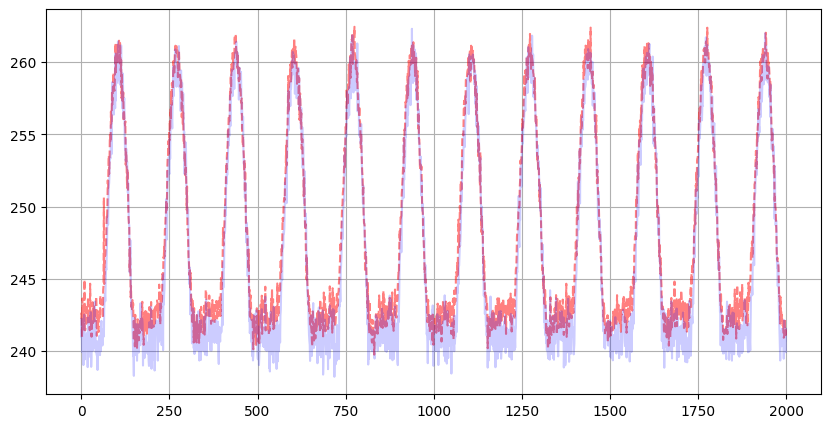

In [195]:
# a = 15* avg_norm
# v.quantizer._embedding.weight.detach()[0,5] = a
v.cpu()
rec = compare(train_data, v, n_channels, VQ=True)
v.to(device)

In [186]:
def plot_heatmap(ax_heatmap, codebook):
    ax_heatmap.clear()
    heatmap = ax_heatmap.imshow(codebook)
    ax_heatmap.set_title('Codebook Heatmap')
    ax_heatmap


    return heatmap
def create_heatmap(codebook):
    fig, ax_heatmap = plt.subplots(figsize=(12, 6), dpi=100)
    heatmap = plot_heatmap(ax_heatmap, codebook.T)
#     heatmap_canvas = FigureCanvasTkAgg(fig, master=heatmap_frame)
#     heatmap_canvas.draw()
#     heatmap_canvas.get_tk_widget().pack(fill="both", expand=True)
    cbar = fig.colorbar(heatmap)
    ax_heatmap.set_xlabel('Num of Embeddings')
    ax_heatmap.set_ylabel('Latent Dimensions')
    
    return ax_heatmap

def get_average_norm_scale(train_data, model):
    n_channels = model._n_channels
    n_batchs = x_size = len(train_data)
    
    norm = torch.empty(n_channels, 0)

    for i, (data, norm_scale) in enumerate(train_data):
        reshaped_norm = norm_scale.permute(1,0,2).flatten(1)
        norm = torch.cat((norm, reshaped_norm), 1)
        
    avg_norm = torch.mean(norm, dim=1)
    return avg_norm

def get_latent_variables(train_data, model):
    model.eval()
    
    n_channels = model._n_channels
    latent_dims = model._latent_dims
    n_batchs = x_size = len(train_data)
    
    latents = torch.empty(n_channels, latent_dims, 0, device = device)

    for i, (data, norm_scale) in enumerate(train_data):
        data = data.to(device)
        
        mu, logvar = model.encoder(data)
        z = model.reparametrization_trick(mu, logvar)
        
        reshaped_mu, reshaped_logvar, reshaped_z = (t.permute(1,2,0) for t in [mu, logvar, z])

        latents = torch.cat((latents, reshaped_z), 2)

        
    avg_latents = torch.mean(latents, dim=2)
    return latents, avg_latents

In [39]:
def sample_vae(train_data, model, n):
    model.eval()
    
    n_channels = model._n_channels
    latent_dims = model._latent_dims
#     n_batchs = x_size = len(train_data)
    x_len = len(train_data.dataset)
    L = model._L
    bs = train_data.batch_size
    
    latents = torch.empty(n_channels, latent_dims, 0, device = device)
    x_rec, mu_dec, logvar_dec = (torch.empty(0, n_channels, x_len, device = device) for _ in range(3))
    mu_enc, logvar_enc = (torch.empty(0, n_channels, latent_dims, x_len, device = device) for _ in range(2))
    
    for j in range(n):
        # create temp tensors to store data in each repetition
        x, x_rec_temp, mu_rec_temp, logvar_rec_temp = (torch.empty(n_channels, 0, device = device) for _ in range(4))
        mu_temp, logvar_temp = (torch.empty(n_channels, latent_dims, 0, device = device) for _ in range(2))
        
        for i, (batch, norm_scale) in enumerate(train_data):
            batch = batch.to(device)
            #sample from model
            rec, loss, _mu, _logvar, mu_rec, logvar_rec = model(batch)

            #reshape data -> (Channel, latent_dims, BS) or (Channel, BS)
            _mu, _logvar= (t.permute(1,2,0) for t in [_mu, _logvar])
            batch, rec, norm_scale, mu_rec, logvar_rec = (t.permute(1,0,2)[:,:,0] for t in [batch, rec, norm_scale, mu_rec, logvar_rec])
            
            # Temp store data
            mu_temp = torch.cat((mu_temp, _mu), dim=2)
            logvar_temp = torch.cat((logvar_temp, _logvar), dim=2)
            mu_rec_temp = torch.cat((mu_rec_temp, mu_rec*norm_scale), dim=1)
            logvar_rec_temp  = torch.cat((logvar_rec_temp, logvar_rec*norm_scale), dim=1)            
            x_rec_temp = torch.cat((x_rec_temp, rec*norm_scale), dim=1)
#             print(batch.shape)
#             print(norm_scale.shape)
#             print(x.shape)
            x = torch.cat((x, batch*norm_scale), dim=1)

        # Store data after each reconstruction
        x_rec = torch.cat((x_rec, x_rec_temp.unsqueeze(0)), dim=0)
        mu_dec = torch.cat((mu_dec, mu_rec_temp.unsqueeze(0)), dim=0)
        logvar_dec = torch.cat((logvar_dec, logvar_rec_temp.unsqueeze(0)), dim=0)
        mu_enc = torch.cat((mu_enc, mu_temp.unsqueeze(0)), dim=0)
        logvar_enc = torch.cat((logvar_enc, logvar_temp.unsqueeze(0)), dim=0)
        print(x.shape)

    # join repetition and Channels and get the mean
#     x_rec, mu_dec, logvar_dec = (t.view(-1, x_len)for t in [x_rec, mu_dec, logvar_dec])
    x_rec_mean, mu_enc_mean, logvar_enc_mean, mu_dec_mean, logvar_dec_mean = (torch.mean(t, dim=0) for t in [x_rec, mu_enc, logvar_enc, mu_dec, logvar_dec])
#     x_rec_mean = x_rec.mean(0)
    print(x_rec.shape)
    print(x_rec_mean.shape)
    print(mu_enc_mean.shape)
    print(mu_dec_mean.shape)
    
    return x_rec, x_rec_mean, mu_enc_mean, logvar_enc_mean, mu_dec_mean, logvar_dec_mean

In [157]:
sample_vae(train_data, v, 5)

torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([1, 3396])
torch.Size([5, 1, 3396])
torch.Size([1, 3396])
torch.Size([1, 7, 3396])
torch.Size([1, 3396])


(tensor([[[270.6336, 270.8838, 264.7929,  ..., 264.1872, 266.1580, 266.2314]],
 
         [[267.2577, 267.1277, 265.2807,  ..., 263.2624, 269.6062, 269.7383]],
 
         [[267.2337, 268.0678, 267.6342,  ..., 269.5417, 268.7584, 265.9521]],
 
         [[264.8954, 275.5269, 271.7399,  ..., 270.9635, 260.7353, 267.1324]],
 
         [[263.9909, 263.8148, 270.3807,  ..., 263.0367, 270.1438, 264.7582]]],
        grad_fn=<CatBackward0>),
 tensor([[266.8022, 269.0842, 267.9657,  ..., 266.1983, 267.0803, 266.7625]],
        grad_fn=<MeanBackward1>),
 tensor([[[ 4.8745e-05,  2.3223e-04,  1.9234e-04,  ..., -5.7731e-05,
            1.0282e-04,  7.4898e-05],
          [ 1.7370e-04,  2.2830e-04,  1.7567e-04,  ...,  7.5044e-05,
            2.1233e-04,  2.6535e-05],
          [ 1.2812e-04,  2.7792e-04,  1.7135e-04,  ...,  1.8889e-04,
            2.2300e-04,  4.6355e-05],
          ...,
          [ 2.5057e-04,  2.1517e-04,  1.7004e-04,  ...,  1.5335e-04,
            1.1291e-04,  1.6399e-04],
        

In [89]:
get_latent_variables(train_data, v)
x, params, e_params = X.parameters()

In [90]:
pprint.pprint(params)
pprint.pprint(e_params)

{'cov': array([[[1., 1., 1., ..., 1., 1., 1.]]], dtype=float32),
 'mu': array([[230., 230., 230., ..., 230., 230., 230.]], dtype=float32),
 'n': 4320,
 'nchannels': 1}
{'Channels_Coupling': {'amplitude': [], 'channels': []},
 'Noise': {'channel': [], 'index': [], 'slope': []},
 'Pulse': {'amplitude': [], 'channel': [], 'index': []},
 'Seasonality': {'amplitude': [8],
                 'channel': [0],
                 'frequency_per_week': [10.700296455459206],
                 'phaseshift': [112]},
 'Std_variation': {'amplitude': [], 'channel': [], 'interval': []},
 'Trend': {'channel': [], 'index': [], 'slope': []}}


tensor([256.0568])
[[-159.95898  -182.49208  -151.64232  -195.17941  -202.55945  -163.33601
  -104.295425 -159.62639  -807.0065    -76.34594  -146.16887   -72.33641
  -163.95462  -191.12886  -144.01044  -186.55997   -88.03514  -119.75456
  -106.40997  -194.20724  -243.72862  -168.94688  -162.80203  -185.33647
  -156.10896  -178.50697  -135.69705  -473.41626  -170.20045  -188.1007  ]]


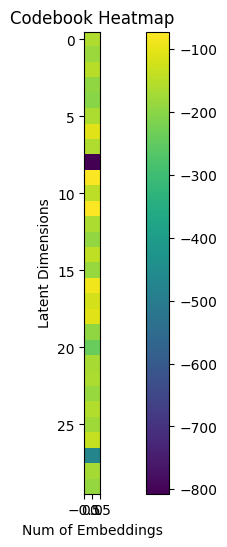

In [187]:
from matplotlib.figure import Figure
np.set_printoptions(suppress=True)
avg_norm = get_average_norm_scale(train_data, v)
print(avg_norm)
# latents, avg_latents = get_latent_variables(train_data, v)
codebook = v.quantizer._embedding.weight
heatmap = create_heatmap(codebook.cpu().detach().numpy() * avg_norm.numpy())
print((codebook.cpu().detach().numpy() * avg_norm.numpy() ))

In [120]:
def compare(dataset, model, VQ=True):
    model.eval()
    rec = []
    x = []
    T = dataset.dataset.data.shape[1]- L
    idx = 0
    _mu_rec, _logvar_rec = [], []
    _mu, _logvar = [], []
#     _mu, _logvar = (torch.empty((n_channels * 2, T, L)) for _ in range(2))
#     _mu_rec, _logvar_rec = (torch.empty((T, n_channels)) for _ in range(2))
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            bs = data.shape[0]
            if VQ:
                x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
            else:
                x_rec, mu, logvar = model(data)
            z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)
#             print(mu.shape)

            x.extend((data)[0,:,0].detach().numpy())
            rec.extend(((x_rec)[0,:,0]).detach().numpy())
            _mu_rec.extend((mu_rec)[0,:,:].detach().numpy())
            _logvar_rec.extend(((torch.exp(0.5 * logvar_rec)))[0,:,:].detach().numpy())
            
            _mu.extend((mu)[0,:,0].detach().numpy())
            _logvar.extend(((torch.exp(0.5 * logvar)))[0,:,:].detach().numpy())
#             _mu[idx: idx + bs, :, :] = mu
#             _mu_rec[idx: idx + bs, :] = (mu_rec*v)[:,:,0]
#     print(np.array(_mu).shape)
    
#     x = np.array(x).T
#     rec = np.array(rec).T
#     _mu = np.tile(np.array(_mu), (3455, 1))
#     _logvar = np.tile(np.array(_logvar), (3455, 1))
#     _mu_rec = np.tile(np.array(_mu_rec), (3455, 1))
#     _logvar_rec = np.tile(np.array(_logvar_rec), (3455, 1))
#     print(_logvar.shape)
#     print(x.shape)
#     print(rec.shape)
#     print(T)
#     print(params["cov"][0,:,:L].T)
    fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(10, 15))
    ax = axs[0]
    ax.plot(rec, "r-")
    ax.plot(x[:], "b-", alpha=0.2)
    ax.plot(_mu_rec)
    ax.plot(params["mu"].T[:_mu.shape[0],:])
    ax.grid()
    
    ax_std = axs[1]
    ax_std.plot(_logvar_rec, "r")
    ax_std.plot(params["cov"][0,:,:L].T, "b")
    ax_std.grid()
    
    ax_enc = axs[2]
    for (i,l) in enumerate(_mu.T):        
        ax_enc.plot(l.T, alpha = (0.2 + 0.1*i))
#     ax_enc.plot(_mu, alpha = 0.2)
    ax_enc.grid()
    
    ax_log = axs[3]
    for (i,l) in enumerate(_logvar.T):        
        ax_log.plot(l.T, alpha = (0.2 + 0.1*i))
    ax_log.grid()
    
    # Setting legend
    blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
    red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
    titles = ['Prediction of Train Data', 'Std plot', 'mu encoder vs mu from gen', 'logvar encoder vs cov']
    for (i,ax) in enumerate(axs):
        # ax.set_title('Reconstruction of Train Data')
        ax.set_title(titles[i])
        ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    
    
    # Axes labels
    ax_std.set_xlabel('Time')
    ax.set_ylabel('Values')
    ax_std.set_ylabel('Values')
#     plt.ylim(-100,500)
#     plt.grid(True)
    fig.tight_layout()
    plt.show()
# def compare(dataset, model, VQ=True):
#     model.eval()
#     rec = []
#     x = []
#     T = dataset.dataset.data.shape[1]- L
#     idx = 0
#     _mu_rec, _logvar_rec = [], []
#     _mu, _logvar = [], []
# #     _mu, _logvar = (torch.empty((n_channels * 2, T, L)) for _ in range(2))
# #     _mu_rec, _logvar_rec = (torch.empty((T, n_channels)) for _ in range(2))
#     with torch.no_grad():
#         for i, (data, v) in enumerate(dataset):
#             bs = data.shape[0]
#             if VQ:
#                 x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
#             else:
#                 x_rec, mu, logvar = model(data)
#             z = model.reparametrization_trick(mu, logvar)
#             print(v.shape)
#             if v.dim() == 1:
#                 v = v.unsqueeze(0)
#                 v = v.T
#                 v = v.unsqueeze(-1)
# #             print(v.shape)
# #             print(x_rec.shape)
# #             print((x_rec * v).shape)
# #             print(i)
# #             print(mu.shape)

#             x.extend((data)[:,:,:].detach().numpy())
#             rec.extend(((x_rec)[:,:,:]).detach().numpy())
# #             _mu_rec.extend((mu_rec*v)[:,:,0].detach().numpy())
# #             _logvar_rec.extend(((torch.exp(0.5 * logvar_rec))*v)[:,:,0].detach().numpy())
            
# #             _mu.extend((mu*v)[:,:,0].detach().numpy())
# #             _logvar.extend(((torch.exp(0.5 * logvar))*v)[:,:,0].detach().numpy())
# #             _mu[idx: idx + bs, :, :] = mu
# #             _mu_rec[idx: idx + bs, :] = (mu_rec*v)[:,:,0]
# #     print(np.array(rec).shape)
# #     _mu = np.array(_mu)
# #     _logvar = np.array(_logvar)
    
#     rec = np.array(rec).squeeze(0).T
#     x = np.array(x).squeeze(0).T
# #     print(x.shape)
# #     print(rec)
#     fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(10, 4))
#     ax = axs#[0]
#     ax.plot(rec, "r-")
#     ax.plot(x, "b-", alpha=0.2)
# #     ax.plot(_mu_rec)
# #     ax.plot(params["mu"].T[:_mu.shape[0],:])
#     ax.grid()
    
# #     ax_std = axs[1]
# #     ax_std.plot(_logvar_rec, "r")
# #     ax_std.plot(params["cov"][0,:,:T].T, "b")
# #     ax_std.grid()
    
# #     ax_enc = axs[2]
# #     for (i,l) in enumerate(_mu.T):        
# #         ax_enc.plot(l.T, alpha = (0.2 + 0.1*i))
# # #     ax_enc.plot(_mu, alpha = 0.2)
# #     ax_enc.grid()
    
# #     ax_log = axs[3]
# #     for (i,l) in enumerate(_logvar.T):        
# #         ax_log.plot(l.T, alpha = (0.2 + 0.1*i))
# #     ax_log.grid()
    
#     # Setting legend
#     blue_handle = plt.Line2D([], [], color='b', label='Original Data', alpha=0.2)
#     red_handle = plt.Line2D([], [], color='r', label='Reconstructions mean')
# #     for ax in axs:
#         # ax.set_title('Reconstruction of Train Data')
#     ax.set_title('Prediction of Test (unseen) Data')
#     ax.legend(handles=[blue_handle, red_handle], loc="upper right")
    
    
#     # Axes labels
# #     ax_std.set_xlabel('Time')
# #     ax.set_ylabel('Values')
# #     ax_std.set_ylabel('Values')
# #     plt.ylim(-100,500)
#     plt.grid(True)
#     fig.tight_layout()
#     plt.show()

In [25]:
from datetime import datetime

def get_duration_dates(dates):    
    reference_time = np.datetime64('2023-03-01T00:00:00')
    reference_time = datetime.strptime(reference_time.astype(str), "%Y-%m-%dT%H:%M:%S")
    durations = []
    for date in dates:
        date = datetime.strptime(date, "%Y-%m-%dT%H:%M:%S")
        duration = int((date - reference_time).total_seconds()//60)
        durations.append(duration)
    
    return durations

In [323]:
mu = torch.FloatTensor(params["mu"]).mean()
std = torch.diagonal(torch.FloatTensor(params["cov"])).mean()
labels = [mu, std]
for param in e_params["Seasonality"]:
    if param != "channel":
        labels.append(torch.FloatTensor(e_params["Seasonality"][param]))
labels = torch.FloatTensor(labels).squeeze(dim=0)

In [253]:
def extract_labels(params, e_params):
    mu = torch.FloatTensor(params["mu"]).mean()
    std = torch.diagonal(torch.FloatTensor(params["cov"])).mean()
    labels = [mu, std]
    for param in e_params["Seasonality"]:
        if param != "channel":
            labels.append(torch.FloatTensor(e_params["Seasonality"][param]))
    labels = torch.FloatTensor(labels).squeeze(dim=0)
    return labels

In [324]:
labels

tensor([141.1412,   1.0000,   7.3779,  13.0000, 169.0000])

In [207]:
# @suppress_prints
class identifier(nn.Module):
    def __init__(self, input_size, num_layers, output_size, slope):
        super(identifier, self).__init__()   
        
        self.input_size =  input_size      
        self.num_layers = num_layers
        self.output_size = output_size
        self.lin_layers = nn.ModuleList()
        self.n = 1
        
        def init_weights(m):
            if isinstance(m, nn.Linear):
                torch.nn.init.uniform_(m.weight, a=0.0, b=1.0)
                m.bias.data.fill_(0.01)
                
        # CNN Layers that double the channels each time
        for i in range(0, num_layers):
            
            if i == num_layers -1:
                self.lin_layers.append(nn.Linear(self.input_size, output_size))
                self.lin_layers.append(nn.LeakyReLU(slope, True))
                self.lin_layers.append(nn.BatchNorm1d(self.n))
                self.input_size = self.input_size // (2 ** num_layers)
            else:
                print(self.input_size, self.input_size * 2)
                self.lin_layers.append(nn.Linear(self.input_size, self.input_size * 2))
                self.lin_layers.append(nn.LeakyReLU(slope, True))
                self.lin_layers.append(nn.BatchNorm1d(self.n))
                self.input_size = self.input_size * 2
        
        self.lin_layers.apply(init_weights)
            
         
    def forward(self, x):
#         print("x input", x.shape)
        x_shape = x.shape
        x = x.view(x.size(0), -1).unsqueeze(1)
#         print("x before lin", x.shape)
        for i, lin in enumerate(self.lin_layers):
            x = lin(x)        
#         print("x after lin", x.shape)
        x = x.squeeze(1).view(x_shape[0], -1, 2)
#         print("x out", x.shape)
        return x

In [208]:
def compare(dataset, model, n_channels, VQ=True):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    data_size = train_data.dataset.data.shape[-1]
    print(data_size)
    rec = torch.empty(n_channels, 0)
    x = torch.empty(n_channels, 0)
    with torch.no_grad():
        for i, (data, v) in enumerate(dataset):
            if VQ:
                x_rec, loss, mu, logvar, mu_rec, logvar_rec = model(data)
            else:
                x_rec, mu, logvar = model(data)
#             z = model.reparametrization_trick(mu, logvar)
            if v.dim() == 1:
                v = v.unsqueeze(0)
                v = v.T
                v = v.unsqueeze(-1)
#             print(v.shape)
#             print(x_rec.shape)
#             print((x_rec * v).shape)
#             print(i)
            rec = torch.cat((rec, (x_rec*v).view(n_channels, -1)), dim=1)
            x = torch.cat((x, (data*v).view(n_channels, -1)), dim=1)
#             x.extend((data*v).view(1, -1).detach().numpy())
#             rec.extend((x_rec*v).view(1, -1).detach().numpy())
    print(rec.shape)
    print(x.shape)
    print(rec)
    fig, ax = plt.subplots(figsize=(10, 5))
    ax.plot(rec.T[:2000,:], "r--", alpha = 0.5)
    ax.plot(x.T[:2000,:], "b-", alpha=0.2)
    
# #     plt.ylim(50,600)
    ax.grid()
#     plt.show()
    
    new_train_data = DataLoader(slidingWindow(np.array(rec).T, L),
                        batch_size= 22,# 59, # 22
                        shuffle = False
                        )
    return new_train_data

In [209]:
n = n_channels * 4 * 2
id_model = identifier(input_size=n*n_channels*latent_dims, num_layers=2, output_size=labels.numel(), slope=0)
id_model = id_model.to(device)

id_opt = optim.Adam(id_model.parameters(), lr = 0.1)

240 480


In [210]:
def train_identifier(model, id_model, labels, train_loader, criterion, optimizer, device, epoch, VQ=True):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    for p in id_model.parameters():
        p.requires_grad = True
    train_loss = 0
    labels = labels.to(device)

    for batch_idx, (data, v) in enumerate(train_loader):

        data = data.to(device)
        v = v.to(device)
        optimizer.zero_grad()

        if VQ:
            x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
        else:
            #             x_rec, mu, logvar = model(data)
            x_rec, mu, logvar = sample_mean(model, data, 10)
            if v.dim() == 1:
                v = v.unsqueeze(-1)
                v = v.unsqueeze(-1)
            # x_rec_window_length = x_rec.shape[2]
            loss = criterion(x_rec * v, data[:, :, 0], mu, logvar)
        identified = id_model(e)
#         print(torch.mean(identified, dim=0).shape)
        loss = F.mse_loss(torch.mean(identified, dim=0), labels)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
        loss.backward()

        optimizer.step()
        train_loss += loss.item()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                       100. * batch_idx / len(train_loader), loss.item() / len(data)))
    print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))

    return train_loss / len(train_loader.dataset)

In [ ]:
for epoch in range(1, 10000):
    train_identifier(v, id_model, labels, train_data, criterion, id_opt, device, epoch, VQ=True)

Train Epoch: 1 [0/41 (0%)]	Loss: 6936.596037
====> Epoch: 1 Average loss: 6936.5960
Train Epoch: 2 [0/41 (0%)]	Loss: 6934.373476
====> Epoch: 2 Average loss: 6934.3735
Train Epoch: 3 [0/41 (0%)]	Loss: 6932.185213
====> Epoch: 3 Average loss: 6932.1852
Train Epoch: 4 [0/41 (0%)]	Loss: 6929.995427
====> Epoch: 4 Average loss: 6929.9954
Train Epoch: 5 [0/41 (0%)]	Loss: 6927.810976
====> Epoch: 5 Average loss: 6927.8110
Train Epoch: 6 [0/41 (0%)]	Loss: 6925.623476
====> Epoch: 6 Average loss: 6925.6235
Train Epoch: 7 [0/41 (0%)]	Loss: 6923.430640
====> Epoch: 7 Average loss: 6923.4306
Train Epoch: 8 [0/41 (0%)]	Loss: 6921.243902
====> Epoch: 8 Average loss: 6921.2439
Train Epoch: 9 [0/41 (0%)]	Loss: 6919.087652
====> Epoch: 9 Average loss: 6919.0877
Train Epoch: 10 [0/41 (0%)]	Loss: 6916.878811
====> Epoch: 10 Average loss: 6916.8788
Train Epoch: 11 [0/41 (0%)]	Loss: 6914.699695
====> Epoch: 11 Average loss: 6914.6997
Train Epoch: 12 [0/41 (0%)]	Loss: 6912.504573
====> Epoch: 12 Average lo

====> Epoch: 97 Average loss: 6727.8773
Train Epoch: 98 [0/41 (0%)]	Loss: 6725.722561
====> Epoch: 98 Average loss: 6725.7226
Train Epoch: 99 [0/41 (0%)]	Loss: 6723.571646
====> Epoch: 99 Average loss: 6723.5716
Train Epoch: 100 [0/41 (0%)]	Loss: 6721.426829
====> Epoch: 100 Average loss: 6721.4268
Train Epoch: 101 [0/41 (0%)]	Loss: 6719.257622
====> Epoch: 101 Average loss: 6719.2576
Train Epoch: 102 [0/41 (0%)]	Loss: 6717.108994
====> Epoch: 102 Average loss: 6717.1090
Train Epoch: 103 [0/41 (0%)]	Loss: 6714.947409
====> Epoch: 103 Average loss: 6714.9474
Train Epoch: 104 [0/41 (0%)]	Loss: 6712.786585
====> Epoch: 104 Average loss: 6712.7866
Train Epoch: 105 [0/41 (0%)]	Loss: 6710.666921
====> Epoch: 105 Average loss: 6710.6669
Train Epoch: 106 [0/41 (0%)]	Loss: 6708.493902
====> Epoch: 106 Average loss: 6708.4939
Train Epoch: 107 [0/41 (0%)]	Loss: 6706.354421
====> Epoch: 107 Average loss: 6706.3544
Train Epoch: 108 [0/41 (0%)]	Loss: 6704.170732
====> Epoch: 108 Average loss: 6704.1

Train Epoch: 199 [0/41 (0%)]	Loss: 6509.693598
====> Epoch: 199 Average loss: 6509.6936
Train Epoch: 200 [0/41 (0%)]	Loss: 6507.589939
====> Epoch: 200 Average loss: 6507.5899
Train Epoch: 201 [0/41 (0%)]	Loss: 6505.484756
====> Epoch: 201 Average loss: 6505.4848
Train Epoch: 202 [0/41 (0%)]	Loss: 6503.400152
====> Epoch: 202 Average loss: 6503.4002
Train Epoch: 203 [0/41 (0%)]	Loss: 6501.230945
====> Epoch: 203 Average loss: 6501.2309
Train Epoch: 204 [0/41 (0%)]	Loss: 6499.119665
====> Epoch: 204 Average loss: 6499.1197
Train Epoch: 205 [0/41 (0%)]	Loss: 6496.999238
====> Epoch: 205 Average loss: 6496.9992
Train Epoch: 206 [0/41 (0%)]	Loss: 6494.860518
====> Epoch: 206 Average loss: 6494.8605
Train Epoch: 207 [0/41 (0%)]	Loss: 6492.775915
====> Epoch: 207 Average loss: 6492.7759
Train Epoch: 208 [0/41 (0%)]	Loss: 6490.656250
====> Epoch: 208 Average loss: 6490.6562
Train Epoch: 209 [0/41 (0%)]	Loss: 6488.532774
====> Epoch: 209 Average loss: 6488.5328
Train Epoch: 210 [0/41 (0%)]	Los

====> Epoch: 302 Average loss: 6293.9520
Train Epoch: 303 [0/41 (0%)]	Loss: 6291.881860
====> Epoch: 303 Average loss: 6291.8819
Train Epoch: 304 [0/41 (0%)]	Loss: 6289.783537
====> Epoch: 304 Average loss: 6289.7835
Train Epoch: 305 [0/41 (0%)]	Loss: 6287.709223
====> Epoch: 305 Average loss: 6287.7092
Train Epoch: 306 [0/41 (0%)]	Loss: 6285.649390
====> Epoch: 306 Average loss: 6285.6494
Train Epoch: 307 [0/41 (0%)]	Loss: 6283.570884
====> Epoch: 307 Average loss: 6283.5709
Train Epoch: 308 [0/41 (0%)]	Loss: 6281.546494
====> Epoch: 308 Average loss: 6281.5465
Train Epoch: 309 [0/41 (0%)]	Loss: 6279.431021
====> Epoch: 309 Average loss: 6279.4310
Train Epoch: 310 [0/41 (0%)]	Loss: 6277.367759
====> Epoch: 310 Average loss: 6277.3678
Train Epoch: 311 [0/41 (0%)]	Loss: 6275.342988
====> Epoch: 311 Average loss: 6275.3430
Train Epoch: 312 [0/41 (0%)]	Loss: 6273.250762
====> Epoch: 312 Average loss: 6273.2508
Train Epoch: 313 [0/41 (0%)]	Loss: 6271.160823
====> Epoch: 313 Average loss: 6

Train Epoch: 404 [0/41 (0%)]	Loss: 6084.286585
====> Epoch: 404 Average loss: 6084.2866
Train Epoch: 405 [0/41 (0%)]	Loss: 6082.263338
====> Epoch: 405 Average loss: 6082.2633
Train Epoch: 406 [0/41 (0%)]	Loss: 6080.258003
====> Epoch: 406 Average loss: 6080.2580
Train Epoch: 407 [0/41 (0%)]	Loss: 6078.244665
====> Epoch: 407 Average loss: 6078.2447
Train Epoch: 408 [0/41 (0%)]	Loss: 6076.178354
====> Epoch: 408 Average loss: 6076.1784
Train Epoch: 409 [0/41 (0%)]	Loss: 6074.156250
====> Epoch: 409 Average loss: 6074.1562
Train Epoch: 410 [0/41 (0%)]	Loss: 6072.107851
====> Epoch: 410 Average loss: 6072.1079
Train Epoch: 411 [0/41 (0%)]	Loss: 6070.048018
====> Epoch: 411 Average loss: 6070.0480
Train Epoch: 412 [0/41 (0%)]	Loss: 6068.039634
====> Epoch: 412 Average loss: 6068.0396
Train Epoch: 413 [0/41 (0%)]	Loss: 6066.035823
====> Epoch: 413 Average loss: 6066.0358
Train Epoch: 414 [0/41 (0%)]	Loss: 6063.950457
====> Epoch: 414 Average loss: 6063.9505
Train Epoch: 415 [0/41 (0%)]	Los

Train Epoch: 507 [0/41 (0%)]	Loss: 5876.776296
====> Epoch: 507 Average loss: 5876.7763
Train Epoch: 508 [0/41 (0%)]	Loss: 5874.791921
====> Epoch: 508 Average loss: 5874.7919
Train Epoch: 509 [0/41 (0%)]	Loss: 5872.816311
====> Epoch: 509 Average loss: 5872.8163
Train Epoch: 510 [0/41 (0%)]	Loss: 5870.778582
====> Epoch: 510 Average loss: 5870.7786
Train Epoch: 511 [0/41 (0%)]	Loss: 5868.807165
====> Epoch: 511 Average loss: 5868.8072
Train Epoch: 512 [0/41 (0%)]	Loss: 5866.830793
====> Epoch: 512 Average loss: 5866.8308
Train Epoch: 513 [0/41 (0%)]	Loss: 5864.847561
====> Epoch: 513 Average loss: 5864.8476
Train Epoch: 514 [0/41 (0%)]	Loss: 5862.826601
====> Epoch: 514 Average loss: 5862.8266
Train Epoch: 515 [0/41 (0%)]	Loss: 5860.887576
====> Epoch: 515 Average loss: 5860.8876
Train Epoch: 516 [0/41 (0%)]	Loss: 5858.864710
====> Epoch: 516 Average loss: 5858.8647
Train Epoch: 517 [0/41 (0%)]	Loss: 5856.921875
====> Epoch: 517 Average loss: 5856.9219
Train Epoch: 518 [0/41 (0%)]	Los

Train Epoch: 607 [0/41 (0%)]	Loss: 5679.498857
====> Epoch: 607 Average loss: 5679.4989
Train Epoch: 608 [0/41 (0%)]	Loss: 5677.537729
====> Epoch: 608 Average loss: 5677.5377
Train Epoch: 609 [0/41 (0%)]	Loss: 5675.571265
====> Epoch: 609 Average loss: 5675.5713
Train Epoch: 610 [0/41 (0%)]	Loss: 5673.628430
====> Epoch: 610 Average loss: 5673.6284
Train Epoch: 611 [0/41 (0%)]	Loss: 5671.682165
====> Epoch: 611 Average loss: 5671.6822
Train Epoch: 612 [0/41 (0%)]	Loss: 5669.715320
====> Epoch: 612 Average loss: 5669.7153
Train Epoch: 613 [0/41 (0%)]	Loss: 5667.746951
====> Epoch: 613 Average loss: 5667.7470
Train Epoch: 614 [0/41 (0%)]	Loss: 5665.823933
====> Epoch: 614 Average loss: 5665.8239
Train Epoch: 615 [0/41 (0%)]	Loss: 5663.862805
====> Epoch: 615 Average loss: 5663.8628
Train Epoch: 616 [0/41 (0%)]	Loss: 5661.916540
====> Epoch: 616 Average loss: 5661.9165
Train Epoch: 617 [0/41 (0%)]	Loss: 5659.957698
====> Epoch: 617 Average loss: 5659.9577
Train Epoch: 618 [0/41 (0%)]	Los

In [78]:
labels = torch.FloatTensor(labels)
labels = torch.FloatTensor(labels)

TypeError: expected TensorOptions(dtype=float, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)) (got TensorOptions(dtype=double, device=cpu, layout=Strided, requires_grad=false (default), pinned_memory=false (default), memory_format=(nullopt)))

In [61]:
labels

tensor([[  0.0000, 266.5914],
        [  0.0000,   1.0000],
        [  0.0000,   9.0913],
        [  0.0000,   5.0000],
        [  0.0000, 113.0000]])

In [230]:
def test_identifier(model, id_model, labels, train_loader, criterion, optimizer, device, epoch, VQ=True):
    model.eval()
    for p in model.parameters():
        p.requires_grad = False
    for p in id_model.parameters():
        p.requires_grad = False
    train_loss = 0
    labels = labels.to(device)

    for batch_idx, (data, v) in enumerate(train_loader):

        data = data.to(device)
        v = v.to(device)
        optimizer.zero_grad()

        if VQ:
            x_rec, loss, mu, logvar, mu_rec, logvar_rec, e = model(data)
        else:
            #             x_rec, mu, logvar = model(data)
            x_rec, mu, logvar = sample_mean(model, data, 10)
            if v.dim() == 1:
                v = v.unsqueeze(-1)
                v = v.unsqueeze(-1)
            # x_rec_window_length = x_rec.shape[2]
            loss = criterion(x_rec * v, data[:, :, 0], mu, logvar)
        identified = id_model(e)
#         loss = F.mse_loss(torch.mean(identified, dim=0), labels)
        # print(x_rec.shape)
        # print(data[:, :, 0].shape)
#         loss.backward()

#         optimizer.step()
#         train_loss += loss.item()
#         if batch_idx % 100 == 0:
#             print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
#                 epoch, batch_idx * len(data), len(train_loader.dataset),
#                        100. * batch_idx / len(train_loader), loss.item() / len(data)))
#     print('====> Epoch: {} Average loss: {:.4f}'.format(epoch, train_loss / len(train_loader.dataset)))
    print("identified", torch.mean(identified, dim=0))

    return train_loss / len(train_loader.dataset)

In [231]:
test_identifier(v, id_model, labels, train_data, criterion, id_opt, device, epoch, VQ=True)

identified tensor([[  429.4633,   429.4633],
        [  429.4633,   429.4633],
        [  429.4633, 27732.0605],
        [  429.4633,   429.4633],
        [  429.4633,   429.4633],
        [  429.4633,   429.4633],
        [  429.4633,   429.4633]], device='cuda:0')


0.0

In [215]:
labels

tensor([[    0.0000,   261.9698],
        [    0.0000,     1.0000],
        [    0.0000, 32904.0000],
        [    0.0000,     0.0001],
        [    0.0000,    12.0808],
        [    0.0000,    19.0000],
        [    0.0000,   117.0000]])

In [16]:
# Original lists
main_list = [4, 2, 1, 3, 0]
order_list = ['b', 'c', 'a', 'd', 'f']

# Sort the main list based on the order list
sorted_list = sorted(main_list, key=lambda x: order_list.index(x))

print(sorted_list)

ValueError: 4 is not in list

In [3]:
def extract_param_per_channel(effect):
    for chanel in e_params[effect]["channel"]:
        for param in e_params[effect]:
            if param != "channel":
                labels.append(torch.FloatTensor(e_params["Seasonality"][param]))

In [13]:
def extract_labels(params, e_params):
    mu = torch.FloatTensor(params["mu"]).mean()
    std = torch.diagonal(torch.FloatTensor(params["cov"])).mean()
    labels = [mu, std]
    for param in e_params["Seasonality"]:
        if param != "channel":
            labels.append(torch.FloatTensor(e_params["Seasonality"][param]))
    print(labels)
    labels = torch.FloatTensor(labels).squeeze(dim=0)
    return labels

In [101]:
def train_on_effect_and_parameters(model, id_model, opt, id_opt, device, n_channels=1, effect='no_effect', n_samples=10, epochs_per_sample=1000):
    L = model._L
    latent_dims = model._latent_dims
    for i in range(n_samples):
        for p in model.parameters():
            p.requires_grad = True
        X, train_data, test_data, effects = generate_data(n_channels, effect, L)
        x, params, e_params = X.parameters()
        labels = extract_parameters(n_channels, e_params, effects)
        labels = add_mu_std(labels, params)

        for epoch in range(1, epochs_per_sample):
            train(model, train_data, criterion, opt, device, epoch, VQ=True)            
            
        for epoch in range(1, 200):
            train_identifier(model, id_model, labels, train_data, criterion, id_opt, device, epoch, VQ=True)
            
        test_identifier(model, id_model, labels, train_data, criterion, id_opt, device, epoch, VQ=True)
        print(labels)
#         save(x, "data", effect, n_channels, latent_dims, L, i)
#         save(params, "params", effect, n_channels, latent_dims, L, i)
#         save(e_params, "e_params", effect, n_channels, latent_dims, L, i)
#         save(model, "model", effect, n_channels, latent_dims, L, i)
    return model, X, train_data

In [106]:
model, X, train_data = train_on_effect_and_parameters(v, id_model, opt, id_opt, device, n_channels, effect="seasonality", n_samples=50, epochs_per_sample=200)

Train Epoch: 1 [0/41 (0%)]	Loss: 2.319620
====> Epoch: 1 Average loss: 2.4359
Train Epoch: 2 [0/41 (0%)]	Loss: 2.442679
====> Epoch: 2 Average loss: 2.1045
Train Epoch: 3 [0/41 (0%)]	Loss: 1.797415
====> Epoch: 3 Average loss: 1.5608
Train Epoch: 4 [0/41 (0%)]	Loss: 1.617877
====> Epoch: 4 Average loss: 1.3932
Train Epoch: 5 [0/41 (0%)]	Loss: 1.426053
====> Epoch: 5 Average loss: 1.1667
Train Epoch: 6 [0/41 (0%)]	Loss: 1.114350
====> Epoch: 6 Average loss: 1.0463
Train Epoch: 7 [0/41 (0%)]	Loss: 0.846396
====> Epoch: 7 Average loss: 0.9161
Train Epoch: 8 [0/41 (0%)]	Loss: 0.751875
====> Epoch: 8 Average loss: 0.8121
Train Epoch: 9 [0/41 (0%)]	Loss: 0.671249
====> Epoch: 9 Average loss: 0.7574
Train Epoch: 10 [0/41 (0%)]	Loss: 0.678122
====> Epoch: 10 Average loss: 0.7586
Train Epoch: 11 [0/41 (0%)]	Loss: 0.689500
====> Epoch: 11 Average loss: 0.7215
Train Epoch: 12 [0/41 (0%)]	Loss: 0.673915
====> Epoch: 12 Average loss: 0.6876
Train Epoch: 13 [0/41 (0%)]	Loss: 0.664244
====> Epoch: 13

Train Epoch: 107 [0/41 (0%)]	Loss: 0.305464
====> Epoch: 107 Average loss: 0.3001
Train Epoch: 108 [0/41 (0%)]	Loss: 0.284135
====> Epoch: 108 Average loss: 0.2830
Train Epoch: 109 [0/41 (0%)]	Loss: 0.292397
====> Epoch: 109 Average loss: 0.2911
Train Epoch: 110 [0/41 (0%)]	Loss: 0.278689
====> Epoch: 110 Average loss: 0.2822
Train Epoch: 111 [0/41 (0%)]	Loss: 0.284918
====> Epoch: 111 Average loss: 0.2956
Train Epoch: 112 [0/41 (0%)]	Loss: 0.276563
====> Epoch: 112 Average loss: 0.2724
Train Epoch: 113 [0/41 (0%)]	Loss: 0.287135
====> Epoch: 113 Average loss: 0.2899
Train Epoch: 114 [0/41 (0%)]	Loss: 0.295007
====> Epoch: 114 Average loss: 0.2870
Train Epoch: 115 [0/41 (0%)]	Loss: 0.286902
====> Epoch: 115 Average loss: 0.2887
Train Epoch: 116 [0/41 (0%)]	Loss: 0.292356
====> Epoch: 116 Average loss: 0.2907
Train Epoch: 117 [0/41 (0%)]	Loss: 0.291770
====> Epoch: 117 Average loss: 0.2942
Train Epoch: 118 [0/41 (0%)]	Loss: 0.300825
====> Epoch: 118 Average loss: 0.3004
Train Epoch: 119

====> Epoch: 11 Average loss: 45.2375
Train Epoch: 12 [0/41 (0%)]	Loss: 40.571783
====> Epoch: 12 Average loss: 42.9431
Train Epoch: 13 [0/41 (0%)]	Loss: 38.276908
====> Epoch: 13 Average loss: 40.3944
Train Epoch: 14 [0/41 (0%)]	Loss: 36.149403
====> Epoch: 14 Average loss: 38.2158
Train Epoch: 15 [0/41 (0%)]	Loss: 34.166923
====> Epoch: 15 Average loss: 36.2372
Train Epoch: 16 [0/41 (0%)]	Loss: 32.474418
====> Epoch: 16 Average loss: 34.5105
Train Epoch: 17 [0/41 (0%)]	Loss: 31.286910
====> Epoch: 17 Average loss: 33.2599
Train Epoch: 18 [0/41 (0%)]	Loss: 30.281952
====> Epoch: 18 Average loss: 32.1879
Train Epoch: 19 [0/41 (0%)]	Loss: 29.321622
====> Epoch: 19 Average loss: 31.1806
Train Epoch: 20 [0/41 (0%)]	Loss: 28.303273
====> Epoch: 20 Average loss: 30.1280
Train Epoch: 21 [0/41 (0%)]	Loss: 27.458160
====> Epoch: 21 Average loss: 29.2418
Train Epoch: 22 [0/41 (0%)]	Loss: 26.510329
====> Epoch: 22 Average loss: 28.2167
Train Epoch: 23 [0/41 (0%)]	Loss: 25.637898
====> Epoch: 23 

====> Epoch: 118 Average loss: 2.9667
Train Epoch: 119 [0/41 (0%)]	Loss: 2.722753
====> Epoch: 119 Average loss: 2.9085
Train Epoch: 120 [0/41 (0%)]	Loss: 2.688314
====> Epoch: 120 Average loss: 2.8641
Train Epoch: 121 [0/41 (0%)]	Loss: 2.634457
====> Epoch: 121 Average loss: 2.8174
Train Epoch: 122 [0/41 (0%)]	Loss: 2.594014
====> Epoch: 122 Average loss: 2.7683
Train Epoch: 123 [0/41 (0%)]	Loss: 2.558439
====> Epoch: 123 Average loss: 2.7243
Train Epoch: 124 [0/41 (0%)]	Loss: 2.508878
====> Epoch: 124 Average loss: 2.6805
Train Epoch: 125 [0/41 (0%)]	Loss: 2.472765
====> Epoch: 125 Average loss: 2.6385
Train Epoch: 126 [0/41 (0%)]	Loss: 2.433773
====> Epoch: 126 Average loss: 2.5961
Train Epoch: 127 [0/41 (0%)]	Loss: 2.392575
====> Epoch: 127 Average loss: 2.5554
Train Epoch: 128 [0/41 (0%)]	Loss: 2.347540
====> Epoch: 128 Average loss: 2.5049
Train Epoch: 129 [0/41 (0%)]	Loss: 2.326705
====> Epoch: 129 Average loss: 2.4790
Train Epoch: 130 [0/41 (0%)]	Loss: 2.284611
====> Epoch: 130

====> Epoch: 22 Average loss: 0.8379
Train Epoch: 23 [0/41 (0%)]	Loss: 0.877689
====> Epoch: 23 Average loss: 0.8126
Train Epoch: 24 [0/41 (0%)]	Loss: 0.874387
====> Epoch: 24 Average loss: 0.8213
Train Epoch: 25 [0/41 (0%)]	Loss: 0.852718
====> Epoch: 25 Average loss: 0.8104
Train Epoch: 26 [0/41 (0%)]	Loss: 0.832554
====> Epoch: 26 Average loss: 0.7571
Train Epoch: 27 [0/41 (0%)]	Loss: 0.861661
====> Epoch: 27 Average loss: 0.8129
Train Epoch: 28 [0/41 (0%)]	Loss: 0.849329
====> Epoch: 28 Average loss: 0.7647
Train Epoch: 29 [0/41 (0%)]	Loss: 0.840297
====> Epoch: 29 Average loss: 0.7810
Train Epoch: 30 [0/41 (0%)]	Loss: 0.795706
====> Epoch: 30 Average loss: 0.7380
Train Epoch: 31 [0/41 (0%)]	Loss: 0.833650
====> Epoch: 31 Average loss: 0.7653
Train Epoch: 32 [0/41 (0%)]	Loss: 0.766797
====> Epoch: 32 Average loss: 0.7059
Train Epoch: 33 [0/41 (0%)]	Loss: 0.804975
====> Epoch: 33 Average loss: 0.7331
Train Epoch: 34 [0/41 (0%)]	Loss: 0.758742
====> Epoch: 34 Average loss: 0.6949
Tra

====> Epoch: 129 Average loss: 0.4555
Train Epoch: 130 [0/41 (0%)]	Loss: 0.531399
====> Epoch: 130 Average loss: 0.4659
Train Epoch: 131 [0/41 (0%)]	Loss: 0.536569
====> Epoch: 131 Average loss: 0.4716
Train Epoch: 132 [0/41 (0%)]	Loss: 0.549700
====> Epoch: 132 Average loss: 0.4748
Train Epoch: 133 [0/41 (0%)]	Loss: 0.453871
====> Epoch: 133 Average loss: 0.4450
Train Epoch: 134 [0/41 (0%)]	Loss: 0.481679
====> Epoch: 134 Average loss: 0.4424
Train Epoch: 135 [0/41 (0%)]	Loss: 0.427035
====> Epoch: 135 Average loss: 0.4159
Train Epoch: 136 [0/41 (0%)]	Loss: 0.434471
====> Epoch: 136 Average loss: 0.4199
Train Epoch: 137 [0/41 (0%)]	Loss: 0.444237
====> Epoch: 137 Average loss: 0.4385
Train Epoch: 138 [0/41 (0%)]	Loss: 0.451018
====> Epoch: 138 Average loss: 0.4113
Train Epoch: 139 [0/41 (0%)]	Loss: 0.438736
====> Epoch: 139 Average loss: 0.4089
Train Epoch: 140 [0/41 (0%)]	Loss: 0.454596
====> Epoch: 140 Average loss: 0.4137
Train Epoch: 141 [0/41 (0%)]	Loss: 0.429486
====> Epoch: 141

====> Epoch: 38 Average loss: 3.9026
Train Epoch: 39 [0/41 (0%)]	Loss: 4.006923
====> Epoch: 39 Average loss: 3.7031
Train Epoch: 40 [0/41 (0%)]	Loss: 3.471699
====> Epoch: 40 Average loss: 3.3253
Train Epoch: 41 [0/41 (0%)]	Loss: 3.281055
====> Epoch: 41 Average loss: 3.2062
Train Epoch: 42 [0/41 (0%)]	Loss: 2.851268
====> Epoch: 42 Average loss: 2.8309
Train Epoch: 43 [0/41 (0%)]	Loss: 2.731028
====> Epoch: 43 Average loss: 2.8055
Train Epoch: 44 [0/41 (0%)]	Loss: 2.523776
====> Epoch: 44 Average loss: 2.6569
Train Epoch: 45 [0/41 (0%)]	Loss: 2.380253
====> Epoch: 45 Average loss: 2.4754
Train Epoch: 46 [0/41 (0%)]	Loss: 2.298911
====> Epoch: 46 Average loss: 2.5195
Train Epoch: 47 [0/41 (0%)]	Loss: 2.243278
====> Epoch: 47 Average loss: 2.3492
Train Epoch: 48 [0/41 (0%)]	Loss: 2.123541
====> Epoch: 48 Average loss: 2.3397
Train Epoch: 49 [0/41 (0%)]	Loss: 2.066551
====> Epoch: 49 Average loss: 2.3744
Train Epoch: 50 [0/41 (0%)]	Loss: 2.010050
====> Epoch: 50 Average loss: 2.1492
Tra

Train Epoch: 151 [0/41 (0%)]	Loss: 1.334239
====> Epoch: 151 Average loss: 1.4272
Train Epoch: 152 [0/41 (0%)]	Loss: 1.326724
====> Epoch: 152 Average loss: 1.4308
Train Epoch: 153 [0/41 (0%)]	Loss: 1.409486
====> Epoch: 153 Average loss: 1.5030
Train Epoch: 154 [0/41 (0%)]	Loss: 1.334863
====> Epoch: 154 Average loss: 1.4339
Train Epoch: 155 [0/41 (0%)]	Loss: 1.333832
====> Epoch: 155 Average loss: 1.4331
Train Epoch: 156 [0/41 (0%)]	Loss: 1.336140
====> Epoch: 156 Average loss: 1.4360
Train Epoch: 157 [0/41 (0%)]	Loss: 1.332614
====> Epoch: 157 Average loss: 1.4457
Train Epoch: 158 [0/41 (0%)]	Loss: 1.382587
====> Epoch: 158 Average loss: 1.4606
Train Epoch: 159 [0/41 (0%)]	Loss: 1.351812
====> Epoch: 159 Average loss: 1.4564
Train Epoch: 160 [0/41 (0%)]	Loss: 1.340806
====> Epoch: 160 Average loss: 1.4358
Train Epoch: 161 [0/41 (0%)]	Loss: 1.358612
====> Epoch: 161 Average loss: 1.4403
Train Epoch: 162 [0/41 (0%)]	Loss: 1.464418
====> Epoch: 162 Average loss: 1.5024
Train Epoch: 163

====> Epoch: 50 Average loss: 1.0382
Train Epoch: 51 [0/41 (0%)]	Loss: 0.938132
====> Epoch: 51 Average loss: 1.0491
Train Epoch: 52 [0/41 (0%)]	Loss: 0.928714
====> Epoch: 52 Average loss: 1.0612
Train Epoch: 53 [0/41 (0%)]	Loss: 0.957650
====> Epoch: 53 Average loss: 1.0910
Train Epoch: 54 [0/41 (0%)]	Loss: 0.965659
====> Epoch: 54 Average loss: 1.0760
Train Epoch: 55 [0/41 (0%)]	Loss: 0.944268
====> Epoch: 55 Average loss: 1.0553
Train Epoch: 56 [0/41 (0%)]	Loss: 0.892694
====> Epoch: 56 Average loss: 1.0258
Train Epoch: 57 [0/41 (0%)]	Loss: 0.899134
====> Epoch: 57 Average loss: 1.0023
Train Epoch: 58 [0/41 (0%)]	Loss: 0.900058
====> Epoch: 58 Average loss: 0.9843
Train Epoch: 59 [0/41 (0%)]	Loss: 0.886475
====> Epoch: 59 Average loss: 0.9325
Train Epoch: 60 [0/41 (0%)]	Loss: 0.796382
====> Epoch: 60 Average loss: 0.8783
Train Epoch: 61 [0/41 (0%)]	Loss: 0.788909
====> Epoch: 61 Average loss: 0.8378
Train Epoch: 62 [0/41 (0%)]	Loss: 0.757884
====> Epoch: 62 Average loss: 0.8248
Tra

====> Epoch: 154 Average loss: 0.4503
Train Epoch: 155 [0/41 (0%)]	Loss: 0.455614
====> Epoch: 155 Average loss: 0.4520
Train Epoch: 156 [0/41 (0%)]	Loss: 0.461764
====> Epoch: 156 Average loss: 0.4525
Train Epoch: 157 [0/41 (0%)]	Loss: 0.469371
====> Epoch: 157 Average loss: 0.4566
Train Epoch: 158 [0/41 (0%)]	Loss: 0.429664
====> Epoch: 158 Average loss: 0.4394
Train Epoch: 159 [0/41 (0%)]	Loss: 0.420962
====> Epoch: 159 Average loss: 0.4449
Train Epoch: 160 [0/41 (0%)]	Loss: 0.450140
====> Epoch: 160 Average loss: 0.4484
Train Epoch: 161 [0/41 (0%)]	Loss: 0.436712
====> Epoch: 161 Average loss: 0.4572
Train Epoch: 162 [0/41 (0%)]	Loss: 0.474433
====> Epoch: 162 Average loss: 0.4600
Train Epoch: 163 [0/41 (0%)]	Loss: 0.456762
====> Epoch: 163 Average loss: 0.4547
Train Epoch: 164 [0/41 (0%)]	Loss: 0.506759
====> Epoch: 164 Average loss: 0.4960
Train Epoch: 165 [0/41 (0%)]	Loss: 0.484157
====> Epoch: 165 Average loss: 0.4891
Train Epoch: 166 [0/41 (0%)]	Loss: 0.497070
====> Epoch: 166

Train Epoch: 60 [0/41 (0%)]	Loss: 0.739007
====> Epoch: 60 Average loss: 1.1571
Train Epoch: 61 [0/41 (0%)]	Loss: 0.759629
====> Epoch: 61 Average loss: 0.8338
Train Epoch: 62 [0/41 (0%)]	Loss: 0.781729
====> Epoch: 62 Average loss: 0.8165
Train Epoch: 63 [0/41 (0%)]	Loss: 0.796546
====> Epoch: 63 Average loss: 0.8441
Train Epoch: 64 [0/41 (0%)]	Loss: 0.763476
====> Epoch: 64 Average loss: 0.8017
Train Epoch: 65 [0/41 (0%)]	Loss: 0.743107
====> Epoch: 65 Average loss: 0.7926
Train Epoch: 66 [0/41 (0%)]	Loss: 0.756990
====> Epoch: 66 Average loss: 0.7951
Train Epoch: 67 [0/41 (0%)]	Loss: 0.779946
====> Epoch: 67 Average loss: 0.8330
Train Epoch: 68 [0/41 (0%)]	Loss: 0.878927
====> Epoch: 68 Average loss: 0.9826
Train Epoch: 69 [0/41 (0%)]	Loss: 0.722015
====> Epoch: 69 Average loss: 0.7796
Train Epoch: 70 [0/41 (0%)]	Loss: 0.782161
====> Epoch: 70 Average loss: 0.8293
Train Epoch: 71 [0/41 (0%)]	Loss: 0.728983
====> Epoch: 71 Average loss: 0.8432
Train Epoch: 72 [0/41 (0%)]	Loss: 0.7564

Train Epoch: 172 [0/41 (0%)]	Loss: 0.738775
====> Epoch: 172 Average loss: 0.7849
Train Epoch: 173 [0/41 (0%)]	Loss: 0.718387
====> Epoch: 173 Average loss: 0.7758
Train Epoch: 174 [0/41 (0%)]	Loss: 0.750934
====> Epoch: 174 Average loss: 0.8451
Train Epoch: 175 [0/41 (0%)]	Loss: 0.731395
====> Epoch: 175 Average loss: 0.7760
Train Epoch: 176 [0/41 (0%)]	Loss: 0.862222
====> Epoch: 176 Average loss: 0.9631
Train Epoch: 177 [0/41 (0%)]	Loss: 0.735508
====> Epoch: 177 Average loss: 0.7815
Train Epoch: 178 [0/41 (0%)]	Loss: 0.730444
====> Epoch: 178 Average loss: 0.7879
Train Epoch: 179 [0/41 (0%)]	Loss: 0.836791
====> Epoch: 179 Average loss: 0.8322
Train Epoch: 180 [0/41 (0%)]	Loss: 0.853014
====> Epoch: 180 Average loss: 0.8546
Train Epoch: 181 [0/41 (0%)]	Loss: 0.801462
====> Epoch: 181 Average loss: 0.8144
Train Epoch: 182 [0/41 (0%)]	Loss: 0.768960
====> Epoch: 182 Average loss: 0.7984
Train Epoch: 183 [0/41 (0%)]	Loss: 0.763084
====> Epoch: 183 Average loss: 0.7942
Train Epoch: 184

Train Epoch: 72 [0/41 (0%)]	Loss: 1.057669
====> Epoch: 72 Average loss: 1.0518
Train Epoch: 73 [0/41 (0%)]	Loss: 1.000247
====> Epoch: 73 Average loss: 1.0237
Train Epoch: 74 [0/41 (0%)]	Loss: 1.024387
====> Epoch: 74 Average loss: 1.0383
Train Epoch: 75 [0/41 (0%)]	Loss: 0.931417
====> Epoch: 75 Average loss: 1.0139
Train Epoch: 76 [0/41 (0%)]	Loss: 0.958396
====> Epoch: 76 Average loss: 0.9736
Train Epoch: 77 [0/41 (0%)]	Loss: 0.900571
====> Epoch: 77 Average loss: 0.9679
Train Epoch: 78 [0/41 (0%)]	Loss: 0.993146
====> Epoch: 78 Average loss: 1.0007
Train Epoch: 79 [0/41 (0%)]	Loss: 0.877585
====> Epoch: 79 Average loss: 0.9441
Train Epoch: 80 [0/41 (0%)]	Loss: 0.915213
====> Epoch: 80 Average loss: 0.9581
Train Epoch: 81 [0/41 (0%)]	Loss: 0.863430
====> Epoch: 81 Average loss: 0.9234
Train Epoch: 82 [0/41 (0%)]	Loss: 0.854373
====> Epoch: 82 Average loss: 0.8853
Train Epoch: 83 [0/41 (0%)]	Loss: 0.853953
====> Epoch: 83 Average loss: 0.9122
Train Epoch: 84 [0/41 (0%)]	Loss: 0.8695

Train Epoch: 176 [0/41 (0%)]	Loss: 0.649761
====> Epoch: 176 Average loss: 0.6322
Train Epoch: 177 [0/41 (0%)]	Loss: 0.679733
====> Epoch: 177 Average loss: 0.6545
Train Epoch: 178 [0/41 (0%)]	Loss: 0.637905
====> Epoch: 178 Average loss: 0.6258
Train Epoch: 179 [0/41 (0%)]	Loss: 0.673561
====> Epoch: 179 Average loss: 0.6401
Train Epoch: 180 [0/41 (0%)]	Loss: 0.683290
====> Epoch: 180 Average loss: 0.6485
Train Epoch: 181 [0/41 (0%)]	Loss: 0.663228
====> Epoch: 181 Average loss: 0.6574
Train Epoch: 182 [0/41 (0%)]	Loss: 0.669446
====> Epoch: 182 Average loss: 0.6483
Train Epoch: 183 [0/41 (0%)]	Loss: 0.615814
====> Epoch: 183 Average loss: 0.6342
Train Epoch: 184 [0/41 (0%)]	Loss: 0.713899
====> Epoch: 184 Average loss: 0.6781
Train Epoch: 185 [0/41 (0%)]	Loss: 0.637509
====> Epoch: 185 Average loss: 0.6448
Train Epoch: 186 [0/41 (0%)]	Loss: 0.667390
====> Epoch: 186 Average loss: 0.6709
Train Epoch: 187 [0/41 (0%)]	Loss: 0.657537
====> Epoch: 187 Average loss: 0.6512
Train Epoch: 188

Train Epoch: 84 [0/41 (0%)]	Loss: 0.258303
====> Epoch: 84 Average loss: 0.1654
Train Epoch: 85 [0/41 (0%)]	Loss: 0.093345
====> Epoch: 85 Average loss: 0.0690
Train Epoch: 86 [0/41 (0%)]	Loss: 0.174229
====> Epoch: 86 Average loss: 0.1162
Train Epoch: 87 [0/41 (0%)]	Loss: 0.436513
====> Epoch: 87 Average loss: 0.2702
Train Epoch: 88 [0/41 (0%)]	Loss: 0.110246
====> Epoch: 88 Average loss: 0.1286
Train Epoch: 89 [0/41 (0%)]	Loss: 0.083896
====> Epoch: 89 Average loss: 0.0577
Train Epoch: 90 [0/41 (0%)]	Loss: 0.076567
====> Epoch: 90 Average loss: 0.0547
Train Epoch: 91 [0/41 (0%)]	Loss: 0.062363
====> Epoch: 91 Average loss: 0.0445
Train Epoch: 92 [0/41 (0%)]	Loss: 0.343797
====> Epoch: 92 Average loss: 0.2217
Train Epoch: 93 [0/41 (0%)]	Loss: 0.168901
====> Epoch: 93 Average loss: 0.1230
Train Epoch: 94 [0/41 (0%)]	Loss: 0.301442
====> Epoch: 94 Average loss: 0.1725
Train Epoch: 95 [0/41 (0%)]	Loss: 0.313898
====> Epoch: 95 Average loss: 0.1827
Train Epoch: 96 [0/41 (0%)]	Loss: 0.2153

Train Epoch: 196 [0/41 (0%)]	Loss: 0.010321
====> Epoch: 196 Average loss: 0.1045
Train Epoch: 197 [0/41 (0%)]	Loss: 0.110554
====> Epoch: 197 Average loss: 0.0731
Train Epoch: 198 [0/41 (0%)]	Loss: 0.370774
====> Epoch: 198 Average loss: 0.2184
Train Epoch: 199 [0/41 (0%)]	Loss: 0.034803
====> Epoch: 199 Average loss: 0.0223
identified tensor([[    0.3874,    86.7736],
        [    0.1098,     0.7977],
        [    0.5567,     8.9392],
        [    0.0504,     7.4900],
        [    0.0621,    13.5974]], device='cuda:0')
tensor([[ 0.0000, 87.5454],
        [ 0.0000,  1.0000],
        [ 0.0000,  8.1845],
        [ 0.0000,  8.0000],
        [ 0.0000, 14.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 2.724164
====> Epoch: 1 Average loss: 2.5085
Train Epoch: 2 [0/41 (0%)]	Loss: 2.166192
====> Epoch: 2 Average loss: 1.7890
Train Epoch: 3 [0/41 (0%)]	Loss: 1.277273
====> Epoch: 3 Average loss: 1.1237
Train Epoch: 4 [0/41 (0%)]	Loss: 1.225413
====> Epoch: 4 Average loss: 1.0213
Train Epoch: 5 [0/41

====> Epoch: 100 Average loss: 0.2193
Train Epoch: 101 [0/41 (0%)]	Loss: 0.209988
====> Epoch: 101 Average loss: 0.2259
Train Epoch: 102 [0/41 (0%)]	Loss: 0.196403
====> Epoch: 102 Average loss: 0.2154
Train Epoch: 103 [0/41 (0%)]	Loss: 0.195814
====> Epoch: 103 Average loss: 0.2119
Train Epoch: 104 [0/41 (0%)]	Loss: 0.187887
====> Epoch: 104 Average loss: 0.2062
Train Epoch: 105 [0/41 (0%)]	Loss: 0.195672
====> Epoch: 105 Average loss: 0.2074
Train Epoch: 106 [0/41 (0%)]	Loss: 0.193787
====> Epoch: 106 Average loss: 0.2094
Train Epoch: 107 [0/41 (0%)]	Loss: 0.188248
====> Epoch: 107 Average loss: 0.2019
Train Epoch: 108 [0/41 (0%)]	Loss: 0.183694
====> Epoch: 108 Average loss: 0.1991
Train Epoch: 109 [0/41 (0%)]	Loss: 0.188414
====> Epoch: 109 Average loss: 0.1988
Train Epoch: 110 [0/41 (0%)]	Loss: 0.173262
====> Epoch: 110 Average loss: 0.1889
Train Epoch: 111 [0/41 (0%)]	Loss: 0.187045
====> Epoch: 111 Average loss: 0.2001
Train Epoch: 112 [0/41 (0%)]	Loss: 0.175663
====> Epoch: 112

====> Epoch: 8 Average loss: 246.3742
Train Epoch: 9 [0/41 (0%)]	Loss: 246.800027
====> Epoch: 9 Average loss: 244.4996
Train Epoch: 10 [0/41 (0%)]	Loss: 215.999711
====> Epoch: 10 Average loss: 225.6065
Train Epoch: 11 [0/41 (0%)]	Loss: 219.749423
====> Epoch: 11 Average loss: 223.7008
Train Epoch: 12 [0/41 (0%)]	Loss: 201.191029
====> Epoch: 12 Average loss: 211.3809
Train Epoch: 13 [0/41 (0%)]	Loss: 198.361239
====> Epoch: 13 Average loss: 208.4381
Train Epoch: 14 [0/41 (0%)]	Loss: 185.819835
====> Epoch: 14 Average loss: 197.7321
Train Epoch: 15 [0/41 (0%)]	Loss: 186.857666
====> Epoch: 15 Average loss: 196.0656
Train Epoch: 16 [0/41 (0%)]	Loss: 170.317882
====> Epoch: 16 Average loss: 184.9190
Train Epoch: 17 [0/41 (0%)]	Loss: 157.860729
====> Epoch: 17 Average loss: 175.9222
Train Epoch: 18 [0/41 (0%)]	Loss: 157.588057
====> Epoch: 18 Average loss: 173.5986
Train Epoch: 19 [0/41 (0%)]	Loss: 163.192438
====> Epoch: 19 Average loss: 174.4597
Train Epoch: 20 [0/41 (0%)]	Loss: 148.77

Train Epoch: 114 [0/41 (0%)]	Loss: 2.450552
====> Epoch: 114 Average loss: 2.6197
Train Epoch: 115 [0/41 (0%)]	Loss: 2.417656
====> Epoch: 115 Average loss: 2.5848
Train Epoch: 116 [0/41 (0%)]	Loss: 2.388271
====> Epoch: 116 Average loss: 2.5499
Train Epoch: 117 [0/41 (0%)]	Loss: 2.352104
====> Epoch: 117 Average loss: 2.5097
Train Epoch: 118 [0/41 (0%)]	Loss: 2.311890
====> Epoch: 118 Average loss: 2.4697
Train Epoch: 119 [0/41 (0%)]	Loss: 2.279943
====> Epoch: 119 Average loss: 2.4358
Train Epoch: 120 [0/41 (0%)]	Loss: 2.248444
====> Epoch: 120 Average loss: 2.4039
Train Epoch: 121 [0/41 (0%)]	Loss: 2.221794
====> Epoch: 121 Average loss: 2.3769
Train Epoch: 122 [0/41 (0%)]	Loss: 2.192543
====> Epoch: 122 Average loss: 2.3439
Train Epoch: 123 [0/41 (0%)]	Loss: 2.159178
====> Epoch: 123 Average loss: 2.3123
Train Epoch: 124 [0/41 (0%)]	Loss: 2.132953
====> Epoch: 124 Average loss: 2.2847
Train Epoch: 125 [0/41 (0%)]	Loss: 2.108826
====> Epoch: 125 Average loss: 2.2594
Train Epoch: 126

Train Epoch: 14 [0/41 (0%)]	Loss: 0.294618
====> Epoch: 14 Average loss: 0.3123
Train Epoch: 15 [0/41 (0%)]	Loss: 0.255140
====> Epoch: 15 Average loss: 0.2755
Train Epoch: 16 [0/41 (0%)]	Loss: 0.296599
====> Epoch: 16 Average loss: 0.2996
Train Epoch: 17 [0/41 (0%)]	Loss: 0.246613
====> Epoch: 17 Average loss: 0.2754
Train Epoch: 18 [0/41 (0%)]	Loss: 0.278394
====> Epoch: 18 Average loss: 0.2824
Train Epoch: 19 [0/41 (0%)]	Loss: 0.255643
====> Epoch: 19 Average loss: 0.2803
Train Epoch: 20 [0/41 (0%)]	Loss: 0.267254
====> Epoch: 20 Average loss: 0.2727
Train Epoch: 21 [0/41 (0%)]	Loss: 0.264425
====> Epoch: 21 Average loss: 0.2792
Train Epoch: 22 [0/41 (0%)]	Loss: 0.251784
====> Epoch: 22 Average loss: 0.2649
Train Epoch: 23 [0/41 (0%)]	Loss: 0.265515
====> Epoch: 23 Average loss: 0.2744
Train Epoch: 24 [0/41 (0%)]	Loss: 0.249432
====> Epoch: 24 Average loss: 0.2649
Train Epoch: 25 [0/41 (0%)]	Loss: 0.259251
====> Epoch: 25 Average loss: 0.2670
Train Epoch: 26 [0/41 (0%)]	Loss: 0.2474

Train Epoch: 119 [0/41 (0%)]	Loss: 0.175293
====> Epoch: 119 Average loss: 0.1885
Train Epoch: 120 [0/41 (0%)]	Loss: 0.177351
====> Epoch: 120 Average loss: 0.1891
Train Epoch: 121 [0/41 (0%)]	Loss: 0.174100
====> Epoch: 121 Average loss: 0.1877
Train Epoch: 122 [0/41 (0%)]	Loss: 0.177703
====> Epoch: 122 Average loss: 0.1886
Train Epoch: 123 [0/41 (0%)]	Loss: 0.176197
====> Epoch: 123 Average loss: 0.1881
Train Epoch: 124 [0/41 (0%)]	Loss: 0.176018
====> Epoch: 124 Average loss: 0.1883
Train Epoch: 125 [0/41 (0%)]	Loss: 0.177443
====> Epoch: 125 Average loss: 0.1885
Train Epoch: 126 [0/41 (0%)]	Loss: 0.172338
====> Epoch: 126 Average loss: 0.1857
Train Epoch: 127 [0/41 (0%)]	Loss: 0.173163
====> Epoch: 127 Average loss: 0.1856
Train Epoch: 128 [0/41 (0%)]	Loss: 0.172788
====> Epoch: 128 Average loss: 0.1867
Train Epoch: 129 [0/41 (0%)]	Loss: 0.176297
====> Epoch: 129 Average loss: 0.1874
Train Epoch: 130 [0/41 (0%)]	Loss: 0.170648
====> Epoch: 130 Average loss: 0.1840
Train Epoch: 131

====> Epoch: 25 Average loss: 19.7881
Train Epoch: 26 [0/41 (0%)]	Loss: 17.960369
====> Epoch: 26 Average loss: 19.0600
Train Epoch: 27 [0/41 (0%)]	Loss: 17.298227
====> Epoch: 27 Average loss: 18.3593
Train Epoch: 28 [0/41 (0%)]	Loss: 16.680453
====> Epoch: 28 Average loss: 17.7206
Train Epoch: 29 [0/41 (0%)]	Loss: 16.112830
====> Epoch: 29 Average loss: 17.1300
Train Epoch: 30 [0/41 (0%)]	Loss: 15.587001
====> Epoch: 30 Average loss: 16.5814
Train Epoch: 31 [0/41 (0%)]	Loss: 15.097923
====> Epoch: 31 Average loss: 16.0624
Train Epoch: 32 [0/41 (0%)]	Loss: 14.629716
====> Epoch: 32 Average loss: 15.5696
Train Epoch: 33 [0/41 (0%)]	Loss: 14.180756
====> Epoch: 33 Average loss: 15.0921
Train Epoch: 34 [0/41 (0%)]	Loss: 13.739306
====> Epoch: 34 Average loss: 14.6231
Train Epoch: 35 [0/41 (0%)]	Loss: 13.302955
====> Epoch: 35 Average loss: 14.1616
Train Epoch: 36 [0/41 (0%)]	Loss: 12.887673
====> Epoch: 36 Average loss: 13.7155
Train Epoch: 37 [0/41 (0%)]	Loss: 12.474530
====> Epoch: 37 

Train Epoch: 137 [0/41 (0%)]	Loss: 0.995002
====> Epoch: 137 Average loss: 1.0619
Train Epoch: 138 [0/41 (0%)]	Loss: 0.981360
====> Epoch: 138 Average loss: 1.0470
Train Epoch: 139 [0/41 (0%)]	Loss: 0.968658
====> Epoch: 139 Average loss: 1.0328
Train Epoch: 140 [0/41 (0%)]	Loss: 0.954284
====> Epoch: 140 Average loss: 1.0183
Train Epoch: 141 [0/41 (0%)]	Loss: 0.942051
====> Epoch: 141 Average loss: 1.0049
Train Epoch: 142 [0/41 (0%)]	Loss: 0.929348
====> Epoch: 142 Average loss: 0.9919
Train Epoch: 143 [0/41 (0%)]	Loss: 0.917383
====> Epoch: 143 Average loss: 0.9791
Train Epoch: 144 [0/41 (0%)]	Loss: 0.905399
====> Epoch: 144 Average loss: 0.9672
Train Epoch: 145 [0/41 (0%)]	Loss: 0.895315
====> Epoch: 145 Average loss: 0.9556
Train Epoch: 146 [0/41 (0%)]	Loss: 0.885021
====> Epoch: 146 Average loss: 0.9446
Train Epoch: 147 [0/41 (0%)]	Loss: 0.875372
====> Epoch: 147 Average loss: 0.9341
Train Epoch: 148 [0/41 (0%)]	Loss: 0.864952
====> Epoch: 148 Average loss: 0.9237
Train Epoch: 149

====> Epoch: 34 Average loss: 12.6899
Train Epoch: 35 [0/41 (0%)]	Loss: 11.955626
====> Epoch: 35 Average loss: 12.2223
Train Epoch: 36 [0/41 (0%)]	Loss: 12.301816
====> Epoch: 36 Average loss: 12.9544
Train Epoch: 37 [0/41 (0%)]	Loss: 13.496515
====> Epoch: 37 Average loss: 13.3056
Train Epoch: 38 [0/41 (0%)]	Loss: 16.164049
====> Epoch: 38 Average loss: 14.8263
Train Epoch: 39 [0/41 (0%)]	Loss: 14.918012
====> Epoch: 39 Average loss: 14.1644
Train Epoch: 40 [0/41 (0%)]	Loss: 16.308683
====> Epoch: 40 Average loss: 15.2764
Train Epoch: 41 [0/41 (0%)]	Loss: 16.404294
====> Epoch: 41 Average loss: 16.0114
Train Epoch: 42 [0/41 (0%)]	Loss: 14.753934
====> Epoch: 42 Average loss: 14.6390
Train Epoch: 43 [0/41 (0%)]	Loss: 14.101951
====> Epoch: 43 Average loss: 13.9076
Train Epoch: 44 [0/41 (0%)]	Loss: 12.763306
====> Epoch: 44 Average loss: 12.7637
Train Epoch: 45 [0/41 (0%)]	Loss: 11.687406
====> Epoch: 45 Average loss: 11.7431
Train Epoch: 46 [0/41 (0%)]	Loss: 10.284858
====> Epoch: 46 

Train Epoch: 139 [0/41 (0%)]	Loss: 2.725320
====> Epoch: 139 Average loss: 2.8910
Train Epoch: 140 [0/41 (0%)]	Loss: 3.120036
====> Epoch: 140 Average loss: 3.0411
Train Epoch: 141 [0/41 (0%)]	Loss: 2.898196
====> Epoch: 141 Average loss: 2.9451
Train Epoch: 142 [0/41 (0%)]	Loss: 2.796920
====> Epoch: 142 Average loss: 2.8552
Train Epoch: 143 [0/41 (0%)]	Loss: 2.605887
====> Epoch: 143 Average loss: 2.7717
Train Epoch: 144 [0/41 (0%)]	Loss: 2.601242
====> Epoch: 144 Average loss: 2.7277
Train Epoch: 145 [0/41 (0%)]	Loss: 2.509301
====> Epoch: 145 Average loss: 2.6461
Train Epoch: 146 [0/41 (0%)]	Loss: 2.451277
====> Epoch: 146 Average loss: 2.6523
Train Epoch: 147 [0/41 (0%)]	Loss: 2.474855
====> Epoch: 147 Average loss: 2.6409
Train Epoch: 148 [0/41 (0%)]	Loss: 2.386378
====> Epoch: 148 Average loss: 2.6064
Train Epoch: 149 [0/41 (0%)]	Loss: 2.492577
====> Epoch: 149 Average loss: 2.5747
Train Epoch: 150 [0/41 (0%)]	Loss: 2.507542
====> Epoch: 150 Average loss: 2.6340
Train Epoch: 151

====> Epoch: 48 Average loss: 2.7722
Train Epoch: 49 [0/41 (0%)]	Loss: 2.612872
====> Epoch: 49 Average loss: 2.8736
Train Epoch: 50 [0/41 (0%)]	Loss: 3.227312
====> Epoch: 50 Average loss: 3.2770
Train Epoch: 51 [0/41 (0%)]	Loss: 2.286369
====> Epoch: 51 Average loss: 2.7991
Train Epoch: 52 [0/41 (0%)]	Loss: 2.906577
====> Epoch: 52 Average loss: 2.6920
Train Epoch: 53 [0/41 (0%)]	Loss: 2.575737
====> Epoch: 53 Average loss: 3.2404
Train Epoch: 54 [0/41 (0%)]	Loss: 2.124209
====> Epoch: 54 Average loss: 2.4718
Train Epoch: 55 [0/41 (0%)]	Loss: 2.767255
====> Epoch: 55 Average loss: 3.2661
Train Epoch: 56 [0/41 (0%)]	Loss: 2.696703
====> Epoch: 56 Average loss: 2.8648
Train Epoch: 57 [0/41 (0%)]	Loss: 2.647431
====> Epoch: 57 Average loss: 2.5983
Train Epoch: 58 [0/41 (0%)]	Loss: 2.270170
====> Epoch: 58 Average loss: 2.3031
Train Epoch: 59 [0/41 (0%)]	Loss: 2.356970
====> Epoch: 59 Average loss: 2.4189
Train Epoch: 60 [0/41 (0%)]	Loss: 1.864259
====> Epoch: 60 Average loss: 2.4242
Tra

Train Epoch: 160 [0/41 (0%)]	Loss: 1.626098
====> Epoch: 160 Average loss: 1.4364
Train Epoch: 161 [0/41 (0%)]	Loss: 1.074440
====> Epoch: 161 Average loss: 1.2428
Train Epoch: 162 [0/41 (0%)]	Loss: 0.802544
====> Epoch: 162 Average loss: 1.0257
Train Epoch: 163 [0/41 (0%)]	Loss: 1.581637
====> Epoch: 163 Average loss: 1.4667
Train Epoch: 164 [0/41 (0%)]	Loss: 0.641320
====> Epoch: 164 Average loss: 1.1354
Train Epoch: 165 [0/41 (0%)]	Loss: 2.046599
====> Epoch: 165 Average loss: 1.4653
Train Epoch: 166 [0/41 (0%)]	Loss: 0.678504
====> Epoch: 166 Average loss: 0.7505
Train Epoch: 167 [0/41 (0%)]	Loss: 0.676402
====> Epoch: 167 Average loss: 0.9624
Train Epoch: 168 [0/41 (0%)]	Loss: 0.814335
====> Epoch: 168 Average loss: 0.7311
Train Epoch: 169 [0/41 (0%)]	Loss: 0.627730
====> Epoch: 169 Average loss: 0.9171
Train Epoch: 170 [0/41 (0%)]	Loss: 1.089482
====> Epoch: 170 Average loss: 1.3511
Train Epoch: 171 [0/41 (0%)]	Loss: 0.812229
====> Epoch: 171 Average loss: 1.0242
Train Epoch: 172

====> Epoch: 56 Average loss: 67.5670
Train Epoch: 57 [0/41 (0%)]	Loss: 65.742842
====> Epoch: 57 Average loss: 65.4973
Train Epoch: 58 [0/41 (0%)]	Loss: 63.483127
====> Epoch: 58 Average loss: 63.3001
Train Epoch: 59 [0/41 (0%)]	Loss: 61.155362
====> Epoch: 59 Average loss: 63.3516
Train Epoch: 60 [0/41 (0%)]	Loss: 60.386058
====> Epoch: 60 Average loss: 62.1661
Train Epoch: 61 [0/41 (0%)]	Loss: 60.616699
====> Epoch: 61 Average loss: 62.9317
Train Epoch: 62 [0/41 (0%)]	Loss: 60.238220
====> Epoch: 62 Average loss: 61.8172
Train Epoch: 63 [0/41 (0%)]	Loss: 58.384810
====> Epoch: 63 Average loss: 60.2165
Train Epoch: 64 [0/41 (0%)]	Loss: 60.165577
====> Epoch: 64 Average loss: 60.4370
Train Epoch: 65 [0/41 (0%)]	Loss: 59.082242
====> Epoch: 65 Average loss: 60.6908
Train Epoch: 66 [0/41 (0%)]	Loss: 57.579168
====> Epoch: 66 Average loss: 59.4318
Train Epoch: 67 [0/41 (0%)]	Loss: 56.925476
====> Epoch: 67 Average loss: 58.7406
Train Epoch: 68 [0/41 (0%)]	Loss: 55.500599
====> Epoch: 68 

====> Epoch: 157 Average loss: 65.2805
Train Epoch: 158 [0/41 (0%)]	Loss: 65.551841
====> Epoch: 158 Average loss: 65.9465
Train Epoch: 159 [0/41 (0%)]	Loss: 65.877131
====> Epoch: 159 Average loss: 67.8671
Train Epoch: 160 [0/41 (0%)]	Loss: 62.958313
====> Epoch: 160 Average loss: 64.7517
Train Epoch: 161 [0/41 (0%)]	Loss: 62.653121
====> Epoch: 161 Average loss: 67.8411
Train Epoch: 162 [0/41 (0%)]	Loss: 62.695801
====> Epoch: 162 Average loss: 65.2133
Train Epoch: 163 [0/41 (0%)]	Loss: 62.549289
====> Epoch: 163 Average loss: 64.3563
Train Epoch: 164 [0/41 (0%)]	Loss: 66.487516
====> Epoch: 164 Average loss: 66.3140
Train Epoch: 165 [0/41 (0%)]	Loss: 65.146717
====> Epoch: 165 Average loss: 66.7269
Train Epoch: 166 [0/41 (0%)]	Loss: 64.498347
====> Epoch: 166 Average loss: 63.8119
Train Epoch: 167 [0/41 (0%)]	Loss: 64.776034
====> Epoch: 167 Average loss: 63.1913
Train Epoch: 168 [0/41 (0%)]	Loss: 62.265020
====> Epoch: 168 Average loss: 61.2399
Train Epoch: 169 [0/41 (0%)]	Loss: 61

Train Epoch: 66 [0/41 (0%)]	Loss: 0.238561
====> Epoch: 66 Average loss: 0.2620
Train Epoch: 67 [0/41 (0%)]	Loss: 0.232006
====> Epoch: 67 Average loss: 0.2550
Train Epoch: 68 [0/41 (0%)]	Loss: 0.225652
====> Epoch: 68 Average loss: 0.2485
Train Epoch: 69 [0/41 (0%)]	Loss: 0.219518
====> Epoch: 69 Average loss: 0.2423
Train Epoch: 70 [0/41 (0%)]	Loss: 0.213681
====> Epoch: 70 Average loss: 0.2365
Train Epoch: 71 [0/41 (0%)]	Loss: 0.208086
====> Epoch: 71 Average loss: 0.2311
Train Epoch: 72 [0/41 (0%)]	Loss: 0.202785
====> Epoch: 72 Average loss: 0.2259
Train Epoch: 73 [0/41 (0%)]	Loss: 0.112427
====> Epoch: 73 Average loss: 0.1748
Train Epoch: 74 [0/41 (0%)]	Loss: 0.194927
====> Epoch: 74 Average loss: 0.2035
Train Epoch: 75 [0/41 (0%)]	Loss: 0.191713
====> Epoch: 75 Average loss: 0.2122
Train Epoch: 76 [0/41 (0%)]	Loss: 0.188175
====> Epoch: 76 Average loss: 0.2082
Train Epoch: 77 [0/41 (0%)]	Loss: 0.184601
====> Epoch: 77 Average loss: 0.2045
Train Epoch: 78 [0/41 (0%)]	Loss: 0.1810

Train Epoch: 178 [0/41 (0%)]	Loss: 0.031530
====> Epoch: 178 Average loss: 0.0646
Train Epoch: 179 [0/41 (0%)]	Loss: 0.093068
====> Epoch: 179 Average loss: 0.0972
Train Epoch: 180 [0/41 (0%)]	Loss: 0.092640
====> Epoch: 180 Average loss: 0.0968
Train Epoch: 181 [0/41 (0%)]	Loss: 0.091765
====> Epoch: 181 Average loss: 0.0963
Train Epoch: 182 [0/41 (0%)]	Loss: 0.030201
====> Epoch: 182 Average loss: 0.0630
Train Epoch: 183 [0/41 (0%)]	Loss: 0.090758
====> Epoch: 183 Average loss: 0.0950
Train Epoch: 184 [0/41 (0%)]	Loss: 0.090422
====> Epoch: 184 Average loss: 0.0946
Train Epoch: 185 [0/41 (0%)]	Loss: 0.089643
====> Epoch: 185 Average loss: 0.0942
Train Epoch: 186 [0/41 (0%)]	Loss: 0.088522
====> Epoch: 186 Average loss: 0.0937
Train Epoch: 187 [0/41 (0%)]	Loss: 0.087156
====> Epoch: 187 Average loss: 0.0931
Train Epoch: 188 [0/41 (0%)]	Loss: 0.027505
====> Epoch: 188 Average loss: 0.0610
Train Epoch: 189 [0/41 (0%)]	Loss: 0.027524
====> Epoch: 189 Average loss: 0.0602
Train Epoch: 190

====> Epoch: 78 Average loss: 7.4641
Train Epoch: 79 [0/41 (0%)]	Loss: 7.082748
====> Epoch: 79 Average loss: 7.3644
Train Epoch: 80 [0/41 (0%)]	Loss: 7.013379
====> Epoch: 80 Average loss: 7.2460
Train Epoch: 81 [0/41 (0%)]	Loss: 6.936141
====> Epoch: 81 Average loss: 7.1562
Train Epoch: 82 [0/41 (0%)]	Loss: 6.903060
====> Epoch: 82 Average loss: 7.0865
Train Epoch: 83 [0/41 (0%)]	Loss: 6.828754
====> Epoch: 83 Average loss: 7.0123
Train Epoch: 84 [0/41 (0%)]	Loss: 6.759958
====> Epoch: 84 Average loss: 6.9470
Train Epoch: 85 [0/41 (0%)]	Loss: 6.700917
====> Epoch: 85 Average loss: 6.8875
Train Epoch: 86 [0/41 (0%)]	Loss: 6.636027
====> Epoch: 86 Average loss: 6.8174
Train Epoch: 87 [0/41 (0%)]	Loss: 6.584859
====> Epoch: 87 Average loss: 6.7472
Train Epoch: 88 [0/41 (0%)]	Loss: 6.542850
====> Epoch: 88 Average loss: 6.6923
Train Epoch: 89 [0/41 (0%)]	Loss: 6.441200
====> Epoch: 89 Average loss: 6.6236
Train Epoch: 90 [0/41 (0%)]	Loss: 6.400226
====> Epoch: 90 Average loss: 6.5753
Tra

Train Epoch: 183 [0/41 (0%)]	Loss: 5.258644
====> Epoch: 183 Average loss: 5.3573
Train Epoch: 184 [0/41 (0%)]	Loss: 5.253035
====> Epoch: 184 Average loss: 5.3503
Train Epoch: 185 [0/41 (0%)]	Loss: 5.253439
====> Epoch: 185 Average loss: 5.3483
Train Epoch: 186 [0/41 (0%)]	Loss: 5.251269
====> Epoch: 186 Average loss: 5.3484
Train Epoch: 187 [0/41 (0%)]	Loss: 5.244032
====> Epoch: 187 Average loss: 5.3421
Train Epoch: 188 [0/41 (0%)]	Loss: 5.242401
====> Epoch: 188 Average loss: 5.3377
Train Epoch: 189 [0/41 (0%)]	Loss: 5.241493
====> Epoch: 189 Average loss: 5.3351
Train Epoch: 190 [0/41 (0%)]	Loss: 5.234776
====> Epoch: 190 Average loss: 5.3333
Train Epoch: 191 [0/41 (0%)]	Loss: 5.240726
====> Epoch: 191 Average loss: 5.3340
Train Epoch: 192 [0/41 (0%)]	Loss: 5.233026
====> Epoch: 192 Average loss: 5.3269
Train Epoch: 193 [0/41 (0%)]	Loss: 5.226461
====> Epoch: 193 Average loss: 5.3228
Train Epoch: 194 [0/41 (0%)]	Loss: 5.232908
====> Epoch: 194 Average loss: 5.3225
Train Epoch: 195

====> Epoch: 87 Average loss: 0.0892
Train Epoch: 88 [0/41 (0%)]	Loss: 0.075376
====> Epoch: 88 Average loss: 0.0891
Train Epoch: 89 [0/41 (0%)]	Loss: 0.075247
====> Epoch: 89 Average loss: 0.0890
Train Epoch: 90 [0/41 (0%)]	Loss: 0.075131
====> Epoch: 90 Average loss: 0.0888
Train Epoch: 91 [0/41 (0%)]	Loss: 0.075026
====> Epoch: 91 Average loss: 0.0887
Train Epoch: 92 [0/41 (0%)]	Loss: 0.074930
====> Epoch: 92 Average loss: 0.0886
Train Epoch: 93 [0/41 (0%)]	Loss: 0.074844
====> Epoch: 93 Average loss: 0.0886
Train Epoch: 94 [0/41 (0%)]	Loss: 0.074765
====> Epoch: 94 Average loss: 0.0885
Train Epoch: 95 [0/41 (0%)]	Loss: 0.074696
====> Epoch: 95 Average loss: 0.0884
Train Epoch: 96 [0/41 (0%)]	Loss: 0.074632
====> Epoch: 96 Average loss: 0.0883
Train Epoch: 97 [0/41 (0%)]	Loss: 0.074573
====> Epoch: 97 Average loss: 0.0883
Train Epoch: 98 [0/41 (0%)]	Loss: 0.074520
====> Epoch: 98 Average loss: 0.0882
Train Epoch: 99 [0/41 (0%)]	Loss: 0.074470
====> Epoch: 99 Average loss: 0.0881
Tra

identified tensor([[ 0.4199, 20.1476],
        [ 0.5216,  1.6050],
        [ 0.6324, 12.7904],
        [ 0.5241, 17.6731],
        [ 0.5132,  8.9230]], device='cuda:0')
tensor([[ 0.0000, 20.4125],
        [ 0.0000,  1.0000],
        [ 0.0000, 12.3338],
        [ 0.0000, 17.0000],
        [ 0.0000, 13.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 189.266779
====> Epoch: 1 Average loss: 139.0754
Train Epoch: 2 [0/41 (0%)]	Loss: 61.545865
====> Epoch: 2 Average loss: 60.4435
Train Epoch: 3 [0/41 (0%)]	Loss: 41.069702
====> Epoch: 3 Average loss: 26.9906
Train Epoch: 4 [0/41 (0%)]	Loss: 15.547613
====> Epoch: 4 Average loss: 21.4941
Train Epoch: 5 [0/41 (0%)]	Loss: 33.653928
====> Epoch: 5 Average loss: 28.6688
Train Epoch: 6 [0/41 (0%)]	Loss: 19.365237
====> Epoch: 6 Average loss: 19.1114
Train Epoch: 7 [0/41 (0%)]	Loss: 24.350309
====> Epoch: 7 Average loss: 23.0030
Train Epoch: 8 [0/41 (0%)]	Loss: 16.773671
====> Epoch: 8 Average loss: 13.5271
Train Epoch: 9 [0/41 (0%)]	Loss: 11.897555
====>

====> Epoch: 104 Average loss: 1.3015
Train Epoch: 105 [0/41 (0%)]	Loss: 1.471395
====> Epoch: 105 Average loss: 1.2973
Train Epoch: 106 [0/41 (0%)]	Loss: 1.470172
====> Epoch: 106 Average loss: 1.2928
Train Epoch: 107 [0/41 (0%)]	Loss: 1.463401
====> Epoch: 107 Average loss: 1.2887
Train Epoch: 108 [0/41 (0%)]	Loss: 1.456929
====> Epoch: 108 Average loss: 1.2816
Train Epoch: 109 [0/41 (0%)]	Loss: 1.455027
====> Epoch: 109 Average loss: 1.2785
Train Epoch: 110 [0/41 (0%)]	Loss: 1.449227
====> Epoch: 110 Average loss: 1.2743
Train Epoch: 111 [0/41 (0%)]	Loss: 1.444223
====> Epoch: 111 Average loss: 1.2685
Train Epoch: 112 [0/41 (0%)]	Loss: 1.442246
====> Epoch: 112 Average loss: 1.2648
Train Epoch: 113 [0/41 (0%)]	Loss: 1.430792
====> Epoch: 113 Average loss: 1.2581
Train Epoch: 114 [0/41 (0%)]	Loss: 1.432056
====> Epoch: 114 Average loss: 1.2557
Train Epoch: 115 [0/41 (0%)]	Loss: 1.425164
====> Epoch: 115 Average loss: 1.2512
Train Epoch: 116 [0/41 (0%)]	Loss: 1.419595
====> Epoch: 116

====> Epoch: 6 Average loss: 56.4218
Train Epoch: 7 [0/41 (0%)]	Loss: 67.787792
====> Epoch: 7 Average loss: 49.1650
Train Epoch: 8 [0/41 (0%)]	Loss: 58.763578
====> Epoch: 8 Average loss: 42.4065
Train Epoch: 9 [0/41 (0%)]	Loss: 50.391535
====> Epoch: 9 Average loss: 36.3636
Train Epoch: 10 [0/41 (0%)]	Loss: 42.875125
====> Epoch: 10 Average loss: 31.1039
Train Epoch: 11 [0/41 (0%)]	Loss: 36.266682
====> Epoch: 11 Average loss: 26.5706
Train Epoch: 12 [0/41 (0%)]	Loss: 30.555983
====> Epoch: 12 Average loss: 22.6772
Train Epoch: 13 [0/41 (0%)]	Loss: 25.608387
====> Epoch: 13 Average loss: 19.2950
Train Epoch: 14 [0/41 (0%)]	Loss: 21.340139
====> Epoch: 14 Average loss: 16.3389
Train Epoch: 15 [0/41 (0%)]	Loss: 17.685329
====> Epoch: 15 Average loss: 13.7558
Train Epoch: 16 [0/41 (0%)]	Loss: 14.583857
====> Epoch: 16 Average loss: 11.5122
Train Epoch: 17 [0/41 (0%)]	Loss: 11.982419
====> Epoch: 17 Average loss: 9.5923
Train Epoch: 18 [0/41 (0%)]	Loss: 9.850715
====> Epoch: 18 Average l

Train Epoch: 112 [0/41 (0%)]	Loss: 0.991860
====> Epoch: 112 Average loss: 1.0844
Train Epoch: 113 [0/41 (0%)]	Loss: 0.981664
====> Epoch: 113 Average loss: 1.0747
Train Epoch: 114 [0/41 (0%)]	Loss: 0.971434
====> Epoch: 114 Average loss: 1.0652
Train Epoch: 115 [0/41 (0%)]	Loss: 0.961280
====> Epoch: 115 Average loss: 1.0556
Train Epoch: 116 [0/41 (0%)]	Loss: 0.951277
====> Epoch: 116 Average loss: 1.0462
Train Epoch: 117 [0/41 (0%)]	Loss: 0.941476
====> Epoch: 117 Average loss: 1.0369
Train Epoch: 118 [0/41 (0%)]	Loss: 0.931925
====> Epoch: 118 Average loss: 1.0276
Train Epoch: 119 [0/41 (0%)]	Loss: 0.922618
====> Epoch: 119 Average loss: 1.0185
Train Epoch: 120 [0/41 (0%)]	Loss: 0.913554
====> Epoch: 120 Average loss: 1.0095
Train Epoch: 121 [0/41 (0%)]	Loss: 0.904721
====> Epoch: 121 Average loss: 1.0006
Train Epoch: 122 [0/41 (0%)]	Loss: 0.896108
====> Epoch: 122 Average loss: 0.9919
Train Epoch: 123 [0/41 (0%)]	Loss: 0.887703
====> Epoch: 123 Average loss: 0.9833
Train Epoch: 124

====> Epoch: 12 Average loss: 1.8667
Train Epoch: 13 [0/41 (0%)]	Loss: 1.752500
====> Epoch: 13 Average loss: 1.7625
Train Epoch: 14 [0/41 (0%)]	Loss: 1.652769
====> Epoch: 14 Average loss: 1.6655
Train Epoch: 15 [0/41 (0%)]	Loss: 1.558260
====> Epoch: 15 Average loss: 1.5757
Train Epoch: 16 [0/41 (0%)]	Loss: 1.498039
====> Epoch: 16 Average loss: 1.4903
Train Epoch: 17 [0/41 (0%)]	Loss: 1.443525
====> Epoch: 17 Average loss: 1.4394
Train Epoch: 18 [0/41 (0%)]	Loss: 1.400428
====> Epoch: 18 Average loss: 1.3910
Train Epoch: 19 [0/41 (0%)]	Loss: 1.360100
====> Epoch: 19 Average loss: 1.3544
Train Epoch: 20 [0/41 (0%)]	Loss: 1.320117
====> Epoch: 20 Average loss: 1.3147
Train Epoch: 21 [0/41 (0%)]	Loss: 1.289183
====> Epoch: 21 Average loss: 1.2878
Train Epoch: 22 [0/41 (0%)]	Loss: 1.273154
====> Epoch: 22 Average loss: 1.2581
Train Epoch: 23 [0/41 (0%)]	Loss: 1.242609
====> Epoch: 23 Average loss: 1.2274
Train Epoch: 24 [0/41 (0%)]	Loss: 1.220105
====> Epoch: 24 Average loss: 1.1888
Tra

====> Epoch: 116 Average loss: 0.5672
Train Epoch: 117 [0/41 (0%)]	Loss: 0.563442
====> Epoch: 117 Average loss: 0.5668
Train Epoch: 118 [0/41 (0%)]	Loss: 0.552936
====> Epoch: 118 Average loss: 0.5600
Train Epoch: 119 [0/41 (0%)]	Loss: 0.555476
====> Epoch: 119 Average loss: 0.5603
Train Epoch: 120 [0/41 (0%)]	Loss: 0.549507
====> Epoch: 120 Average loss: 0.5562
Train Epoch: 121 [0/41 (0%)]	Loss: 0.552585
====> Epoch: 121 Average loss: 0.5567
Train Epoch: 122 [0/41 (0%)]	Loss: 0.548858
====> Epoch: 122 Average loss: 0.5542
Train Epoch: 123 [0/41 (0%)]	Loss: 0.546577
====> Epoch: 123 Average loss: 0.5516
Train Epoch: 124 [0/41 (0%)]	Loss: 0.540454
====> Epoch: 124 Average loss: 0.5466
Train Epoch: 125 [0/41 (0%)]	Loss: 0.542925
====> Epoch: 125 Average loss: 0.5458
Train Epoch: 126 [0/41 (0%)]	Loss: 0.540874
====> Epoch: 126 Average loss: 0.5444
Train Epoch: 127 [0/41 (0%)]	Loss: 0.532962
====> Epoch: 127 Average loss: 0.5385
Train Epoch: 128 [0/41 (0%)]	Loss: 0.531621
====> Epoch: 128

====> Epoch: 23 Average loss: 104.1269
Train Epoch: 24 [0/41 (0%)]	Loss: 87.876637
====> Epoch: 24 Average loss: 99.8108
Train Epoch: 25 [0/41 (0%)]	Loss: 83.975525
====> Epoch: 25 Average loss: 98.0137
Train Epoch: 26 [0/41 (0%)]	Loss: 80.300559
====> Epoch: 26 Average loss: 91.9917
Train Epoch: 27 [0/41 (0%)]	Loss: 76.844560
====> Epoch: 27 Average loss: 90.3031
Train Epoch: 28 [0/41 (0%)]	Loss: 73.597695
====> Epoch: 28 Average loss: 86.8673
Train Epoch: 29 [0/41 (0%)]	Loss: 70.544262
====> Epoch: 29 Average loss: 83.4436
Train Epoch: 30 [0/41 (0%)]	Loss: 67.671276
====> Epoch: 30 Average loss: 80.3005
Train Epoch: 31 [0/41 (0%)]	Loss: 64.966098
====> Epoch: 31 Average loss: 75.7674
Train Epoch: 32 [0/41 (0%)]	Loss: 62.430925
====> Epoch: 32 Average loss: 74.5505
Train Epoch: 33 [0/41 (0%)]	Loss: 60.051053
====> Epoch: 33 Average loss: 72.0382
Train Epoch: 34 [0/41 (0%)]	Loss: 57.805697
====> Epoch: 34 Average loss: 68.2508
Train Epoch: 35 [0/41 (0%)]	Loss: 55.690862
====> Epoch: 35

Train Epoch: 128 [0/41 (0%)]	Loss: 1.065797
====> Epoch: 128 Average loss: 1.1427
Train Epoch: 129 [0/41 (0%)]	Loss: 1.065077
====> Epoch: 129 Average loss: 1.1419
Train Epoch: 130 [0/41 (0%)]	Loss: 1.064193
====> Epoch: 130 Average loss: 1.1411
Train Epoch: 131 [0/41 (0%)]	Loss: 1.063310
====> Epoch: 131 Average loss: 1.1400
Train Epoch: 132 [0/41 (0%)]	Loss: 1.060587
====> Epoch: 132 Average loss: 1.1390
Train Epoch: 133 [0/41 (0%)]	Loss: 1.061818
====> Epoch: 133 Average loss: 1.1386
Train Epoch: 134 [0/41 (0%)]	Loss: 1.061188
====> Epoch: 134 Average loss: 1.1407
Train Epoch: 135 [0/41 (0%)]	Loss: 1.060607
====> Epoch: 135 Average loss: 1.1403
Train Epoch: 136 [0/41 (0%)]	Loss: 1.060148
====> Epoch: 136 Average loss: 1.1384
Train Epoch: 137 [0/41 (0%)]	Loss: 1.059774
====> Epoch: 137 Average loss: 1.1367
Train Epoch: 138 [0/41 (0%)]	Loss: 1.059396
====> Epoch: 138 Average loss: 1.1394
Train Epoch: 139 [0/41 (0%)]	Loss: 1.059043
====> Epoch: 139 Average loss: 1.1391
Train Epoch: 140

====> Epoch: 29 Average loss: 5.5097
Train Epoch: 30 [0/41 (0%)]	Loss: 5.555818
====> Epoch: 30 Average loss: 5.4999
Train Epoch: 31 [0/41 (0%)]	Loss: 5.492916
====> Epoch: 31 Average loss: 5.4216
Train Epoch: 32 [0/41 (0%)]	Loss: 5.434274
====> Epoch: 32 Average loss: 5.3728
Train Epoch: 33 [0/41 (0%)]	Loss: 5.362181
====> Epoch: 33 Average loss: 5.2933
Train Epoch: 34 [0/41 (0%)]	Loss: 5.296918
====> Epoch: 34 Average loss: 5.2533
Train Epoch: 35 [0/41 (0%)]	Loss: 5.221609
====> Epoch: 35 Average loss: 5.2102
Train Epoch: 36 [0/41 (0%)]	Loss: 5.224825
====> Epoch: 36 Average loss: 5.1759
Train Epoch: 37 [0/41 (0%)]	Loss: 5.184901
====> Epoch: 37 Average loss: 5.1506
Train Epoch: 38 [0/41 (0%)]	Loss: 5.183376
====> Epoch: 38 Average loss: 5.1353
Train Epoch: 39 [0/41 (0%)]	Loss: 5.131433
====> Epoch: 39 Average loss: 5.1184
Train Epoch: 40 [0/41 (0%)]	Loss: 5.123504
====> Epoch: 40 Average loss: 5.0709
Train Epoch: 41 [0/41 (0%)]	Loss: 5.088043
====> Epoch: 41 Average loss: 5.0407
Tra

====> Epoch: 134 Average loss: 3.0654
Train Epoch: 135 [0/41 (0%)]	Loss: 2.946138
====> Epoch: 135 Average loss: 3.0873
Train Epoch: 136 [0/41 (0%)]	Loss: 2.755289
====> Epoch: 136 Average loss: 2.9692
Train Epoch: 137 [0/41 (0%)]	Loss: 2.753819
====> Epoch: 137 Average loss: 2.9678
Train Epoch: 138 [0/41 (0%)]	Loss: 2.690081
====> Epoch: 138 Average loss: 2.9372
Train Epoch: 139 [0/41 (0%)]	Loss: 2.682861
====> Epoch: 139 Average loss: 2.9350
Train Epoch: 140 [0/41 (0%)]	Loss: 2.680968
====> Epoch: 140 Average loss: 2.9321
Train Epoch: 141 [0/41 (0%)]	Loss: 2.618969
====> Epoch: 141 Average loss: 2.8892
Train Epoch: 142 [0/41 (0%)]	Loss: 2.679344
====> Epoch: 142 Average loss: 2.9192
Train Epoch: 143 [0/41 (0%)]	Loss: 2.687342
====> Epoch: 143 Average loss: 2.9185
Train Epoch: 144 [0/41 (0%)]	Loss: 2.706702
====> Epoch: 144 Average loss: 2.8348
Train Epoch: 145 [0/41 (0%)]	Loss: 2.643892
====> Epoch: 145 Average loss: 2.8030
Train Epoch: 146 [0/41 (0%)]	Loss: 2.565125
====> Epoch: 146

Train Epoch: 40 [0/41 (0%)]	Loss: 3.101989
====> Epoch: 40 Average loss: 3.4359
Train Epoch: 41 [0/41 (0%)]	Loss: 2.872805
====> Epoch: 41 Average loss: 3.1964
Train Epoch: 42 [0/41 (0%)]	Loss: 2.669131
====> Epoch: 42 Average loss: 2.9350
Train Epoch: 43 [0/41 (0%)]	Loss: 2.438440
====> Epoch: 43 Average loss: 2.7589
Train Epoch: 44 [0/41 (0%)]	Loss: 2.321937
====> Epoch: 44 Average loss: 2.6070
Train Epoch: 45 [0/41 (0%)]	Loss: 2.174468
====> Epoch: 45 Average loss: 2.4457
Train Epoch: 46 [0/41 (0%)]	Loss: 2.071108
====> Epoch: 46 Average loss: 2.3153
Train Epoch: 47 [0/41 (0%)]	Loss: 1.920756
====> Epoch: 47 Average loss: 2.1660
Train Epoch: 48 [0/41 (0%)]	Loss: 1.811029
====> Epoch: 48 Average loss: 2.0443
Train Epoch: 49 [0/41 (0%)]	Loss: 1.711039
====> Epoch: 49 Average loss: 1.9330
Train Epoch: 50 [0/41 (0%)]	Loss: 1.586743
====> Epoch: 50 Average loss: 1.8134
Train Epoch: 51 [0/41 (0%)]	Loss: 1.536089
====> Epoch: 51 Average loss: 1.7379
Train Epoch: 52 [0/41 (0%)]	Loss: 1.4592

====> Epoch: 152 Average loss: 0.5517
Train Epoch: 153 [0/41 (0%)]	Loss: 0.460729
====> Epoch: 153 Average loss: 0.5502
Train Epoch: 154 [0/41 (0%)]	Loss: 0.456778
====> Epoch: 154 Average loss: 0.5474
Train Epoch: 155 [0/41 (0%)]	Loss: 0.455726
====> Epoch: 155 Average loss: 0.5458
Train Epoch: 156 [0/41 (0%)]	Loss: 0.455108
====> Epoch: 156 Average loss: 0.5442
Train Epoch: 157 [0/41 (0%)]	Loss: 0.454807
====> Epoch: 157 Average loss: 0.5021
Train Epoch: 158 [0/41 (0%)]	Loss: 0.456651
====> Epoch: 158 Average loss: 0.5428
Train Epoch: 159 [0/41 (0%)]	Loss: 0.452782
====> Epoch: 159 Average loss: 0.5398
Train Epoch: 160 [0/41 (0%)]	Loss: 0.454624
====> Epoch: 160 Average loss: 0.5397
Train Epoch: 161 [0/41 (0%)]	Loss: 0.453941
====> Epoch: 161 Average loss: 0.5382
Train Epoch: 162 [0/41 (0%)]	Loss: 0.453336
====> Epoch: 162 Average loss: 0.5368
Train Epoch: 163 [0/41 (0%)]	Loss: 0.452774
====> Epoch: 163 Average loss: 0.4957
Train Epoch: 164 [0/41 (0%)]	Loss: 0.451497
====> Epoch: 164

Train Epoch: 51 [0/41 (0%)]	Loss: 0.389271
====> Epoch: 51 Average loss: 0.4217
Train Epoch: 52 [0/41 (0%)]	Loss: 0.387772
====> Epoch: 52 Average loss: 0.4176
Train Epoch: 53 [0/41 (0%)]	Loss: 0.375943
====> Epoch: 53 Average loss: 0.4027
Train Epoch: 54 [0/41 (0%)]	Loss: 0.369714
====> Epoch: 54 Average loss: 0.3958
Train Epoch: 55 [0/41 (0%)]	Loss: 0.372936
====> Epoch: 55 Average loss: 0.3964
Train Epoch: 56 [0/41 (0%)]	Loss: 0.360934
====> Epoch: 56 Average loss: 0.3818
Train Epoch: 57 [0/41 (0%)]	Loss: 0.360956
====> Epoch: 57 Average loss: 0.3808
Train Epoch: 58 [0/41 (0%)]	Loss: 0.358744
====> Epoch: 58 Average loss: 0.3778
Train Epoch: 59 [0/41 (0%)]	Loss: 0.351880
====> Epoch: 59 Average loss: 0.3728
Train Epoch: 60 [0/41 (0%)]	Loss: 0.350212
====> Epoch: 60 Average loss: 0.3699
Train Epoch: 61 [0/41 (0%)]	Loss: 0.346800
====> Epoch: 61 Average loss: 0.3664
Train Epoch: 62 [0/41 (0%)]	Loss: 0.342520
====> Epoch: 62 Average loss: 0.3626
Train Epoch: 63 [0/41 (0%)]	Loss: 0.3364

Train Epoch: 155 [0/41 (0%)]	Loss: 0.226587
====> Epoch: 155 Average loss: 0.2402
Train Epoch: 156 [0/41 (0%)]	Loss: 0.225534
====> Epoch: 156 Average loss: 0.2370
Train Epoch: 157 [0/41 (0%)]	Loss: 0.225536
====> Epoch: 157 Average loss: 0.2386
Train Epoch: 158 [0/41 (0%)]	Loss: 0.230675
====> Epoch: 158 Average loss: 0.2407
Train Epoch: 159 [0/41 (0%)]	Loss: 0.229152
====> Epoch: 159 Average loss: 0.2393
Train Epoch: 160 [0/41 (0%)]	Loss: 0.227434
====> Epoch: 160 Average loss: 0.2387
Train Epoch: 161 [0/41 (0%)]	Loss: 0.229003
====> Epoch: 161 Average loss: 0.2388
Train Epoch: 162 [0/41 (0%)]	Loss: 0.227198
====> Epoch: 162 Average loss: 0.2379
Train Epoch: 163 [0/41 (0%)]	Loss: 0.226323
====> Epoch: 163 Average loss: 0.2369
Train Epoch: 164 [0/41 (0%)]	Loss: 0.226256
====> Epoch: 164 Average loss: 0.2366
Train Epoch: 165 [0/41 (0%)]	Loss: 0.220298
====> Epoch: 165 Average loss: 0.2327
Train Epoch: 166 [0/41 (0%)]	Loss: 0.225687
====> Epoch: 166 Average loss: 0.2355
Train Epoch: 167

Train Epoch: 60 [0/41 (0%)]	Loss: 5.418031
====> Epoch: 60 Average loss: 9.1564
Train Epoch: 61 [0/41 (0%)]	Loss: 4.056768
====> Epoch: 61 Average loss: 8.2177
Train Epoch: 62 [0/41 (0%)]	Loss: 4.963274
====> Epoch: 62 Average loss: 7.5233
Train Epoch: 63 [0/41 (0%)]	Loss: 4.751370
====> Epoch: 63 Average loss: 8.1912
Train Epoch: 64 [0/41 (0%)]	Loss: 4.521074
====> Epoch: 64 Average loss: 7.8741
Train Epoch: 65 [0/41 (0%)]	Loss: 3.233963
====> Epoch: 65 Average loss: 6.9900
Train Epoch: 66 [0/41 (0%)]	Loss: 4.564633
====> Epoch: 66 Average loss: 7.5144
Train Epoch: 67 [0/41 (0%)]	Loss: 2.873794
====> Epoch: 67 Average loss: 6.4223
Train Epoch: 68 [0/41 (0%)]	Loss: 3.665599
====> Epoch: 68 Average loss: 7.5646
Train Epoch: 69 [0/41 (0%)]	Loss: 2.545832
====> Epoch: 69 Average loss: 5.8914
Train Epoch: 70 [0/41 (0%)]	Loss: 2.393609
====> Epoch: 70 Average loss: 5.6419
Train Epoch: 71 [0/41 (0%)]	Loss: 3.109275
====> Epoch: 71 Average loss: 5.8646
Train Epoch: 72 [0/41 (0%)]	Loss: 2.9415

Train Epoch: 171 [0/41 (0%)]	Loss: 0.207776
====> Epoch: 171 Average loss: 0.2439
Train Epoch: 172 [0/41 (0%)]	Loss: 0.105106
====> Epoch: 172 Average loss: 0.0999
Train Epoch: 173 [0/41 (0%)]	Loss: 0.208507
====> Epoch: 173 Average loss: 0.2429
Train Epoch: 174 [0/41 (0%)]	Loss: 0.106755
====> Epoch: 174 Average loss: 0.0995
Train Epoch: 175 [0/41 (0%)]	Loss: 0.211990
====> Epoch: 175 Average loss: 0.1554
Train Epoch: 176 [0/41 (0%)]	Loss: 0.212326
====> Epoch: 176 Average loss: 0.1557
Train Epoch: 177 [0/41 (0%)]	Loss: 0.107746
====> Epoch: 177 Average loss: 0.1000
Train Epoch: 178 [0/41 (0%)]	Loss: 0.209828
====> Epoch: 178 Average loss: 0.1554
Train Epoch: 179 [0/41 (0%)]	Loss: 0.105099
====> Epoch: 179 Average loss: 0.1414
Train Epoch: 180 [0/41 (0%)]	Loss: 0.206267
====> Epoch: 180 Average loss: 0.1545
Train Epoch: 181 [0/41 (0%)]	Loss: 0.103226
====> Epoch: 181 Average loss: 0.0997
Train Epoch: 182 [0/41 (0%)]	Loss: 0.102409
====> Epoch: 182 Average loss: 0.0778
Train Epoch: 183

Train Epoch: 72 [0/41 (0%)]	Loss: 0.246761
====> Epoch: 72 Average loss: 0.2564
Train Epoch: 73 [0/41 (0%)]	Loss: 0.244368
====> Epoch: 73 Average loss: 0.2513
Train Epoch: 74 [0/41 (0%)]	Loss: 0.242868
====> Epoch: 74 Average loss: 0.2542
Train Epoch: 75 [0/41 (0%)]	Loss: 0.241822
====> Epoch: 75 Average loss: 0.2486
Train Epoch: 76 [0/41 (0%)]	Loss: 0.239930
====> Epoch: 76 Average loss: 0.2518
Train Epoch: 77 [0/41 (0%)]	Loss: 0.238182
====> Epoch: 77 Average loss: 0.2458
Train Epoch: 78 [0/41 (0%)]	Loss: 0.238099
====> Epoch: 78 Average loss: 0.2486
Train Epoch: 79 [0/41 (0%)]	Loss: 0.236043
====> Epoch: 79 Average loss: 0.2471
Train Epoch: 80 [0/41 (0%)]	Loss: 0.235973
====> Epoch: 80 Average loss: 0.2466
Train Epoch: 81 [0/41 (0%)]	Loss: 0.233154
====> Epoch: 81 Average loss: 0.2458
Train Epoch: 82 [0/41 (0%)]	Loss: 0.233004
====> Epoch: 82 Average loss: 0.2424
Train Epoch: 83 [0/41 (0%)]	Loss: 0.231004
====> Epoch: 83 Average loss: 0.2428
Train Epoch: 84 [0/41 (0%)]	Loss: 0.2302

====> Epoch: 176 Average loss: 0.1826
Train Epoch: 177 [0/41 (0%)]	Loss: 0.172916
====> Epoch: 177 Average loss: 0.1816
Train Epoch: 178 [0/41 (0%)]	Loss: 0.174436
====> Epoch: 178 Average loss: 0.1822
Train Epoch: 179 [0/41 (0%)]	Loss: 0.174475
====> Epoch: 179 Average loss: 0.1803
Train Epoch: 180 [0/41 (0%)]	Loss: 0.175152
====> Epoch: 180 Average loss: 0.1823
Train Epoch: 181 [0/41 (0%)]	Loss: 0.171622
====> Epoch: 181 Average loss: 0.1798
Train Epoch: 182 [0/41 (0%)]	Loss: 0.174357
====> Epoch: 182 Average loss: 0.1809
Train Epoch: 183 [0/41 (0%)]	Loss: 0.173266
====> Epoch: 183 Average loss: 0.1798
Train Epoch: 184 [0/41 (0%)]	Loss: 0.173262
====> Epoch: 184 Average loss: 0.1802
Train Epoch: 185 [0/41 (0%)]	Loss: 0.173593
====> Epoch: 185 Average loss: 0.1796
Train Epoch: 186 [0/41 (0%)]	Loss: 0.170857
====> Epoch: 186 Average loss: 0.1781
Train Epoch: 187 [0/41 (0%)]	Loss: 0.171614
====> Epoch: 187 Average loss: 0.1793
Train Epoch: 188 [0/41 (0%)]	Loss: 0.170843
====> Epoch: 188

Train Epoch: 85 [0/41 (0%)]	Loss: 0.018499
====> Epoch: 85 Average loss: 0.0227
Train Epoch: 86 [0/41 (0%)]	Loss: 0.018056
====> Epoch: 86 Average loss: 0.0232
Train Epoch: 87 [0/41 (0%)]	Loss: 0.017681
====> Epoch: 87 Average loss: 0.0218
Train Epoch: 88 [0/41 (0%)]	Loss: 0.017363
====> Epoch: 88 Average loss: 0.0188
Train Epoch: 89 [0/41 (0%)]	Loss: 0.017071
====> Epoch: 89 Average loss: 0.0184
Train Epoch: 90 [0/41 (0%)]	Loss: 0.016786
====> Epoch: 90 Average loss: 0.0181
Train Epoch: 91 [0/41 (0%)]	Loss: 0.016510
====> Epoch: 91 Average loss: 0.0206
Train Epoch: 92 [0/41 (0%)]	Loss: 0.016262
====> Epoch: 92 Average loss: 0.0176
Train Epoch: 93 [0/41 (0%)]	Loss: 0.016036
====> Epoch: 93 Average loss: 0.0174
Train Epoch: 94 [0/41 (0%)]	Loss: 0.015814
====> Epoch: 94 Average loss: 0.0198
Train Epoch: 95 [0/41 (0%)]	Loss: 0.015617
====> Epoch: 95 Average loss: 0.0169
Train Epoch: 96 [0/41 (0%)]	Loss: 0.015437
====> Epoch: 96 Average loss: 0.0167
Train Epoch: 97 [0/41 (0%)]	Loss: 0.0152

====> Epoch: 197 Average loss: 0.0143
Train Epoch: 198 [0/41 (0%)]	Loss: 0.012995
====> Epoch: 198 Average loss: 0.0143
Train Epoch: 199 [0/41 (0%)]	Loss: 0.013022
====> Epoch: 199 Average loss: 0.0143
identified tensor([[    -0.0313,    397.9200],
        [    -0.0313,     -0.0313],
        [    -0.0313,     10.7047],
        [    -0.0313,      7.9134],
        [    -0.0313,    154.9596]], device='cuda:0')
tensor([[  0.0000, 396.5449],
        [  0.0000,   1.0000],
        [  0.0000,  10.7862],
        [  0.0000,   8.0000],
        [  0.0000, 155.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 0.959961
====> Epoch: 1 Average loss: 0.9953
Train Epoch: 2 [0/41 (0%)]	Loss: 0.935517
====> Epoch: 2 Average loss: 0.9687
Train Epoch: 3 [0/41 (0%)]	Loss: 0.911445
====> Epoch: 3 Average loss: 0.9451
Train Epoch: 4 [0/41 (0%)]	Loss: 0.893692
====> Epoch: 4 Average loss: 0.9242
Train Epoch: 5 [0/41 (0%)]	Loss: 0.874874
====> Epoch: 5 Average loss: 0.8970
Train Epoch: 6 [0/41 (0%)]	Loss: 0.824391
====> 

Train Epoch: 100 [0/41 (0%)]	Loss: 0.293780
====> Epoch: 100 Average loss: 0.3075
Train Epoch: 101 [0/41 (0%)]	Loss: 0.283323
====> Epoch: 101 Average loss: 0.3032
Train Epoch: 102 [0/41 (0%)]	Loss: 0.280875
====> Epoch: 102 Average loss: 0.2998
Train Epoch: 103 [0/41 (0%)]	Loss: 0.281315
====> Epoch: 103 Average loss: 0.2996
Train Epoch: 104 [0/41 (0%)]	Loss: 0.279650
====> Epoch: 104 Average loss: 0.2988
Train Epoch: 105 [0/41 (0%)]	Loss: 0.278875
====> Epoch: 105 Average loss: 0.2975
Train Epoch: 106 [0/41 (0%)]	Loss: 0.277164
====> Epoch: 106 Average loss: 0.2956
Train Epoch: 107 [0/41 (0%)]	Loss: 0.277301
====> Epoch: 107 Average loss: 0.2956
Train Epoch: 108 [0/41 (0%)]	Loss: 0.275041
====> Epoch: 108 Average loss: 0.2952
Train Epoch: 109 [0/41 (0%)]	Loss: 0.279301
====> Epoch: 109 Average loss: 0.2983
Train Epoch: 110 [0/41 (0%)]	Loss: 0.274585
====> Epoch: 110 Average loss: 0.2951
Train Epoch: 111 [0/41 (0%)]	Loss: 0.270911
====> Epoch: 111 Average loss: 0.2931
Train Epoch: 112

Train Epoch: 11 [0/41 (0%)]	Loss: 1.326403
====> Epoch: 11 Average loss: 2.6772
Train Epoch: 12 [0/41 (0%)]	Loss: 1.111775
====> Epoch: 12 Average loss: 2.2785
Train Epoch: 13 [0/41 (0%)]	Loss: 0.960661
====> Epoch: 13 Average loss: 1.9613
Train Epoch: 14 [0/41 (0%)]	Loss: 0.840863
====> Epoch: 14 Average loss: 1.6990
Train Epoch: 15 [0/41 (0%)]	Loss: 0.762163
====> Epoch: 15 Average loss: 1.4902
Train Epoch: 16 [0/41 (0%)]	Loss: 0.666652
====> Epoch: 16 Average loss: 1.2981
Train Epoch: 17 [0/41 (0%)]	Loss: 0.582945
====> Epoch: 17 Average loss: 1.1334
Train Epoch: 18 [0/41 (0%)]	Loss: 0.521660
====> Epoch: 18 Average loss: 0.9987
Train Epoch: 19 [0/41 (0%)]	Loss: 0.471913
====> Epoch: 19 Average loss: 0.8852
Train Epoch: 20 [0/41 (0%)]	Loss: 0.412829
====> Epoch: 20 Average loss: 0.7798
Train Epoch: 21 [0/41 (0%)]	Loss: 0.378864
====> Epoch: 21 Average loss: 0.6990
Train Epoch: 22 [0/41 (0%)]	Loss: 0.348673
====> Epoch: 22 Average loss: 0.6293
Train Epoch: 23 [0/41 (0%)]	Loss: 0.3180

====> Epoch: 122 Average loss: 0.0372
Train Epoch: 123 [0/41 (0%)]	Loss: 0.041352
====> Epoch: 123 Average loss: 0.0382
Train Epoch: 124 [0/41 (0%)]	Loss: 0.041197
====> Epoch: 124 Average loss: 0.0380
Train Epoch: 125 [0/41 (0%)]	Loss: 0.041027
====> Epoch: 125 Average loss: 0.0379
Train Epoch: 126 [0/41 (0%)]	Loss: 0.035511
====> Epoch: 126 Average loss: 0.0348
Train Epoch: 127 [0/41 (0%)]	Loss: 0.035368
====> Epoch: 127 Average loss: 0.0346
Train Epoch: 128 [0/41 (0%)]	Loss: 0.033786
====> Epoch: 128 Average loss: 0.0337
Train Epoch: 129 [0/41 (0%)]	Loss: 0.035141
====> Epoch: 129 Average loss: 0.0343
Train Epoch: 130 [0/41 (0%)]	Loss: 0.035045
====> Epoch: 130 Average loss: 0.0342
Train Epoch: 131 [0/41 (0%)]	Loss: 0.036488
====> Epoch: 131 Average loss: 0.0348
Train Epoch: 132 [0/41 (0%)]	Loss: 0.037967
====> Epoch: 132 Average loss: 0.0355
Train Epoch: 133 [0/41 (0%)]	Loss: 0.036911
====> Epoch: 133 Average loss: 0.0349
Train Epoch: 134 [0/41 (0%)]	Loss: 0.039830
====> Epoch: 134

====> Epoch: 22 Average loss: 0.8238
Train Epoch: 23 [0/41 (0%)]	Loss: 0.823683
====> Epoch: 23 Average loss: 0.8184
Train Epoch: 24 [0/41 (0%)]	Loss: 0.812723
====> Epoch: 24 Average loss: 0.8078
Train Epoch: 25 [0/41 (0%)]	Loss: 0.801830
====> Epoch: 25 Average loss: 0.8003
Train Epoch: 26 [0/41 (0%)]	Loss: 0.790571
====> Epoch: 26 Average loss: 0.7871
Train Epoch: 27 [0/41 (0%)]	Loss: 0.782340
====> Epoch: 27 Average loss: 0.7816
Train Epoch: 28 [0/41 (0%)]	Loss: 0.774640
====> Epoch: 28 Average loss: 0.7672
Train Epoch: 29 [0/41 (0%)]	Loss: 0.768679
====> Epoch: 29 Average loss: 0.7614
Train Epoch: 30 [0/41 (0%)]	Loss: 0.765412
====> Epoch: 30 Average loss: 0.7590
Train Epoch: 31 [0/41 (0%)]	Loss: 0.754921
====> Epoch: 31 Average loss: 0.7481
Train Epoch: 32 [0/41 (0%)]	Loss: 0.743219
====> Epoch: 32 Average loss: 0.7400
Train Epoch: 33 [0/41 (0%)]	Loss: 0.737695
====> Epoch: 33 Average loss: 0.7331
Train Epoch: 34 [0/41 (0%)]	Loss: 0.731620
====> Epoch: 34 Average loss: 0.7264
Tra

====> Epoch: 127 Average loss: 0.5888
Train Epoch: 128 [0/41 (0%)]	Loss: 0.594583
====> Epoch: 128 Average loss: 0.5889
Train Epoch: 129 [0/41 (0%)]	Loss: 0.595116
====> Epoch: 129 Average loss: 0.5883
Train Epoch: 130 [0/41 (0%)]	Loss: 0.593249
====> Epoch: 130 Average loss: 0.5877
Train Epoch: 131 [0/41 (0%)]	Loss: 0.586719
====> Epoch: 131 Average loss: 0.5831
Train Epoch: 132 [0/41 (0%)]	Loss: 0.586706
====> Epoch: 132 Average loss: 0.5831
Train Epoch: 133 [0/41 (0%)]	Loss: 0.585598
====> Epoch: 133 Average loss: 0.5825
Train Epoch: 134 [0/41 (0%)]	Loss: 0.586125
====> Epoch: 134 Average loss: 0.5825
Train Epoch: 135 [0/41 (0%)]	Loss: 0.584828
====> Epoch: 135 Average loss: 0.5816
Train Epoch: 136 [0/41 (0%)]	Loss: 0.585703
====> Epoch: 136 Average loss: 0.5824
Train Epoch: 137 [0/41 (0%)]	Loss: 0.583899
====> Epoch: 137 Average loss: 0.5804
Train Epoch: 138 [0/41 (0%)]	Loss: 0.583817
====> Epoch: 138 Average loss: 0.5808
Train Epoch: 139 [0/41 (0%)]	Loss: 0.583034
====> Epoch: 139

====> Epoch: 39 Average loss: 41.7914
Train Epoch: 40 [0/41 (0%)]	Loss: 39.294145
====> Epoch: 40 Average loss: 39.5343
Train Epoch: 41 [0/41 (0%)]	Loss: 40.230865
====> Epoch: 41 Average loss: 39.5580
Train Epoch: 42 [0/41 (0%)]	Loss: 37.104134
====> Epoch: 42 Average loss: 37.4330
Train Epoch: 43 [0/41 (0%)]	Loss: 38.037301
====> Epoch: 43 Average loss: 37.4973
Train Epoch: 44 [0/41 (0%)]	Loss: 35.072008
====> Epoch: 44 Average loss: 35.4794
Train Epoch: 45 [0/41 (0%)]	Loss: 35.995608
====> Epoch: 45 Average loss: 35.5739
Train Epoch: 46 [0/41 (0%)]	Loss: 35.067535
====> Epoch: 46 Average loss: 34.6763
Train Epoch: 47 [0/41 (0%)]	Loss: 32.301727
====> Epoch: 47 Average loss: 32.8177
Train Epoch: 48 [0/41 (0%)]	Loss: 31.507665
====> Epoch: 48 Average loss: 32.0299
Train Epoch: 49 [0/41 (0%)]	Loss: 32.306874
====> Epoch: 49 Average loss: 32.1006
Train Epoch: 50 [0/41 (0%)]	Loss: 30.034976
====> Epoch: 50 Average loss: 30.5396
Train Epoch: 51 [0/41 (0%)]	Loss: 30.772547
====> Epoch: 51 

Train Epoch: 150 [0/41 (0%)]	Loss: 4.318848
====> Epoch: 150 Average loss: 4.4491
Train Epoch: 151 [0/41 (0%)]	Loss: 4.251160
====> Epoch: 151 Average loss: 4.3742
Train Epoch: 152 [0/41 (0%)]	Loss: 4.175300
====> Epoch: 152 Average loss: 4.2955
Train Epoch: 153 [0/41 (0%)]	Loss: 4.091602
====> Epoch: 153 Average loss: 4.2133
Train Epoch: 154 [0/41 (0%)]	Loss: 4.018463
====> Epoch: 154 Average loss: 4.1344
Train Epoch: 155 [0/41 (0%)]	Loss: 3.955499
====> Epoch: 155 Average loss: 4.0634
Train Epoch: 156 [0/41 (0%)]	Loss: 3.884854
====> Epoch: 156 Average loss: 3.9943
Train Epoch: 157 [0/41 (0%)]	Loss: 3.806541
====> Epoch: 157 Average loss: 3.9147
Train Epoch: 158 [0/41 (0%)]	Loss: 3.746966
====> Epoch: 158 Average loss: 3.8515
Train Epoch: 159 [0/41 (0%)]	Loss: 3.671311
====> Epoch: 159 Average loss: 3.7745
Train Epoch: 160 [0/41 (0%)]	Loss: 3.614291
====> Epoch: 160 Average loss: 3.7110
Train Epoch: 161 [0/41 (0%)]	Loss: 3.549555
====> Epoch: 161 Average loss: 3.6467
Train Epoch: 162

Train Epoch: 51 [0/41 (0%)]	Loss: 0.088219
====> Epoch: 51 Average loss: 0.0899
Train Epoch: 52 [0/41 (0%)]	Loss: 0.086879
====> Epoch: 52 Average loss: 0.0890
Train Epoch: 53 [0/41 (0%)]	Loss: 0.088024
====> Epoch: 53 Average loss: 0.0888
Train Epoch: 54 [0/41 (0%)]	Loss: 0.088114
====> Epoch: 54 Average loss: 0.0889
Train Epoch: 55 [0/41 (0%)]	Loss: 0.087375
====> Epoch: 55 Average loss: 0.0880
Train Epoch: 56 [0/41 (0%)]	Loss: 0.086895
====> Epoch: 56 Average loss: 0.0875
Train Epoch: 57 [0/41 (0%)]	Loss: 0.085427
====> Epoch: 57 Average loss: 0.0866
Train Epoch: 58 [0/41 (0%)]	Loss: 0.084673
====> Epoch: 58 Average loss: 0.0856
Train Epoch: 59 [0/41 (0%)]	Loss: 0.085567
====> Epoch: 59 Average loss: 0.0856
Train Epoch: 60 [0/41 (0%)]	Loss: 0.084726
====> Epoch: 60 Average loss: 0.0852
Train Epoch: 61 [0/41 (0%)]	Loss: 0.081578
====> Epoch: 61 Average loss: 0.0831
Train Epoch: 62 [0/41 (0%)]	Loss: 0.082781
====> Epoch: 62 Average loss: 0.0836
Train Epoch: 63 [0/41 (0%)]	Loss: 0.0821

Train Epoch: 158 [0/41 (0%)]	Loss: 0.059942
====> Epoch: 158 Average loss: 0.0622
Train Epoch: 159 [0/41 (0%)]	Loss: 0.060086
====> Epoch: 159 Average loss: 0.0627
Train Epoch: 160 [0/41 (0%)]	Loss: 0.059458
====> Epoch: 160 Average loss: 0.0624
Train Epoch: 161 [0/41 (0%)]	Loss: 0.059643
====> Epoch: 161 Average loss: 0.0626
Train Epoch: 162 [0/41 (0%)]	Loss: 0.059896
====> Epoch: 162 Average loss: 0.0626
Train Epoch: 163 [0/41 (0%)]	Loss: 0.059308
====> Epoch: 163 Average loss: 0.0621
Train Epoch: 164 [0/41 (0%)]	Loss: 0.059039
====> Epoch: 164 Average loss: 0.0624
Train Epoch: 165 [0/41 (0%)]	Loss: 0.059492
====> Epoch: 165 Average loss: 0.0622
Train Epoch: 166 [0/41 (0%)]	Loss: 0.059023
====> Epoch: 166 Average loss: 0.0617
Train Epoch: 167 [0/41 (0%)]	Loss: 0.058784
====> Epoch: 167 Average loss: 0.0616
Train Epoch: 168 [0/41 (0%)]	Loss: 0.059677
====> Epoch: 168 Average loss: 0.0624
Train Epoch: 169 [0/41 (0%)]	Loss: 0.059159
====> Epoch: 169 Average loss: 0.0615
Train Epoch: 170

Train Epoch: 63 [0/41 (0%)]	Loss: 36.840751
====> Epoch: 63 Average loss: 39.2580
Train Epoch: 64 [0/41 (0%)]	Loss: 35.838340
====> Epoch: 64 Average loss: 38.2070
Train Epoch: 65 [0/41 (0%)]	Loss: 34.894240
====> Epoch: 65 Average loss: 37.1978
Train Epoch: 66 [0/41 (0%)]	Loss: 33.970168
====> Epoch: 66 Average loss: 36.2258
Train Epoch: 67 [0/41 (0%)]	Loss: 33.090224
====> Epoch: 67 Average loss: 35.3047
Train Epoch: 68 [0/41 (0%)]	Loss: 32.249121
====> Epoch: 68 Average loss: 34.3991
Train Epoch: 69 [0/41 (0%)]	Loss: 31.417422
====> Epoch: 69 Average loss: 33.5076
Train Epoch: 70 [0/41 (0%)]	Loss: 30.621035
====> Epoch: 70 Average loss: 32.6561
Train Epoch: 71 [0/41 (0%)]	Loss: 29.856942
====> Epoch: 71 Average loss: 31.8425
Train Epoch: 72 [0/41 (0%)]	Loss: 29.108049
====> Epoch: 72 Average loss: 31.0424
Train Epoch: 73 [0/41 (0%)]	Loss: 28.383442
====> Epoch: 73 Average loss: 30.2609
Train Epoch: 74 [0/41 (0%)]	Loss: 27.685502
====> Epoch: 74 Average loss: 29.5139
Train Epoch: 75 

Train Epoch: 163 [0/41 (0%)]	Loss: 3.826201
====> Epoch: 163 Average loss: 4.0826
Train Epoch: 164 [0/41 (0%)]	Loss: 3.749516
====> Epoch: 164 Average loss: 4.0012
Train Epoch: 165 [0/41 (0%)]	Loss: 3.672994
====> Epoch: 165 Average loss: 3.9192
Train Epoch: 166 [0/41 (0%)]	Loss: 3.598971
====> Epoch: 166 Average loss: 3.8391
Train Epoch: 167 [0/41 (0%)]	Loss: 3.526617
====> Epoch: 167 Average loss: 3.7638
Train Epoch: 168 [0/41 (0%)]	Loss: 3.455897
====> Epoch: 168 Average loss: 3.6876
Train Epoch: 169 [0/41 (0%)]	Loss: 3.386783
====> Epoch: 169 Average loss: 3.6139
Train Epoch: 170 [0/41 (0%)]	Loss: 3.319207
====> Epoch: 170 Average loss: 3.5418
Train Epoch: 171 [0/41 (0%)]	Loss: 3.253849
====> Epoch: 171 Average loss: 3.4717
Train Epoch: 172 [0/41 (0%)]	Loss: 3.188551
====> Epoch: 172 Average loss: 3.4031
Train Epoch: 173 [0/41 (0%)]	Loss: 3.125414
====> Epoch: 173 Average loss: 3.3351
Train Epoch: 174 [0/41 (0%)]	Loss: 3.063696
====> Epoch: 174 Average loss: 3.2693
Train Epoch: 175

Train Epoch: 62 [0/41 (0%)]	Loss: 0.355505
====> Epoch: 62 Average loss: 0.3648
Train Epoch: 63 [0/41 (0%)]	Loss: 0.353964
====> Epoch: 63 Average loss: 0.3630
Train Epoch: 64 [0/41 (0%)]	Loss: 0.352160
====> Epoch: 64 Average loss: 0.3618
Train Epoch: 65 [0/41 (0%)]	Loss: 0.349826
====> Epoch: 65 Average loss: 0.3599
Train Epoch: 66 [0/41 (0%)]	Loss: 0.349225
====> Epoch: 66 Average loss: 0.3589
Train Epoch: 67 [0/41 (0%)]	Loss: 0.347215
====> Epoch: 67 Average loss: 0.3562
Train Epoch: 68 [0/41 (0%)]	Loss: 0.344933
====> Epoch: 68 Average loss: 0.3544
Train Epoch: 69 [0/41 (0%)]	Loss: 0.345488
====> Epoch: 69 Average loss: 0.3546
Train Epoch: 70 [0/41 (0%)]	Loss: 0.344002
====> Epoch: 70 Average loss: 0.3525
Train Epoch: 71 [0/41 (0%)]	Loss: 0.342078
====> Epoch: 71 Average loss: 0.3509
Train Epoch: 72 [0/41 (0%)]	Loss: 0.341297
====> Epoch: 72 Average loss: 0.3500
Train Epoch: 73 [0/41 (0%)]	Loss: 0.340169
====> Epoch: 73 Average loss: 0.3487
Train Epoch: 74 [0/41 (0%)]	Loss: 0.3377

====> Epoch: 166 Average loss: 0.2886
Train Epoch: 167 [0/41 (0%)]	Loss: 0.277094
====> Epoch: 167 Average loss: 0.2895
Train Epoch: 168 [0/41 (0%)]	Loss: 0.277384
====> Epoch: 168 Average loss: 0.2893
Train Epoch: 169 [0/41 (0%)]	Loss: 0.274379
====> Epoch: 169 Average loss: 0.2882
Train Epoch: 170 [0/41 (0%)]	Loss: 0.274317
====> Epoch: 170 Average loss: 0.2880
Train Epoch: 171 [0/41 (0%)]	Loss: 0.274400
====> Epoch: 171 Average loss: 0.2879
Train Epoch: 172 [0/41 (0%)]	Loss: 0.274008
====> Epoch: 172 Average loss: 0.2878
Train Epoch: 173 [0/41 (0%)]	Loss: 0.276150
====> Epoch: 173 Average loss: 0.2888
Train Epoch: 174 [0/41 (0%)]	Loss: 0.276729
====> Epoch: 174 Average loss: 0.2889
Train Epoch: 175 [0/41 (0%)]	Loss: 0.276525
====> Epoch: 175 Average loss: 0.2888
Train Epoch: 176 [0/41 (0%)]	Loss: 0.276039
====> Epoch: 176 Average loss: 0.2886
Train Epoch: 177 [0/41 (0%)]	Loss: 0.276348
====> Epoch: 177 Average loss: 0.2885
Train Epoch: 178 [0/41 (0%)]	Loss: 0.275898
====> Epoch: 178

Train Epoch: 75 [0/41 (0%)]	Loss: 2.215124
====> Epoch: 75 Average loss: 2.3720
Train Epoch: 76 [0/41 (0%)]	Loss: 2.205125
====> Epoch: 76 Average loss: 2.3615
Train Epoch: 77 [0/41 (0%)]	Loss: 2.195625
====> Epoch: 77 Average loss: 2.3513
Train Epoch: 78 [0/41 (0%)]	Loss: 2.186373
====> Epoch: 78 Average loss: 2.3415
Train Epoch: 79 [0/41 (0%)]	Loss: 2.176576
====> Epoch: 79 Average loss: 2.3315
Train Epoch: 80 [0/41 (0%)]	Loss: 2.168589
====> Epoch: 80 Average loss: 2.3226
Train Epoch: 81 [0/41 (0%)]	Loss: 2.160043
====> Epoch: 81 Average loss: 2.3136
Train Epoch: 82 [0/41 (0%)]	Loss: 2.151710
====> Epoch: 82 Average loss: 2.3047
Train Epoch: 83 [0/41 (0%)]	Loss: 2.143596
====> Epoch: 83 Average loss: 2.2961
Train Epoch: 84 [0/41 (0%)]	Loss: 2.135689
====> Epoch: 84 Average loss: 2.2877
Train Epoch: 85 [0/41 (0%)]	Loss: 2.128211
====> Epoch: 85 Average loss: 2.2796
Train Epoch: 86 [0/41 (0%)]	Loss: 2.120480
====> Epoch: 86 Average loss: 2.2715
Train Epoch: 87 [0/41 (0%)]	Loss: 2.1124

Train Epoch: 187 [0/41 (0%)]	Loss: 1.857971
====> Epoch: 187 Average loss: 1.9933
Train Epoch: 188 [0/41 (0%)]	Loss: 1.857472
====> Epoch: 188 Average loss: 1.9928
Train Epoch: 189 [0/41 (0%)]	Loss: 1.856986
====> Epoch: 189 Average loss: 1.9922
Train Epoch: 190 [0/41 (0%)]	Loss: 1.856370
====> Epoch: 190 Average loss: 1.9917
Train Epoch: 191 [0/41 (0%)]	Loss: 1.856049
====> Epoch: 191 Average loss: 1.9913
Train Epoch: 192 [0/41 (0%)]	Loss: 1.855598
====> Epoch: 192 Average loss: 1.9908
Train Epoch: 193 [0/41 (0%)]	Loss: 1.855161
====> Epoch: 193 Average loss: 1.9903
Train Epoch: 194 [0/41 (0%)]	Loss: 1.854809
====> Epoch: 194 Average loss: 1.9899
Train Epoch: 195 [0/41 (0%)]	Loss: 1.854194
====> Epoch: 195 Average loss: 1.9894
Train Epoch: 196 [0/41 (0%)]	Loss: 1.853791
====> Epoch: 196 Average loss: 1.9890
Train Epoch: 197 [0/41 (0%)]	Loss: 1.853527
====> Epoch: 197 Average loss: 1.9886
Train Epoch: 198 [0/41 (0%)]	Loss: 1.853147
====> Epoch: 198 Average loss: 1.9882
Train Epoch: 199

====> Epoch: 89 Average loss: 0.2448
Train Epoch: 90 [0/41 (0%)]	Loss: 0.285278
====> Epoch: 90 Average loss: 0.2426
Train Epoch: 91 [0/41 (0%)]	Loss: 0.285363
====> Epoch: 91 Average loss: 0.2429
Train Epoch: 92 [0/41 (0%)]	Loss: 0.284706
====> Epoch: 92 Average loss: 0.2422
Train Epoch: 93 [0/41 (0%)]	Loss: 0.285569
====> Epoch: 93 Average loss: 0.2428
Train Epoch: 94 [0/41 (0%)]	Loss: 0.283436
====> Epoch: 94 Average loss: 0.2408
Train Epoch: 95 [0/41 (0%)]	Loss: 0.282868
====> Epoch: 95 Average loss: 0.2412
Train Epoch: 96 [0/41 (0%)]	Loss: 0.281958
====> Epoch: 96 Average loss: 0.2401
Train Epoch: 97 [0/41 (0%)]	Loss: 0.282671
====> Epoch: 97 Average loss: 0.2410
Train Epoch: 98 [0/41 (0%)]	Loss: 0.277438
====> Epoch: 98 Average loss: 0.2379
Train Epoch: 99 [0/41 (0%)]	Loss: 0.284353
====> Epoch: 99 Average loss: 0.2408
Train Epoch: 100 [0/41 (0%)]	Loss: 0.280418
====> Epoch: 100 Average loss: 0.2387
Train Epoch: 101 [0/41 (0%)]	Loss: 0.278419
====> Epoch: 101 Average loss: 0.2382

====> Epoch: 192 Average loss: 0.2227
Train Epoch: 193 [0/41 (0%)]	Loss: 0.255219
====> Epoch: 193 Average loss: 0.2201
Train Epoch: 194 [0/41 (0%)]	Loss: 0.260486
====> Epoch: 194 Average loss: 0.2214
Train Epoch: 195 [0/41 (0%)]	Loss: 0.262806
====> Epoch: 195 Average loss: 0.2224
Train Epoch: 196 [0/41 (0%)]	Loss: 0.261605
====> Epoch: 196 Average loss: 0.2224
Train Epoch: 197 [0/41 (0%)]	Loss: 0.260502
====> Epoch: 197 Average loss: 0.2209
Train Epoch: 198 [0/41 (0%)]	Loss: 0.259566
====> Epoch: 198 Average loss: 0.2203
Train Epoch: 199 [0/41 (0%)]	Loss: 0.260110
====> Epoch: 199 Average loss: 0.2210
Train Epoch: 1 [0/41 (0%)]	Loss: 227.125932
====> Epoch: 1 Average loss: 243.2829
Train Epoch: 2 [0/41 (0%)]	Loss: 220.231179
====> Epoch: 2 Average loss: 234.1019
Train Epoch: 3 [0/41 (0%)]	Loss: 207.896174
====> Epoch: 3 Average loss: 219.9976
Train Epoch: 4 [0/41 (0%)]	Loss: 193.216930
====> Epoch: 4 Average loss: 203.9564
Train Epoch: 5 [0/41 (0%)]	Loss: 178.196278
====> Epoch: 5 A

Train Epoch: 101 [0/41 (0%)]	Loss: 1.809942
====> Epoch: 101 Average loss: 1.7353
Train Epoch: 102 [0/41 (0%)]	Loss: 1.218841
====> Epoch: 102 Average loss: 1.1593
Train Epoch: 103 [0/41 (0%)]	Loss: 0.754205
====> Epoch: 103 Average loss: 0.7250
Train Epoch: 104 [0/41 (0%)]	Loss: 0.447257
====> Epoch: 104 Average loss: 0.4466
Train Epoch: 105 [0/41 (0%)]	Loss: 0.210489
====> Epoch: 105 Average loss: 0.2692
Train Epoch: 106 [0/41 (0%)]	Loss: 0.100460
====> Epoch: 106 Average loss: 0.2033
Train Epoch: 107 [0/41 (0%)]	Loss: 0.070026
====> Epoch: 107 Average loss: 0.1990
Train Epoch: 108 [0/41 (0%)]	Loss: 0.073980
====> Epoch: 108 Average loss: 0.2216
Train Epoch: 109 [0/41 (0%)]	Loss: 0.089862
====> Epoch: 109 Average loss: 0.2417
Train Epoch: 110 [0/41 (0%)]	Loss: 0.104009
====> Epoch: 110 Average loss: 0.2458
Train Epoch: 111 [0/41 (0%)]	Loss: 0.116888
====> Epoch: 111 Average loss: 0.2345
Train Epoch: 112 [0/41 (0%)]	Loss: 0.095797
====> Epoch: 112 Average loss: 0.1949
Train Epoch: 113

Train Epoch: 1 [0/41 (0%)]	Loss: 0.807126
====> Epoch: 1 Average loss: 0.8709
Train Epoch: 2 [0/41 (0%)]	Loss: 0.778780
====> Epoch: 2 Average loss: 0.8286
Train Epoch: 3 [0/41 (0%)]	Loss: 0.806350
====> Epoch: 3 Average loss: 0.8178
Train Epoch: 4 [0/41 (0%)]	Loss: 0.749469
====> Epoch: 4 Average loss: 0.7918
Train Epoch: 5 [0/41 (0%)]	Loss: 0.730128
====> Epoch: 5 Average loss: 0.7460
Train Epoch: 6 [0/41 (0%)]	Loss: 0.714726
====> Epoch: 6 Average loss: 0.7308
Train Epoch: 7 [0/41 (0%)]	Loss: 0.686420
====> Epoch: 7 Average loss: 0.7058
Train Epoch: 8 [0/41 (0%)]	Loss: 0.672438
====> Epoch: 8 Average loss: 0.6900
Train Epoch: 9 [0/41 (0%)]	Loss: 0.663318
====> Epoch: 9 Average loss: 0.6823
Train Epoch: 10 [0/41 (0%)]	Loss: 0.645532
====> Epoch: 10 Average loss: 0.6638
Train Epoch: 11 [0/41 (0%)]	Loss: 0.633931
====> Epoch: 11 Average loss: 0.6520
Train Epoch: 12 [0/41 (0%)]	Loss: 0.620059
====> Epoch: 12 Average loss: 0.6409
Train Epoch: 13 [0/41 (0%)]	Loss: 0.608707
====> Epoch: 13

====> Epoch: 106 Average loss: 0.4325
Train Epoch: 107 [0/41 (0%)]	Loss: 0.409861
====> Epoch: 107 Average loss: 0.4318
Train Epoch: 108 [0/41 (0%)]	Loss: 0.410197
====> Epoch: 108 Average loss: 0.4326
Train Epoch: 109 [0/41 (0%)]	Loss: 0.409074
====> Epoch: 109 Average loss: 0.4343
Train Epoch: 110 [0/41 (0%)]	Loss: 0.410105
====> Epoch: 110 Average loss: 0.4347
Train Epoch: 111 [0/41 (0%)]	Loss: 0.407810
====> Epoch: 111 Average loss: 0.4308
Train Epoch: 112 [0/41 (0%)]	Loss: 0.408484
====> Epoch: 112 Average loss: 0.4308
Train Epoch: 113 [0/41 (0%)]	Loss: 0.408801
====> Epoch: 113 Average loss: 0.4312
Train Epoch: 114 [0/41 (0%)]	Loss: 0.408272
====> Epoch: 114 Average loss: 0.4330
Train Epoch: 115 [0/41 (0%)]	Loss: 0.407918
====> Epoch: 115 Average loss: 0.4319
Train Epoch: 116 [0/41 (0%)]	Loss: 0.402243
====> Epoch: 116 Average loss: 0.4282
Train Epoch: 117 [0/41 (0%)]	Loss: 0.404390
====> Epoch: 117 Average loss: 0.4270
Train Epoch: 118 [0/41 (0%)]	Loss: 0.405018
====> Epoch: 118

Train Epoch: 10 [0/41 (0%)]	Loss: 9.411681
====> Epoch: 10 Average loss: 13.5991
Train Epoch: 11 [0/41 (0%)]	Loss: 7.485196
====> Epoch: 11 Average loss: 10.9411
Train Epoch: 12 [0/41 (0%)]	Loss: 5.693856
====> Epoch: 12 Average loss: 8.2404
Train Epoch: 13 [0/41 (0%)]	Loss: 4.407819
====> Epoch: 13 Average loss: 6.3342
Train Epoch: 14 [0/41 (0%)]	Loss: 3.592491
====> Epoch: 14 Average loss: 5.0003
Train Epoch: 15 [0/41 (0%)]	Loss: 3.156597
====> Epoch: 15 Average loss: 4.2233
Train Epoch: 16 [0/41 (0%)]	Loss: 2.988758
====> Epoch: 16 Average loss: 3.6236
Train Epoch: 17 [0/41 (0%)]	Loss: 3.012381
====> Epoch: 17 Average loss: 3.3460
Train Epoch: 18 [0/41 (0%)]	Loss: 3.063556
====> Epoch: 18 Average loss: 3.1742
Train Epoch: 19 [0/41 (0%)]	Loss: 3.080774
====> Epoch: 19 Average loss: 3.0199
Train Epoch: 20 [0/41 (0%)]	Loss: 3.060209
====> Epoch: 20 Average loss: 2.9084
Train Epoch: 21 [0/41 (0%)]	Loss: 3.088793
====> Epoch: 21 Average loss: 2.8061
Train Epoch: 22 [0/41 (0%)]	Loss: 2.99

====> Epoch: 114 Average loss: 0.4162
Train Epoch: 115 [0/41 (0%)]	Loss: 0.441480
====> Epoch: 115 Average loss: 0.4636
Train Epoch: 116 [0/41 (0%)]	Loss: 0.413088
====> Epoch: 116 Average loss: 0.3862
Train Epoch: 117 [0/41 (0%)]	Loss: 0.465985
====> Epoch: 117 Average loss: 0.4569
Train Epoch: 118 [0/41 (0%)]	Loss: 0.386806
====> Epoch: 118 Average loss: 0.3723
Train Epoch: 119 [0/41 (0%)]	Loss: 0.437185
====> Epoch: 119 Average loss: 0.4065
Train Epoch: 120 [0/41 (0%)]	Loss: 0.384067
====> Epoch: 120 Average loss: 0.4061
Train Epoch: 121 [0/41 (0%)]	Loss: 0.460012
====> Epoch: 121 Average loss: 0.4470
Train Epoch: 122 [0/41 (0%)]	Loss: 0.432729
====> Epoch: 122 Average loss: 0.3688
Train Epoch: 123 [0/41 (0%)]	Loss: 0.456595
====> Epoch: 123 Average loss: 0.4464
Train Epoch: 124 [0/41 (0%)]	Loss: 0.377340
====> Epoch: 124 Average loss: 0.3963
Train Epoch: 125 [0/41 (0%)]	Loss: 0.426451
====> Epoch: 125 Average loss: 0.4506
Train Epoch: 126 [0/41 (0%)]	Loss: 0.451336
====> Epoch: 126

====> Epoch: 15 Average loss: 1.1125
Train Epoch: 16 [0/41 (0%)]	Loss: 1.117605
====> Epoch: 16 Average loss: 1.0872
Train Epoch: 17 [0/41 (0%)]	Loss: 1.084170
====> Epoch: 17 Average loss: 1.0576
Train Epoch: 18 [0/41 (0%)]	Loss: 1.064579
====> Epoch: 18 Average loss: 1.0248
Train Epoch: 19 [0/41 (0%)]	Loss: 1.044184
====> Epoch: 19 Average loss: 0.9983
Train Epoch: 20 [0/41 (0%)]	Loss: 1.023616
====> Epoch: 20 Average loss: 0.9719
Train Epoch: 21 [0/41 (0%)]	Loss: 1.015806
====> Epoch: 21 Average loss: 0.9548
Train Epoch: 22 [0/41 (0%)]	Loss: 1.013464
====> Epoch: 22 Average loss: 0.9466
Train Epoch: 23 [0/41 (0%)]	Loss: 0.994353
====> Epoch: 23 Average loss: 0.9290
Train Epoch: 24 [0/41 (0%)]	Loss: 0.995288
====> Epoch: 24 Average loss: 0.9208
Train Epoch: 25 [0/41 (0%)]	Loss: 0.986157
====> Epoch: 25 Average loss: 0.9119
Train Epoch: 26 [0/41 (0%)]	Loss: 0.972065
====> Epoch: 26 Average loss: 0.9050
Train Epoch: 27 [0/41 (0%)]	Loss: 0.963167
====> Epoch: 27 Average loss: 0.8967
Tra

====> Epoch: 120 Average loss: 0.6518
Train Epoch: 121 [0/41 (0%)]	Loss: 0.690870
====> Epoch: 121 Average loss: 0.6400
Train Epoch: 122 [0/41 (0%)]	Loss: 0.657406
====> Epoch: 122 Average loss: 0.6184
Train Epoch: 123 [0/41 (0%)]	Loss: 0.658677
====> Epoch: 123 Average loss: 0.6155
Train Epoch: 124 [0/41 (0%)]	Loss: 0.647327
====> Epoch: 124 Average loss: 0.6062
Train Epoch: 125 [0/41 (0%)]	Loss: 0.643745
====> Epoch: 125 Average loss: 0.5980
Train Epoch: 126 [0/41 (0%)]	Loss: 0.651593
====> Epoch: 126 Average loss: 0.5987
Train Epoch: 127 [0/41 (0%)]	Loss: 0.644563
====> Epoch: 127 Average loss: 0.5920
Train Epoch: 128 [0/41 (0%)]	Loss: 0.637909
====> Epoch: 128 Average loss: 0.5857
Train Epoch: 129 [0/41 (0%)]	Loss: 0.624522
====> Epoch: 129 Average loss: 0.5700
Train Epoch: 130 [0/41 (0%)]	Loss: 0.621356
====> Epoch: 130 Average loss: 0.5637
Train Epoch: 131 [0/41 (0%)]	Loss: 0.625260
====> Epoch: 131 Average loss: 0.5602
Train Epoch: 132 [0/41 (0%)]	Loss: 0.616415
====> Epoch: 132

Train Epoch: 25 [0/41 (0%)]	Loss: 1.260125
====> Epoch: 25 Average loss: 1.2928
Train Epoch: 26 [0/41 (0%)]	Loss: 1.205882
====> Epoch: 26 Average loss: 1.2274
Train Epoch: 27 [0/41 (0%)]	Loss: 1.080418
====> Epoch: 27 Average loss: 1.1317
Train Epoch: 28 [0/41 (0%)]	Loss: 1.014874
====> Epoch: 28 Average loss: 1.0723
Train Epoch: 29 [0/41 (0%)]	Loss: 0.871345
====> Epoch: 29 Average loss: 0.9685
Train Epoch: 30 [0/41 (0%)]	Loss: 0.807209
====> Epoch: 30 Average loss: 0.9190
Train Epoch: 31 [0/41 (0%)]	Loss: 0.874043
====> Epoch: 31 Average loss: 0.9314
Train Epoch: 32 [0/41 (0%)]	Loss: 0.786985
====> Epoch: 32 Average loss: 0.8656
Train Epoch: 33 [0/41 (0%)]	Loss: 0.696255
====> Epoch: 33 Average loss: 0.7998
Train Epoch: 34 [0/41 (0%)]	Loss: 0.572819
====> Epoch: 34 Average loss: 0.7170
Train Epoch: 35 [0/41 (0%)]	Loss: 0.631794
====> Epoch: 35 Average loss: 0.7331
Train Epoch: 36 [0/41 (0%)]	Loss: 0.586572
====> Epoch: 36 Average loss: 0.6942
Train Epoch: 37 [0/41 (0%)]	Loss: 0.5473

====> Epoch: 133 Average loss: 0.1140
Train Epoch: 134 [0/41 (0%)]	Loss: 0.056956
====> Epoch: 134 Average loss: 0.0861
Train Epoch: 135 [0/41 (0%)]	Loss: 0.101456
====> Epoch: 135 Average loss: 0.1088
Train Epoch: 136 [0/41 (0%)]	Loss: 0.106692
====> Epoch: 136 Average loss: 0.1099
Train Epoch: 137 [0/41 (0%)]	Loss: 0.106153
====> Epoch: 137 Average loss: 0.1097
Train Epoch: 138 [0/41 (0%)]	Loss: 0.104846
====> Epoch: 138 Average loss: 0.1085
Train Epoch: 139 [0/41 (0%)]	Loss: 0.102917
====> Epoch: 139 Average loss: 0.1075
Train Epoch: 140 [0/41 (0%)]	Loss: 0.052493
====> Epoch: 140 Average loss: 0.0798
Train Epoch: 141 [0/41 (0%)]	Loss: 0.053063
====> Epoch: 141 Average loss: 0.0794
Train Epoch: 142 [0/41 (0%)]	Loss: 0.093284
====> Epoch: 142 Average loss: 0.1002
Train Epoch: 143 [0/41 (0%)]	Loss: 0.098348
====> Epoch: 143 Average loss: 0.1023
Train Epoch: 144 [0/41 (0%)]	Loss: 0.078200
====> Epoch: 144 Average loss: 0.0911
Train Epoch: 145 [0/41 (0%)]	Loss: 0.075570
====> Epoch: 145

====> Epoch: 36 Average loss: 0.6257
Train Epoch: 37 [0/41 (0%)]	Loss: 0.602968
====> Epoch: 37 Average loss: 0.6158
Train Epoch: 38 [0/41 (0%)]	Loss: 0.564133
====> Epoch: 38 Average loss: 0.5765
Train Epoch: 39 [0/41 (0%)]	Loss: 0.554322
====> Epoch: 39 Average loss: 0.5692
Train Epoch: 40 [0/41 (0%)]	Loss: 0.543973
====> Epoch: 40 Average loss: 0.5593
Train Epoch: 41 [0/41 (0%)]	Loss: 0.532306
====> Epoch: 41 Average loss: 0.5430
Train Epoch: 42 [0/41 (0%)]	Loss: 0.523847
====> Epoch: 42 Average loss: 0.5410
Train Epoch: 43 [0/41 (0%)]	Loss: 0.521906
====> Epoch: 43 Average loss: 0.5370
Train Epoch: 44 [0/41 (0%)]	Loss: 0.516823
====> Epoch: 44 Average loss: 0.5297
Train Epoch: 45 [0/41 (0%)]	Loss: 0.504362
====> Epoch: 45 Average loss: 0.5120
Train Epoch: 46 [0/41 (0%)]	Loss: 0.496232
====> Epoch: 46 Average loss: 0.5020
Train Epoch: 47 [0/41 (0%)]	Loss: 0.499529
====> Epoch: 47 Average loss: 0.5032
Train Epoch: 48 [0/41 (0%)]	Loss: 0.500893
====> Epoch: 48 Average loss: 0.4922
Tra

====> Epoch: 141 Average loss: 0.5644
Train Epoch: 142 [0/41 (0%)]	Loss: 0.624337
====> Epoch: 142 Average loss: 0.5803
Train Epoch: 143 [0/41 (0%)]	Loss: 0.623948
====> Epoch: 143 Average loss: 0.5672
Train Epoch: 144 [0/41 (0%)]	Loss: 0.623941
====> Epoch: 144 Average loss: 0.5625
Train Epoch: 145 [0/41 (0%)]	Loss: 0.639021
====> Epoch: 145 Average loss: 0.5701
Train Epoch: 146 [0/41 (0%)]	Loss: 0.642467
====> Epoch: 146 Average loss: 0.5726
Train Epoch: 147 [0/41 (0%)]	Loss: 0.607517
====> Epoch: 147 Average loss: 0.5557
Train Epoch: 148 [0/41 (0%)]	Loss: 0.642596
====> Epoch: 148 Average loss: 0.5963
Train Epoch: 149 [0/41 (0%)]	Loss: 0.598817
====> Epoch: 149 Average loss: 0.5624
Train Epoch: 150 [0/41 (0%)]	Loss: 0.627236
====> Epoch: 150 Average loss: 0.5866
Train Epoch: 151 [0/41 (0%)]	Loss: 0.588118
====> Epoch: 151 Average loss: 0.5645
Train Epoch: 152 [0/41 (0%)]	Loss: 0.606513
====> Epoch: 152 Average loss: 0.5667
Train Epoch: 153 [0/41 (0%)]	Loss: 0.619868
====> Epoch: 153

Train Epoch: 54 [0/41 (0%)]	Loss: 0.102969
====> Epoch: 54 Average loss: 0.1251
Train Epoch: 55 [0/41 (0%)]	Loss: 0.100231
====> Epoch: 55 Average loss: 0.0999
Train Epoch: 56 [0/41 (0%)]	Loss: 0.098342
====> Epoch: 56 Average loss: 0.1010
Train Epoch: 57 [0/41 (0%)]	Loss: 0.096452
====> Epoch: 57 Average loss: 0.0974
Train Epoch: 58 [0/41 (0%)]	Loss: 0.094623
====> Epoch: 58 Average loss: 0.0577
Train Epoch: 59 [0/41 (0%)]	Loss: 0.078840
====> Epoch: 59 Average loss: 0.0546
Train Epoch: 60 [0/41 (0%)]	Loss: 0.082457
====> Epoch: 60 Average loss: 0.1180
Train Epoch: 61 [0/41 (0%)]	Loss: 0.065843
====> Epoch: 61 Average loss: 0.0511
Train Epoch: 62 [0/41 (0%)]	Loss: 0.071346
====> Epoch: 62 Average loss: 0.1174
Train Epoch: 63 [0/41 (0%)]	Loss: 0.066828
====> Epoch: 63 Average loss: 0.0960
Train Epoch: 64 [0/41 (0%)]	Loss: 0.058009
====> Epoch: 64 Average loss: 0.1125
Train Epoch: 65 [0/41 (0%)]	Loss: 0.070499
====> Epoch: 65 Average loss: 0.0445
Train Epoch: 66 [0/41 (0%)]	Loss: 0.0722

====> Epoch: 166 Average loss: 0.0263
Train Epoch: 167 [0/41 (0%)]	Loss: 0.036487
====> Epoch: 167 Average loss: 0.0957
Train Epoch: 168 [0/41 (0%)]	Loss: 0.037139
====> Epoch: 168 Average loss: 0.0962
Train Epoch: 169 [0/41 (0%)]	Loss: 0.041283
====> Epoch: 169 Average loss: 0.0673
Train Epoch: 170 [0/41 (0%)]	Loss: 0.047608
====> Epoch: 170 Average loss: 0.0637
Train Epoch: 171 [0/41 (0%)]	Loss: 0.054571
====> Epoch: 171 Average loss: 0.0902
Train Epoch: 172 [0/41 (0%)]	Loss: 0.062209
====> Epoch: 172 Average loss: 0.0880
Train Epoch: 173 [0/41 (0%)]	Loss: 0.070938
====> Epoch: 173 Average loss: 0.0846
Train Epoch: 174 [0/41 (0%)]	Loss: 0.079293
====> Epoch: 174 Average loss: 0.0697
Train Epoch: 175 [0/41 (0%)]	Loss: 0.085754
====> Epoch: 175 Average loss: 0.0873
Train Epoch: 176 [0/41 (0%)]	Loss: 0.077715
====> Epoch: 176 Average loss: 0.0787
Train Epoch: 177 [0/41 (0%)]	Loss: 0.093212
====> Epoch: 177 Average loss: 0.0509
Train Epoch: 178 [0/41 (0%)]	Loss: 0.078037
====> Epoch: 178

====> Epoch: 69 Average loss: 0.4122
Train Epoch: 70 [0/41 (0%)]	Loss: 0.432809
====> Epoch: 70 Average loss: 0.4118
Train Epoch: 71 [0/41 (0%)]	Loss: 0.426831
====> Epoch: 71 Average loss: 0.4089
Train Epoch: 72 [0/41 (0%)]	Loss: 0.426044
====> Epoch: 72 Average loss: 0.4058
Train Epoch: 73 [0/41 (0%)]	Loss: 0.426329
====> Epoch: 73 Average loss: 0.4059
Train Epoch: 74 [0/41 (0%)]	Loss: 0.416121
====> Epoch: 74 Average loss: 0.3960
Train Epoch: 75 [0/41 (0%)]	Loss: 0.424120
====> Epoch: 75 Average loss: 0.4000
Train Epoch: 76 [0/41 (0%)]	Loss: 0.408543
====> Epoch: 76 Average loss: 0.3900
Train Epoch: 77 [0/41 (0%)]	Loss: 0.412233
====> Epoch: 77 Average loss: 0.3956
Train Epoch: 78 [0/41 (0%)]	Loss: 0.400062
====> Epoch: 78 Average loss: 0.3856
Train Epoch: 79 [0/41 (0%)]	Loss: 0.398683
====> Epoch: 79 Average loss: 0.3884
Train Epoch: 80 [0/41 (0%)]	Loss: 0.402400
====> Epoch: 80 Average loss: 0.3926
Train Epoch: 81 [0/41 (0%)]	Loss: 0.417350
====> Epoch: 81 Average loss: 0.4062
Tra

Train Epoch: 172 [0/41 (0%)]	Loss: 0.370598
====> Epoch: 172 Average loss: 0.3465
Train Epoch: 173 [0/41 (0%)]	Loss: 0.379639
====> Epoch: 173 Average loss: 0.3485
Train Epoch: 174 [0/41 (0%)]	Loss: 0.352534
====> Epoch: 174 Average loss: 0.3366
Train Epoch: 175 [0/41 (0%)]	Loss: 0.345722
====> Epoch: 175 Average loss: 0.3284
Train Epoch: 176 [0/41 (0%)]	Loss: 0.351223
====> Epoch: 176 Average loss: 0.3511
Train Epoch: 177 [0/41 (0%)]	Loss: 0.348387
====> Epoch: 177 Average loss: 0.3490
Train Epoch: 178 [0/41 (0%)]	Loss: 0.343176
====> Epoch: 178 Average loss: 0.3444
Train Epoch: 179 [0/41 (0%)]	Loss: 0.349007
====> Epoch: 179 Average loss: 0.3477
Train Epoch: 180 [0/41 (0%)]	Loss: 0.347343
====> Epoch: 180 Average loss: 0.3352
Train Epoch: 181 [0/41 (0%)]	Loss: 0.352601
====> Epoch: 181 Average loss: 0.3389
Train Epoch: 182 [0/41 (0%)]	Loss: 0.346916
====> Epoch: 182 Average loss: 0.3355
Train Epoch: 183 [0/41 (0%)]	Loss: 0.336578
====> Epoch: 183 Average loss: 0.3396
Train Epoch: 184

Train Epoch: 82 [0/41 (0%)]	Loss: 0.031761
====> Epoch: 82 Average loss: 0.0332
Train Epoch: 83 [0/41 (0%)]	Loss: 0.032635
====> Epoch: 83 Average loss: 0.0256
Train Epoch: 84 [0/41 (0%)]	Loss: 0.014420
====> Epoch: 84 Average loss: 0.0235
Train Epoch: 85 [0/41 (0%)]	Loss: 0.033420
====> Epoch: 85 Average loss: 0.0335
Train Epoch: 86 [0/41 (0%)]	Loss: 0.037498
====> Epoch: 86 Average loss: 0.0357
Train Epoch: 87 [0/41 (0%)]	Loss: 0.029325
====> Epoch: 87 Average loss: 0.0414
Train Epoch: 88 [0/41 (0%)]	Loss: 0.051193
====> Epoch: 88 Average loss: 0.0534
Train Epoch: 89 [0/41 (0%)]	Loss: 0.040086
====> Epoch: 89 Average loss: 0.0373
Train Epoch: 90 [0/41 (0%)]	Loss: 0.032011
====> Epoch: 90 Average loss: 0.0437
Train Epoch: 91 [0/41 (0%)]	Loss: 0.039090
====> Epoch: 91 Average loss: 0.0368
Train Epoch: 92 [0/41 (0%)]	Loss: 0.034814
====> Epoch: 92 Average loss: 0.0233
Train Epoch: 93 [0/41 (0%)]	Loss: 0.034408
====> Epoch: 93 Average loss: 0.0374
Train Epoch: 94 [0/41 (0%)]	Loss: 0.0180

Train Epoch: 193 [0/41 (0%)]	Loss: 0.038378
====> Epoch: 193 Average loss: 0.0319
Train Epoch: 194 [0/41 (0%)]	Loss: 0.025474
====> Epoch: 194 Average loss: 0.0219
Train Epoch: 195 [0/41 (0%)]	Loss: 0.027958
====> Epoch: 195 Average loss: 0.0418
Train Epoch: 196 [0/41 (0%)]	Loss: 0.022777
====> Epoch: 196 Average loss: 0.0287
Train Epoch: 197 [0/41 (0%)]	Loss: 0.032447
====> Epoch: 197 Average loss: 0.0441
Train Epoch: 198 [0/41 (0%)]	Loss: 0.039499
====> Epoch: 198 Average loss: 0.0374
Train Epoch: 199 [0/41 (0%)]	Loss: 0.025440
====> Epoch: 199 Average loss: 0.0170
identified tensor([[    -0.0543,    278.8386],
        [    -0.0442,      0.9414],
        [    -0.0029,     11.8751],
        [    -0.0487,     14.5217],
        [    -0.0590,     -0.0551]], device='cuda:0')
tensor([[  0.0000, 277.4555],
        [  0.0000,   1.0000],
        [  0.0000,  11.4572],
        [  0.0000,  14.0000],
        [  0.0000,   2.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 0.943058
====> Epoch: 1 Average l

Train Epoch: 95 [0/41 (0%)]	Loss: 0.108875
====> Epoch: 95 Average loss: 0.1108
Train Epoch: 96 [0/41 (0%)]	Loss: 0.108775
====> Epoch: 96 Average loss: 0.1108
Train Epoch: 97 [0/41 (0%)]	Loss: 0.109125
====> Epoch: 97 Average loss: 0.1112
Train Epoch: 98 [0/41 (0%)]	Loss: 0.110055
====> Epoch: 98 Average loss: 0.1120
Train Epoch: 99 [0/41 (0%)]	Loss: 0.109770
====> Epoch: 99 Average loss: 0.1120
Train Epoch: 100 [0/41 (0%)]	Loss: 0.111092
====> Epoch: 100 Average loss: 0.1130
Train Epoch: 101 [0/41 (0%)]	Loss: 0.111925
====> Epoch: 101 Average loss: 0.1139
Train Epoch: 102 [0/41 (0%)]	Loss: 0.112197
====> Epoch: 102 Average loss: 0.1145
Train Epoch: 103 [0/41 (0%)]	Loss: 0.113592
====> Epoch: 103 Average loss: 0.1161
Train Epoch: 104 [0/41 (0%)]	Loss: 0.112858
====> Epoch: 104 Average loss: 0.1154
Train Epoch: 105 [0/41 (0%)]	Loss: 0.112804
====> Epoch: 105 Average loss: 0.1149
Train Epoch: 106 [0/41 (0%)]	Loss: 0.111877
====> Epoch: 106 Average loss: 0.1137
Train Epoch: 107 [0/41 (0%

Train Epoch: 198 [0/41 (0%)]	Loss: 0.097793
====> Epoch: 198 Average loss: 0.1002
Train Epoch: 199 [0/41 (0%)]	Loss: 0.098535
====> Epoch: 199 Average loss: 0.1009
Train Epoch: 1 [0/41 (0%)]	Loss: 355.232311
====> Epoch: 1 Average loss: 371.9647
Train Epoch: 2 [0/41 (0%)]	Loss: 314.116122
====> Epoch: 2 Average loss: 322.7950
Train Epoch: 3 [0/41 (0%)]	Loss: 262.073797
====> Epoch: 3 Average loss: 268.9770
Train Epoch: 4 [0/41 (0%)]	Loss: 219.511541
====> Epoch: 4 Average loss: 226.6920
Train Epoch: 5 [0/41 (0%)]	Loss: 186.481423
====> Epoch: 5 Average loss: 193.1552
Train Epoch: 6 [0/41 (0%)]	Loss: 162.251942
====> Epoch: 6 Average loss: 169.4377
Train Epoch: 7 [0/41 (0%)]	Loss: 146.332520
====> Epoch: 7 Average loss: 153.7688
Train Epoch: 8 [0/41 (0%)]	Loss: 134.633512
====> Epoch: 8 Average loss: 141.7834
Train Epoch: 9 [0/41 (0%)]	Loss: 124.812389
====> Epoch: 9 Average loss: 131.6011
Train Epoch: 10 [0/41 (0%)]	Loss: 116.267800
====> Epoch: 10 Average loss: 122.7223
Train Epoch: 1

====> Epoch: 107 Average loss: 2.7126
Train Epoch: 108 [0/41 (0%)]	Loss: 2.473687
====> Epoch: 108 Average loss: 2.6362
Train Epoch: 109 [0/41 (0%)]	Loss: 2.404433
====> Epoch: 109 Average loss: 2.5626
Train Epoch: 110 [0/41 (0%)]	Loss: 2.337737
====> Epoch: 110 Average loss: 2.4917
Train Epoch: 111 [0/41 (0%)]	Loss: 2.273488
====> Epoch: 111 Average loss: 2.4233
Train Epoch: 112 [0/41 (0%)]	Loss: 2.211589
====> Epoch: 112 Average loss: 2.3575
Train Epoch: 113 [0/41 (0%)]	Loss: 2.151956
====> Epoch: 113 Average loss: 2.2941
Train Epoch: 114 [0/41 (0%)]	Loss: 2.094518
====> Epoch: 114 Average loss: 2.2330
Train Epoch: 115 [0/41 (0%)]	Loss: 2.039174
====> Epoch: 115 Average loss: 2.1742
Train Epoch: 116 [0/41 (0%)]	Loss: 1.985498
====> Epoch: 116 Average loss: 2.1173
Train Epoch: 117 [0/41 (0%)]	Loss: 1.934504
====> Epoch: 117 Average loss: 2.0629
Train Epoch: 118 [0/41 (0%)]	Loss: 1.884663
====> Epoch: 118 Average loss: 2.0101
Train Epoch: 119 [0/41 (0%)]	Loss: 1.837341
====> Epoch: 119

Train Epoch: 7 [0/41 (0%)]	Loss: 0.117101
====> Epoch: 7 Average loss: 0.1195
Train Epoch: 8 [0/41 (0%)]	Loss: 0.108715
====> Epoch: 8 Average loss: 0.1109
Train Epoch: 9 [0/41 (0%)]	Loss: 0.101448
====> Epoch: 9 Average loss: 0.1040
Train Epoch: 10 [0/41 (0%)]	Loss: 0.097399
====> Epoch: 10 Average loss: 0.0999
Train Epoch: 11 [0/41 (0%)]	Loss: 0.094120
====> Epoch: 11 Average loss: 0.0969
Train Epoch: 12 [0/41 (0%)]	Loss: 0.091824
====> Epoch: 12 Average loss: 0.0945
Train Epoch: 13 [0/41 (0%)]	Loss: 0.088961
====> Epoch: 13 Average loss: 0.0923
Train Epoch: 14 [0/41 (0%)]	Loss: 0.087439
====> Epoch: 14 Average loss: 0.0907
Train Epoch: 15 [0/41 (0%)]	Loss: 0.086498
====> Epoch: 15 Average loss: 0.0899
Train Epoch: 16 [0/41 (0%)]	Loss: 0.084666
====> Epoch: 16 Average loss: 0.0881
Train Epoch: 17 [0/41 (0%)]	Loss: 0.084302
====> Epoch: 17 Average loss: 0.0874
Train Epoch: 18 [0/41 (0%)]	Loss: 0.083769
====> Epoch: 18 Average loss: 0.0865
Train Epoch: 19 [0/41 (0%)]	Loss: 0.082682
===

Train Epoch: 112 [0/41 (0%)]	Loss: 0.053790
====> Epoch: 112 Average loss: 0.0569
Train Epoch: 113 [0/41 (0%)]	Loss: 0.053647
====> Epoch: 113 Average loss: 0.0568
Train Epoch: 114 [0/41 (0%)]	Loss: 0.053543
====> Epoch: 114 Average loss: 0.0565
Train Epoch: 115 [0/41 (0%)]	Loss: 0.053328
====> Epoch: 115 Average loss: 0.0564
Train Epoch: 116 [0/41 (0%)]	Loss: 0.053338
====> Epoch: 116 Average loss: 0.0563
Train Epoch: 117 [0/41 (0%)]	Loss: 0.053394
====> Epoch: 117 Average loss: 0.0563
Train Epoch: 118 [0/41 (0%)]	Loss: 0.052787
====> Epoch: 118 Average loss: 0.0558
Train Epoch: 119 [0/41 (0%)]	Loss: 0.053085
====> Epoch: 119 Average loss: 0.0559
Train Epoch: 120 [0/41 (0%)]	Loss: 0.052547
====> Epoch: 120 Average loss: 0.0556
Train Epoch: 121 [0/41 (0%)]	Loss: 0.052583
====> Epoch: 121 Average loss: 0.0555
Train Epoch: 122 [0/41 (0%)]	Loss: 0.052570
====> Epoch: 122 Average loss: 0.0556
Train Epoch: 123 [0/41 (0%)]	Loss: 0.052141
====> Epoch: 123 Average loss: 0.0552
Train Epoch: 124

Train Epoch: 24 [0/41 (0%)]	Loss: 1.708692
====> Epoch: 24 Average loss: 1.8123
Train Epoch: 25 [0/41 (0%)]	Loss: 1.625233
====> Epoch: 25 Average loss: 1.7239
Train Epoch: 26 [0/41 (0%)]	Loss: 1.546839
====> Epoch: 26 Average loss: 1.6413
Train Epoch: 27 [0/41 (0%)]	Loss: 1.475485
====> Epoch: 27 Average loss: 1.5663
Train Epoch: 28 [0/41 (0%)]	Loss: 1.409972
====> Epoch: 28 Average loss: 1.4976
Train Epoch: 29 [0/41 (0%)]	Loss: 1.350166
====> Epoch: 29 Average loss: 1.4349
Train Epoch: 30 [0/41 (0%)]	Loss: 1.296051
====> Epoch: 30 Average loss: 1.3779
Train Epoch: 31 [0/41 (0%)]	Loss: 1.246366
====> Epoch: 31 Average loss: 1.3258
Train Epoch: 32 [0/41 (0%)]	Loss: 1.200785
====> Epoch: 32 Average loss: 1.2778
Train Epoch: 33 [0/41 (0%)]	Loss: 1.159051
====> Epoch: 33 Average loss: 1.2335
Train Epoch: 34 [0/41 (0%)]	Loss: 1.119666
====> Epoch: 34 Average loss: 1.1920
Train Epoch: 35 [0/41 (0%)]	Loss: 1.082638
====> Epoch: 35 Average loss: 1.1525
Train Epoch: 36 [0/41 (0%)]	Loss: 1.0475

Train Epoch: 134 [0/41 (0%)]	Loss: 0.396323
====> Epoch: 134 Average loss: 0.4253
Train Epoch: 135 [0/41 (0%)]	Loss: 0.396039
====> Epoch: 135 Average loss: 0.4250
Train Epoch: 136 [0/41 (0%)]	Loss: 0.395783
====> Epoch: 136 Average loss: 0.4247
Train Epoch: 137 [0/41 (0%)]	Loss: 0.395494
====> Epoch: 137 Average loss: 0.4244
Train Epoch: 138 [0/41 (0%)]	Loss: 0.395274
====> Epoch: 138 Average loss: 0.4242
Train Epoch: 139 [0/41 (0%)]	Loss: 0.395030
====> Epoch: 139 Average loss: 0.4239
Train Epoch: 140 [0/41 (0%)]	Loss: 0.394791
====> Epoch: 140 Average loss: 0.4237
Train Epoch: 141 [0/41 (0%)]	Loss: 0.394577
====> Epoch: 141 Average loss: 0.4234
Train Epoch: 142 [0/41 (0%)]	Loss: 0.394377
====> Epoch: 142 Average loss: 0.4232
Train Epoch: 143 [0/41 (0%)]	Loss: 0.394185
====> Epoch: 143 Average loss: 0.4230
Train Epoch: 144 [0/41 (0%)]	Loss: 0.393987
====> Epoch: 144 Average loss: 0.4228
Train Epoch: 145 [0/41 (0%)]	Loss: 0.393782
====> Epoch: 145 Average loss: 0.4226
Train Epoch: 146

====> Epoch: 34 Average loss: 0.1754
Train Epoch: 35 [0/41 (0%)]	Loss: 0.171440
====> Epoch: 35 Average loss: 0.1745
Train Epoch: 36 [0/41 (0%)]	Loss: 0.170618
====> Epoch: 36 Average loss: 0.1764
Train Epoch: 37 [0/41 (0%)]	Loss: 0.173428
====> Epoch: 37 Average loss: 0.1813
Train Epoch: 38 [0/41 (0%)]	Loss: 0.179432
====> Epoch: 38 Average loss: 0.1862
Train Epoch: 39 [0/41 (0%)]	Loss: 0.183381
====> Epoch: 39 Average loss: 0.1890
Train Epoch: 40 [0/41 (0%)]	Loss: 0.180302
====> Epoch: 40 Average loss: 0.1852
Train Epoch: 41 [0/41 (0%)]	Loss: 0.179777
====> Epoch: 41 Average loss: 0.1822
Train Epoch: 42 [0/41 (0%)]	Loss: 0.176103
====> Epoch: 42 Average loss: 0.1798
Train Epoch: 43 [0/41 (0%)]	Loss: 0.172593
====> Epoch: 43 Average loss: 0.1782
Train Epoch: 44 [0/41 (0%)]	Loss: 0.168512
====> Epoch: 44 Average loss: 0.1752
Train Epoch: 45 [0/41 (0%)]	Loss: 0.173173
====> Epoch: 45 Average loss: 0.1812
Train Epoch: 46 [0/41 (0%)]	Loss: 0.175049
====> Epoch: 46 Average loss: 0.1848
Tra

====> Epoch: 138 Average loss: 0.1622
Train Epoch: 139 [0/41 (0%)]	Loss: 0.159589
====> Epoch: 139 Average loss: 0.1608
Train Epoch: 140 [0/41 (0%)]	Loss: 0.161001
====> Epoch: 140 Average loss: 0.1627
Train Epoch: 141 [0/41 (0%)]	Loss: 0.159709
====> Epoch: 141 Average loss: 0.1624
Train Epoch: 142 [0/41 (0%)]	Loss: 0.159556
====> Epoch: 142 Average loss: 0.1626
Train Epoch: 143 [0/41 (0%)]	Loss: 0.167518
====> Epoch: 143 Average loss: 0.1666
Train Epoch: 144 [0/41 (0%)]	Loss: 0.167296
====> Epoch: 144 Average loss: 0.1672
Train Epoch: 145 [0/41 (0%)]	Loss: 0.161160
====> Epoch: 145 Average loss: 0.1627
Train Epoch: 146 [0/41 (0%)]	Loss: 0.164364
====> Epoch: 146 Average loss: 0.1626
Train Epoch: 147 [0/41 (0%)]	Loss: 0.168324
====> Epoch: 147 Average loss: 0.1657
Train Epoch: 148 [0/41 (0%)]	Loss: 0.156005
====> Epoch: 148 Average loss: 0.1579
Train Epoch: 149 [0/41 (0%)]	Loss: 0.157675
====> Epoch: 149 Average loss: 0.1586
Train Epoch: 150 [0/41 (0%)]	Loss: 0.165630
====> Epoch: 150

Train Epoch: 49 [0/41 (0%)]	Loss: 54.830827
====> Epoch: 49 Average loss: 57.3497
Train Epoch: 50 [0/41 (0%)]	Loss: 50.050232
====> Epoch: 50 Average loss: 52.4919
Train Epoch: 51 [0/41 (0%)]	Loss: 45.101718
====> Epoch: 51 Average loss: 47.0533
Train Epoch: 52 [0/41 (0%)]	Loss: 40.072804
====> Epoch: 52 Average loss: 41.5162
Train Epoch: 53 [0/41 (0%)]	Loss: 34.651811
====> Epoch: 53 Average loss: 35.5334
Train Epoch: 54 [0/41 (0%)]	Loss: 29.574840
====> Epoch: 54 Average loss: 30.2154
Train Epoch: 55 [0/41 (0%)]	Loss: 25.171059
====> Epoch: 55 Average loss: 24.9638
Train Epoch: 56 [0/41 (0%)]	Loss: 21.885327
====> Epoch: 56 Average loss: 21.8393
Train Epoch: 57 [0/41 (0%)]	Loss: 19.251683
====> Epoch: 57 Average loss: 19.1977
Train Epoch: 58 [0/41 (0%)]	Loss: 17.178377
====> Epoch: 58 Average loss: 17.1618
Train Epoch: 59 [0/41 (0%)]	Loss: 15.187399
====> Epoch: 59 Average loss: 15.3618
Train Epoch: 60 [0/41 (0%)]	Loss: 13.590806
====> Epoch: 60 Average loss: 14.0061
Train Epoch: 61 

====> Epoch: 161 Average loss: 0.3660
Train Epoch: 162 [0/41 (0%)]	Loss: 0.415836
====> Epoch: 162 Average loss: 0.3598
Train Epoch: 163 [0/41 (0%)]	Loss: 0.381535
====> Epoch: 163 Average loss: 0.2651
Train Epoch: 164 [0/41 (0%)]	Loss: 0.360041
====> Epoch: 164 Average loss: 0.3056
Train Epoch: 165 [0/41 (0%)]	Loss: 0.336949
====> Epoch: 165 Average loss: 0.2792
Train Epoch: 166 [0/41 (0%)]	Loss: 0.311108
====> Epoch: 166 Average loss: 0.2545
Train Epoch: 167 [0/41 (0%)]	Loss: 0.307942
====> Epoch: 167 Average loss: 0.2411
Train Epoch: 168 [0/41 (0%)]	Loss: 0.280823
====> Epoch: 168 Average loss: 0.2146
Train Epoch: 169 [0/41 (0%)]	Loss: 0.233114
====> Epoch: 169 Average loss: 0.1801
Train Epoch: 170 [0/41 (0%)]	Loss: 0.211071
====> Epoch: 170 Average loss: 0.1595
Train Epoch: 171 [0/41 (0%)]	Loss: 0.145680
====> Epoch: 171 Average loss: 0.1255
Train Epoch: 172 [0/41 (0%)]	Loss: 0.163568
====> Epoch: 172 Average loss: 0.0948
Train Epoch: 173 [0/41 (0%)]	Loss: 0.165108
====> Epoch: 173

Train Epoch: 62 [0/41 (0%)]	Loss: 0.308494
====> Epoch: 62 Average loss: 0.3101
Train Epoch: 63 [0/41 (0%)]	Loss: 0.310122
====> Epoch: 63 Average loss: 0.3114
Train Epoch: 64 [0/41 (0%)]	Loss: 0.308790
====> Epoch: 64 Average loss: 0.3106
Train Epoch: 65 [0/41 (0%)]	Loss: 0.300377
====> Epoch: 65 Average loss: 0.3026
Train Epoch: 66 [0/41 (0%)]	Loss: 0.289836
====> Epoch: 66 Average loss: 0.2929
Train Epoch: 67 [0/41 (0%)]	Loss: 0.286856
====> Epoch: 67 Average loss: 0.2885
Train Epoch: 68 [0/41 (0%)]	Loss: 0.281512
====> Epoch: 68 Average loss: 0.2835
Train Epoch: 69 [0/41 (0%)]	Loss: 0.276626
====> Epoch: 69 Average loss: 0.2800
Train Epoch: 70 [0/41 (0%)]	Loss: 0.271258
====> Epoch: 70 Average loss: 0.2759
Train Epoch: 71 [0/41 (0%)]	Loss: 0.269327
====> Epoch: 71 Average loss: 0.2745
Train Epoch: 72 [0/41 (0%)]	Loss: 0.268546
====> Epoch: 72 Average loss: 0.2690
Train Epoch: 73 [0/41 (0%)]	Loss: 0.265494
====> Epoch: 73 Average loss: 0.2725
Train Epoch: 74 [0/41 (0%)]	Loss: 0.2723

Train Epoch: 166 [0/41 (0%)]	Loss: 0.187321
====> Epoch: 166 Average loss: 0.1901
Train Epoch: 167 [0/41 (0%)]	Loss: 0.187713
====> Epoch: 167 Average loss: 0.1885
Train Epoch: 168 [0/41 (0%)]	Loss: 0.190480
====> Epoch: 168 Average loss: 0.2011
Train Epoch: 169 [0/41 (0%)]	Loss: 0.197709
====> Epoch: 169 Average loss: 0.2003
Train Epoch: 170 [0/41 (0%)]	Loss: 0.201278
====> Epoch: 170 Average loss: 0.2043
Train Epoch: 171 [0/41 (0%)]	Loss: 0.197257
====> Epoch: 171 Average loss: 0.2022
Train Epoch: 172 [0/41 (0%)]	Loss: 0.204223
====> Epoch: 172 Average loss: 0.2107
Train Epoch: 173 [0/41 (0%)]	Loss: 0.214288
====> Epoch: 173 Average loss: 0.2161
Train Epoch: 174 [0/41 (0%)]	Loss: 0.230085
====> Epoch: 174 Average loss: 0.2422
Train Epoch: 175 [0/41 (0%)]	Loss: 0.246004
====> Epoch: 175 Average loss: 0.2467
Train Epoch: 176 [0/41 (0%)]	Loss: 0.243762
====> Epoch: 176 Average loss: 0.2441
Train Epoch: 177 [0/41 (0%)]	Loss: 0.233732
====> Epoch: 177 Average loss: 0.2327
Train Epoch: 178

====> Epoch: 80 Average loss: 0.7451
Train Epoch: 81 [0/41 (0%)]	Loss: 0.682083
====> Epoch: 81 Average loss: 0.7346
Train Epoch: 82 [0/41 (0%)]	Loss: 0.702920
====> Epoch: 82 Average loss: 0.7433
Train Epoch: 83 [0/41 (0%)]	Loss: 0.676212
====> Epoch: 83 Average loss: 0.7300
Train Epoch: 84 [0/41 (0%)]	Loss: 0.698355
====> Epoch: 84 Average loss: 0.7330
Train Epoch: 85 [0/41 (0%)]	Loss: 0.687811
====> Epoch: 85 Average loss: 0.7253
Train Epoch: 86 [0/41 (0%)]	Loss: 0.686006
====> Epoch: 86 Average loss: 0.7295
Train Epoch: 87 [0/41 (0%)]	Loss: 0.693117
====> Epoch: 87 Average loss: 0.7253
Train Epoch: 88 [0/41 (0%)]	Loss: 0.672080
====> Epoch: 88 Average loss: 0.7232
Train Epoch: 89 [0/41 (0%)]	Loss: 0.688775
====> Epoch: 89 Average loss: 0.7219
Train Epoch: 90 [0/41 (0%)]	Loss: 0.685816
====> Epoch: 90 Average loss: 0.7271
Train Epoch: 91 [0/41 (0%)]	Loss: 0.688779
====> Epoch: 91 Average loss: 0.7204
Train Epoch: 92 [0/41 (0%)]	Loss: 0.661127
====> Epoch: 92 Average loss: 0.7097
Tra

====> Epoch: 192 Average loss: 0.6927
Train Epoch: 193 [0/41 (0%)]	Loss: 0.657699
====> Epoch: 193 Average loss: 0.7015
Train Epoch: 194 [0/41 (0%)]	Loss: 0.648770
====> Epoch: 194 Average loss: 0.7002
Train Epoch: 195 [0/41 (0%)]	Loss: 0.668026
====> Epoch: 195 Average loss: 0.7065
Train Epoch: 196 [0/41 (0%)]	Loss: 0.644582
====> Epoch: 196 Average loss: 0.6940
Train Epoch: 197 [0/41 (0%)]	Loss: 0.659797
====> Epoch: 197 Average loss: 0.7024
Train Epoch: 198 [0/41 (0%)]	Loss: 0.668497
====> Epoch: 198 Average loss: 0.7068
Train Epoch: 199 [0/41 (0%)]	Loss: 0.661079
====> Epoch: 199 Average loss: 0.6982
identified tensor([[  2.8733, 319.8667],
        [  2.8733,   2.8733],
        [  2.8733,   2.8733],
        [  2.8733,   2.8733],
        [  2.8733, 135.4933]], device='cuda:0')
tensor([[  0.0000, 322.1810],
        [  0.0000,   1.0000],
        [  0.0000,   9.2308],
        [  0.0000,  10.0000],
        [  0.0000, 136.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 0.322258
====> Epoch: 1 A

Train Epoch: 95 [0/41 (0%)]	Loss: 0.055563
====> Epoch: 95 Average loss: 0.0590
Train Epoch: 96 [0/41 (0%)]	Loss: 0.056645
====> Epoch: 96 Average loss: 0.0585
Train Epoch: 97 [0/41 (0%)]	Loss: 0.054970
====> Epoch: 97 Average loss: 0.0562
Train Epoch: 98 [0/41 (0%)]	Loss: 0.052666
====> Epoch: 98 Average loss: 0.0544
Train Epoch: 99 [0/41 (0%)]	Loss: 0.053493
====> Epoch: 99 Average loss: 0.0563
Train Epoch: 100 [0/41 (0%)]	Loss: 0.052995
====> Epoch: 100 Average loss: 0.0539
Train Epoch: 101 [0/41 (0%)]	Loss: 0.051503
====> Epoch: 101 Average loss: 0.0524
Train Epoch: 102 [0/41 (0%)]	Loss: 0.051936
====> Epoch: 102 Average loss: 0.0516
Train Epoch: 103 [0/41 (0%)]	Loss: 0.051648
====> Epoch: 103 Average loss: 0.0526
Train Epoch: 104 [0/41 (0%)]	Loss: 0.049207
====> Epoch: 104 Average loss: 0.0502
Train Epoch: 105 [0/41 (0%)]	Loss: 0.049949
====> Epoch: 105 Average loss: 0.0500
Train Epoch: 106 [0/41 (0%)]	Loss: 0.049372
====> Epoch: 106 Average loss: 0.0504
Train Epoch: 107 [0/41 (0%

Train Epoch: 199 [0/41 (0%)]	Loss: 0.051286
====> Epoch: 199 Average loss: 0.0578
Train Epoch: 1 [0/41 (0%)]	Loss: 20.465465
====> Epoch: 1 Average loss: 24.7722
Train Epoch: 2 [0/41 (0%)]	Loss: 19.130536
====> Epoch: 2 Average loss: 22.9090
Train Epoch: 3 [0/41 (0%)]	Loss: 16.974036
====> Epoch: 3 Average loss: 20.0976
Train Epoch: 4 [0/41 (0%)]	Loss: 14.405429
====> Epoch: 4 Average loss: 17.2248
Train Epoch: 5 [0/41 (0%)]	Loss: 11.864639
====> Epoch: 5 Average loss: 13.9083
Train Epoch: 6 [0/41 (0%)]	Loss: 9.599704
====> Epoch: 6 Average loss: 11.2166
Train Epoch: 7 [0/41 (0%)]	Loss: 7.570808
====> Epoch: 7 Average loss: 8.8247
Train Epoch: 8 [0/41 (0%)]	Loss: 6.005312
====> Epoch: 8 Average loss: 7.0380
Train Epoch: 9 [0/41 (0%)]	Loss: 4.580024
====> Epoch: 9 Average loss: 5.3697
Train Epoch: 10 [0/41 (0%)]	Loss: 3.557151
====> Epoch: 10 Average loss: 4.0629
Train Epoch: 11 [0/41 (0%)]	Loss: 2.931059
====> Epoch: 11 Average loss: 3.2659
Train Epoch: 12 [0/41 (0%)]	Loss: 2.399240
==

====> Epoch: 111 Average loss: 0.7467
Train Epoch: 112 [0/41 (0%)]	Loss: 0.660066
====> Epoch: 112 Average loss: 0.7509
Train Epoch: 113 [0/41 (0%)]	Loss: 0.658660
====> Epoch: 113 Average loss: 0.7501
Train Epoch: 114 [0/41 (0%)]	Loss: 0.657807
====> Epoch: 114 Average loss: 0.7487
Train Epoch: 115 [0/41 (0%)]	Loss: 0.659609
====> Epoch: 115 Average loss: 0.7478
Train Epoch: 116 [0/41 (0%)]	Loss: 0.658027
====> Epoch: 116 Average loss: 0.7418
Train Epoch: 117 [0/41 (0%)]	Loss: 0.655256
====> Epoch: 117 Average loss: 0.7522
Train Epoch: 118 [0/41 (0%)]	Loss: 0.657383
====> Epoch: 118 Average loss: 0.7451
Train Epoch: 119 [0/41 (0%)]	Loss: 0.656190
====> Epoch: 119 Average loss: 0.7483
Train Epoch: 120 [0/41 (0%)]	Loss: 0.657392
====> Epoch: 120 Average loss: 0.7503
Train Epoch: 121 [0/41 (0%)]	Loss: 0.656349
====> Epoch: 121 Average loss: 0.7371
Train Epoch: 122 [0/41 (0%)]	Loss: 0.655444
====> Epoch: 122 Average loss: 0.7417
Train Epoch: 123 [0/41 (0%)]	Loss: 0.654936
====> Epoch: 123

Train Epoch: 16 [0/41 (0%)]	Loss: 0.606519
====> Epoch: 16 Average loss: 0.6062
Train Epoch: 17 [0/41 (0%)]	Loss: 0.589600
====> Epoch: 17 Average loss: 0.5954
Train Epoch: 18 [0/41 (0%)]	Loss: 0.585897
====> Epoch: 18 Average loss: 0.6156
Train Epoch: 19 [0/41 (0%)]	Loss: 0.655785
====> Epoch: 19 Average loss: 0.7388
Train Epoch: 20 [0/41 (0%)]	Loss: 0.800338
====> Epoch: 20 Average loss: 0.8655
Train Epoch: 21 [0/41 (0%)]	Loss: 0.654022
====> Epoch: 21 Average loss: 0.5944
Train Epoch: 22 [0/41 (0%)]	Loss: 0.444566
====> Epoch: 22 Average loss: 0.5120
Train Epoch: 23 [0/41 (0%)]	Loss: 0.619364
====> Epoch: 23 Average loss: 0.6333
Train Epoch: 24 [0/41 (0%)]	Loss: 0.430924
====> Epoch: 24 Average loss: 0.4201
Train Epoch: 25 [0/41 (0%)]	Loss: 0.449978
====> Epoch: 25 Average loss: 0.4873
Train Epoch: 26 [0/41 (0%)]	Loss: 0.392824
====> Epoch: 26 Average loss: 0.3851
Train Epoch: 27 [0/41 (0%)]	Loss: 0.406986
====> Epoch: 27 Average loss: 0.4342
Train Epoch: 28 [0/41 (0%)]	Loss: 0.3692

Train Epoch: 118 [0/41 (0%)]	Loss: 0.236518
====> Epoch: 118 Average loss: 0.2448
Train Epoch: 119 [0/41 (0%)]	Loss: 0.238031
====> Epoch: 119 Average loss: 0.2473
Train Epoch: 120 [0/41 (0%)]	Loss: 0.242936
====> Epoch: 120 Average loss: 0.2517
Train Epoch: 121 [0/41 (0%)]	Loss: 0.234570
====> Epoch: 121 Average loss: 0.2501
Train Epoch: 122 [0/41 (0%)]	Loss: 0.242232
====> Epoch: 122 Average loss: 0.2433
Train Epoch: 123 [0/41 (0%)]	Loss: 0.240231
====> Epoch: 123 Average loss: 0.2479
Train Epoch: 124 [0/41 (0%)]	Loss: 0.238074
====> Epoch: 124 Average loss: 0.2564
Train Epoch: 125 [0/41 (0%)]	Loss: 0.245492
====> Epoch: 125 Average loss: 0.2461
Train Epoch: 126 [0/41 (0%)]	Loss: 0.253758
====> Epoch: 126 Average loss: 0.2563
Train Epoch: 127 [0/41 (0%)]	Loss: 0.241840
====> Epoch: 127 Average loss: 0.2453
Train Epoch: 128 [0/41 (0%)]	Loss: 0.225903
====> Epoch: 128 Average loss: 0.2476
Train Epoch: 129 [0/41 (0%)]	Loss: 0.248477
====> Epoch: 129 Average loss: 0.2549
Train Epoch: 130

Train Epoch: 27 [0/41 (0%)]	Loss: 17.112409
====> Epoch: 27 Average loss: 16.8786
Train Epoch: 28 [0/41 (0%)]	Loss: 16.481022
====> Epoch: 28 Average loss: 16.2646
Train Epoch: 29 [0/41 (0%)]	Loss: 15.571456
====> Epoch: 29 Average loss: 15.3250
Train Epoch: 30 [0/41 (0%)]	Loss: 16.846545
====> Epoch: 30 Average loss: 16.0279
Train Epoch: 31 [0/41 (0%)]	Loss: 14.938314
====> Epoch: 31 Average loss: 14.6922
Train Epoch: 32 [0/41 (0%)]	Loss: 14.355735
====> Epoch: 32 Average loss: 13.9552
Train Epoch: 33 [0/41 (0%)]	Loss: 13.030272
====> Epoch: 33 Average loss: 12.9948
Train Epoch: 34 [0/41 (0%)]	Loss: 12.472789
====> Epoch: 34 Average loss: 11.9444
Train Epoch: 35 [0/41 (0%)]	Loss: 11.736601
====> Epoch: 35 Average loss: 11.5802
Train Epoch: 36 [0/41 (0%)]	Loss: 11.596358
====> Epoch: 36 Average loss: 11.3521
Train Epoch: 37 [0/41 (0%)]	Loss: 10.649010
====> Epoch: 37 Average loss: 10.4938
Train Epoch: 38 [0/41 (0%)]	Loss: 10.851923
====> Epoch: 38 Average loss: 10.3712
Train Epoch: 39 

Train Epoch: 131 [0/41 (0%)]	Loss: 0.012024
====> Epoch: 131 Average loss: 0.0150
Train Epoch: 132 [0/41 (0%)]	Loss: 0.008309
====> Epoch: 132 Average loss: 0.0180
Train Epoch: 133 [0/41 (0%)]	Loss: 0.095203
====> Epoch: 133 Average loss: 0.0528
Train Epoch: 134 [0/41 (0%)]	Loss: 0.033320
====> Epoch: 134 Average loss: 0.0384
Train Epoch: 135 [0/41 (0%)]	Loss: 0.052176
====> Epoch: 135 Average loss: 0.0404
Train Epoch: 136 [0/41 (0%)]	Loss: 0.020366
====> Epoch: 136 Average loss: 0.0245
Train Epoch: 137 [0/41 (0%)]	Loss: 0.020349
====> Epoch: 137 Average loss: 0.0129
Train Epoch: 138 [0/41 (0%)]	Loss: 0.013737
====> Epoch: 138 Average loss: 0.0150
Train Epoch: 139 [0/41 (0%)]	Loss: 0.009153
====> Epoch: 139 Average loss: 0.0054
Train Epoch: 140 [0/41 (0%)]	Loss: 0.017259
====> Epoch: 140 Average loss: 0.0170
Train Epoch: 141 [0/41 (0%)]	Loss: 0.012762
====> Epoch: 141 Average loss: 0.0300
Train Epoch: 142 [0/41 (0%)]	Loss: 0.008238
====> Epoch: 142 Average loss: 0.0057
Train Epoch: 143

====> Epoch: 29 Average loss: 0.4825
Train Epoch: 30 [0/41 (0%)]	Loss: 0.445822
====> Epoch: 30 Average loss: 0.4413
Train Epoch: 31 [0/41 (0%)]	Loss: 0.419443
====> Epoch: 31 Average loss: 0.4160
Train Epoch: 32 [0/41 (0%)]	Loss: 0.396239
====> Epoch: 32 Average loss: 0.3980
Train Epoch: 33 [0/41 (0%)]	Loss: 0.365087
====> Epoch: 33 Average loss: 0.3728
Train Epoch: 34 [0/41 (0%)]	Loss: 0.350385
====> Epoch: 34 Average loss: 0.3579
Train Epoch: 35 [0/41 (0%)]	Loss: 0.346527
====> Epoch: 35 Average loss: 0.3383
Train Epoch: 36 [0/41 (0%)]	Loss: 0.328042
====> Epoch: 36 Average loss: 0.3423
Train Epoch: 37 [0/41 (0%)]	Loss: 0.313461
====> Epoch: 37 Average loss: 0.3216
Train Epoch: 38 [0/41 (0%)]	Loss: 0.304258
====> Epoch: 38 Average loss: 0.3065
Train Epoch: 39 [0/41 (0%)]	Loss: 0.286652
====> Epoch: 39 Average loss: 0.2799
Train Epoch: 40 [0/41 (0%)]	Loss: 0.272424
====> Epoch: 40 Average loss: 0.2740
Train Epoch: 41 [0/41 (0%)]	Loss: 0.255683
====> Epoch: 41 Average loss: 0.2732
Tra

Train Epoch: 134 [0/41 (0%)]	Loss: 0.170393
====> Epoch: 134 Average loss: 0.1684
Train Epoch: 135 [0/41 (0%)]	Loss: 0.164784
====> Epoch: 135 Average loss: 0.1603
Train Epoch: 136 [0/41 (0%)]	Loss: 0.171395
====> Epoch: 136 Average loss: 0.1609
Train Epoch: 137 [0/41 (0%)]	Loss: 0.173661
====> Epoch: 137 Average loss: 0.1616
Train Epoch: 138 [0/41 (0%)]	Loss: 0.158116
====> Epoch: 138 Average loss: 0.1560
Train Epoch: 139 [0/41 (0%)]	Loss: 0.157066
====> Epoch: 139 Average loss: 0.1495
Train Epoch: 140 [0/41 (0%)]	Loss: 0.155663
====> Epoch: 140 Average loss: 0.1529
Train Epoch: 141 [0/41 (0%)]	Loss: 0.149102
====> Epoch: 141 Average loss: 0.1468
Train Epoch: 142 [0/41 (0%)]	Loss: 0.147311
====> Epoch: 142 Average loss: 0.1507
Train Epoch: 143 [0/41 (0%)]	Loss: 0.140263
====> Epoch: 143 Average loss: 0.1435
Train Epoch: 144 [0/41 (0%)]	Loss: 0.155440
====> Epoch: 144 Average loss: 0.1548
Train Epoch: 145 [0/41 (0%)]	Loss: 0.147927
====> Epoch: 145 Average loss: 0.1487
Train Epoch: 146

Train Epoch: 38 [0/41 (0%)]	Loss: 0.055325
====> Epoch: 38 Average loss: 0.1650
Train Epoch: 39 [0/41 (0%)]	Loss: 0.038061
====> Epoch: 39 Average loss: 0.0712
Train Epoch: 40 [0/41 (0%)]	Loss: 0.033841
====> Epoch: 40 Average loss: 0.0916
Train Epoch: 41 [0/41 (0%)]	Loss: 0.035745
====> Epoch: 41 Average loss: 0.1591
Train Epoch: 42 [0/41 (0%)]	Loss: 0.031038
====> Epoch: 42 Average loss: 0.0949
Train Epoch: 43 [0/41 (0%)]	Loss: 0.024767
====> Epoch: 43 Average loss: 0.1376
Train Epoch: 44 [0/41 (0%)]	Loss: 0.051071
====> Epoch: 44 Average loss: 0.0765
Train Epoch: 45 [0/41 (0%)]	Loss: 0.029237
====> Epoch: 45 Average loss: 0.0427
Train Epoch: 46 [0/41 (0%)]	Loss: 0.037392
====> Epoch: 46 Average loss: 0.0837
Train Epoch: 47 [0/41 (0%)]	Loss: 0.019629
====> Epoch: 47 Average loss: 0.0875
Train Epoch: 48 [0/41 (0%)]	Loss: 0.016321
====> Epoch: 48 Average loss: 0.0619
Train Epoch: 49 [0/41 (0%)]	Loss: 0.015122
====> Epoch: 49 Average loss: 0.0783
Train Epoch: 50 [0/41 (0%)]	Loss: 0.0139

====> Epoch: 150 Average loss: 0.0349
Train Epoch: 151 [0/41 (0%)]	Loss: 0.024483
====> Epoch: 151 Average loss: 0.0502
Train Epoch: 152 [0/41 (0%)]	Loss: 0.010273
====> Epoch: 152 Average loss: 0.0280
Train Epoch: 153 [0/41 (0%)]	Loss: 0.058615
====> Epoch: 153 Average loss: 0.0680
Train Epoch: 154 [0/41 (0%)]	Loss: 0.130770
====> Epoch: 154 Average loss: 0.0797
Train Epoch: 155 [0/41 (0%)]	Loss: 0.022060
====> Epoch: 155 Average loss: 0.0484
Train Epoch: 156 [0/41 (0%)]	Loss: 0.010814
====> Epoch: 156 Average loss: 0.0424
Train Epoch: 157 [0/41 (0%)]	Loss: 0.009996
====> Epoch: 157 Average loss: 0.0417
Train Epoch: 158 [0/41 (0%)]	Loss: 0.023490
====> Epoch: 158 Average loss: 0.0485
Train Epoch: 159 [0/41 (0%)]	Loss: 0.043253
====> Epoch: 159 Average loss: 0.0277
Train Epoch: 160 [0/41 (0%)]	Loss: 0.022756
====> Epoch: 160 Average loss: 0.0548
Train Epoch: 161 [0/41 (0%)]	Loss: 0.021631
====> Epoch: 161 Average loss: 0.0234
Train Epoch: 162 [0/41 (0%)]	Loss: 0.071658
====> Epoch: 162

====> Epoch: 49 Average loss: 0.1095
Train Epoch: 50 [0/41 (0%)]	Loss: 0.107784
====> Epoch: 50 Average loss: 0.1079
Train Epoch: 51 [0/41 (0%)]	Loss: 0.113592
====> Epoch: 51 Average loss: 0.1110
Train Epoch: 52 [0/41 (0%)]	Loss: 0.110108
====> Epoch: 52 Average loss: 0.1092
Train Epoch: 53 [0/41 (0%)]	Loss: 0.108689
====> Epoch: 53 Average loss: 0.1075
Train Epoch: 54 [0/41 (0%)]	Loss: 0.113535
====> Epoch: 54 Average loss: 0.1105
Train Epoch: 55 [0/41 (0%)]	Loss: 0.113656
====> Epoch: 55 Average loss: 0.1098
Train Epoch: 56 [0/41 (0%)]	Loss: 0.111776
====> Epoch: 56 Average loss: 0.1093
Train Epoch: 57 [0/41 (0%)]	Loss: 0.110101
====> Epoch: 57 Average loss: 0.1080
Train Epoch: 58 [0/41 (0%)]	Loss: 0.108855
====> Epoch: 58 Average loss: 0.1051
Train Epoch: 59 [0/41 (0%)]	Loss: 0.111029
====> Epoch: 59 Average loss: 0.1065
Train Epoch: 60 [0/41 (0%)]	Loss: 0.109263
====> Epoch: 60 Average loss: 0.1053
Train Epoch: 61 [0/41 (0%)]	Loss: 0.107322
====> Epoch: 61 Average loss: 0.1042
Tra

Train Epoch: 156 [0/41 (0%)]	Loss: 0.087532
====> Epoch: 156 Average loss: 0.0957
Train Epoch: 157 [0/41 (0%)]	Loss: 0.090578
====> Epoch: 157 Average loss: 0.0957
Train Epoch: 158 [0/41 (0%)]	Loss: 0.084040
====> Epoch: 158 Average loss: 0.0824
Train Epoch: 159 [0/41 (0%)]	Loss: 0.066546
====> Epoch: 159 Average loss: 0.0634
Train Epoch: 160 [0/41 (0%)]	Loss: 0.057805
====> Epoch: 160 Average loss: 0.0584
Train Epoch: 161 [0/41 (0%)]	Loss: 0.061777
====> Epoch: 161 Average loss: 0.0656
Train Epoch: 162 [0/41 (0%)]	Loss: 0.068859
====> Epoch: 162 Average loss: 0.0702
Train Epoch: 163 [0/41 (0%)]	Loss: 0.066059
====> Epoch: 163 Average loss: 0.0647
Train Epoch: 164 [0/41 (0%)]	Loss: 0.058371
====> Epoch: 164 Average loss: 0.0570
Train Epoch: 165 [0/41 (0%)]	Loss: 0.055223
====> Epoch: 165 Average loss: 0.0561
Train Epoch: 166 [0/41 (0%)]	Loss: 0.058343
====> Epoch: 166 Average loss: 0.0594
Train Epoch: 167 [0/41 (0%)]	Loss: 0.057697
====> Epoch: 167 Average loss: 0.0581
Train Epoch: 168

Train Epoch: 62 [0/41 (0%)]	Loss: 2.384488
====> Epoch: 62 Average loss: 2.5169
Train Epoch: 63 [0/41 (0%)]	Loss: 2.305728
====> Epoch: 63 Average loss: 2.4327
Train Epoch: 64 [0/41 (0%)]	Loss: 2.227219
====> Epoch: 64 Average loss: 2.3511
Train Epoch: 65 [0/41 (0%)]	Loss: 2.158672
====> Epoch: 65 Average loss: 2.2803
Train Epoch: 66 [0/41 (0%)]	Loss: 2.080801
====> Epoch: 66 Average loss: 2.1995
Train Epoch: 67 [0/41 (0%)]	Loss: 2.024425
====> Epoch: 67 Average loss: 2.1368
Train Epoch: 68 [0/41 (0%)]	Loss: 1.961685
====> Epoch: 68 Average loss: 2.0712
Train Epoch: 69 [0/41 (0%)]	Loss: 1.900905
====> Epoch: 69 Average loss: 2.0096
Train Epoch: 70 [0/41 (0%)]	Loss: 1.850327
====> Epoch: 70 Average loss: 1.9508
Train Epoch: 71 [0/41 (0%)]	Loss: 1.805853
====> Epoch: 71 Average loss: 1.9037
Train Epoch: 72 [0/41 (0%)]	Loss: 1.751257
====> Epoch: 72 Average loss: 1.8511
Train Epoch: 73 [0/41 (0%)]	Loss: 1.702093
====> Epoch: 73 Average loss: 1.7998
Train Epoch: 74 [0/41 (0%)]	Loss: 1.6582

Train Epoch: 163 [0/41 (0%)]	Loss: 0.788593
====> Epoch: 163 Average loss: 0.8447
Train Epoch: 164 [0/41 (0%)]	Loss: 0.787293
====> Epoch: 164 Average loss: 0.8437
Train Epoch: 165 [0/41 (0%)]	Loss: 0.787369
====> Epoch: 165 Average loss: 0.8434
Train Epoch: 166 [0/41 (0%)]	Loss: 0.786620
====> Epoch: 166 Average loss: 0.8427
Train Epoch: 167 [0/41 (0%)]	Loss: 0.785744
====> Epoch: 167 Average loss: 0.8417
Train Epoch: 168 [0/41 (0%)]	Loss: 0.785246
====> Epoch: 168 Average loss: 0.8413
Train Epoch: 169 [0/41 (0%)]	Loss: 0.784829
====> Epoch: 169 Average loss: 0.8409
Train Epoch: 170 [0/41 (0%)]	Loss: 0.784299
====> Epoch: 170 Average loss: 0.8403
Train Epoch: 171 [0/41 (0%)]	Loss: 0.783632
====> Epoch: 171 Average loss: 0.8397
Train Epoch: 172 [0/41 (0%)]	Loss: 0.783133
====> Epoch: 172 Average loss: 0.8392
Train Epoch: 173 [0/41 (0%)]	Loss: 0.782795
====> Epoch: 173 Average loss: 0.8386
Train Epoch: 174 [0/41 (0%)]	Loss: 0.782175
====> Epoch: 174 Average loss: 0.8383
Train Epoch: 175

====> Epoch: 66 Average loss: 0.2289
Train Epoch: 67 [0/41 (0%)]	Loss: 0.219037
====> Epoch: 67 Average loss: 0.2218
Train Epoch: 68 [0/41 (0%)]	Loss: 0.204729
====> Epoch: 68 Average loss: 0.2113
Train Epoch: 69 [0/41 (0%)]	Loss: 0.212334
====> Epoch: 69 Average loss: 0.2111
Train Epoch: 70 [0/41 (0%)]	Loss: 0.217572
====> Epoch: 70 Average loss: 0.2153
Train Epoch: 71 [0/41 (0%)]	Loss: 0.204984
====> Epoch: 71 Average loss: 0.2136
Train Epoch: 72 [0/41 (0%)]	Loss: 0.228345
====> Epoch: 72 Average loss: 0.2362
Train Epoch: 73 [0/41 (0%)]	Loss: 0.209819
====> Epoch: 73 Average loss: 0.2210
Train Epoch: 74 [0/41 (0%)]	Loss: 0.214806
====> Epoch: 74 Average loss: 0.2320
Train Epoch: 75 [0/41 (0%)]	Loss: 0.195227
====> Epoch: 75 Average loss: 0.2119
Train Epoch: 76 [0/41 (0%)]	Loss: 0.216568
====> Epoch: 76 Average loss: 0.2240
Train Epoch: 77 [0/41 (0%)]	Loss: 0.198776
====> Epoch: 77 Average loss: 0.2072
Train Epoch: 78 [0/41 (0%)]	Loss: 0.225744
====> Epoch: 78 Average loss: 0.2239
Tra

Train Epoch: 171 [0/41 (0%)]	Loss: 0.179655
====> Epoch: 171 Average loss: 0.1952
Train Epoch: 172 [0/41 (0%)]	Loss: 0.182449
====> Epoch: 172 Average loss: 0.1941
Train Epoch: 173 [0/41 (0%)]	Loss: 0.182716
====> Epoch: 173 Average loss: 0.1997
Train Epoch: 174 [0/41 (0%)]	Loss: 0.180750
====> Epoch: 174 Average loss: 0.1918
Train Epoch: 175 [0/41 (0%)]	Loss: 0.170966
====> Epoch: 175 Average loss: 0.1872
Train Epoch: 176 [0/41 (0%)]	Loss: 0.167419
====> Epoch: 176 Average loss: 0.1870
Train Epoch: 177 [0/41 (0%)]	Loss: 0.172104
====> Epoch: 177 Average loss: 0.1908
Train Epoch: 178 [0/41 (0%)]	Loss: 0.176202
====> Epoch: 178 Average loss: 0.1928
Train Epoch: 179 [0/41 (0%)]	Loss: 0.165973
====> Epoch: 179 Average loss: 0.1838
Train Epoch: 180 [0/41 (0%)]	Loss: 0.163448
====> Epoch: 180 Average loss: 0.1809
Train Epoch: 181 [0/41 (0%)]	Loss: 0.162937
====> Epoch: 181 Average loss: 0.1821
Train Epoch: 182 [0/41 (0%)]	Loss: 0.172076
====> Epoch: 182 Average loss: 0.1871
Train Epoch: 183

====> Epoch: 72 Average loss: 6.2046
Train Epoch: 73 [0/41 (0%)]	Loss: 4.652115
====> Epoch: 73 Average loss: 6.1545
Train Epoch: 74 [0/41 (0%)]	Loss: 4.265371
====> Epoch: 74 Average loss: 6.1104
Train Epoch: 75 [0/41 (0%)]	Loss: 4.345922
====> Epoch: 75 Average loss: 5.7816
Train Epoch: 76 [0/41 (0%)]	Loss: 3.979685
====> Epoch: 76 Average loss: 5.4981
Train Epoch: 77 [0/41 (0%)]	Loss: 4.113450
====> Epoch: 77 Average loss: 5.4849
Train Epoch: 78 [0/41 (0%)]	Loss: 3.947249
====> Epoch: 78 Average loss: 5.3144
Train Epoch: 79 [0/41 (0%)]	Loss: 3.703893
====> Epoch: 79 Average loss: 5.1034
Train Epoch: 80 [0/41 (0%)]	Loss: 3.807341
====> Epoch: 80 Average loss: 4.9947
Train Epoch: 81 [0/41 (0%)]	Loss: 3.517288
====> Epoch: 81 Average loss: 4.8557
Train Epoch: 82 [0/41 (0%)]	Loss: 5.615406
====> Epoch: 82 Average loss: 5.8984
Train Epoch: 83 [0/41 (0%)]	Loss: 5.550325
====> Epoch: 83 Average loss: 5.8037
Train Epoch: 84 [0/41 (0%)]	Loss: 3.360984
====> Epoch: 84 Average loss: 4.6710
Tra

====> Epoch: 184 Average loss: 0.6582
Train Epoch: 185 [0/41 (0%)]	Loss: 0.496181
====> Epoch: 185 Average loss: 0.6411
Train Epoch: 186 [0/41 (0%)]	Loss: 0.511639
====> Epoch: 186 Average loss: 0.6296
Train Epoch: 187 [0/41 (0%)]	Loss: 0.474635
====> Epoch: 187 Average loss: 0.6066
Train Epoch: 188 [0/41 (0%)]	Loss: 0.463762
====> Epoch: 188 Average loss: 0.5807
Train Epoch: 189 [0/41 (0%)]	Loss: 0.484765
====> Epoch: 189 Average loss: 0.5875
Train Epoch: 190 [0/41 (0%)]	Loss: 0.525314
====> Epoch: 190 Average loss: 0.5866
Train Epoch: 191 [0/41 (0%)]	Loss: 0.459108
====> Epoch: 191 Average loss: 0.5402
Train Epoch: 192 [0/41 (0%)]	Loss: 0.490785
====> Epoch: 192 Average loss: 0.5583
Train Epoch: 193 [0/41 (0%)]	Loss: 0.445456
====> Epoch: 193 Average loss: 0.5163
Train Epoch: 194 [0/41 (0%)]	Loss: 0.457353
====> Epoch: 194 Average loss: 0.5226
Train Epoch: 195 [0/41 (0%)]	Loss: 0.422273
====> Epoch: 195 Average loss: 0.4936
Train Epoch: 196 [0/41 (0%)]	Loss: 0.436667
====> Epoch: 196

Train Epoch: 84 [0/41 (0%)]	Loss: 3.603894
====> Epoch: 84 Average loss: 3.6299
Train Epoch: 85 [0/41 (0%)]	Loss: 3.879285
====> Epoch: 85 Average loss: 3.9011
Train Epoch: 86 [0/41 (0%)]	Loss: 4.293207
====> Epoch: 86 Average loss: 4.1946
Train Epoch: 87 [0/41 (0%)]	Loss: 4.391097
====> Epoch: 87 Average loss: 4.4281
Train Epoch: 88 [0/41 (0%)]	Loss: 4.573226
====> Epoch: 88 Average loss: 4.7213
Train Epoch: 89 [0/41 (0%)]	Loss: 4.582631
====> Epoch: 89 Average loss: 4.7527
Train Epoch: 90 [0/41 (0%)]	Loss: 4.443943
====> Epoch: 90 Average loss: 4.4815
Train Epoch: 91 [0/41 (0%)]	Loss: 4.011329
====> Epoch: 91 Average loss: 3.9617
Train Epoch: 92 [0/41 (0%)]	Loss: 3.759494
====> Epoch: 92 Average loss: 3.6488
Train Epoch: 93 [0/41 (0%)]	Loss: 3.566352
====> Epoch: 93 Average loss: 3.4108
Train Epoch: 94 [0/41 (0%)]	Loss: 3.299955
====> Epoch: 94 Average loss: 3.2787
Train Epoch: 95 [0/41 (0%)]	Loss: 2.857060
====> Epoch: 95 Average loss: 2.8290
Train Epoch: 96 [0/41 (0%)]	Loss: 2.6260

====> Epoch: 188 Average loss: 1.1008
Train Epoch: 189 [0/41 (0%)]	Loss: 1.022198
====> Epoch: 189 Average loss: 1.0230
Train Epoch: 190 [0/41 (0%)]	Loss: 1.111490
====> Epoch: 190 Average loss: 1.2667
Train Epoch: 191 [0/41 (0%)]	Loss: 1.147556
====> Epoch: 191 Average loss: 1.2290
Train Epoch: 192 [0/41 (0%)]	Loss: 1.242814
====> Epoch: 192 Average loss: 1.2419
Train Epoch: 193 [0/41 (0%)]	Loss: 1.280782
====> Epoch: 193 Average loss: 1.2661
Train Epoch: 194 [0/41 (0%)]	Loss: 1.484059
====> Epoch: 194 Average loss: 1.3718
Train Epoch: 195 [0/41 (0%)]	Loss: 1.614641
====> Epoch: 195 Average loss: 1.4511
Train Epoch: 196 [0/41 (0%)]	Loss: 1.665132
====> Epoch: 196 Average loss: 1.5100
Train Epoch: 197 [0/41 (0%)]	Loss: 1.822895
====> Epoch: 197 Average loss: 1.6745
Train Epoch: 198 [0/41 (0%)]	Loss: 1.781061
====> Epoch: 198 Average loss: 1.6600
Train Epoch: 199 [0/41 (0%)]	Loss: 1.787892
====> Epoch: 199 Average loss: 1.6776
Train Epoch: 1 [0/41 (0%)]	Loss: 11.772605
====> Epoch: 1 Av

Train Epoch: 100 [0/41 (0%)]	Loss: 0.020669
====> Epoch: 100 Average loss: 0.0324
Train Epoch: 101 [0/41 (0%)]	Loss: 0.018457
====> Epoch: 101 Average loss: 0.0366
Train Epoch: 102 [0/41 (0%)]	Loss: 0.066410
====> Epoch: 102 Average loss: 0.0555
Train Epoch: 103 [0/41 (0%)]	Loss: 0.035594
====> Epoch: 103 Average loss: 0.0422
Train Epoch: 104 [0/41 (0%)]	Loss: 0.045341
====> Epoch: 104 Average loss: 0.0475
Train Epoch: 105 [0/41 (0%)]	Loss: 0.026890
====> Epoch: 105 Average loss: 0.0326
Train Epoch: 106 [0/41 (0%)]	Loss: 0.063918
====> Epoch: 106 Average loss: 0.0555
Train Epoch: 107 [0/41 (0%)]	Loss: 0.014564
====> Epoch: 107 Average loss: 0.0249
Train Epoch: 108 [0/41 (0%)]	Loss: 0.063562
====> Epoch: 108 Average loss: 0.0511
Train Epoch: 109 [0/41 (0%)]	Loss: 0.023597
====> Epoch: 109 Average loss: 0.0422
Train Epoch: 110 [0/41 (0%)]	Loss: 0.070674
====> Epoch: 110 Average loss: 0.0550
Train Epoch: 111 [0/41 (0%)]	Loss: 0.072153
====> Epoch: 111 Average loss: 0.0561
Train Epoch: 112

identified tensor([[    -0.0089,    128.7083],
        [    -0.0600,      0.8997],
        [    -0.0029,      6.9995],
        [    -0.0306,     20.6210],
        [    -0.1035,    124.3705]], device='cuda:0')
tensor([[  0.0000, 130.0493],
        [  0.0000,   1.0000],
        [  0.0000,   7.3435],
        [  0.0000,  19.0000],
        [  0.0000, 124.0000]])
Train Epoch: 1 [0/41 (0%)]	Loss: 41.740137
====> Epoch: 1 Average loss: 39.5374
Train Epoch: 2 [0/41 (0%)]	Loss: 39.461515
====> Epoch: 2 Average loss: 38.6208
Train Epoch: 3 [0/41 (0%)]	Loss: 35.832999
====> Epoch: 3 Average loss: 36.4513
Train Epoch: 4 [0/41 (0%)]	Loss: 37.412492
====> Epoch: 4 Average loss: 36.9492
Train Epoch: 5 [0/41 (0%)]	Loss: 36.115992
====> Epoch: 5 Average loss: 36.5670
Train Epoch: 6 [0/41 (0%)]	Loss: 36.402083
====> Epoch: 6 Average loss: 36.1353
Train Epoch: 7 [0/41 (0%)]	Loss: 36.055126
====> Epoch: 7 Average loss: 36.0659
Train Epoch: 8 [0/41 (0%)]	Loss: 35.801164
====> Epoch: 8 Average loss: 35.7462


====> Epoch: 99 Average loss: 6.5992
Train Epoch: 100 [0/41 (0%)]	Loss: 6.531243
====> Epoch: 100 Average loss: 6.4770
Train Epoch: 101 [0/41 (0%)]	Loss: 5.429820
====> Epoch: 101 Average loss: 5.6813
Train Epoch: 102 [0/41 (0%)]	Loss: 5.649316
====> Epoch: 102 Average loss: 5.6452
Train Epoch: 103 [0/41 (0%)]	Loss: 5.609280
====> Epoch: 103 Average loss: 5.6396
Train Epoch: 104 [0/41 (0%)]	Loss: 6.356320
====> Epoch: 104 Average loss: 6.2454
Train Epoch: 105 [0/41 (0%)]	Loss: 6.405257
====> Epoch: 105 Average loss: 6.0251
Train Epoch: 106 [0/41 (0%)]	Loss: 7.304754
====> Epoch: 106 Average loss: 6.6006
Train Epoch: 107 [0/41 (0%)]	Loss: 5.899819
====> Epoch: 107 Average loss: 5.7907
Train Epoch: 108 [0/41 (0%)]	Loss: 5.529902
====> Epoch: 108 Average loss: 5.5449
Train Epoch: 109 [0/41 (0%)]	Loss: 5.716588
====> Epoch: 109 Average loss: 5.5425
Train Epoch: 110 [0/41 (0%)]	Loss: 5.006630
====> Epoch: 110 Average loss: 5.1390
Train Epoch: 111 [0/41 (0%)]	Loss: 4.812424
====> Epoch: 111 

Train Epoch: 2 [0/41 (0%)]	Loss: 87.255471
====> Epoch: 2 Average loss: 87.9951
Train Epoch: 3 [0/41 (0%)]	Loss: 72.165333
====> Epoch: 3 Average loss: 69.5003
Train Epoch: 4 [0/41 (0%)]	Loss: 53.972739
====> Epoch: 4 Average loss: 50.5420
Train Epoch: 5 [0/41 (0%)]	Loss: 36.819791
====> Epoch: 5 Average loss: 34.3685
Train Epoch: 6 [0/41 (0%)]	Loss: 24.272644
====> Epoch: 6 Average loss: 23.1916
Train Epoch: 7 [0/41 (0%)]	Loss: 17.487928
====> Epoch: 7 Average loss: 17.7532
Train Epoch: 8 [0/41 (0%)]	Loss: 15.022464
====> Epoch: 8 Average loss: 16.1096
Train Epoch: 9 [0/41 (0%)]	Loss: 14.660398
====> Epoch: 9 Average loss: 16.0710
Train Epoch: 10 [0/41 (0%)]	Loss: 14.651976
====> Epoch: 10 Average loss: 16.0318
Train Epoch: 11 [0/41 (0%)]	Loss: 14.205776
====> Epoch: 11 Average loss: 15.2221
Train Epoch: 12 [0/41 (0%)]	Loss: 13.168850
====> Epoch: 12 Average loss: 14.1721
Train Epoch: 13 [0/41 (0%)]	Loss: 11.644304
====> Epoch: 13 Average loss: 12.4127
Train Epoch: 14 [0/41 (0%)]	Loss

Train Epoch: 113 [0/41 (0%)]	Loss: 0.004814
====> Epoch: 113 Average loss: 0.0065
Train Epoch: 114 [0/41 (0%)]	Loss: 0.004440
====> Epoch: 114 Average loss: 0.0068
Train Epoch: 115 [0/41 (0%)]	Loss: 0.004215
====> Epoch: 115 Average loss: 0.0070
Train Epoch: 116 [0/41 (0%)]	Loss: 0.004108
====> Epoch: 116 Average loss: 0.0059
Train Epoch: 117 [0/41 (0%)]	Loss: 0.003992
====> Epoch: 117 Average loss: 0.0047
Train Epoch: 118 [0/41 (0%)]	Loss: 0.003782
====> Epoch: 118 Average loss: 0.0067
Train Epoch: 119 [0/41 (0%)]	Loss: 0.003637
====> Epoch: 119 Average loss: 0.0067
Train Epoch: 120 [0/41 (0%)]	Loss: 0.003625
====> Epoch: 120 Average loss: 0.0053
Train Epoch: 121 [0/41 (0%)]	Loss: 0.003628
====> Epoch: 121 Average loss: 0.0067
Train Epoch: 122 [0/41 (0%)]	Loss: 0.003651
====> Epoch: 122 Average loss: 0.0042
Train Epoch: 123 [0/41 (0%)]	Loss: 0.003671
====> Epoch: 123 Average loss: 0.0067
Train Epoch: 124 [0/41 (0%)]	Loss: 0.003694
====> Epoch: 124 Average loss: 0.0065
Train Epoch: 125

====> Epoch: 12 Average loss: 2.7914
Train Epoch: 13 [0/41 (0%)]	Loss: 2.521019
====> Epoch: 13 Average loss: 2.4918
Train Epoch: 14 [0/41 (0%)]	Loss: 2.598709
====> Epoch: 14 Average loss: 2.5075
Train Epoch: 15 [0/41 (0%)]	Loss: 2.406934
====> Epoch: 15 Average loss: 2.2970
Train Epoch: 16 [0/41 (0%)]	Loss: 2.361090
====> Epoch: 16 Average loss: 2.2393
Train Epoch: 17 [0/41 (0%)]	Loss: 2.159666
====> Epoch: 17 Average loss: 2.1112
Train Epoch: 18 [0/41 (0%)]	Loss: 1.944611
====> Epoch: 18 Average loss: 1.9881
Train Epoch: 19 [0/41 (0%)]	Loss: 1.748313
====> Epoch: 19 Average loss: 1.8731
Train Epoch: 20 [0/41 (0%)]	Loss: 1.674458
====> Epoch: 20 Average loss: 1.7444
Train Epoch: 21 [0/41 (0%)]	Loss: 1.640406
====> Epoch: 21 Average loss: 1.7002
Train Epoch: 22 [0/41 (0%)]	Loss: 1.612428
====> Epoch: 22 Average loss: 1.6157
Train Epoch: 23 [0/41 (0%)]	Loss: 1.482039
====> Epoch: 23 Average loss: 1.5582
Train Epoch: 24 [0/41 (0%)]	Loss: 1.430217
====> Epoch: 24 Average loss: 1.4774
Tra

====> Epoch: 116 Average loss: 1.0950
Train Epoch: 117 [0/41 (0%)]	Loss: 1.093709
====> Epoch: 117 Average loss: 1.0950
Train Epoch: 118 [0/41 (0%)]	Loss: 1.093347
====> Epoch: 118 Average loss: 1.0945
Train Epoch: 119 [0/41 (0%)]	Loss: 1.093834
====> Epoch: 119 Average loss: 1.0953
Train Epoch: 120 [0/41 (0%)]	Loss: 1.093790
====> Epoch: 120 Average loss: 1.0945
Train Epoch: 121 [0/41 (0%)]	Loss: 1.093580
====> Epoch: 121 Average loss: 1.0956
Train Epoch: 122 [0/41 (0%)]	Loss: 1.094077
====> Epoch: 122 Average loss: 1.0948
Train Epoch: 123 [0/41 (0%)]	Loss: 1.095014
====> Epoch: 123 Average loss: 1.0966
Train Epoch: 124 [0/41 (0%)]	Loss: 1.094351
====> Epoch: 124 Average loss: 1.0955
Train Epoch: 125 [0/41 (0%)]	Loss: 1.093898
====> Epoch: 125 Average loss: 1.0956
Train Epoch: 126 [0/41 (0%)]	Loss: 1.095917
====> Epoch: 126 Average loss: 1.0973
Train Epoch: 127 [0/41 (0%)]	Loss: 1.097690
====> Epoch: 127 Average loss: 1.0983
Train Epoch: 128 [0/41 (0%)]	Loss: 1.098402
====> Epoch: 128

====> Epoch: 22 Average loss: 35.0209
Train Epoch: 23 [0/41 (0%)]	Loss: 31.886838
====> Epoch: 23 Average loss: 33.9276
Train Epoch: 24 [0/41 (0%)]	Loss: 30.770655
====> Epoch: 24 Average loss: 32.7056
Train Epoch: 25 [0/41 (0%)]	Loss: 29.576377
====> Epoch: 25 Average loss: 31.4104
Train Epoch: 26 [0/41 (0%)]	Loss: 28.338806
====> Epoch: 26 Average loss: 30.0762
Train Epoch: 27 [0/41 (0%)]	Loss: 27.084359
====> Epoch: 27 Average loss: 28.7298
Train Epoch: 28 [0/41 (0%)]	Loss: 25.834337
====> Epoch: 28 Average loss: 27.3935
Train Epoch: 29 [0/41 (0%)]	Loss: 24.608354
====> Epoch: 29 Average loss: 26.0880
Train Epoch: 30 [0/41 (0%)]	Loss: 23.424993
====> Epoch: 30 Average loss: 24.8329
Train Epoch: 31 [0/41 (0%)]	Loss: 22.300747
====> Epoch: 31 Average loss: 23.6450
Train Epoch: 32 [0/41 (0%)]	Loss: 21.248380
====> Epoch: 32 Average loss: 22.5367
Train Epoch: 33 [0/41 (0%)]	Loss: 20.275478
====> Epoch: 33 Average loss: 21.5144
Train Epoch: 34 [0/41 (0%)]	Loss: 19.383743
====> Epoch: 34 

Train Epoch: 135 [0/41 (0%)]	Loss: 1.615158
====> Epoch: 135 Average loss: 1.7263
Train Epoch: 136 [0/41 (0%)]	Loss: 1.588966
====> Epoch: 136 Average loss: 1.6983
Train Epoch: 137 [0/41 (0%)]	Loss: 1.563377
====> Epoch: 137 Average loss: 1.6710
Train Epoch: 138 [0/41 (0%)]	Loss: 1.538393
====> Epoch: 138 Average loss: 1.6444
Train Epoch: 139 [0/41 (0%)]	Loss: 1.513978
====> Epoch: 139 Average loss: 1.6183
Train Epoch: 140 [0/41 (0%)]	Loss: 1.490127
====> Epoch: 140 Average loss: 1.5929
Train Epoch: 141 [0/41 (0%)]	Loss: 1.466830
====> Epoch: 141 Average loss: 1.5680
Train Epoch: 142 [0/41 (0%)]	Loss: 1.444072
====> Epoch: 142 Average loss: 1.5437
Train Epoch: 143 [0/41 (0%)]	Loss: 1.421836
====> Epoch: 143 Average loss: 1.5200
Train Epoch: 144 [0/41 (0%)]	Loss: 1.400104
====> Epoch: 144 Average loss: 1.4968
Train Epoch: 145 [0/41 (0%)]	Loss: 1.378878
====> Epoch: 145 Average loss: 1.4742
Train Epoch: 146 [0/41 (0%)]	Loss: 1.358137
====> Epoch: 146 Average loss: 1.4520
Train Epoch: 147

====> Epoch: 36 Average loss: 1.5333
Train Epoch: 37 [0/41 (0%)]	Loss: 1.527513
====> Epoch: 37 Average loss: 1.5325
Train Epoch: 38 [0/41 (0%)]	Loss: 1.526874
====> Epoch: 38 Average loss: 1.5316
Train Epoch: 39 [0/41 (0%)]	Loss: 1.525730
====> Epoch: 39 Average loss: 1.5310
Train Epoch: 40 [0/41 (0%)]	Loss: 1.525874
====> Epoch: 40 Average loss: 1.5306
Train Epoch: 41 [0/41 (0%)]	Loss: 1.525122
====> Epoch: 41 Average loss: 1.5304
Train Epoch: 42 [0/41 (0%)]	Loss: 1.525460
====> Epoch: 42 Average loss: 1.5296
Train Epoch: 43 [0/41 (0%)]	Loss: 1.524580
====> Epoch: 43 Average loss: 1.5293
Train Epoch: 44 [0/41 (0%)]	Loss: 1.523493
====> Epoch: 44 Average loss: 1.5282
Train Epoch: 45 [0/41 (0%)]	Loss: 1.523503
====> Epoch: 45 Average loss: 1.5279
Train Epoch: 46 [0/41 (0%)]	Loss: 1.523149
====> Epoch: 46 Average loss: 1.5276
Train Epoch: 47 [0/41 (0%)]	Loss: 1.522019
====> Epoch: 47 Average loss: 1.5268
Train Epoch: 48 [0/41 (0%)]	Loss: 1.521705
====> Epoch: 48 Average loss: 1.5262
Tra

Train Epoch: 138 [0/41 (0%)]	Loss: 1.507503
====> Epoch: 138 Average loss: 1.5093
Train Epoch: 139 [0/41 (0%)]	Loss: 1.507387
====> Epoch: 139 Average loss: 1.5093
Train Epoch: 140 [0/41 (0%)]	Loss: 1.507270
====> Epoch: 140 Average loss: 1.5096
Train Epoch: 141 [0/41 (0%)]	Loss: 1.506752
====> Epoch: 141 Average loss: 1.5088
Train Epoch: 142 [0/41 (0%)]	Loss: 1.507015
====> Epoch: 142 Average loss: 1.5094
Train Epoch: 143 [0/41 (0%)]	Loss: 1.506424
====> Epoch: 143 Average loss: 1.5088
Train Epoch: 144 [0/41 (0%)]	Loss: 1.506967
====> Epoch: 144 Average loss: 1.5089
Train Epoch: 145 [0/41 (0%)]	Loss: 1.506576
====> Epoch: 145 Average loss: 1.5088
Train Epoch: 146 [0/41 (0%)]	Loss: 1.507191
====> Epoch: 146 Average loss: 1.5091
Train Epoch: 147 [0/41 (0%)]	Loss: 1.506519
====> Epoch: 147 Average loss: 1.5089
Train Epoch: 148 [0/41 (0%)]	Loss: 1.506846
====> Epoch: 148 Average loss: 1.5088
Train Epoch: 149 [0/41 (0%)]	Loss: 1.506110
====> Epoch: 149 Average loss: 1.5084
Train Epoch: 150

Train Epoch: 45 [0/41 (0%)]	Loss: 43.802970
====> Epoch: 45 Average loss: 46.7385
Train Epoch: 46 [0/41 (0%)]	Loss: 42.805278
====> Epoch: 46 Average loss: 45.6752
Train Epoch: 47 [0/41 (0%)]	Loss: 41.834958
====> Epoch: 47 Average loss: 44.6411
Train Epoch: 48 [0/41 (0%)]	Loss: 40.891119
====> Epoch: 48 Average loss: 43.6350
Train Epoch: 49 [0/41 (0%)]	Loss: 39.972698
====> Epoch: 49 Average loss: 42.6561
Train Epoch: 50 [0/41 (0%)]	Loss: 39.078844
====> Epoch: 50 Average loss: 41.7033
Train Epoch: 51 [0/41 (0%)]	Loss: 38.208762
====> Epoch: 51 Average loss: 40.7757
Train Epoch: 52 [0/41 (0%)]	Loss: 37.361592
====> Epoch: 52 Average loss: 39.8725
Train Epoch: 53 [0/41 (0%)]	Loss: 36.536541
====> Epoch: 53 Average loss: 38.9929
Train Epoch: 54 [0/41 (0%)]	Loss: 35.732955
====> Epoch: 54 Average loss: 38.1361
Train Epoch: 55 [0/41 (0%)]	Loss: 34.950001
====> Epoch: 55 Average loss: 37.3013
Train Epoch: 56 [0/41 (0%)]	Loss: 34.187117
====> Epoch: 56 Average loss: 36.4879
Train Epoch: 57 

Train Epoch: 147 [0/41 (0%)]	Loss: 5.509032
====> Epoch: 147 Average loss: 5.8847
Train Epoch: 148 [0/41 (0%)]	Loss: 5.407257
====> Epoch: 148 Average loss: 5.7760
Train Epoch: 149 [0/41 (0%)]	Loss: 5.307541
====> Epoch: 149 Average loss: 5.6696
Train Epoch: 150 [0/41 (0%)]	Loss: 5.209872
====> Epoch: 150 Average loss: 5.5653
Train Epoch: 151 [0/41 (0%)]	Loss: 5.114199
====> Epoch: 151 Average loss: 5.4631
Train Epoch: 152 [0/41 (0%)]	Loss: 5.020476
====> Epoch: 152 Average loss: 5.3631
Train Epoch: 153 [0/41 (0%)]	Loss: 4.928669
====> Epoch: 153 Average loss: 5.2650
Train Epoch: 154 [0/41 (0%)]	Loss: 4.838744
====> Epoch: 154 Average loss: 5.1690
Train Epoch: 155 [0/41 (0%)]	Loss: 4.750659
====> Epoch: 155 Average loss: 5.0750
Train Epoch: 156 [0/41 (0%)]	Loss: 4.664369
====> Epoch: 156 Average loss: 4.9829
Train Epoch: 157 [0/41 (0%)]	Loss: 4.579855
====> Epoch: 157 Average loss: 4.8926
Train Epoch: 158 [0/41 (0%)]	Loss: 4.497062
====> Epoch: 158 Average loss: 4.8042
Train Epoch: 159

====> Epoch: 46 Average loss: 0.1383
Train Epoch: 47 [0/41 (0%)]	Loss: 0.129558
====> Epoch: 47 Average loss: 0.1374
Train Epoch: 48 [0/41 (0%)]	Loss: 0.130083
====> Epoch: 48 Average loss: 0.1365
Train Epoch: 49 [0/41 (0%)]	Loss: 0.128328
====> Epoch: 49 Average loss: 0.1353
Train Epoch: 50 [0/41 (0%)]	Loss: 0.128692
====> Epoch: 50 Average loss: 0.1355
Train Epoch: 51 [0/41 (0%)]	Loss: 0.128301
====> Epoch: 51 Average loss: 0.1347
Train Epoch: 52 [0/41 (0%)]	Loss: 0.126613
====> Epoch: 52 Average loss: 0.1332
Train Epoch: 53 [0/41 (0%)]	Loss: 0.126982
====> Epoch: 53 Average loss: 0.1336
Train Epoch: 54 [0/41 (0%)]	Loss: 0.124909
====> Epoch: 54 Average loss: 0.1330
Train Epoch: 55 [0/41 (0%)]	Loss: 0.126866
====> Epoch: 55 Average loss: 0.1321
Train Epoch: 56 [0/41 (0%)]	Loss: 0.126107
====> Epoch: 56 Average loss: 0.1330
Train Epoch: 57 [0/41 (0%)]	Loss: 0.126646
====> Epoch: 57 Average loss: 0.1324
Train Epoch: 58 [0/41 (0%)]	Loss: 0.125979
====> Epoch: 58 Average loss: 0.1312
Tra

Train Epoch: 148 [0/41 (0%)]	Loss: 0.089028
====> Epoch: 148 Average loss: 0.0912
Train Epoch: 149 [0/41 (0%)]	Loss: 0.090460
====> Epoch: 149 Average loss: 0.0921
Train Epoch: 150 [0/41 (0%)]	Loss: 0.088714
====> Epoch: 150 Average loss: 0.0899
Train Epoch: 151 [0/41 (0%)]	Loss: 0.088984
====> Epoch: 151 Average loss: 0.0897
Train Epoch: 152 [0/41 (0%)]	Loss: 0.089048
====> Epoch: 152 Average loss: 0.0892
Train Epoch: 153 [0/41 (0%)]	Loss: 0.086842
====> Epoch: 153 Average loss: 0.0903
Train Epoch: 154 [0/41 (0%)]	Loss: 0.089937
====> Epoch: 154 Average loss: 0.0918
Train Epoch: 155 [0/41 (0%)]	Loss: 0.087264
====> Epoch: 155 Average loss: 0.0891
Train Epoch: 156 [0/41 (0%)]	Loss: 0.086836
====> Epoch: 156 Average loss: 0.0899
Train Epoch: 157 [0/41 (0%)]	Loss: 0.087302
====> Epoch: 157 Average loss: 0.0886
Train Epoch: 158 [0/41 (0%)]	Loss: 0.085107
====> Epoch: 158 Average loss: 0.0884
Train Epoch: 159 [0/41 (0%)]	Loss: 0.085769
====> Epoch: 159 Average loss: 0.0868
Train Epoch: 160

Train Epoch: 51 [0/41 (0%)]	Loss: 168.387806
====> Epoch: 51 Average loss: 179.9285
Train Epoch: 52 [0/41 (0%)]	Loss: 165.684149
====> Epoch: 52 Average loss: 177.0436
Train Epoch: 53 [0/41 (0%)]	Loss: 163.045865
====> Epoch: 53 Average loss: 174.2800
Train Epoch: 54 [0/41 (0%)]	Loss: 160.552057
====> Epoch: 54 Average loss: 171.5275
Train Epoch: 55 [0/41 (0%)]	Loss: 158.001232
====> Epoch: 55 Average loss: 168.8651
Train Epoch: 56 [0/41 (0%)]	Loss: 155.649825
====> Epoch: 56 Average loss: 166.3272
Train Epoch: 57 [0/41 (0%)]	Loss: 153.378462
====> Epoch: 57 Average loss: 163.9266
Train Epoch: 58 [0/41 (0%)]	Loss: 150.952226
====> Epoch: 58 Average loss: 161.3548
Train Epoch: 59 [0/41 (0%)]	Loss: 148.867132
====> Epoch: 59 Average loss: 159.0740
Train Epoch: 60 [0/41 (0%)]	Loss: 146.427990
====> Epoch: 60 Average loss: 156.6785
Train Epoch: 61 [0/41 (0%)]	Loss: 144.286321
====> Epoch: 61 Average loss: 154.3965
Train Epoch: 62 [0/41 (0%)]	Loss: 142.190896
====> Epoch: 62 Average loss: 1

Train Epoch: 149 [0/41 (0%)]	Loss: 42.410325
====> Epoch: 149 Average loss: 45.3533
Train Epoch: 150 [0/41 (0%)]	Loss: 41.873047
====> Epoch: 150 Average loss: 44.7897
Train Epoch: 151 [0/41 (0%)]	Loss: 41.323528
====> Epoch: 151 Average loss: 44.1799
Train Epoch: 152 [0/41 (0%)]	Loss: 40.765988
====> Epoch: 152 Average loss: 43.6067
Train Epoch: 153 [0/41 (0%)]	Loss: 40.219341
====> Epoch: 153 Average loss: 42.9979
Train Epoch: 154 [0/41 (0%)]	Loss: 39.693506
====> Epoch: 154 Average loss: 42.4428
Train Epoch: 155 [0/41 (0%)]	Loss: 39.159477
====> Epoch: 155 Average loss: 41.8686
Train Epoch: 156 [0/41 (0%)]	Loss: 38.656072
====> Epoch: 156 Average loss: 41.3501
Train Epoch: 157 [0/41 (0%)]	Loss: 38.147772
====> Epoch: 157 Average loss: 40.7687
Train Epoch: 158 [0/41 (0%)]	Loss: 37.699105
====> Epoch: 158 Average loss: 40.2858
Train Epoch: 159 [0/41 (0%)]	Loss: 37.145677
====> Epoch: 159 Average loss: 39.7344
Train Epoch: 160 [0/41 (0%)]	Loss: 36.657437
====> Epoch: 160 Average loss: 

====> Epoch: 50 Average loss: 0.4989
Train Epoch: 51 [0/41 (0%)]	Loss: 0.478181
====> Epoch: 51 Average loss: 0.4888
Train Epoch: 52 [0/41 (0%)]	Loss: 0.466923
====> Epoch: 52 Average loss: 0.4880
Train Epoch: 53 [0/41 (0%)]	Loss: 0.471385
====> Epoch: 53 Average loss: 0.4854
Train Epoch: 54 [0/41 (0%)]	Loss: 0.476159
====> Epoch: 54 Average loss: 0.4873
Train Epoch: 55 [0/41 (0%)]	Loss: 0.471080
====> Epoch: 55 Average loss: 0.4784
Train Epoch: 56 [0/41 (0%)]	Loss: 0.448028
====> Epoch: 56 Average loss: 0.4601
Train Epoch: 57 [0/41 (0%)]	Loss: 0.452486
====> Epoch: 57 Average loss: 0.4563
Train Epoch: 58 [0/41 (0%)]	Loss: 0.434539
====> Epoch: 58 Average loss: 0.4226
Train Epoch: 59 [0/41 (0%)]	Loss: 0.433191
====> Epoch: 59 Average loss: 0.4169
Train Epoch: 60 [0/41 (0%)]	Loss: 0.408790
====> Epoch: 60 Average loss: 0.3869
Train Epoch: 61 [0/41 (0%)]	Loss: 0.392873
====> Epoch: 61 Average loss: 0.3671
Train Epoch: 62 [0/41 (0%)]	Loss: 0.371583
====> Epoch: 62 Average loss: 0.3474
Tra

Train Epoch: 152 [0/41 (0%)]	Loss: 0.297462
====> Epoch: 152 Average loss: 0.3072
Train Epoch: 153 [0/41 (0%)]	Loss: 0.298948
====> Epoch: 153 Average loss: 0.3072
Train Epoch: 154 [0/41 (0%)]	Loss: 0.311197
====> Epoch: 154 Average loss: 0.3140
Train Epoch: 155 [0/41 (0%)]	Loss: 0.301534
====> Epoch: 155 Average loss: 0.3089
Train Epoch: 156 [0/41 (0%)]	Loss: 0.294601
====> Epoch: 156 Average loss: 0.3040
Train Epoch: 157 [0/41 (0%)]	Loss: 0.303882
====> Epoch: 157 Average loss: 0.3065
Train Epoch: 158 [0/41 (0%)]	Loss: 0.277502
====> Epoch: 158 Average loss: 0.2925
Train Epoch: 159 [0/41 (0%)]	Loss: 0.282209
====> Epoch: 159 Average loss: 0.2928
Train Epoch: 160 [0/41 (0%)]	Loss: 0.269119
====> Epoch: 160 Average loss: 0.2832
Train Epoch: 161 [0/41 (0%)]	Loss: 0.267659
====> Epoch: 161 Average loss: 0.2791
Train Epoch: 162 [0/41 (0%)]	Loss: 0.262233
====> Epoch: 162 Average loss: 0.2730
Train Epoch: 163 [0/41 (0%)]	Loss: 0.258398
====> Epoch: 163 Average loss: 0.2666
Train Epoch: 164

====> Epoch: 65 Average loss: 0.9634
Train Epoch: 66 [0/41 (0%)]	Loss: 1.113964
====> Epoch: 66 Average loss: 1.0190
Train Epoch: 67 [0/41 (0%)]	Loss: 1.130091
====> Epoch: 67 Average loss: 1.0056
Train Epoch: 68 [0/41 (0%)]	Loss: 1.016643
====> Epoch: 68 Average loss: 0.9545
Train Epoch: 69 [0/41 (0%)]	Loss: 1.020712
====> Epoch: 69 Average loss: 0.9612
Train Epoch: 70 [0/41 (0%)]	Loss: 0.945503
====> Epoch: 70 Average loss: 0.8946
Train Epoch: 71 [0/41 (0%)]	Loss: 1.075581
====> Epoch: 71 Average loss: 0.9607
Train Epoch: 72 [0/41 (0%)]	Loss: 0.978916
====> Epoch: 72 Average loss: 0.9051
Train Epoch: 73 [0/41 (0%)]	Loss: 0.995651
====> Epoch: 73 Average loss: 0.9081
Train Epoch: 74 [0/41 (0%)]	Loss: 0.961891
====> Epoch: 74 Average loss: 0.8866
Train Epoch: 75 [0/41 (0%)]	Loss: 0.995246
====> Epoch: 75 Average loss: 0.9011
Train Epoch: 76 [0/41 (0%)]	Loss: 0.906629
====> Epoch: 76 Average loss: 0.8470
Train Epoch: 77 [0/41 (0%)]	Loss: 1.003192
====> Epoch: 77 Average loss: 0.9227
Tra

Train Epoch: 168 [0/41 (0%)]	Loss: 0.630336
====> Epoch: 168 Average loss: 0.6047
Train Epoch: 169 [0/41 (0%)]	Loss: 0.623846
====> Epoch: 169 Average loss: 0.6012
Train Epoch: 170 [0/41 (0%)]	Loss: 0.579033
====> Epoch: 170 Average loss: 0.5775
Train Epoch: 171 [0/41 (0%)]	Loss: 0.619294
====> Epoch: 171 Average loss: 0.5989
Train Epoch: 172 [0/41 (0%)]	Loss: 0.612628
====> Epoch: 172 Average loss: 0.5953
Train Epoch: 173 [0/41 (0%)]	Loss: 0.673240
====> Epoch: 173 Average loss: 0.6282
Train Epoch: 174 [0/41 (0%)]	Loss: 0.629742
====> Epoch: 174 Average loss: 0.6045
Train Epoch: 175 [0/41 (0%)]	Loss: 0.598284
====> Epoch: 175 Average loss: 0.5876
Train Epoch: 176 [0/41 (0%)]	Loss: 0.605988
====> Epoch: 176 Average loss: 0.5918
Train Epoch: 177 [0/41 (0%)]	Loss: 0.573947
====> Epoch: 177 Average loss: 0.5746
Train Epoch: 178 [0/41 (0%)]	Loss: 0.573931
====> Epoch: 178 Average loss: 0.5737
Train Epoch: 179 [0/41 (0%)]	Loss: 0.567822
====> Epoch: 179 Average loss: 0.5660
Train Epoch: 180

====> Epoch: 67 Average loss: 17.1883
Train Epoch: 68 [0/41 (0%)]	Loss: 15.309393
====> Epoch: 68 Average loss: 17.3425
Train Epoch: 69 [0/41 (0%)]	Loss: 15.010531
====> Epoch: 69 Average loss: 16.8236
Train Epoch: 70 [0/41 (0%)]	Loss: 14.642209
====> Epoch: 70 Average loss: 16.4107
Train Epoch: 71 [0/41 (0%)]	Loss: 16.219949
====> Epoch: 71 Average loss: 17.0023
Train Epoch: 72 [0/41 (0%)]	Loss: 14.519637
====> Epoch: 72 Average loss: 15.7451
Train Epoch: 73 [0/41 (0%)]	Loss: 14.355055
====> Epoch: 73 Average loss: 15.5566
Train Epoch: 74 [0/41 (0%)]	Loss: 13.972076
====> Epoch: 74 Average loss: 15.1911
Train Epoch: 75 [0/41 (0%)]	Loss: 14.776220
====> Epoch: 75 Average loss: 15.0368
Train Epoch: 76 [0/41 (0%)]	Loss: 14.311515
====> Epoch: 76 Average loss: 14.5289
Train Epoch: 77 [0/41 (0%)]	Loss: 14.059404
====> Epoch: 77 Average loss: 14.5096
Train Epoch: 78 [0/41 (0%)]	Loss: 14.108021
====> Epoch: 78 Average loss: 14.4566
Train Epoch: 79 [0/41 (0%)]	Loss: 15.515814
====> Epoch: 79 

Train Epoch: 166 [0/41 (0%)]	Loss: 19.265958
====> Epoch: 166 Average loss: 22.2672
Train Epoch: 167 [0/41 (0%)]	Loss: 22.415991
====> Epoch: 167 Average loss: 24.5311
Train Epoch: 168 [0/41 (0%)]	Loss: 25.159030
====> Epoch: 168 Average loss: 27.7441
Train Epoch: 169 [0/41 (0%)]	Loss: 27.432892
====> Epoch: 169 Average loss: 30.4652
Train Epoch: 170 [0/41 (0%)]	Loss: 31.033578
====> Epoch: 170 Average loss: 34.0291
Train Epoch: 171 [0/41 (0%)]	Loss: 33.965421
====> Epoch: 171 Average loss: 39.2747
Train Epoch: 172 [0/41 (0%)]	Loss: 37.059595
====> Epoch: 172 Average loss: 42.8716
Train Epoch: 173 [0/41 (0%)]	Loss: 39.960360
====> Epoch: 173 Average loss: 45.8476
Train Epoch: 174 [0/41 (0%)]	Loss: 43.615445
====> Epoch: 174 Average loss: 49.2551
Train Epoch: 175 [0/41 (0%)]	Loss: 48.060602
====> Epoch: 175 Average loss: 50.3707
Train Epoch: 176 [0/41 (0%)]	Loss: 44.684845
====> Epoch: 176 Average loss: 47.1096
Train Epoch: 177 [0/41 (0%)]	Loss: 37.427393
====> Epoch: 177 Average loss: 

====> Epoch: 73 Average loss: 4.0122
Train Epoch: 74 [0/41 (0%)]	Loss: 3.350204
====> Epoch: 74 Average loss: 3.8265
Train Epoch: 75 [0/41 (0%)]	Loss: 3.185792
====> Epoch: 75 Average loss: 3.6499
Train Epoch: 76 [0/41 (0%)]	Loss: 3.029947
====> Epoch: 76 Average loss: 3.4818
Train Epoch: 77 [0/41 (0%)]	Loss: 2.882078
====> Epoch: 77 Average loss: 3.3216
Train Epoch: 78 [0/41 (0%)]	Loss: 2.741663
====> Epoch: 78 Average loss: 3.1689
Train Epoch: 79 [0/41 (0%)]	Loss: 2.608256
====> Epoch: 79 Average loss: 3.0233
Train Epoch: 80 [0/41 (0%)]	Loss: 2.481459
====> Epoch: 80 Average loss: 2.8844
Train Epoch: 81 [0/41 (0%)]	Loss: 2.360913
====> Epoch: 81 Average loss: 2.7520
Train Epoch: 82 [0/41 (0%)]	Loss: 2.246272
====> Epoch: 82 Average loss: 2.6258
Train Epoch: 83 [0/41 (0%)]	Loss: 2.137252
====> Epoch: 83 Average loss: 2.5053
Train Epoch: 84 [0/41 (0%)]	Loss: 2.033562
====> Epoch: 84 Average loss: 2.3905
Train Epoch: 85 [0/41 (0%)]	Loss: 1.934917
====> Epoch: 85 Average loss: 2.2811
Tra

====> Epoch: 185 Average loss: 0.0488
Train Epoch: 186 [0/41 (0%)]	Loss: 0.020690
====> Epoch: 186 Average loss: 0.0479
Train Epoch: 187 [0/41 (0%)]	Loss: 0.020435
====> Epoch: 187 Average loss: 0.0471
Train Epoch: 188 [0/41 (0%)]	Loss: 0.020204
====> Epoch: 188 Average loss: 0.0463
Train Epoch: 189 [0/41 (0%)]	Loss: 0.019997
====> Epoch: 189 Average loss: 0.0456
Train Epoch: 190 [0/41 (0%)]	Loss: 0.019812
====> Epoch: 190 Average loss: 0.0448
Train Epoch: 191 [0/41 (0%)]	Loss: 0.019647
====> Epoch: 191 Average loss: 0.0441
Train Epoch: 192 [0/41 (0%)]	Loss: 0.019501
====> Epoch: 192 Average loss: 0.0435
Train Epoch: 193 [0/41 (0%)]	Loss: 0.019373
====> Epoch: 193 Average loss: 0.0429
Train Epoch: 194 [0/41 (0%)]	Loss: 0.019262
====> Epoch: 194 Average loss: 0.0423
Train Epoch: 195 [0/41 (0%)]	Loss: 0.019168
====> Epoch: 195 Average loss: 0.0417
Train Epoch: 196 [0/41 (0%)]	Loss: 0.019087
====> Epoch: 196 Average loss: 0.0412
Train Epoch: 197 [0/41 (0%)]	Loss: 0.019021
====> Epoch: 197

====> Epoch: 87 Average loss: 0.9192
Train Epoch: 88 [0/41 (0%)]	Loss: 0.843132
====> Epoch: 88 Average loss: 0.9125
Train Epoch: 89 [0/41 (0%)]	Loss: 0.874409
====> Epoch: 89 Average loss: 0.9260
Train Epoch: 90 [0/41 (0%)]	Loss: 0.868800
====> Epoch: 90 Average loss: 0.9192
Train Epoch: 91 [0/41 (0%)]	Loss: 0.862006
====> Epoch: 91 Average loss: 0.9122
Train Epoch: 92 [0/41 (0%)]	Loss: 0.856979
====> Epoch: 92 Average loss: 0.9066
Train Epoch: 93 [0/41 (0%)]	Loss: 0.850749
====> Epoch: 93 Average loss: 0.8995
Train Epoch: 94 [0/41 (0%)]	Loss: 0.845229
====> Epoch: 94 Average loss: 0.8934
Train Epoch: 95 [0/41 (0%)]	Loss: 0.839528
====> Epoch: 95 Average loss: 0.8871
Train Epoch: 96 [0/41 (0%)]	Loss: 0.833949
====> Epoch: 96 Average loss: 0.8812
Train Epoch: 97 [0/41 (0%)]	Loss: 0.828272
====> Epoch: 97 Average loss: 0.8750
Train Epoch: 98 [0/41 (0%)]	Loss: 0.822518
====> Epoch: 98 Average loss: 0.8692
Train Epoch: 99 [0/41 (0%)]	Loss: 0.817375
====> Epoch: 99 Average loss: 0.8637
Tra

Train Epoch: 192 [0/41 (0%)]	Loss: 0.545291
====> Epoch: 192 Average loss: 0.5873
Train Epoch: 193 [0/41 (0%)]	Loss: 0.542875
====> Epoch: 193 Average loss: 0.5847
Train Epoch: 194 [0/41 (0%)]	Loss: 0.540780
====> Epoch: 194 Average loss: 0.5821
Train Epoch: 195 [0/41 (0%)]	Loss: 0.536261
====> Epoch: 195 Average loss: 0.5783
Train Epoch: 196 [0/41 (0%)]	Loss: 0.546272
====> Epoch: 196 Average loss: 0.5875
Train Epoch: 197 [0/41 (0%)]	Loss: 0.542665
====> Epoch: 197 Average loss: 0.5840
Train Epoch: 198 [0/41 (0%)]	Loss: 0.539594
====> Epoch: 198 Average loss: 0.5808
Train Epoch: 199 [0/41 (0%)]	Loss: 0.536545
====> Epoch: 199 Average loss: 0.5775
Train Epoch: 1 [0/41 (0%)]	Loss: 614.174139
====> Epoch: 1 Average loss: 647.0122
Train Epoch: 2 [0/41 (0%)]	Loss: 608.385964
====> Epoch: 2 Average loss: 639.7950
Train Epoch: 3 [0/41 (0%)]	Loss: 596.634100
====> Epoch: 3 Average loss: 626.8922
Train Epoch: 4 [0/41 (0%)]	Loss: 580.315208
====> Epoch: 4 Average loss: 609.5146
Train Epoch: 5 [

====> Epoch: 95 Average loss: 5.1708
Train Epoch: 96 [0/41 (0%)]	Loss: 4.635230
====> Epoch: 96 Average loss: 5.0294
Train Epoch: 97 [0/41 (0%)]	Loss: 4.507618
====> Epoch: 97 Average loss: 4.8936
Train Epoch: 98 [0/41 (0%)]	Loss: 4.385085
====> Epoch: 98 Average loss: 4.7631
Train Epoch: 99 [0/41 (0%)]	Loss: 4.267314
====> Epoch: 99 Average loss: 4.6375
Train Epoch: 100 [0/41 (0%)]	Loss: 4.153964
====> Epoch: 100 Average loss: 4.5166
Train Epoch: 101 [0/41 (0%)]	Loss: 4.044844
====> Epoch: 101 Average loss: 4.4000
Train Epoch: 102 [0/41 (0%)]	Loss: 3.939838
====> Epoch: 102 Average loss: 4.2877
Train Epoch: 103 [0/41 (0%)]	Loss: 3.838757
====> Epoch: 103 Average loss: 4.1795
Train Epoch: 104 [0/41 (0%)]	Loss: 3.741417
====> Epoch: 104 Average loss: 4.0750
Train Epoch: 105 [0/41 (0%)]	Loss: 3.647582
====> Epoch: 105 Average loss: 3.9744
Train Epoch: 106 [0/41 (0%)]	Loss: 3.557539
====> Epoch: 106 Average loss: 3.8777
Train Epoch: 107 [0/41 (0%)]	Loss: 3.470663
====> Epoch: 107 Average 

Train Epoch: 1 [0/41 (0%)]	Loss: 1.151968
====> Epoch: 1 Average loss: 1.1856
Train Epoch: 2 [0/41 (0%)]	Loss: 1.124016
====> Epoch: 2 Average loss: 1.1569
Train Epoch: 3 [0/41 (0%)]	Loss: 1.091690
====> Epoch: 3 Average loss: 1.1232
Train Epoch: 4 [0/41 (0%)]	Loss: 1.069546
====> Epoch: 4 Average loss: 1.0956
Train Epoch: 5 [0/41 (0%)]	Loss: 1.045295
====> Epoch: 5 Average loss: 1.0719
Train Epoch: 6 [0/41 (0%)]	Loss: 1.029513
====> Epoch: 6 Average loss: 1.0563
Train Epoch: 7 [0/41 (0%)]	Loss: 1.013266
====> Epoch: 7 Average loss: 1.0420
Train Epoch: 8 [0/41 (0%)]	Loss: 1.002020
====> Epoch: 8 Average loss: 1.0253
Train Epoch: 9 [0/41 (0%)]	Loss: 0.990343
====> Epoch: 9 Average loss: 1.0124
Train Epoch: 10 [0/41 (0%)]	Loss: 0.978158
====> Epoch: 10 Average loss: 0.9986
Train Epoch: 11 [0/41 (0%)]	Loss: 0.965116
====> Epoch: 11 Average loss: 0.9768
Train Epoch: 12 [0/41 (0%)]	Loss: 0.929940
====> Epoch: 12 Average loss: 0.9518
Train Epoch: 13 [0/41 (0%)]	Loss: 0.911111
====> Epoch: 13

====> Epoch: 105 Average loss: 0.4102
Train Epoch: 106 [0/41 (0%)]	Loss: 0.382781
====> Epoch: 106 Average loss: 0.4088
Train Epoch: 107 [0/41 (0%)]	Loss: 0.380971
====> Epoch: 107 Average loss: 0.4068
Train Epoch: 108 [0/41 (0%)]	Loss: 0.381171
====> Epoch: 108 Average loss: 0.4060
Train Epoch: 109 [0/41 (0%)]	Loss: 0.379249
====> Epoch: 109 Average loss: 0.4040
Train Epoch: 110 [0/41 (0%)]	Loss: 0.377699
====> Epoch: 110 Average loss: 0.4025
Train Epoch: 111 [0/41 (0%)]	Loss: 0.375884
====> Epoch: 111 Average loss: 0.4010
Train Epoch: 112 [0/41 (0%)]	Loss: 0.374508
====> Epoch: 112 Average loss: 0.3996
Train Epoch: 113 [0/41 (0%)]	Loss: 0.372607
====> Epoch: 113 Average loss: 0.3978
Train Epoch: 114 [0/41 (0%)]	Loss: 0.371828
====> Epoch: 114 Average loss: 0.3971
Train Epoch: 115 [0/41 (0%)]	Loss: 0.369761
====> Epoch: 115 Average loss: 0.3953
Train Epoch: 116 [0/41 (0%)]	Loss: 0.368547
====> Epoch: 116 Average loss: 0.3942
Train Epoch: 117 [0/41 (0%)]	Loss: 0.367343
====> Epoch: 117

Train Epoch: 11 [0/41 (0%)]	Loss: 14.051989
====> Epoch: 11 Average loss: 14.0351
Train Epoch: 12 [0/41 (0%)]	Loss: 12.855118
====> Epoch: 12 Average loss: 12.8116
Train Epoch: 13 [0/41 (0%)]	Loss: 11.729542
====> Epoch: 13 Average loss: 11.6133
Train Epoch: 14 [0/41 (0%)]	Loss: 10.678133
====> Epoch: 14 Average loss: 10.5233
Train Epoch: 15 [0/41 (0%)]	Loss: 9.701198
====> Epoch: 15 Average loss: 9.5144
Train Epoch: 16 [0/41 (0%)]	Loss: 8.797550
====> Epoch: 16 Average loss: 8.5849
Train Epoch: 17 [0/41 (0%)]	Loss: 7.965030
====> Epoch: 17 Average loss: 7.7231
Train Epoch: 18 [0/41 (0%)]	Loss: 7.196691
====> Epoch: 18 Average loss: 6.8847
Train Epoch: 19 [0/41 (0%)]	Loss: 6.487995
====> Epoch: 19 Average loss: 6.1168
Train Epoch: 20 [0/41 (0%)]	Loss: 5.838796
====> Epoch: 20 Average loss: 5.4201
Train Epoch: 21 [0/41 (0%)]	Loss: 5.246949
====> Epoch: 21 Average loss: 4.7885
Train Epoch: 22 [0/41 (0%)]	Loss: 4.583870
====> Epoch: 22 Average loss: 4.1506
Train Epoch: 23 [0/41 (0%)]	Loss

====> Epoch: 123 Average loss: 0.3538
Train Epoch: 124 [0/41 (0%)]	Loss: 0.327223
====> Epoch: 124 Average loss: 0.3536
Train Epoch: 125 [0/41 (0%)]	Loss: 0.327012
====> Epoch: 125 Average loss: 0.3534
Train Epoch: 126 [0/41 (0%)]	Loss: 0.326832
====> Epoch: 126 Average loss: 0.3533
Train Epoch: 127 [0/41 (0%)]	Loss: 0.326679
====> Epoch: 127 Average loss: 0.3531
Train Epoch: 128 [0/41 (0%)]	Loss: 0.326548
====> Epoch: 128 Average loss: 0.3529
Train Epoch: 129 [0/41 (0%)]	Loss: 0.326437
====> Epoch: 129 Average loss: 0.3528
Train Epoch: 130 [0/41 (0%)]	Loss: 0.326341
====> Epoch: 130 Average loss: 0.3527
Train Epoch: 131 [0/41 (0%)]	Loss: 0.326259
====> Epoch: 131 Average loss: 0.3525
Train Epoch: 132 [0/41 (0%)]	Loss: 0.326187
====> Epoch: 132 Average loss: 0.3524
Train Epoch: 133 [0/41 (0%)]	Loss: 0.326125
====> Epoch: 133 Average loss: 0.3523
Train Epoch: 134 [0/41 (0%)]	Loss: 0.326067
====> Epoch: 134 Average loss: 0.3522
Train Epoch: 135 [0/41 (0%)]	Loss: 0.326015
====> Epoch: 135

====> Epoch: 23 Average loss: 0.3835
Train Epoch: 24 [0/41 (0%)]	Loss: 0.368657
====> Epoch: 24 Average loss: 0.3827
Train Epoch: 25 [0/41 (0%)]	Loss: 0.367681
====> Epoch: 25 Average loss: 0.3816
Train Epoch: 26 [0/41 (0%)]	Loss: 0.366973
====> Epoch: 26 Average loss: 0.3808
Train Epoch: 27 [0/41 (0%)]	Loss: 0.366166
====> Epoch: 27 Average loss: 0.3800
Train Epoch: 28 [0/41 (0%)]	Loss: 0.365279
====> Epoch: 28 Average loss: 0.3783
Train Epoch: 29 [0/41 (0%)]	Loss: 0.364621
====> Epoch: 29 Average loss: 0.3775
Train Epoch: 30 [0/41 (0%)]	Loss: 0.363851
====> Epoch: 30 Average loss: 0.3765
Train Epoch: 31 [0/41 (0%)]	Loss: 0.362797
====> Epoch: 31 Average loss: 0.3757
Train Epoch: 32 [0/41 (0%)]	Loss: 0.361611
====> Epoch: 32 Average loss: 0.3746
Train Epoch: 33 [0/41 (0%)]	Loss: 0.360971
====> Epoch: 33 Average loss: 0.3737
Train Epoch: 34 [0/41 (0%)]	Loss: 0.360442
====> Epoch: 34 Average loss: 0.3731
Train Epoch: 35 [0/41 (0%)]	Loss: 0.359606
====> Epoch: 35 Average loss: 0.3722
Tra

====> Epoch: 127 Average loss: 0.3226
Train Epoch: 128 [0/41 (0%)]	Loss: 0.311357
====> Epoch: 128 Average loss: 0.3226
Train Epoch: 129 [0/41 (0%)]	Loss: 0.311057
====> Epoch: 129 Average loss: 0.3221
Train Epoch: 130 [0/41 (0%)]	Loss: 0.310709
====> Epoch: 130 Average loss: 0.3216
Train Epoch: 131 [0/41 (0%)]	Loss: 0.310424
====> Epoch: 131 Average loss: 0.3214
Train Epoch: 132 [0/41 (0%)]	Loss: 0.310121
====> Epoch: 132 Average loss: 0.3208
Train Epoch: 133 [0/41 (0%)]	Loss: 0.309618
====> Epoch: 133 Average loss: 0.3206
Train Epoch: 134 [0/41 (0%)]	Loss: 0.309367
====> Epoch: 134 Average loss: 0.3203
Train Epoch: 135 [0/41 (0%)]	Loss: 0.309191
====> Epoch: 135 Average loss: 0.3201
Train Epoch: 136 [0/41 (0%)]	Loss: 0.308663
====> Epoch: 136 Average loss: 0.3197
Train Epoch: 137 [0/41 (0%)]	Loss: 0.308396
====> Epoch: 137 Average loss: 0.3194
Train Epoch: 138 [0/41 (0%)]	Loss: 0.308054
====> Epoch: 138 Average loss: 0.3188
Train Epoch: 139 [0/41 (0%)]	Loss: 0.307672
====> Epoch: 139

Train Epoch: 35 [0/41 (0%)]	Loss: 21.582316
====> Epoch: 35 Average loss: 23.4433
Train Epoch: 36 [0/41 (0%)]	Loss: 21.059852
====> Epoch: 36 Average loss: 22.8748
Train Epoch: 37 [0/41 (0%)]	Loss: 20.552012
====> Epoch: 37 Average loss: 22.3223
Train Epoch: 38 [0/41 (0%)]	Loss: 20.058452
====> Epoch: 38 Average loss: 21.7857
Train Epoch: 39 [0/41 (0%)]	Loss: 19.579161
====> Epoch: 39 Average loss: 21.2647
Train Epoch: 40 [0/41 (0%)]	Loss: 19.113399
====> Epoch: 40 Average loss: 20.7583
Train Epoch: 41 [0/41 (0%)]	Loss: 18.660215
====> Epoch: 41 Average loss: 20.2656
Train Epoch: 42 [0/41 (0%)]	Loss: 18.219090
====> Epoch: 42 Average loss: 19.7861
Train Epoch: 43 [0/41 (0%)]	Loss: 17.789538
====> Epoch: 43 Average loss: 19.3193
Train Epoch: 44 [0/41 (0%)]	Loss: 17.371055
====> Epoch: 44 Average loss: 18.8647
Train Epoch: 45 [0/41 (0%)]	Loss: 16.963311
====> Epoch: 45 Average loss: 18.4220
Train Epoch: 46 [0/41 (0%)]	Loss: 16.566205
====> Epoch: 46 Average loss: 17.9910
Train Epoch: 47 

====> Epoch: 147 Average loss: 1.9254
Train Epoch: 148 [0/41 (0%)]	Loss: 1.705821
====> Epoch: 148 Average loss: 1.8868
Train Epoch: 149 [0/41 (0%)]	Loss: 1.671326
====> Epoch: 149 Average loss: 1.8490
Train Epoch: 150 [0/41 (0%)]	Loss: 1.637648
====> Epoch: 150 Average loss: 1.8122
Train Epoch: 151 [0/41 (0%)]	Loss: 1.604765
====> Epoch: 151 Average loss: 1.7762
Train Epoch: 152 [0/41 (0%)]	Loss: 1.572655
====> Epoch: 152 Average loss: 1.7411
Train Epoch: 153 [0/41 (0%)]	Loss: 1.541301
====> Epoch: 153 Average loss: 1.7068
Train Epoch: 154 [0/41 (0%)]	Loss: 1.510700
====> Epoch: 154 Average loss: 1.6733
Train Epoch: 155 [0/41 (0%)]	Loss: 1.480808
====> Epoch: 155 Average loss: 1.6406
Train Epoch: 156 [0/41 (0%)]	Loss: 1.451627
====> Epoch: 156 Average loss: 1.6086
Train Epoch: 157 [0/41 (0%)]	Loss: 1.423133
====> Epoch: 157 Average loss: 1.5774
Train Epoch: 158 [0/41 (0%)]	Loss: 1.395317
====> Epoch: 158 Average loss: 1.5469
Train Epoch: 159 [0/41 (0%)]	Loss: 1.368164
====> Epoch: 159

====> Epoch: 49 Average loss: 0.4733
Train Epoch: 50 [0/41 (0%)]	Loss: 0.461508
====> Epoch: 50 Average loss: 0.4713
Train Epoch: 51 [0/41 (0%)]	Loss: 0.460297
====> Epoch: 51 Average loss: 0.4699
Train Epoch: 52 [0/41 (0%)]	Loss: 0.458178
====> Epoch: 52 Average loss: 0.4682
Train Epoch: 53 [0/41 (0%)]	Loss: 0.455765
====> Epoch: 53 Average loss: 0.4659
Train Epoch: 54 [0/41 (0%)]	Loss: 0.454967
====> Epoch: 54 Average loss: 0.4641
Train Epoch: 55 [0/41 (0%)]	Loss: 0.452598
====> Epoch: 55 Average loss: 0.4610
Train Epoch: 56 [0/41 (0%)]	Loss: 0.450442
====> Epoch: 56 Average loss: 0.4588
Train Epoch: 57 [0/41 (0%)]	Loss: 0.448701
====> Epoch: 57 Average loss: 0.4561
Train Epoch: 58 [0/41 (0%)]	Loss: 0.447516
====> Epoch: 58 Average loss: 0.4548
Train Epoch: 59 [0/41 (0%)]	Loss: 0.445910
====> Epoch: 59 Average loss: 0.4537
Train Epoch: 60 [0/41 (0%)]	Loss: 0.443503
====> Epoch: 60 Average loss: 0.4512
Train Epoch: 61 [0/41 (0%)]	Loss: 0.440448
====> Epoch: 61 Average loss: 0.4471
Tra

====> Epoch: 154 Average loss: 0.1969
Train Epoch: 155 [0/41 (0%)]	Loss: 0.183982
====> Epoch: 155 Average loss: 0.1977
Train Epoch: 156 [0/41 (0%)]	Loss: 0.183532
====> Epoch: 156 Average loss: 0.1973
Train Epoch: 157 [0/41 (0%)]	Loss: 0.187530
====> Epoch: 157 Average loss: 0.1998
Train Epoch: 158 [0/41 (0%)]	Loss: 0.188554
====> Epoch: 158 Average loss: 0.1978
Train Epoch: 159 [0/41 (0%)]	Loss: 0.188268
====> Epoch: 159 Average loss: 0.1975
Train Epoch: 160 [0/41 (0%)]	Loss: 0.214774
====> Epoch: 160 Average loss: 0.2100
Train Epoch: 161 [0/41 (0%)]	Loss: 0.209590
====> Epoch: 161 Average loss: 0.2080
Train Epoch: 162 [0/41 (0%)]	Loss: 0.209819
====> Epoch: 162 Average loss: 0.2072
Train Epoch: 163 [0/41 (0%)]	Loss: 0.207731
====> Epoch: 163 Average loss: 0.2056
Train Epoch: 164 [0/41 (0%)]	Loss: 0.207131
====> Epoch: 164 Average loss: 0.2074
Train Epoch: 165 [0/41 (0%)]	Loss: 0.203737
====> Epoch: 165 Average loss: 0.2053
Train Epoch: 166 [0/41 (0%)]	Loss: 0.203899
====> Epoch: 166

====> Epoch: 66 Average loss: 0.2378
Train Epoch: 67 [0/41 (0%)]	Loss: 0.254372
====> Epoch: 67 Average loss: 0.2344
Train Epoch: 68 [0/41 (0%)]	Loss: 0.252658
====> Epoch: 68 Average loss: 0.2310
Train Epoch: 69 [0/41 (0%)]	Loss: 0.251320
====> Epoch: 69 Average loss: 0.2278
Train Epoch: 70 [0/41 (0%)]	Loss: 0.250265
====> Epoch: 70 Average loss: 0.2248
Train Epoch: 71 [0/41 (0%)]	Loss: 0.249412
====> Epoch: 71 Average loss: 0.2218
Train Epoch: 72 [0/41 (0%)]	Loss: 0.248698
====> Epoch: 72 Average loss: 0.2190
Train Epoch: 73 [0/41 (0%)]	Loss: 0.248072
====> Epoch: 73 Average loss: 0.2163
Train Epoch: 74 [0/41 (0%)]	Loss: 0.247478
====> Epoch: 74 Average loss: 0.2136
Train Epoch: 75 [0/41 (0%)]	Loss: 0.246888
====> Epoch: 75 Average loss: 0.2111
Train Epoch: 76 [0/41 (0%)]	Loss: 0.246322
====> Epoch: 76 Average loss: 0.2084
Train Epoch: 77 [0/41 (0%)]	Loss: 0.245786
====> Epoch: 77 Average loss: 0.2059
Train Epoch: 78 [0/41 (0%)]	Loss: 0.245249
====> Epoch: 78 Average loss: 0.2035
Tra

====> Epoch: 180 Average loss: 0.1066
Train Epoch: 181 [0/41 (0%)]	Loss: 0.134627
====> Epoch: 181 Average loss: 0.1060
Train Epoch: 182 [0/41 (0%)]	Loss: 0.135429
====> Epoch: 182 Average loss: 0.1054
Train Epoch: 183 [0/41 (0%)]	Loss: 0.136051
====> Epoch: 183 Average loss: 0.1048
Train Epoch: 184 [0/41 (0%)]	Loss: 0.136487
====> Epoch: 184 Average loss: 0.1043
Train Epoch: 185 [0/41 (0%)]	Loss: 0.136733
====> Epoch: 185 Average loss: 0.1037
Train Epoch: 186 [0/41 (0%)]	Loss: 0.136801
====> Epoch: 186 Average loss: 0.1351
Train Epoch: 187 [0/41 (0%)]	Loss: 0.134830
====> Epoch: 187 Average loss: 0.1037
Train Epoch: 188 [0/41 (0%)]	Loss: 0.131460
====> Epoch: 188 Average loss: 0.1031
Train Epoch: 189 [0/41 (0%)]	Loss: 0.128725
====> Epoch: 189 Average loss: 0.1025
Train Epoch: 190 [0/41 (0%)]	Loss: 0.126544
====> Epoch: 190 Average loss: 0.1020
Train Epoch: 191 [0/41 (0%)]	Loss: 0.124857
====> Epoch: 191 Average loss: 0.1014
Train Epoch: 192 [0/41 (0%)]	Loss: 0.123582
====> Epoch: 192

Train Epoch: 83 [0/41 (0%)]	Loss: 0.677369
====> Epoch: 83 Average loss: 0.6891
Train Epoch: 84 [0/41 (0%)]	Loss: 0.679479
====> Epoch: 84 Average loss: 0.6914
Train Epoch: 85 [0/41 (0%)]	Loss: 0.675626
====> Epoch: 85 Average loss: 0.6874
Train Epoch: 86 [0/41 (0%)]	Loss: 0.678123
====> Epoch: 86 Average loss: 0.6898
Train Epoch: 87 [0/41 (0%)]	Loss: 0.674442
====> Epoch: 87 Average loss: 0.6865
Train Epoch: 88 [0/41 (0%)]	Loss: 0.676924
====> Epoch: 88 Average loss: 0.6886
Train Epoch: 89 [0/41 (0%)]	Loss: 0.672880
====> Epoch: 89 Average loss: 0.6869
Train Epoch: 90 [0/41 (0%)]	Loss: 0.675022
====> Epoch: 90 Average loss: 0.6886
Train Epoch: 91 [0/41 (0%)]	Loss: 0.672863
====> Epoch: 91 Average loss: 0.6860
Train Epoch: 92 [0/41 (0%)]	Loss: 0.676386
====> Epoch: 92 Average loss: 0.6898
Train Epoch: 93 [0/41 (0%)]	Loss: 0.672301
====> Epoch: 93 Average loss: 0.6855
Train Epoch: 94 [0/41 (0%)]	Loss: 0.676479
====> Epoch: 94 Average loss: 0.6894
Train Epoch: 95 [0/41 (0%)]	Loss: 0.6720

====> Epoch: 186 Average loss: 0.3441
Train Epoch: 187 [0/41 (0%)]	Loss: 0.323166
====> Epoch: 187 Average loss: 0.3402
Train Epoch: 188 [0/41 (0%)]	Loss: 0.320635
====> Epoch: 188 Average loss: 0.3374
Train Epoch: 189 [0/41 (0%)]	Loss: 0.319425
====> Epoch: 189 Average loss: 0.3379
Train Epoch: 190 [0/41 (0%)]	Loss: 0.317957
====> Epoch: 190 Average loss: 0.3359
Train Epoch: 191 [0/41 (0%)]	Loss: 0.320039
====> Epoch: 191 Average loss: 0.3366
Train Epoch: 192 [0/41 (0%)]	Loss: 0.319003
====> Epoch: 192 Average loss: 0.3370
Train Epoch: 193 [0/41 (0%)]	Loss: 0.318327
====> Epoch: 193 Average loss: 0.3367
Train Epoch: 194 [0/41 (0%)]	Loss: 0.316267
====> Epoch: 194 Average loss: 0.3337
Train Epoch: 195 [0/41 (0%)]	Loss: 0.317201
====> Epoch: 195 Average loss: 0.3332
Train Epoch: 196 [0/41 (0%)]	Loss: 0.315522
====> Epoch: 196 Average loss: 0.3464
Train Epoch: 197 [0/41 (0%)]	Loss: 0.315281
====> Epoch: 197 Average loss: 0.3437
Train Epoch: 198 [0/41 (0%)]	Loss: 0.317996
====> Epoch: 198

Train Epoch: 96 [0/41 (0%)]	Loss: 0.128796
====> Epoch: 96 Average loss: 0.1503
Train Epoch: 97 [0/41 (0%)]	Loss: 0.125141
====> Epoch: 97 Average loss: 0.1463
Train Epoch: 98 [0/41 (0%)]	Loss: 0.121668
====> Epoch: 98 Average loss: 0.1424
Train Epoch: 99 [0/41 (0%)]	Loss: 0.118367
====> Epoch: 99 Average loss: 0.1387
Train Epoch: 100 [0/41 (0%)]	Loss: 0.115219
====> Epoch: 100 Average loss: 0.1354
Train Epoch: 101 [0/41 (0%)]	Loss: 0.112221
====> Epoch: 101 Average loss: 0.1321
Train Epoch: 102 [0/41 (0%)]	Loss: 0.109364
====> Epoch: 102 Average loss: 0.1289
Train Epoch: 103 [0/41 (0%)]	Loss: 0.106642
====> Epoch: 103 Average loss: 0.1259
Train Epoch: 104 [0/41 (0%)]	Loss: 0.104043
====> Epoch: 104 Average loss: 0.1230
Train Epoch: 105 [0/41 (0%)]	Loss: 0.101560
====> Epoch: 105 Average loss: 0.1202
Train Epoch: 106 [0/41 (0%)]	Loss: 0.099188
====> Epoch: 106 Average loss: 0.1176
Train Epoch: 107 [0/41 (0%)]	Loss: 0.096919
====> Epoch: 107 Average loss: 0.1150
Train Epoch: 108 [0/41 (

Train Epoch: 1 [0/41 (0%)]	Loss: 2.167184
====> Epoch: 1 Average loss: 2.1114
Train Epoch: 2 [0/41 (0%)]	Loss: 1.725562
====> Epoch: 2 Average loss: 1.6726
Train Epoch: 3 [0/41 (0%)]	Loss: 1.494547
====> Epoch: 3 Average loss: 1.3967
Train Epoch: 4 [0/41 (0%)]	Loss: 1.321094
====> Epoch: 4 Average loss: 1.2859
Train Epoch: 5 [0/41 (0%)]	Loss: 1.155266
====> Epoch: 5 Average loss: 1.1922
Train Epoch: 6 [0/41 (0%)]	Loss: 1.088410
====> Epoch: 6 Average loss: 1.1004
Train Epoch: 7 [0/41 (0%)]	Loss: 1.078722
====> Epoch: 7 Average loss: 1.0654
Train Epoch: 8 [0/41 (0%)]	Loss: 1.005873
====> Epoch: 8 Average loss: 1.0323
Train Epoch: 9 [0/41 (0%)]	Loss: 0.888987
====> Epoch: 9 Average loss: 0.9602
Train Epoch: 10 [0/41 (0%)]	Loss: 0.862043
====> Epoch: 10 Average loss: 0.9001
Train Epoch: 11 [0/41 (0%)]	Loss: 0.859844
====> Epoch: 11 Average loss: 0.8728
Train Epoch: 12 [0/41 (0%)]	Loss: 0.813595
====> Epoch: 12 Average loss: 0.8537
Train Epoch: 13 [0/41 (0%)]	Loss: 0.764343
====> Epoch: 13

====> Epoch: 105 Average loss: 0.3382
Train Epoch: 106 [0/41 (0%)]	Loss: 0.332208
====> Epoch: 106 Average loss: 0.3367
Train Epoch: 107 [0/41 (0%)]	Loss: 0.329513
====> Epoch: 107 Average loss: 0.3355
Train Epoch: 108 [0/41 (0%)]	Loss: 0.328605
====> Epoch: 108 Average loss: 0.3340
Train Epoch: 109 [0/41 (0%)]	Loss: 0.327595
====> Epoch: 109 Average loss: 0.3343
Train Epoch: 110 [0/41 (0%)]	Loss: 0.326932
====> Epoch: 110 Average loss: 0.3344
Train Epoch: 111 [0/41 (0%)]	Loss: 0.327904
====> Epoch: 111 Average loss: 0.3350
Train Epoch: 112 [0/41 (0%)]	Loss: 0.329773
====> Epoch: 112 Average loss: 0.3364
Train Epoch: 113 [0/41 (0%)]	Loss: 0.345426
====> Epoch: 113 Average loss: 0.3420
Train Epoch: 114 [0/41 (0%)]	Loss: 0.341806
====> Epoch: 114 Average loss: 0.3436
Train Epoch: 115 [0/41 (0%)]	Loss: 0.340315
====> Epoch: 115 Average loss: 0.3450
Train Epoch: 116 [0/41 (0%)]	Loss: 0.341020
====> Epoch: 116 Average loss: 0.3448
Train Epoch: 117 [0/41 (0%)]	Loss: 0.342821
====> Epoch: 117

Train Epoch: 11 [0/41 (0%)]	Loss: 10.267902
====> Epoch: 11 Average loss: 11.8335
Train Epoch: 12 [0/41 (0%)]	Loss: 9.052952
====> Epoch: 12 Average loss: 10.2511
Train Epoch: 13 [0/41 (0%)]	Loss: 8.118562
====> Epoch: 13 Average loss: 9.0194
Train Epoch: 14 [0/41 (0%)]	Loss: 7.395659
====> Epoch: 14 Average loss: 8.0529
Train Epoch: 15 [0/41 (0%)]	Loss: 6.826240
====> Epoch: 15 Average loss: 7.2836
Train Epoch: 16 [0/41 (0%)]	Loss: 6.364583
====> Epoch: 16 Average loss: 6.6591
Train Epoch: 17 [0/41 (0%)]	Loss: 5.978618
====> Epoch: 17 Average loss: 6.1410
Train Epoch: 18 [0/41 (0%)]	Loss: 5.645866
====> Epoch: 18 Average loss: 5.7011
Train Epoch: 19 [0/41 (0%)]	Loss: 5.350895
====> Epoch: 19 Average loss: 5.3190
Train Epoch: 20 [0/41 (0%)]	Loss: 5.077437
====> Epoch: 20 Average loss: 4.9767
Train Epoch: 21 [0/41 (0%)]	Loss: 4.819853
====> Epoch: 21 Average loss: 4.6647
Train Epoch: 22 [0/41 (0%)]	Loss: 4.568803
====> Epoch: 22 Average loss: 4.3732
Train Epoch: 23 [0/41 (0%)]	Loss: 4.3

====> Epoch: 123 Average loss: 0.0802
Train Epoch: 124 [0/41 (0%)]	Loss: 0.121505
====> Epoch: 124 Average loss: 0.0795
Train Epoch: 125 [0/41 (0%)]	Loss: 0.120622
====> Epoch: 125 Average loss: 0.0787
Train Epoch: 126 [0/41 (0%)]	Loss: 0.119755
====> Epoch: 126 Average loss: 0.0780
Train Epoch: 127 [0/41 (0%)]	Loss: 0.118902
====> Epoch: 127 Average loss: 0.0773
Train Epoch: 128 [0/41 (0%)]	Loss: 0.118064
====> Epoch: 128 Average loss: 0.0766
Train Epoch: 129 [0/41 (0%)]	Loss: 0.117240
====> Epoch: 129 Average loss: 0.0759
Train Epoch: 130 [0/41 (0%)]	Loss: 0.116429
====> Epoch: 130 Average loss: 0.0753
Train Epoch: 131 [0/41 (0%)]	Loss: 0.115630
====> Epoch: 131 Average loss: 0.0746
Train Epoch: 132 [0/41 (0%)]	Loss: 0.114843
====> Epoch: 132 Average loss: 0.0740
Train Epoch: 133 [0/41 (0%)]	Loss: 0.114068
====> Epoch: 133 Average loss: 0.0734
Train Epoch: 134 [0/41 (0%)]	Loss: 0.113302
====> Epoch: 134 Average loss: 0.0728
Train Epoch: 135 [0/41 (0%)]	Loss: 0.112548
====> Epoch: 135

====> Epoch: 23 Average loss: 1.7675
Train Epoch: 24 [0/41 (0%)]	Loss: 1.725131
====> Epoch: 24 Average loss: 1.7512
Train Epoch: 25 [0/41 (0%)]	Loss: 1.705206
====> Epoch: 25 Average loss: 1.7276
Train Epoch: 26 [0/41 (0%)]	Loss: 1.682697
====> Epoch: 26 Average loss: 1.7035
Train Epoch: 27 [0/41 (0%)]	Loss: 1.661097
====> Epoch: 27 Average loss: 1.6764
Train Epoch: 28 [0/41 (0%)]	Loss: 1.626523
====> Epoch: 28 Average loss: 1.6391
Train Epoch: 29 [0/41 (0%)]	Loss: 1.581408
====> Epoch: 29 Average loss: 1.5914
Train Epoch: 30 [0/41 (0%)]	Loss: 1.532320
====> Epoch: 30 Average loss: 1.5379
Train Epoch: 31 [0/41 (0%)]	Loss: 1.477698
====> Epoch: 31 Average loss: 1.4803
Train Epoch: 32 [0/41 (0%)]	Loss: 1.417424
====> Epoch: 32 Average loss: 1.4170
Train Epoch: 33 [0/41 (0%)]	Loss: 1.353101
====> Epoch: 33 Average loss: 1.3557
Train Epoch: 34 [0/41 (0%)]	Loss: 1.298908
====> Epoch: 34 Average loss: 1.3024
Train Epoch: 35 [0/41 (0%)]	Loss: 1.249227
====> Epoch: 35 Average loss: 1.2460
Tra

====> Epoch: 126 Average loss: 0.5749
Train Epoch: 127 [0/41 (0%)]	Loss: 0.535829
====> Epoch: 127 Average loss: 0.5665
Train Epoch: 128 [0/41 (0%)]	Loss: 0.532972
====> Epoch: 128 Average loss: 0.5657
Train Epoch: 129 [0/41 (0%)]	Loss: 0.530225
====> Epoch: 129 Average loss: 0.5731
Train Epoch: 130 [0/41 (0%)]	Loss: 0.527250
====> Epoch: 130 Average loss: 0.5727
Train Epoch: 131 [0/41 (0%)]	Loss: 0.524665
====> Epoch: 131 Average loss: 0.5726
Train Epoch: 132 [0/41 (0%)]	Loss: 0.524829
====> Epoch: 132 Average loss: 0.5708
Train Epoch: 133 [0/41 (0%)]	Loss: 0.523761
====> Epoch: 133 Average loss: 0.5671
Train Epoch: 134 [0/41 (0%)]	Loss: 0.521073
====> Epoch: 134 Average loss: 0.5633
Train Epoch: 135 [0/41 (0%)]	Loss: 0.524239
====> Epoch: 135 Average loss: 0.5637
Train Epoch: 136 [0/41 (0%)]	Loss: 0.520018
====> Epoch: 136 Average loss: 0.5596
Train Epoch: 137 [0/41 (0%)]	Loss: 0.520526
====> Epoch: 137 Average loss: 0.5564
Train Epoch: 138 [0/41 (0%)]	Loss: 0.516638
====> Epoch: 138

====> Epoch: 29 Average loss: 2.1080
Train Epoch: 30 [0/41 (0%)]	Loss: 1.755113
====> Epoch: 30 Average loss: 1.8696
Train Epoch: 31 [0/41 (0%)]	Loss: 1.567501
====> Epoch: 31 Average loss: 1.6786
Train Epoch: 32 [0/41 (0%)]	Loss: 1.417533
====> Epoch: 32 Average loss: 1.5222
Train Epoch: 33 [0/41 (0%)]	Loss: 1.293658
====> Epoch: 33 Average loss: 1.3897
Train Epoch: 34 [0/41 (0%)]	Loss: 1.186960
====> Epoch: 34 Average loss: 1.2733
Train Epoch: 35 [0/41 (0%)]	Loss: 1.091425
====> Epoch: 35 Average loss: 1.1680
Train Epoch: 36 [0/41 (0%)]	Loss: 1.003765
====> Epoch: 36 Average loss: 1.0714
Train Epoch: 37 [0/41 (0%)]	Loss: 0.922740
====> Epoch: 37 Average loss: 0.9824
Train Epoch: 38 [0/41 (0%)]	Loss: 0.848186
====> Epoch: 38 Average loss: 0.9012
Train Epoch: 39 [0/41 (0%)]	Loss: 0.780292
====> Epoch: 39 Average loss: 0.8275
Train Epoch: 40 [0/41 (0%)]	Loss: 0.812117
====> Epoch: 40 Average loss: 0.8113
Train Epoch: 41 [0/41 (0%)]	Loss: 0.663270
====> Epoch: 41 Average loss: 0.7013
Tra

Train Epoch: 142 [0/41 (0%)]	Loss: 0.007531
====> Epoch: 142 Average loss: 0.0107
Train Epoch: 143 [0/41 (0%)]	Loss: 0.007364
====> Epoch: 143 Average loss: 0.0105
Train Epoch: 144 [0/41 (0%)]	Loss: 0.007271
====> Epoch: 144 Average loss: 0.0103
Train Epoch: 145 [0/41 (0%)]	Loss: 0.007271
====> Epoch: 145 Average loss: 0.0101
Train Epoch: 146 [0/41 (0%)]	Loss: 0.007364
====> Epoch: 146 Average loss: 0.0100
Train Epoch: 147 [0/41 (0%)]	Loss: 0.007538
====> Epoch: 147 Average loss: 0.0098
Train Epoch: 148 [0/41 (0%)]	Loss: 0.074914
====> Epoch: 148 Average loss: 0.0459
Train Epoch: 149 [0/41 (0%)]	Loss: 0.007708
====> Epoch: 149 Average loss: 0.0098
Train Epoch: 150 [0/41 (0%)]	Loss: 0.007710
====> Epoch: 150 Average loss: 0.0098
Train Epoch: 151 [0/41 (0%)]	Loss: 0.072697
====> Epoch: 151 Average loss: 0.0447
Train Epoch: 152 [0/41 (0%)]	Loss: 0.007562
====> Epoch: 152 Average loss: 0.0099
Train Epoch: 153 [0/41 (0%)]	Loss: 0.007448
====> Epoch: 153 Average loss: 0.0100
Train Epoch: 154

Train Epoch: 40 [0/41 (0%)]	Loss: 0.190353
====> Epoch: 40 Average loss: 0.1908
Train Epoch: 41 [0/41 (0%)]	Loss: 0.188709
====> Epoch: 41 Average loss: 0.1889
Train Epoch: 42 [0/41 (0%)]	Loss: 0.185284
====> Epoch: 42 Average loss: 0.1863
Train Epoch: 43 [0/41 (0%)]	Loss: 0.183850
====> Epoch: 43 Average loss: 0.1847
Train Epoch: 44 [0/41 (0%)]	Loss: 0.182110
====> Epoch: 44 Average loss: 0.1831
Train Epoch: 45 [0/41 (0%)]	Loss: 0.180280
====> Epoch: 45 Average loss: 0.1816
Train Epoch: 46 [0/41 (0%)]	Loss: 0.180414
====> Epoch: 46 Average loss: 0.1810
Train Epoch: 47 [0/41 (0%)]	Loss: 0.179172
====> Epoch: 47 Average loss: 0.1802
Train Epoch: 48 [0/41 (0%)]	Loss: 0.177721
====> Epoch: 48 Average loss: 0.1795
Train Epoch: 49 [0/41 (0%)]	Loss: 0.176438
====> Epoch: 49 Average loss: 0.1790
Train Epoch: 50 [0/41 (0%)]	Loss: 0.175044
====> Epoch: 50 Average loss: 0.1787
Train Epoch: 51 [0/41 (0%)]	Loss: 0.173026
====> Epoch: 51 Average loss: 0.1769
Train Epoch: 52 [0/41 (0%)]	Loss: 0.1719

====> Epoch: 144 Average loss: 0.1072
Train Epoch: 145 [0/41 (0%)]	Loss: 0.107487
====> Epoch: 145 Average loss: 0.1066
Train Epoch: 146 [0/41 (0%)]	Loss: 0.104673
====> Epoch: 146 Average loss: 0.1036
Train Epoch: 147 [0/41 (0%)]	Loss: 0.101396
====> Epoch: 147 Average loss: 0.1014
Train Epoch: 148 [0/41 (0%)]	Loss: 0.101068
====> Epoch: 148 Average loss: 0.1010
Train Epoch: 149 [0/41 (0%)]	Loss: 0.101814
====> Epoch: 149 Average loss: 0.1011
Train Epoch: 150 [0/41 (0%)]	Loss: 0.101098
====> Epoch: 150 Average loss: 0.1007
Train Epoch: 151 [0/41 (0%)]	Loss: 0.100785
====> Epoch: 151 Average loss: 0.1004
Train Epoch: 152 [0/41 (0%)]	Loss: 0.098256
====> Epoch: 152 Average loss: 0.0990
Train Epoch: 153 [0/41 (0%)]	Loss: 0.097917
====> Epoch: 153 Average loss: 0.0988
Train Epoch: 154 [0/41 (0%)]	Loss: 0.097863
====> Epoch: 154 Average loss: 0.0989
Train Epoch: 155 [0/41 (0%)]	Loss: 0.097906
====> Epoch: 155 Average loss: 0.0990
Train Epoch: 156 [0/41 (0%)]	Loss: 0.098069
====> Epoch: 156

====> Epoch: 49 Average loss: 1.5407
Train Epoch: 50 [0/41 (0%)]	Loss: 0.956710
====> Epoch: 50 Average loss: 1.4980
Train Epoch: 51 [0/41 (0%)]	Loss: 0.887633
====> Epoch: 51 Average loss: 1.4520
Train Epoch: 52 [0/41 (0%)]	Loss: 0.824329
====> Epoch: 52 Average loss: 1.3303
Train Epoch: 53 [0/41 (0%)]	Loss: 0.766221
====> Epoch: 53 Average loss: 1.2561
Train Epoch: 54 [0/41 (0%)]	Loss: 0.712787
====> Epoch: 54 Average loss: 1.1874
Train Epoch: 55 [0/41 (0%)]	Loss: 0.663546
====> Epoch: 55 Average loss: 1.1236
Train Epoch: 56 [0/41 (0%)]	Loss: 0.618089
====> Epoch: 56 Average loss: 1.0641
Train Epoch: 57 [0/41 (0%)]	Loss: 0.576030
====> Epoch: 57 Average loss: 1.0086
Train Epoch: 58 [0/41 (0%)]	Loss: 0.537218
====> Epoch: 58 Average loss: 0.9570
Train Epoch: 59 [0/41 (0%)]	Loss: 0.501463
====> Epoch: 59 Average loss: 0.9086
Train Epoch: 60 [0/41 (0%)]	Loss: 0.469205
====> Epoch: 60 Average loss: 0.8640
Train Epoch: 61 [0/41 (0%)]	Loss: 0.439277
====> Epoch: 61 Average loss: 0.8227
Tra

====> Epoch: 161 Average loss: 0.0320
Train Epoch: 162 [0/41 (0%)]	Loss: 0.018980
====> Epoch: 162 Average loss: 0.0246
Train Epoch: 163 [0/41 (0%)]	Loss: 0.019087
====> Epoch: 163 Average loss: 0.0317
Train Epoch: 164 [0/41 (0%)]	Loss: 0.019158
====> Epoch: 164 Average loss: 0.0323
Train Epoch: 165 [0/41 (0%)]	Loss: 0.019231
====> Epoch: 165 Average loss: 0.0313
Train Epoch: 166 [0/41 (0%)]	Loss: 0.019308
====> Epoch: 166 Average loss: 0.0312
Train Epoch: 167 [0/41 (0%)]	Loss: 0.019374
====> Epoch: 167 Average loss: 0.0310
Train Epoch: 168 [0/41 (0%)]	Loss: 0.019439
====> Epoch: 168 Average loss: 0.0317
Train Epoch: 169 [0/41 (0%)]	Loss: 0.019522
====> Epoch: 169 Average loss: 0.0308
Train Epoch: 170 [0/41 (0%)]	Loss: 0.019622
====> Epoch: 170 Average loss: 0.0306
Train Epoch: 171 [0/41 (0%)]	Loss: 0.019723
====> Epoch: 171 Average loss: 0.0238
Train Epoch: 172 [0/41 (0%)]	Loss: 0.019814
====> Epoch: 172 Average loss: 0.0313
Train Epoch: 173 [0/41 (0%)]	Loss: 0.019917
====> Epoch: 173

Train Epoch: 62 [0/41 (0%)]	Loss: 0.399266
====> Epoch: 62 Average loss: 0.3971
Train Epoch: 63 [0/41 (0%)]	Loss: 0.357756
====> Epoch: 63 Average loss: 0.3825
Train Epoch: 64 [0/41 (0%)]	Loss: 0.322360
====> Epoch: 64 Average loss: 0.3583
Train Epoch: 65 [0/41 (0%)]	Loss: 0.340581
====> Epoch: 65 Average loss: 0.3538
Train Epoch: 66 [0/41 (0%)]	Loss: 0.336029
====> Epoch: 66 Average loss: 0.3536
Train Epoch: 67 [0/41 (0%)]	Loss: 0.329117
====> Epoch: 67 Average loss: 0.3608
Train Epoch: 68 [0/41 (0%)]	Loss: 0.320581
====> Epoch: 68 Average loss: 0.3502
Train Epoch: 69 [0/41 (0%)]	Loss: 0.326330
====> Epoch: 69 Average loss: 0.3475
Train Epoch: 70 [0/41 (0%)]	Loss: 0.326042
====> Epoch: 70 Average loss: 0.3618
Train Epoch: 71 [0/41 (0%)]	Loss: 0.329861
====> Epoch: 71 Average loss: 0.3548
Train Epoch: 72 [0/41 (0%)]	Loss: 0.336773
====> Epoch: 72 Average loss: 0.3809
Train Epoch: 73 [0/41 (0%)]	Loss: 0.337291
====> Epoch: 73 Average loss: 0.4018
Train Epoch: 74 [0/41 (0%)]	Loss: 0.3747

====> Epoch: 165 Average loss: 0.3489
Train Epoch: 166 [0/41 (0%)]	Loss: 0.276128
====> Epoch: 166 Average loss: 0.3404
Train Epoch: 167 [0/41 (0%)]	Loss: 0.320603
====> Epoch: 167 Average loss: 0.3560
Train Epoch: 168 [0/41 (0%)]	Loss: 0.307502
====> Epoch: 168 Average loss: 0.3445
Train Epoch: 169 [0/41 (0%)]	Loss: 0.281367
====> Epoch: 169 Average loss: 0.3293
Train Epoch: 170 [0/41 (0%)]	Loss: 0.355676
====> Epoch: 170 Average loss: 0.3896
Train Epoch: 171 [0/41 (0%)]	Loss: 0.421994
====> Epoch: 171 Average loss: 0.4366
Train Epoch: 172 [0/41 (0%)]	Loss: 0.376948
====> Epoch: 172 Average loss: 0.3744
Train Epoch: 173 [0/41 (0%)]	Loss: 0.389136
====> Epoch: 173 Average loss: 0.4381
Train Epoch: 174 [0/41 (0%)]	Loss: 0.397727
====> Epoch: 174 Average loss: 0.4564
Train Epoch: 175 [0/41 (0%)]	Loss: 0.418796
====> Epoch: 175 Average loss: 0.4333
Train Epoch: 176 [0/41 (0%)]	Loss: 0.407696
====> Epoch: 176 Average loss: 0.4207
Train Epoch: 177 [0/41 (0%)]	Loss: 0.398770
====> Epoch: 177

Train Epoch: 72 [0/41 (0%)]	Loss: 0.021130
====> Epoch: 72 Average loss: 0.0228
Train Epoch: 73 [0/41 (0%)]	Loss: 0.020464
====> Epoch: 73 Average loss: 0.0220
Train Epoch: 74 [0/41 (0%)]	Loss: 0.019894
====> Epoch: 74 Average loss: 0.0213
Train Epoch: 75 [0/41 (0%)]	Loss: 0.019402
====> Epoch: 75 Average loss: 0.0207
Train Epoch: 76 [0/41 (0%)]	Loss: 0.018971
====> Epoch: 76 Average loss: 0.0201
Train Epoch: 77 [0/41 (0%)]	Loss: 0.018584
====> Epoch: 77 Average loss: 0.0196
Train Epoch: 78 [0/41 (0%)]	Loss: 0.018228
====> Epoch: 78 Average loss: 0.0192
Train Epoch: 79 [0/41 (0%)]	Loss: 0.017895
====> Epoch: 79 Average loss: 0.0188
Train Epoch: 80 [0/41 (0%)]	Loss: 0.017577
====> Epoch: 80 Average loss: 0.0185
Train Epoch: 81 [0/41 (0%)]	Loss: 0.017269
====> Epoch: 81 Average loss: 0.0181
Train Epoch: 82 [0/41 (0%)]	Loss: 0.016971
====> Epoch: 82 Average loss: 0.0179
Train Epoch: 83 [0/41 (0%)]	Loss: 0.016683
====> Epoch: 83 Average loss: 0.0176
Train Epoch: 84 [0/41 (0%)]	Loss: 0.0164

Train Epoch: 185 [0/41 (0%)]	Loss: 0.011934
====> Epoch: 185 Average loss: 0.0130
Train Epoch: 186 [0/41 (0%)]	Loss: 0.011910
====> Epoch: 186 Average loss: 0.0129
Train Epoch: 187 [0/41 (0%)]	Loss: 0.011886
====> Epoch: 187 Average loss: 0.0129
Train Epoch: 188 [0/41 (0%)]	Loss: 0.011862
====> Epoch: 188 Average loss: 0.0129
Train Epoch: 189 [0/41 (0%)]	Loss: 0.011838
====> Epoch: 189 Average loss: 0.0129
Train Epoch: 190 [0/41 (0%)]	Loss: 0.011814
====> Epoch: 190 Average loss: 0.0128
Train Epoch: 191 [0/41 (0%)]	Loss: 0.011790
====> Epoch: 191 Average loss: 0.0128
Train Epoch: 192 [0/41 (0%)]	Loss: 0.011765
====> Epoch: 192 Average loss: 0.0128
Train Epoch: 193 [0/41 (0%)]	Loss: 0.011742
====> Epoch: 193 Average loss: 0.0127
Train Epoch: 194 [0/41 (0%)]	Loss: 0.011717
====> Epoch: 194 Average loss: 0.0127
Train Epoch: 195 [0/41 (0%)]	Loss: 0.011694
====> Epoch: 195 Average loss: 0.0127
Train Epoch: 196 [0/41 (0%)]	Loss: 0.011670
====> Epoch: 196 Average loss: 0.0127
Train Epoch: 197

====> Epoch: 87 Average loss: 0.2949
Train Epoch: 88 [0/41 (0%)]	Loss: 0.278505
====> Epoch: 88 Average loss: 0.2947
Train Epoch: 89 [0/41 (0%)]	Loss: 0.276599
====> Epoch: 89 Average loss: 0.2930
Train Epoch: 90 [0/41 (0%)]	Loss: 0.282967
====> Epoch: 90 Average loss: 0.2958
Train Epoch: 91 [0/41 (0%)]	Loss: 0.281492
====> Epoch: 91 Average loss: 0.2948
Train Epoch: 92 [0/41 (0%)]	Loss: 0.279938
====> Epoch: 92 Average loss: 0.2944
Train Epoch: 93 [0/41 (0%)]	Loss: 0.281210
====> Epoch: 93 Average loss: 0.2946
Train Epoch: 94 [0/41 (0%)]	Loss: 0.279332
====> Epoch: 94 Average loss: 0.2951
Train Epoch: 95 [0/41 (0%)]	Loss: 0.278176
====> Epoch: 95 Average loss: 0.2938
Train Epoch: 96 [0/41 (0%)]	Loss: 0.277978
====> Epoch: 96 Average loss: 0.2932
Train Epoch: 97 [0/41 (0%)]	Loss: 0.271633
====> Epoch: 97 Average loss: 0.2887
Train Epoch: 98 [0/41 (0%)]	Loss: 0.274752
====> Epoch: 98 Average loss: 0.2894
Train Epoch: 99 [0/41 (0%)]	Loss: 0.273147
====> Epoch: 99 Average loss: 0.2877
Tra

Train Epoch: 192 [0/41 (0%)]	Loss: 0.197975
====> Epoch: 192 Average loss: 0.2015
Train Epoch: 193 [0/41 (0%)]	Loss: 0.194815
====> Epoch: 193 Average loss: 0.1977
Train Epoch: 194 [0/41 (0%)]	Loss: 0.188090
====> Epoch: 194 Average loss: 0.1938
Train Epoch: 195 [0/41 (0%)]	Loss: 0.185288
====> Epoch: 195 Average loss: 0.1887
Train Epoch: 196 [0/41 (0%)]	Loss: 0.184242
====> Epoch: 196 Average loss: 0.1846
Train Epoch: 197 [0/41 (0%)]	Loss: 0.173670
====> Epoch: 197 Average loss: 0.1820
Train Epoch: 198 [0/41 (0%)]	Loss: 0.176588
====> Epoch: 198 Average loss: 0.1867
Train Epoch: 199 [0/41 (0%)]	Loss: 0.173050
====> Epoch: 199 Average loss: 0.1824
Train Epoch: 1 [0/41 (0%)]	Loss: 2.556854
====> Epoch: 1 Average loss: 4.4612
Train Epoch: 2 [0/41 (0%)]	Loss: 2.314234
====> Epoch: 2 Average loss: 4.2477
Train Epoch: 3 [0/41 (0%)]	Loss: 1.836405
====> Epoch: 3 Average loss: 3.0861
Train Epoch: 4 [0/41 (0%)]	Loss: 1.333840
====> Epoch: 4 Average loss: 2.3818
Train Epoch: 5 [0/41 (0%)]	Loss:

Train Epoch: 107 [0/41 (0%)]	Loss: 0.173073
====> Epoch: 107 Average loss: 0.1784
Train Epoch: 108 [0/41 (0%)]	Loss: 0.173646
====> Epoch: 108 Average loss: 0.1772
Train Epoch: 109 [0/41 (0%)]	Loss: 0.174270
====> Epoch: 109 Average loss: 0.1761
Train Epoch: 110 [0/41 (0%)]	Loss: 0.174817
====> Epoch: 110 Average loss: 0.1749
Train Epoch: 111 [0/41 (0%)]	Loss: 0.175214
====> Epoch: 111 Average loss: 0.1739
Train Epoch: 112 [0/41 (0%)]	Loss: 0.175393
====> Epoch: 112 Average loss: 0.1729
Train Epoch: 113 [0/41 (0%)]	Loss: 0.175283
====> Epoch: 113 Average loss: 0.1368
Train Epoch: 114 [0/41 (0%)]	Loss: 0.173746
====> Epoch: 114 Average loss: 0.1714
Train Epoch: 115 [0/41 (0%)]	Loss: 0.037457
====> Epoch: 115 Average loss: 0.0968
Train Epoch: 116 [0/41 (0%)]	Loss: 0.174826
====> Epoch: 116 Average loss: 0.1680
Train Epoch: 117 [0/41 (0%)]	Loss: 0.177230
====> Epoch: 117 Average loss: 0.1674
Train Epoch: 118 [0/41 (0%)]	Loss: 0.178377
====> Epoch: 118 Average loss: 0.1668
Train Epoch: 119

Train Epoch: 7 [0/41 (0%)]	Loss: 0.143187
====> Epoch: 7 Average loss: 0.1512
Train Epoch: 8 [0/41 (0%)]	Loss: 0.136946
====> Epoch: 8 Average loss: 0.1433
Train Epoch: 9 [0/41 (0%)]	Loss: 0.126707
====> Epoch: 9 Average loss: 0.1345
Train Epoch: 10 [0/41 (0%)]	Loss: 0.116998
====> Epoch: 10 Average loss: 0.1239
Train Epoch: 11 [0/41 (0%)]	Loss: 0.110676
====> Epoch: 11 Average loss: 0.1173
Train Epoch: 12 [0/41 (0%)]	Loss: 0.105422
====> Epoch: 12 Average loss: 0.1107
Train Epoch: 13 [0/41 (0%)]	Loss: 0.101401
====> Epoch: 13 Average loss: 0.1048
Train Epoch: 14 [0/41 (0%)]	Loss: 0.095195
====> Epoch: 14 Average loss: 0.0990
Train Epoch: 15 [0/41 (0%)]	Loss: 0.094033
====> Epoch: 15 Average loss: 0.0974
Train Epoch: 16 [0/41 (0%)]	Loss: 0.091327
====> Epoch: 16 Average loss: 0.0956
Train Epoch: 17 [0/41 (0%)]	Loss: 0.090325
====> Epoch: 17 Average loss: 0.0941
Train Epoch: 18 [0/41 (0%)]	Loss: 0.089070
====> Epoch: 18 Average loss: 0.0928
Train Epoch: 19 [0/41 (0%)]	Loss: 0.087963
===

====> Epoch: 111 Average loss: 0.0557
Train Epoch: 112 [0/41 (0%)]	Loss: 0.054468
====> Epoch: 112 Average loss: 0.0559
Train Epoch: 113 [0/41 (0%)]	Loss: 0.054752
====> Epoch: 113 Average loss: 0.0563
Train Epoch: 114 [0/41 (0%)]	Loss: 0.055046
====> Epoch: 114 Average loss: 0.0569
Train Epoch: 115 [0/41 (0%)]	Loss: 0.054943
====> Epoch: 115 Average loss: 0.0566
Train Epoch: 116 [0/41 (0%)]	Loss: 0.054445
====> Epoch: 116 Average loss: 0.0559
Train Epoch: 117 [0/41 (0%)]	Loss: 0.053316
====> Epoch: 117 Average loss: 0.0546
Train Epoch: 118 [0/41 (0%)]	Loss: 0.052145
====> Epoch: 118 Average loss: 0.0533
Train Epoch: 119 [0/41 (0%)]	Loss: 0.051027
====> Epoch: 119 Average loss: 0.0521
Train Epoch: 120 [0/41 (0%)]	Loss: 0.050248
====> Epoch: 120 Average loss: 0.0514
Train Epoch: 121 [0/41 (0%)]	Loss: 0.049823
====> Epoch: 121 Average loss: 0.0510
Train Epoch: 122 [0/41 (0%)]	Loss: 0.049553
====> Epoch: 122 Average loss: 0.0507
Train Epoch: 123 [0/41 (0%)]	Loss: 0.049399
====> Epoch: 123

====> Epoch: 22 Average loss: 27.1257
Train Epoch: 23 [0/41 (0%)]	Loss: 23.857125
====> Epoch: 23 Average loss: 25.3837
Train Epoch: 24 [0/41 (0%)]	Loss: 22.336961
====> Epoch: 24 Average loss: 23.7341
Train Epoch: 25 [0/41 (0%)]	Loss: 20.927282
====> Epoch: 25 Average loss: 22.2468
Train Epoch: 26 [0/41 (0%)]	Loss: 19.623190
====> Epoch: 26 Average loss: 20.8985
Train Epoch: 27 [0/41 (0%)]	Loss: 18.417267
====> Epoch: 27 Average loss: 19.6221
Train Epoch: 28 [0/41 (0%)]	Loss: 18.034755
====> Epoch: 28 Average loss: 18.8187
Train Epoch: 29 [0/41 (0%)]	Loss: 16.267125
====> Epoch: 29 Average loss: 17.3355
Train Epoch: 30 [0/41 (0%)]	Loss: 15.308135
====> Epoch: 30 Average loss: 16.3296
Train Epoch: 31 [0/41 (0%)]	Loss: 14.416927
====> Epoch: 31 Average loss: 15.3886
Train Epoch: 32 [0/41 (0%)]	Loss: 13.586538
====> Epoch: 32 Average loss: 14.5149
Train Epoch: 33 [0/41 (0%)]	Loss: 12.809672
====> Epoch: 33 Average loss: 13.6926
Train Epoch: 34 [0/41 (0%)]	Loss: 12.085312
====> Epoch: 34 

Train Epoch: 135 [0/41 (0%)]	Loss: 0.681931
====> Epoch: 135 Average loss: 0.7362
Train Epoch: 136 [0/41 (0%)]	Loss: 0.677580
====> Epoch: 136 Average loss: 0.7273
Train Epoch: 137 [0/41 (0%)]	Loss: 0.676329
====> Epoch: 137 Average loss: 0.7290
Train Epoch: 138 [0/41 (0%)]	Loss: 0.671706
====> Epoch: 138 Average loss: 0.7279
Train Epoch: 139 [0/41 (0%)]	Loss: 0.674206
====> Epoch: 139 Average loss: 0.7236
Train Epoch: 140 [0/41 (0%)]	Loss: 0.673333
====> Epoch: 140 Average loss: 0.7269
Train Epoch: 141 [0/41 (0%)]	Loss: 0.672496
====> Epoch: 141 Average loss: 0.7213
Train Epoch: 142 [0/41 (0%)]	Loss: 0.671666
====> Epoch: 142 Average loss: 0.7245
Train Epoch: 143 [0/41 (0%)]	Loss: 0.670854
====> Epoch: 143 Average loss: 0.7204
Train Epoch: 144 [0/41 (0%)]	Loss: 0.670085
====> Epoch: 144 Average loss: 0.7182
Train Epoch: 145 [0/41 (0%)]	Loss: 0.669224
====> Epoch: 145 Average loss: 0.7216
Train Epoch: 146 [0/41 (0%)]	Loss: 0.735162
====> Epoch: 146 Average loss: 0.8123
Train Epoch: 147

In [14]:
extract_labels(params, e_params)

[tensor(506.3865), tensor(1.), tensor([11.0833,  7.1762]), tensor([15., 13.]), tensor([73.,  0.])]


AttributeError: 'list' object has no attribute 'squeeze'

In [196]:
labels = extract_parameters(n_channels, e_params, effects)
labels = add_mu_std(labels, params)

In [197]:
labels 

tensor([[    0.0000,   261.9698],
        [    0.0000,     1.0000],
        [    0.0000, 32904.0000],
        [    0.0000,     0.0001],
        [    0.0000,    12.0808],
        [    0.0000,    19.0000],
        [    0.0000,   117.0000]])

In [22]:
e_params

{'Pulse': {'channel': [], 'index': [], 'amplitude': []},
 'Trend': {'channel': [0, 0],
  'index': ['2024-01-23T22:35:00', '2023-08-23T08:00:00'],
  'slope': [-0.0005698505231139161, 0.0033191135897120095]},
 'Seasonality': {'channel': [0, 0],
  'frequency_per_week': [11.083252158564154, 7.176202098924219],
  'amplitude': [15, 13],
  'phaseshift': [73, 0]},
 'Std_variation': {'channel': [], 'interval': [], 'amplitude': []},
 'Channels_Coupling': {'channels': [], 'amplitude': []},
 'Noise': {'channel': [], 'index': [], 'slope': []}}

In [87]:
mu = torch.FloatTensor(params["mu"]).mean()
std = torch.diagonal(torch.FloatTensor(params["cov"])).mean()

In [88]:
mu = torch.tensor((0, mu))
mu

tensor([ 0.0000, 40.7223])

In [89]:
std = torch.tensor((0, std))
std

tensor([0., 1.])

In [90]:
mu_std = torch.cat((mu, std), dim=0).view(-1,2)

In [103]:
torch.set_printoptions(sci_mode=False)

In [92]:
labels = torch.cat((mu_std, labels), dim=0)

In [93]:
labels.shape

torch.Size([5, 2])